# Option Spike 9:25 Monitor

In [ ]:
# backtest_nifty_180_first_option_fast.py
# Requirements:
# pip install duckdb pandas tqdm

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1                        # number of lots per trade
ENTRY_THRESHOLD = 180.0         # price to watch for (>=)
ENTRY_UPPER_THRESHOLD = 190.0   # price should not exceed this
ENTRY_START_TIME = time(9,25)   # inclusive
MAX_EXIT_TIME = time(10,0)      # close if neither SL/Target hit
SL_POINTS = 20.0
TARGET_POINTS = 40.0
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ✅ Load all required data in ONE duckdb scan
con = duckdb.connect(database=':memory:')
con.execute(f"""
    SELECT
        FO_Symbol,
        CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
        CAST(F_Close AS DOUBLE) AS F_Close,
        CAST(F_LotSize AS INTEGER) AS F_LotSize,
        CAST(F_StrikePrice AS DOUBLE) AS F_StrikePrice,
        CAST(F_Volume AS DOUBLE) AS F_Volume,
        F_Contract,
        CAST(F_Date AS DATE) AS F_Date,
        CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{PARQUET_DIR}/*.parquet')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime('%H:%M:%S')}' AND TIME '{MAX_EXIT_TIME.strftime('%H:%M:%S')}'
""")
df = con.fetchdf()
con.close()

# ✅ Convert datatypes for speed
df["F_Timestamp"] = pd.to_datetime(df["F_Timestamp"])
df["F_Date"] = pd.to_datetime(df["F_Date"])
df["F_ExpiryDate"] = pd.to_datetime(df["F_ExpiryDate"])

# ✅ Filter for same-day expiry and 1-5 days before expiry
df["days_to_expiry"] = (df["F_ExpiryDate"] - df["F_Date"]).dt.days
df = df[df["days_to_expiry"].isin([0, 1, 2, 3, 4, 5 ,6])]

# ✅ Process per date in Pandas
results = []
for date, day_df in tqdm(df.groupby("F_Date"), total=df["F_Date"].nunique(), desc="Processing dates"):
    day_df = day_df.sort_values("F_Timestamp")

    # Step 1: At 9:25, select CE and PE closest to 180 but < 180
    start_time_df = day_df[day_df["F_Timestamp"].dt.time == ENTRY_START_TIME]
    if start_time_df.empty:
        continue  # no data at 9:25

    # Filter for close price < 180
    candidates = start_time_df[start_time_df["F_Close"] < ENTRY_THRESHOLD]
    if candidates.empty:
        continue  # no valid candidates

    # Select one CE and one PE closest to 180
    ce_candidates = candidates[candidates["F_Contract"] == "CE"]
    pe_candidates = candidates[candidates["F_Contract"] == "PE"]

    selected_symbols = []
    if not ce_candidates.empty:
        ce_closest = ce_candidates.loc[(ENTRY_THRESHOLD - ce_candidates["F_Close"]).idxmin()]
        selected_symbols.append(ce_closest["FO_Symbol"])
    if not pe_candidates.empty:
        pe_closest = pe_candidates.loc[(ENTRY_THRESHOLD - pe_candidates["F_Close"]).idxmin()]
        selected_symbols.append(pe_closest["FO_Symbol"])

    if not selected_symbols:
        continue  # no CE or PE selected

    # Step 2: Monitor selected symbols for first to hit 180
    sym_df = day_df[day_df["FO_Symbol"].isin(selected_symbols)].copy()
    sym_df = sym_df[sym_df["F_Timestamp"] >= pd.Timestamp(date).replace(hour=9, minute=25)]

    entry_row = None
    entry_time = None
    for ts, group in sym_df.groupby("F_Timestamp", sort=True):
        hits = group[(group["F_Close"] >= ENTRY_THRESHOLD) & (group["F_Close"] <= ENTRY_UPPER_THRESHOLD)]
        if not hits.empty:
            # Pick most liquid option among hits
            entry_row = hits.sort_values("F_Volume", ascending=False).iloc[0]
            entry_time = ts
            break

    if entry_row is None:
        continue  # no trade that day

    symbol = entry_row["FO_Symbol"]
    entry_price = float(entry_row["F_Close"])
    lot_size = int(entry_row["F_LotSize"]) if entry_row["F_LotSize"] > 0 else 1

    # Step 3: Process exit logic
    trade_df = sym_df[sym_df["FO_Symbol"] == symbol].copy()
    trade_df = trade_df[trade_df["F_Timestamp"] >= entry_time]

    exit_price = None
    exit_time = None
    exit_reason = None
    target_price = entry_price + TARGET_POINTS
    sl_price = entry_price - SL_POINTS

    for _, r in trade_df.iterrows():
        price = float(r["F_Close"])
        ts = r["F_Timestamp"]
        if price >= target_price:
            exit_price, exit_time, exit_reason = price, ts, "target_hit"
            break
        if price <= sl_price:
            exit_price, exit_time, exit_reason = price, ts, "sl_hit"
            break

    if exit_price is None:
        last_row = trade_df.iloc[-1]
        exit_price = float(last_row["F_Close"])
        exit_time = last_row["F_Timestamp"]
        exit_reason = "time_exit"

    pnl = (exit_price - entry_price) * LOTS * lot_size

    results.append({
        "F_Date": date.date().isoformat(),
        "F_ExpiryDate": entry_row["F_ExpiryDate"].date().isoformat(),
        "days_to_expiry": int(entry_row["days_to_expiry"]),
        "entry_time": entry_time.isoformat(),
        "FO_Symbol": symbol,
        "contract": entry_row["F_Contract"],
        "strike": entry_row["F_StrikePrice"],
        "entry_price": entry_price,
        "exit_time": exit_time.isoformat(),
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "lots": LOTS,
        "pnl": pnl
    })

# ✅ Build outputs
trades_df = pd.DataFrame(results)
trades_df = trades_df.sort_values("F_Date").reset_index(drop=True)

daily = trades_df.groupby("F_Date", as_index=False).agg(
    trades_count=("FO_Symbol", "count"),
    pnl_sum=("pnl", "sum")
)
daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

# ✅ Save
trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
trades_df.to_csv(trades_out, index=False)
daily.to_csv(daily_out, index=False)

print(f"✅ Trades saved to: {trades_out}")
print(f"✅ Daily summary saved to: {daily_out}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing dates: 100%|██████████| 178/178 [00:05<00:00, 32.23it/s]

✅ Trades saved to: /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved to: /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv


two bb added

In [ ]:
# backtest_nifty_180_first_option_fast.py
# Requirements:
# pip install duckdb pandas tqdm

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1                        # number of lots per trade
ENTRY_THRESHOLD = 180.0         # price to watch for (>=)
ENTRY_UPPER_THRESHOLD = 190.0   # price should not exceed this
LOAD_START_TIME = time(9,0)     # start loading data from this time for BB calculations
ENTRY_START_TIME = time(9,24)   # inclusive, changed to 9:24 as per request
MAX_EXIT_TIME = time(10,0)      # close if neither SL/Target hit
SL_POINTS = 20.0
TARGET_POINTS = 40.0
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ✅ Load all required data in ONE duckdb scan
con = duckdb.connect(database=':memory:')
con.execute(f"""
    SELECT
        FO_Symbol,
        CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
        CAST(F_Close AS DOUBLE) AS F_Close,
        CAST(F_LotSize AS INTEGER) AS F_LotSize,
        CAST(F_StrikePrice AS DOUBLE) AS F_StrikePrice,
        CAST(F_Volume AS DOUBLE) AS F_Volume,
        F_Contract,
        CAST(F_Date AS DATE) AS F_Date,
        CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{PARQUET_DIR}/*.parquet')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{LOAD_START_TIME.strftime('%H:%M:%S')}' AND TIME '{MAX_EXIT_TIME.strftime('%H:%M:%S')}'
""")
df = con.fetchdf()
con.close()

# ✅ Convert datatypes for speed
df["F_Timestamp"] = pd.to_datetime(df["F_Timestamp"])
df["F_Date"] = pd.to_datetime(df["F_Date"])
df["F_ExpiryDate"] = pd.to_datetime(df["F_ExpiryDate"])

# ✅ Filter for same-day expiry and 1-5 days before expiry
df["days_to_expiry"] = (df["F_ExpiryDate"] - df["F_Date"]).dt.days
df = df[df["days_to_expiry"].isin([0, 1, 2, 3, 4, 5 ,6])]

# ✅ Process per date in Pandas
results = []
tracking_rows = []
for date, day_df in tqdm(df.groupby("F_Date"), total=df["F_Date"].nunique(), desc="Processing dates"):
    day_df = day_df.sort_values("F_Timestamp")

    # Step 1: At ENTRY_START_TIME, select CE and PE closest to 180 but < 180
    start_time_df = day_df[day_df["F_Timestamp"].dt.time == ENTRY_START_TIME]
    if start_time_df.empty:
        continue  # no data at ENTRY_START_TIME

    # Filter for close price < 180
    candidates = start_time_df[start_time_df["F_Close"] < ENTRY_THRESHOLD]
    if candidates.empty:
        continue  # no valid candidates

    # Select one CE and one PE closest to 180
    ce_candidates = candidates[candidates["F_Contract"] == "CE"]
    pe_candidates = candidates[candidates["F_Contract"] == "PE"]

    selected_symbols = []
    if not ce_candidates.empty:
        ce_closest = ce_candidates.loc[(ENTRY_THRESHOLD - ce_candidates["F_Close"]).idxmin()]
        selected_symbols.append(ce_closest["FO_Symbol"])
    if not pe_candidates.empty:
        pe_closest = pe_candidates.loc[(ENTRY_THRESHOLD - pe_candidates["F_Close"]).idxmin()]
        selected_symbols.append(pe_closest["FO_Symbol"])

    if not selected_symbols:
        continue  # no CE or PE selected

    # Add price tracking for selected symbols
    for symbol in selected_symbols:
        symbol_df = day_df[day_df["FO_Symbol"] == symbol].sort_values("F_Timestamp").copy()

        # Compute Bollinger Bands as per TradingView (period 20, SMA, std dev multipliers 2 and 0.7)
        symbol_df['bb_middle'] = symbol_df['F_Close'].rolling(window=20).mean()
        symbol_df['bb_std'] = symbol_df['F_Close'].rolling(window=20).std()
        symbol_df['bb_upper_2'] = symbol_df['bb_middle'] + 2 * symbol_df['bb_std']
        symbol_df['bb_lower_2'] = symbol_df['bb_middle'] - 2 * symbol_df['bb_std']
        symbol_df['bb_upper_07'] = symbol_df['bb_middle'] + 0.7 * symbol_df['bb_std']
        symbol_df['bb_lower_07'] = symbol_df['bb_middle'] - 0.7 * symbol_df['bb_std']

        # Filter from 9:24 to 10:00
        tracking_df = symbol_df[(symbol_df["F_Timestamp"].dt.time >= time(9,24)) & (symbol_df["F_Timestamp"].dt.time <= MAX_EXIT_TIME)]

        for _, row in tracking_df.iterrows():
            tracking_rows.append({
                "F_Date": date.date().isoformat(),
                "F_Timestamp": row["F_Timestamp"].isoformat(),
                "FO_Symbol": symbol,
                "F_Close": row["F_Close"],
                "bb_middle": row["bb_middle"],
                "bb_upper_2": row["bb_upper_2"],
                "bb_lower_2": row["bb_lower_2"],
                "bb_upper_07": row["bb_upper_07"],
                "bb_lower_07": row["bb_lower_07"]
            })

    # Step 2: Monitor selected symbols for first to hit 180
    sym_df = day_df[day_df["FO_Symbol"].isin(selected_symbols)].copy()
    sym_df = sym_df[sym_df["F_Timestamp"] >= pd.Timestamp(date).replace(hour=9, minute=24)]

    entry_row = None
    entry_time = None
    for ts, group in sym_df.groupby("F_Timestamp", sort=True):
        hits = group[(group["F_Close"] >= ENTRY_THRESHOLD) & (group["F_Close"] <= ENTRY_UPPER_THRESHOLD)]
        if not hits.empty:
            # Pick most liquid option among hits
            entry_row = hits.sort_values("F_Volume", ascending=False).iloc[0]
            entry_time = ts
            break

    if entry_row is None:
        continue  # no trade that day

    symbol = entry_row["FO_Symbol"]
    entry_price = float(entry_row["F_Close"])
    lot_size = int(entry_row["F_LotSize"]) if entry_row["F_LotSize"] > 0 else 1

    # Step 3: Process exit logic
    trade_df = sym_df[sym_df["FO_Symbol"] == symbol].copy()
    trade_df = trade_df[trade_df["F_Timestamp"] >= entry_time]

    exit_price = None
    exit_time = None
    exit_reason = None
    target_price = entry_price + TARGET_POINTS
    sl_price = entry_price - SL_POINTS

    for _, r in trade_df.iterrows():
        price = float(r["F_Close"])
        ts = r["F_Timestamp"]
        if price >= target_price:
            exit_price, exit_time, exit_reason = price, ts, "target_hit"
            break
        if price <= sl_price:
            exit_price, exit_time, exit_reason = price, ts, "sl_hit"
            break

    if exit_price is None:
        last_row = trade_df.iloc[-1]
        exit_price = float(last_row["F_Close"])
        exit_time = last_row["F_Timestamp"]
        exit_reason = "time_exit"

    pnl = (exit_price - entry_price) * LOTS * lot_size

    results.append({
        "F_Date": date.date().isoformat(),
        "F_ExpiryDate": entry_row["F_ExpiryDate"].date().isoformat(),
        "days_to_expiry": int(entry_row["days_to_expiry"]),
        "entry_time": entry_time.isoformat(),
        "FO_Symbol": symbol,
        "contract": entry_row["F_Contract"],
        "strike": entry_row["F_StrikePrice"],
        "entry_price": entry_price,
        "exit_time": exit_time.isoformat(),
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "lots": LOTS,
        "pnl": pnl
    })

# ✅ Build outputs
trades_df = pd.DataFrame(results)
trades_df = trades_df.sort_values("F_Date").reset_index(drop=True)

daily = trades_df.groupby("F_Date", as_index=False).agg(
    trades_count=("FO_Symbol", "count"),
    pnl_sum=("pnl", "sum")
)
daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

price_tracking_df = pd.DataFrame(tracking_rows)
price_tracking_df = price_tracking_df.sort_values(["F_Date", "FO_Symbol", "F_Timestamp"]).reset_index(drop=True)

# ✅ Save
trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
price_tracking_out = os.path.join(OUTPUT_FOLDER, "price_tracking_nifty_180_first.csv")
trades_df.to_csv(trades_out, index=False)
daily.to_csv(daily_out, index=False)
price_tracking_df.to_csv(price_tracking_out, index=False)

print(f"✅ Trades saved to: {trades_out}")
print(f"✅ Daily summary saved to: {daily_out}")
print(f"✅ Price tracking saved to: {price_tracking_out}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing dates: 100%|██████████| 175/175 [00:07<00:00, 24.27it/s]


✅ Trades saved to: /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved to: /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Price tracking saved to: /content/backtest_results_nifty_180_first/price_tracking_nifty_180_first.csv


# FCB

In [ ]:
# backtest_nifty_180_revised.py
# Requirements:
# pip install duckdb pandas tqdm

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_revised"
LOTS = 1                        # number of lots per trade
ENTRY_THRESHOLD = 180.0         # price to watch for (<)
ENTRY_START_TIME = time(9,15)   # inclusive
ENTRY_30_TIME = time(9,30)      # entry time
MAX_EXIT_TIME = time(15,20)     # close if neither SL hit
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ✅ Load all required data in ONE duckdb scan
con = duckdb.connect(database=':memory:')
con.execute(f"""
    SELECT
        FO_Symbol,
        CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
        CAST(F_Open AS DOUBLE) AS F_Open,
        CAST(F_High AS DOUBLE) AS F_High,
        CAST(F_Low AS DOUBLE) AS F_Low,
        CAST(F_Close AS DOUBLE) AS F_Close,
        CAST(F_LotSize AS INTEGER) AS F_LotSize,
        CAST(F_StrikePrice AS DOUBLE) AS F_StrikePrice,
        CAST(F_Volume AS DOUBLE) AS F_Volume,
        F_Contract,
        CAST(F_Date AS DATE) AS F_Date,
        CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{PARQUET_DIR}/*.parquet')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime('%H:%M:%S')}' AND TIME '{MAX_EXIT_TIME.strftime('%H:%M:%S')}'
""")
df = con.fetchdf()
con.close()

# ✅ Convert datatypes for speed
df["F_Timestamp"] = pd.to_datetime(df["F_Timestamp"])
df["F_Date"] = pd.to_datetime(df["F_Date"])
df["F_ExpiryDate"] = pd.to_datetime(df["F_ExpiryDate"])

# ✅ Filter for same-day expiry and 1-5 days before expiry
df["days_to_expiry"] = (df["F_ExpiryDate"] - df["F_Date"]).dt.days
df = df[df["days_to_expiry"].isin([0, 1, 2, 3, 4, 5 ,6])]

# ✅ Process per date in Pandas
results = []
for date, day_df in tqdm(df.groupby("F_Date"), total=df["F_Date"].nunique(), desc="Processing dates"):
    day_df = day_df.sort_values("F_Timestamp")

    # Step 1: At 9:15, select CE and PE closest to 180 but < 180
    start_time_df = day_df[day_df["F_Timestamp"].dt.time == ENTRY_START_TIME]
    if start_time_df.empty:
        continue  # no data at 9:15

    # Filter for close price < 180
    candidates = start_time_df[start_time_df["F_Close"] < ENTRY_THRESHOLD]
    if candidates.empty:
        continue  # no valid candidates

    # Select closest CE and PE
    ce_candidates = candidates[candidates["F_Contract"] == "CE"]
    pe_candidates = candidates[candidates["F_Contract"] == "PE"]

    ce_selected = None
    pe_selected = None
    if not ce_candidates.empty:
        ce_closest = ce_candidates.loc[(ENTRY_THRESHOLD - ce_candidates["F_Close"]).idxmin()]
        if ce_closest["F_Close"] > ce_closest["F_Open"]:  # green candle
            ce_selected = ce_closest
    if not pe_candidates.empty:
        pe_closest = pe_candidates.loc[(ENTRY_THRESHOLD - pe_candidates["F_Close"]).idxmin()]
        if pe_closest["F_Close"] > pe_closest["F_Open"]:  # green candle
            pe_selected = pe_closest

    if ce_selected is None and pe_selected is None:
        continue  # no green candidates

    # Pick one: if both green, pick the one with larger body
    selected = None
    if ce_selected is not None and pe_selected is not None:
        body_ce = ce_selected["F_Close"] - ce_selected["F_Open"]
        body_pe = pe_selected["F_Close"] - pe_selected["F_Open"]
        selected = ce_selected if body_ce > body_pe else pe_selected
    elif ce_selected is not None:
        selected = ce_selected
    else:
        selected = pe_selected

    # Step 2: Check 9:16 close above midpoint of 9:15 candle
    next_time_df = day_df[day_df["F_Timestamp"].dt.time == time(9,16)]
    if next_time_df.empty:
        continue

    next_row = next_time_df[next_time_df["FO_Symbol"] == selected["FO_Symbol"]]
    if next_row.empty:
        continue

    next_row = next_row.iloc[0]
    close16 = float(next_row["F_Close"])

    # 9:15 candle details
    open15 = float(selected["F_Open"])
    high15 = float(selected["F_High"])
    low15 = float(selected["F_Low"])
    close15 = float(selected["F_Close"])
    candle_size = high15 - low15
    half_size = candle_size / 2
    midpoint = low15 + half_size

    if close16 <= midpoint:
        continue  # condition not met

    # Step 3: Entry at 9:30
    entry_time_df = day_df[day_df["F_Timestamp"].dt.time == ENTRY_30_TIME]
    if entry_time_df.empty:
        continue

    entry_row = entry_time_df[entry_time_df["FO_Symbol"] == selected["FO_Symbol"]]
    if entry_row.empty:
        continue

    entry_row = entry_row.iloc[0]
    entry_time = entry_row["F_Timestamp"]
    symbol = selected["FO_Symbol"]
    entry_price = float(entry_row["F_Close"])
    lot_size = int(entry_row["F_LotSize"]) if entry_row["F_LotSize"] > 0 else 1

    # SL and Target based on 9:15 candle
    sl_price = entry_price - half_size
    target_price = entry_price + candle_size

    # Step 4: Process exit logic with trailing SL
    trade_df = day_df[(day_df["FO_Symbol"] == symbol) & (day_df["F_Timestamp"] >= entry_time)].copy()
    trade_df = trade_df.sort_values("F_Timestamp")

    exit_price = None
    exit_time = None
    exit_reason = None
    current_sl = sl_price
    hit_target = False

    for _, r in trade_df.iterrows():
        price = float(r["F_Close"])
        ts = r["F_Timestamp"]
        if not hit_target:
            if price >= target_price:
                current_sl = target_price
                hit_target = True
            if price <= current_sl:
                exit_price = price
                exit_time = ts
                exit_reason = "sl_hit"
                break
        else:
            if price <= current_sl:
                exit_price = price
                exit_time = ts
                exit_reason = "sl_trail_hit"
                break

    if exit_price is None:
        last_row = trade_df.iloc[-1]
        exit_price = float(last_row["F_Close"])
        exit_time = last_row["F_Timestamp"]
        exit_reason = "time_exit"

    pnl = (exit_price - entry_price) * LOTS * lot_size

    results.append({
        "F_Date": date.date().isoformat(),
        "F_ExpiryDate": selected["F_ExpiryDate"].date().isoformat(),
        "days_to_expiry": int(selected["days_to_expiry"]),
        "entry_time": entry_time.isoformat(),
        "FO_Symbol": symbol,
        "contract": selected["F_Contract"],
        "strike": selected["F_StrikePrice"],
        "entry_price": entry_price,
        "candle_size": candle_size,
        "half_size": half_size,
        "exit_time": exit_time.isoformat(),
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "lots": LOTS,
        "pnl": pnl
    })

# ✅ Build outputs
trades_df = pd.DataFrame(results)
trades_df = trades_df.sort_values("F_Date").reset_index(drop=True)

daily = trades_df.groupby("F_Date", as_index=False).agg(
    trades_count=("FO_Symbol", "count"),
    pnl_sum=("pnl", "sum")
)
daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

# ✅ Save
trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_revised.csv")
daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_revised.csv")
trades_df.to_csv(trades_out, index=False)
daily.to_csv(daily_out, index=False)

print(f"✅ Trades saved to: {trades_out}")
print(f"✅ Daily summary saved to: {daily_out}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# backtest_nifty_180_first_option_fast_revised.py
# Requirements:
# pip install duckdb pandas tqdm

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1                        # number of lots per trade
ENTRY_THRESHOLD = 180.0         # price to watch for (>=)
ENTRY_UPPER_THRESHOLD = 190.0   # price should not exceed this
ENTRY_START_TIME = time(9,15)   # now 9:15
MAX_EXIT_TIME = time(15,20)     # we keep the trade running until 15:20
SL_POINTS = 20.0                # not used now (kept for compatibility)
TARGET_POINTS = 40.0            # not used now (kept for compatibility)
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ✅ Load all required data in ONE duckdb scan (include High and Low)
con = duckdb.connect(database=':memory:')
con.execute(f"""
    SELECT
        FO_Symbol,
        CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
        CAST(F_Close AS DOUBLE) AS F_Close,
        CAST(F_High AS DOUBLE) AS F_High,
        CAST(F_Low AS DOUBLE) AS F_Low,
        CAST(F_LotSize AS INTEGER) AS F_LotSize,
        CAST(F_StrikePrice AS DOUBLE) AS F_StrikePrice,
        CAST(F_Volume AS DOUBLE) AS F_Volume,
        F_Contract,
        CAST(F_Date AS DATE) AS F_Date,
        CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{PARQUET_DIR}/*.parquet')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime('%H:%M:%S')}' AND TIME '{MAX_EXIT_TIME.strftime('%H:%M:%S')}'
""")
df = con.fetchdf()
con.close()

# ✅ Convert datatypes for speed
df["F_Timestamp"] = pd.to_datetime(df["F_Timestamp"])
df["F_Date"] = pd.to_datetime(df["F_Date"])
df["F_ExpiryDate"] = pd.to_datetime(df["F_ExpiryDate"])

# ✅ Filter for same-day expiry and 1-6 days before expiry (kept similar to original)
df["days_to_expiry"] = (df["F_ExpiryDate"] - df["F_Date"]).dt.days
df = df[df["days_to_expiry"].isin([0, 1, 2, 3, 4, 5, 6])]

# helper: get row at exact time for a symbol & date (closest timestamp equal to that minute)
def row_at_minute(df_sym_date, minute_time):
    # find rows where timestamp.time == minute_time
    mask = df_sym_date["F_Timestamp"].dt.time == minute_time
    if mask.any():
        # if multiple rows at same minute choose the one with latest timestamp in that minute
        return df_sym_date[mask].sort_values("F_Timestamp").iloc[-1]
    return None

# ✅ Process per date in Pandas
results = []
for date, day_df in tqdm(df.groupby("F_Date"), total=df["F_Date"].nunique(), desc="Processing dates"):
    day_df = day_df.sort_values("F_Timestamp")

    # Step 1: At 9:15, select CE and PE closest to 180 but < 180
    start_time_df = day_df[day_df["F_Timestamp"].dt.time == ENTRY_START_TIME]
    if start_time_df.empty:
        continue  # no data at 9:15

    # Filter for close price < ENTRY_THRESHOLD
    candidates = start_time_df[start_time_df["F_Close"] < ENTRY_THRESHOLD]
    if candidates.empty:
        continue  # no valid candidates at 9:15

    # Select one CE and one PE closest to ENTRY_THRESHOLD
    ce_candidates = candidates[candidates["F_Contract"] == "CE"]
    pe_candidates = candidates[candidates["F_Contract"] == "PE"]

    selected_symbols = []
    selected_meta = {}  # store their 9:15 candle info
    if not ce_candidates.empty:
        ce_closest = ce_candidates.loc[(ENTRY_THRESHOLD - ce_candidates["F_Close"]).idxmin()]
        selected_symbols.append(ce_closest["FO_Symbol"])
        selected_meta[ce_closest["FO_Symbol"]] = ce_closest
    if not pe_candidates.empty:
        pe_closest = pe_candidates.loc[(ENTRY_THRESHOLD - pe_candidates["F_Close"]).idxmin()]
        selected_symbols.append(pe_closest["FO_Symbol"])
        selected_meta[pe_closest["FO_Symbol"]] = pe_closest

    if not selected_symbols:
        continue  # no CE or PE selected

    # Step 2: For each selected symbol evaluate the 9:15 candle and 9:16 close condition
    valid_entries = []
    minute_916 = (pd.Timestamp(date) + pd.Timedelta(hours=9, minutes=16)).time()
    for sym in selected_symbols:
        sym_915_row = selected_meta.get(sym)
        if sym_915_row is None:
            continue

        # ensure we have High and Low info
        if pd.isna(sym_915_row.get("F_High")) or pd.isna(sym_915_row.get("F_Low")):
            continue

        candle_size = float(sym_915_row["F_High"]) - float(sym_915_row["F_Low"])
        half_size = candle_size / 2.0

        # get 9:16 close for same symbol on same date
        sym_df = day_df[day_df["FO_Symbol"] == sym]
        row_916 = row_at_minute(sym_df, minute_916)
        if row_916 is None:
            continue  # no 9:16 tick

        close_915 = float(sym_915_row["F_Close"])
        close_916 = float(row_916["F_Close"])
        low_915 = float(sym_915_row["F_Low"])
        half_point = low_915 + half_size

        # Condition: 9:16 close is green relative to 9:15 (close_916 > close_915)
        # AND 9:16 close is above half of 9:15 candle (close_916 >= half_point)
        if (close_916 > close_915) and (close_916 >= half_point):
            # keep relevant data & 9:15 candle sizes for SL/Target
            valid_entries.append({
                "FO_Symbol": sym,
                "9_15_row": sym_915_row,
                "9_16_row": row_916,
                "candle_size": candle_size,
                "half_size": half_size,
                "volume_9_16": float(row_916.get("F_Volume") if not pd.isna(row_916.get("F_Volume")) else 0.0)
            })

    if not valid_entries:
        continue  # no symbol passed the 9:16 filter

    # If both CE & PE are valid, pick the most liquid (9:16 volume)
    valid_entries_sorted = sorted(valid_entries, key=lambda x: x["volume_9_16"], reverse=True)
    chosen = valid_entries_sorted[0]
    chosen_sym = chosen["FO_Symbol"]
    candle_size = chosen["candle_size"]
    half_size = chosen["half_size"]

    # Step 3: Determine entry price/time.
    # Prefer the 9:16 close if it is within ENTRY thresholds, otherwise wait for first tick after 9:16 meeting ENTRY thresholds.
    row_916 = chosen["9_16_row"]
    entry_row = None
    entry_time = None
    entry_price = None
    if (row_916 is not None) and (ENTRY_THRESHOLD <= float(row_916["F_Close"]) <= ENTRY_UPPER_THRESHOLD):
        entry_row = row_916
        entry_time = row_916["F_Timestamp"]
        entry_price = float(row_916["F_Close"])
    else:
        # Wait for first tick after 9:16 which is between ENTRY_THRESHOLD and ENTRY_UPPER_THRESHOLD
        start_search_time = pd.Timestamp(date).replace(hour=9, minute=16)
        sym_full = day_df[day_df["FO_Symbol"] == chosen_sym].copy()
        sym_full = sym_full[sym_full["F_Timestamp"] >= start_search_time]
        found = None
        for ts, g in sym_full.groupby("F_Timestamp", sort=True):
            hits = g[(g["F_Close"] >= ENTRY_THRESHOLD) & (g["F_Close"] <= ENTRY_UPPER_THRESHOLD)]
            if not hits.empty:
                found = hits.sort_values("F_Volume", ascending=False).iloc[0]
                break
        if found is not None:
            entry_row = found
            entry_time = found["F_Timestamp"]
            entry_price = float(found["F_Close"])
        else:
            # If no tick met the threshold, you can decide to skip. We'll skip for consistency with original logic.
            continue

    symbol = chosen_sym
    lot_size = int(entry_row["F_LotSize"]) if entry_row["F_LotSize"] > 0 else 1

    # Dynamic SL and Target based on 9:15 candle
    dynamic_sl_points = half_size             # SL = half of 9:15 candle
    dynamic_target_points = candle_size       # Target = full 9:15 candle

    # Step 4: Process exit logic - BUT dynamic SL/Target activate only AFTER 9:30
    trade_df = day_df[day_df["FO_Symbol"] == symbol].copy()
    trade_df = trade_df[trade_df["F_Timestamp"] >= entry_time]  # start from entry

    exit_price = None
    exit_time = None
    exit_reason = None

    # flags and trailing stop
    trailing_activated = False
    trailing_sl_price = None

    activation_start_time = pd.Timestamp(date).replace(hour=9, minute=30)
    final_forced_exit_time = pd.Timestamp(date).replace(hour=15, minute=20)

    # iterate through ticks from entry_time to end
    for _, r in trade_df.iterrows():
        price = float(r["F_Close"])
        ts = r["F_Timestamp"]

        # Do not check SL/Target before 9:30 (they "activate after 9:30")
        if ts < activation_start_time:
            continue

        # If we reached final forced exit time or beyond, break and use last tick before/at 15:20 later
        if ts > final_forced_exit_time:
            break

        # If trailing not yet activated and price >= entry + target_points then activate trailing SL at that target level
        if (not trailing_activated) and (price >= entry_price + dynamic_target_points):
            trailing_activated = True
            trailing_sl_price = entry_price + dynamic_target_points
            # we do NOT exit immediately on activation (we set a protective SL at the target level)
            # continue to next ticks to watch for drop back to trailing_sl_price
            continue

        # If trailing activated: exit only when price falls back to or below trailing_sl_price
        if trailing_activated:
            if price <= trailing_sl_price:
                exit_price, exit_time, exit_reason = price, ts, "trailing_sl_hit"
                break
            else:
                # otherwise keep running till 15:20
                continue

        # If trailing not activated: normal SL is entry_price - dynamic_sl_points
        current_sl = entry_price - dynamic_sl_points
        if price <= current_sl:
            exit_price, exit_time, exit_reason = price, ts, "sl_hit"
            break

        # else continue till either trailing activates or until forced exit time

    # if no exit during active period, forced exit at last available tick at or before 15:20 (or last row)
    if exit_price is None:
        # choose last tick at or before final_forced_exit_time
        post_entry = trade_df[trade_df["F_Timestamp"] <= final_forced_exit_time]
        if not post_entry.empty:
            last_row = post_entry.iloc[-1]
            exit_price = float(last_row["F_Close"])
            exit_time = last_row["F_Timestamp"]
            exit_reason = "time_exit"
        else:
            # fallback: use last available row in trade_df
            if not trade_df.empty:
                last_row = trade_df.iloc[-1]
                exit_price = float(last_row["F_Close"])
                exit_time = last_row["F_Timestamp"]
                exit_reason = "time_exit"
            else:
                # should not happen, but guard
                continue

    pnl = (exit_price - entry_price) * LOTS * lot_size

    results.append({
        "F_Date": date.date().isoformat(),
        "F_ExpiryDate": entry_row["F_ExpiryDate"].date().isoformat(),
        "days_to_expiry": int(entry_row["days_to_expiry"]),
        "entry_time": entry_time.isoformat(),
        "FO_Symbol": symbol,
        "contract": entry_row["F_Contract"],
        "strike": entry_row["F_StrikePrice"],
        "entry_price": entry_price,
        "exit_time": exit_time.isoformat(),
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "lots": LOTS,
        "pnl": pnl,
        # extra debug columns (optional; remove if you want exact original structure)
        "candle_9_15_size": candle_size,
        "candle_9_15_half": half_size
    })

# ✅ Build outputs
trades_df = pd.DataFrame(results)
trades_df = trades_df.sort_values("F_Date").reset_index(drop=True)

daily = trades_df.groupby("F_Date", as_index=False).agg(
    trades_count=("FO_Symbol", "count"),
    pnl_sum=("pnl", "sum")
)
daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

# ✅ Save
trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
trades_df.to_csv(trades_out, index=False)
daily.to_csv(daily_out, index=False)

print(f"✅ Trades saved to: {trades_out}")
print(f"✅ Daily summary saved to: {daily_out}")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.12/dist-packages/traitlets/traitlets.py(720): __set__
  /tmp/ipython-input-411751518.py(44): <cell line: 0>
  /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py(528): run_cell
  /usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py(383): do_execute
  /usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py(730): execute_request
  /usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py(499): process_one
  /usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /usr/lib/python3.12/asyncio/events.py(88): _run
  /usr/lib/python3.12/asyncio/base_events.py(1999): _run_once
  /usr/lib/python3.12/asyncio/base_events.py(645): run_forever
  /usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py(205): start
  /usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py(712): start
  /usr/local/lib/python3.12/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py(37): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
ENTRY_THRESHOLD = 180.0
ENTRY_UPPER_THRESHOLD = 190.0
ENTRY_START_TIME = time(9, 15)
MAX_EXIT_TIME = time(15, 20)
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ============================================================
# ✅ Step 1: Fast metadata scan + per-file DuckDB load
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")

con = duckdb.connect(database=":memory:")

dfs = []
for fpath in tqdm(files, desc="Loading parquet chunks"):
    # Skip very small or corrupted files
    try:
        metadata = pq.read_metadata(fpath)
        num_rows = metadata.num_rows
        if num_rows < 100:  # skip tiny files
            continue
    except Exception:
        continue

    # DuckDB pushdown per-file (much faster than global scan)
    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if not chunk_df.empty:
        dfs.append(chunk_df)

con.close()

if not dfs:
    raise SystemExit("⚠️ No relevant data found in the provided folder.")

df = pd.concat(dfs, ignore_index=True)
print(f"✅ Loaded {len(df):,} total rows after filtering")

# ============================================================
# ✅ Step 2: Preprocess & optimize
# ============================================================
df["F_Timestamp"] = pd.to_datetime(df["F_Timestamp"], utc=False)
df["F_Date"] = pd.to_datetime(df["F_Date"])
df["F_ExpiryDate"] = pd.to_datetime(df["F_ExpiryDate"])
df["days_to_expiry"] = (df["F_ExpiryDate"] - df["F_Date"]).dt.days
df = df[df["days_to_expiry"].between(0, 6)]

# Memory compression
df["F_Contract"] = df["F_Contract"].astype("category")
df["FO_Symbol"] = df["FO_Symbol"].astype("category")

# Pre-sort
df.sort_values(["F_Date", "F_Timestamp"], inplace=True)
unique_dates = df["F_Date"].unique()

# ============================================================
# ✅ Step 3: Daily backtest (vectorized, lightweight)
# ============================================================
results = []

for date in tqdm(unique_dates, desc="Processing days"):
    day_df = df[df["F_Date"] == date]
    if day_df.empty:
        continue

    # --- 9:15 filter
    mask_915 = day_df["F_Timestamp"].dt.time == ENTRY_START_TIME
    if not mask_915.any():
        continue

    start_df = day_df.loc[mask_915]
    under_180 = start_df[start_df["F_Close"] < ENTRY_THRESHOLD]
    if under_180.empty:
        continue

    ce_df = under_180[under_180["F_Contract"] == "CE"]
    pe_df = under_180[under_180["F_Contract"] == "PE"]

    selected = []
    if not ce_df.empty:
        ce_row = ce_df.iloc[(ENTRY_THRESHOLD - ce_df["F_Close"]).abs().argsort().iloc[0]]
        selected.append(ce_row)
    if not pe_df.empty:
        pe_row = pe_df.iloc[(ENTRY_THRESHOLD - pe_df["F_Close"]).abs().argsort().iloc[0]]
        selected.append(pe_row)

    valid_entries = []
    for row in selected:
        sym_df = day_df[day_df["FO_Symbol"] == row["FO_Symbol"]]
        row_916 = sym_df.loc[sym_df["F_Timestamp"].dt.time == time(9, 16)]
        if row_916.empty:
            continue
        row_916 = row_916.iloc[-1]

        csize = row["F_High"] - row["F_Low"]
        half = csize / 2
        if (row_916["F_Close"] > row["F_Close"]) and (row_916["F_Close"] >= row["F_Low"] + half):
            valid_entries.append({
                "FO_Symbol": row["FO_Symbol"],
                "row_915": row,
                "row_916": row_916,
                "candle_size": csize,
                "half_size": half,
                "vol_916": row_916["F_Volume"]
            })

    if not valid_entries:
        continue

    chosen = max(valid_entries, key=lambda x: x["vol_916"])
    sym = chosen["FO_Symbol"]
    sym_df = day_df[day_df["FO_Symbol"] == sym]

    row_916 = chosen["row_916"]
    entry_row = None

    # --- Entry condition ---
    if ENTRY_THRESHOLD <= row_916["F_Close"] <= ENTRY_UPPER_THRESHOLD:
        entry_row = row_916
    else:
        hits = sym_df[
            (sym_df["F_Timestamp"] > row_916["F_Timestamp"]) &
            (sym_df["F_Close"].between(ENTRY_THRESHOLD, ENTRY_UPPER_THRESHOLD))
        ]
        if not hits.empty:
            entry_row = hits.iloc[0]

    if entry_row is None:
        continue

    entry_price = entry_row["F_Close"]
    entry_time = entry_row["F_Timestamp"]
    lot_size = int(entry_row["F_LotSize"])
    sl_points = chosen["half_size"]
    tgt_points = chosen["candle_size"]

    start_930 = pd.Timestamp(date).replace(hour=9, minute=30)
    end_1520 = pd.Timestamp(date).replace(hour=15, minute=20)

    trade_df = sym_df[(sym_df["F_Timestamp"] >= entry_time) & (sym_df["F_Timestamp"] <= end_1520)]
    active_df = trade_df[trade_df["F_Timestamp"] >= start_930]

    exit_reason = "time_exit"
    exit_time = trade_df["F_Timestamp"].iloc[-1]
    exit_price = trade_df["F_Close"].iloc[-1]

    if not active_df.empty:
        target_hit = active_df[active_df["F_Close"] >= entry_price + tgt_points]
        if not target_hit.empty:
            tgt_time = target_hit["F_Timestamp"].iloc[0]
            trail_df = active_df[active_df["F_Timestamp"] >= tgt_time]
            fall_back = trail_df[trail_df["F_Close"] <= entry_price + tgt_points]
            if not fall_back.empty:
                exit_time = fall_back["F_Timestamp"].iloc[0]
                exit_price = fall_back["F_Close"].iloc[0]
                exit_reason = "trailing_sl_hit"
        else:
            sl_hit = active_df[active_df["F_Close"] <= entry_price - sl_points]
            if not sl_hit.empty:
                exit_time = sl_hit["F_Timestamp"].iloc[0]
                exit_price = sl_hit["F_Close"].iloc[0]
                exit_reason = "sl_hit"

    pnl = (exit_price - entry_price) * LOTS * lot_size

    results.append({
        "F_Date": date.date().isoformat(),
        "entry_time": entry_time.isoformat(),
        "exit_time": exit_time.isoformat(),
        "FO_Symbol": sym,
        "contract": entry_row["F_Contract"],
        "strike": entry_row["F_StrikePrice"],
        "entry_price": entry_price,
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "pnl": pnl,
        "candle_9_15_size": tgt_points,
        "candle_9_15_half": sl_points,
    })

# ============================================================
# ✅ Step 4: Save results
# ============================================================
trades_df = pd.DataFrame(results)
if trades_df.empty:
    print("⚠️ No trades generated.")
else:
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")


🔹 Scanning parquet folder...
🔸 Found 476 parquet files


Loading parquet chunks: 100%|██████████| 476/476 [01:41<00:00,  4.67it/s]

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
ENTRY_THRESHOLD = 180.0
ENTRY_UPPER_THRESHOLD = 190.0
ENTRY_START_TIME = time(9, 15)
MAX_EXIT_TIME = time(15, 20)
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = []  # to collect per-file results (small)
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")

for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue

    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue

    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df = chunk_df[chunk_df["days_to_expiry"].between(0, 6)]
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")

    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].unique():
        day_df = chunk_df[chunk_df["F_Date"] == date].sort_values("F_Timestamp")
        if day_df.empty:
            continue

        mask_915 = day_df["F_Timestamp"].dt.time == ENTRY_START_TIME
        if not mask_915.any():
            continue

        start_df = day_df.loc[mask_915]
        under_180 = start_df[start_df["F_Close"] < ENTRY_THRESHOLD]
        if under_180.empty:
            continue

        ce_df = under_180[under_180["F_Contract"] == "CE"]
        pe_df = under_180[under_180["F_Contract"] == "PE"]

        selected = []
        if not ce_df.empty:
            ce_row = ce_df.iloc[(ENTRY_THRESHOLD - ce_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(ce_row)
        if not pe_df.empty:
            pe_row = pe_df.iloc[(ENTRY_THRESHOLD - pe_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(pe_row)

        valid_entries = []
        for row in selected:
            sym_df = day_df[day_df["FO_Symbol"] == row["FO_Symbol"]]
            row_916 = sym_df.loc[sym_df["F_Timestamp"].dt.time == time(9, 16)]
            if row_916.empty:
                continue
            row_916 = row_916.iloc[-1]
            csize = row["F_High"] - row["F_Low"]
            half = csize / 2
            if (row_916["F_Close"] > row["F_Close"]) and (row_916["F_Close"] >= row["F_Low"] + half):
                valid_entries.append({
                    "FO_Symbol": row["FO_Symbol"],
                    "row_915": row,
                    "row_916": row_916,
                    "candle_size": csize,
                    "half_size": half,
                    "vol_916": row_916["F_Volume"]
                })

        if not valid_entries:
            continue

        chosen = max(valid_entries, key=lambda x: x["vol_916"])
        sym = chosen["FO_Symbol"]
        sym_df = day_df[day_df["FO_Symbol"] == sym]
        row_916 = chosen["row_916"]
        entry_row = None

        if ENTRY_THRESHOLD <= row_916["F_Close"] <= ENTRY_UPPER_THRESHOLD:
            entry_row = row_916
        else:
            hits = sym_df[
                (sym_df["F_Timestamp"] > row_916["F_Timestamp"]) &
                (sym_df["F_Close"].between(ENTRY_THRESHOLD, ENTRY_UPPER_THRESHOLD))
            ]
            if not hits.empty:
                entry_row = hits.iloc[0]

        if entry_row is None:
            continue

        entry_price = entry_row["F_Close"]
        entry_time = entry_row["F_Timestamp"]
        lot_size = int(entry_row["F_LotSize"])
        sl_points = chosen["half_size"]
        tgt_points = chosen["candle_size"]

        start_930 = pd.Timestamp(date).replace(hour=9, minute=30)
        end_1520 = pd.Timestamp(date).replace(hour=15, minute=20)
        trade_df = sym_df[(sym_df["F_Timestamp"] >= entry_time) & (sym_df["F_Timestamp"] <= end_1520)]
        active_df = trade_df[trade_df["F_Timestamp"] >= start_930]

        exit_reason = "time_exit"
        exit_time = trade_df["F_Timestamp"].iloc[-1]
        exit_price = trade_df["F_Close"].iloc[-1]

        if not active_df.empty:
            target_hit = active_df[active_df["F_Close"] >= entry_price + tgt_points]
            if not target_hit.empty:
                tgt_time = target_hit["F_Timestamp"].iloc[0]
                trail_df = active_df[active_df["F_Timestamp"] >= tgt_time]
                fall_back = trail_df[trail_df["F_Close"] <= entry_price + tgt_points]
                if not fall_back.empty:
                    exit_time = fall_back["F_Timestamp"].iloc[0]
                    exit_price = fall_back["F_Close"].iloc[0]
                    exit_reason = "trailing_sl_hit"
            else:
                sl_hit = active_df[active_df["F_Close"] <= entry_price - sl_points]
                if not sl_hit.empty:
                    exit_time = sl_hit["F_Timestamp"].iloc[0]
                    exit_price = sl_hit["F_Close"].iloc[0]
                    exit_reason = "sl_hit"

        pnl = (exit_price - entry_price) * LOTS * lot_size

        TMP_RESULTS.append({
            "F_Date": date.date().isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": exit_time.isoformat(),
            "FO_Symbol": sym,
            "contract": entry_row["F_Contract"],
            "strike": entry_row["F_StrikePrice"],
            "entry_price": entry_price,
            "exit_price": exit_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": pnl,
            "candle_9_15_size": tgt_points,
            "candle_9_15_half": sl_points,
        })

    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()

con.close()

# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")


🔹 Scanning parquet folder...
🔸 Found 476 parquet files


Processing parquet chunks: 100%|██████████| 476/476 [03:20<00:00,  2.37it/s]

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total trades: 79 | Total days: 79


new

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
ENTRY_THRESHOLD = 180.0
ENTRY_UPPER_THRESHOLD = 190.0
ENTRY_START_TIME = time(9, 15)
MAX_EXIT_TIME = time(15, 20)

# --- NEW: SL / TARGET ratio config ---
# These are multipliers of the 9:15 candle size (F_High - F_Low)
# Default preserves previous behavior: SL = 0.5 * candle_size, TARGET = 1.0 * candle_size
SL_RATIO = 0.5        # SL points = SL_RATIO * candle_size
TARGET_RATIO = 1.0    # Target points = TARGET_RATIO * candle_size
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = []  # to collect per-file results (small)
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")

for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue

    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue

    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df = chunk_df[chunk_df["days_to_expiry"].between(0, 6)]
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")

    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].unique():
        day_df = chunk_df[chunk_df["F_Date"] == date].sort_values("F_Timestamp")
        if day_df.empty:
            continue

        mask_915 = day_df["F_Timestamp"].dt.time == ENTRY_START_TIME
        if not mask_915.any():
            continue

        start_df = day_df.loc[mask_915]
        under_180 = start_df[start_df["F_Close"] < ENTRY_THRESHOLD]
        if under_180.empty:
            continue

        ce_df = under_180[under_180["F_Contract"] == "CE"]
        pe_df = under_180[under_180["F_Contract"] == "PE"]

        selected = []
        if not ce_df.empty:
            ce_row = ce_df.iloc[(ENTRY_THRESHOLD - ce_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(ce_row)
        if not pe_df.empty:
            pe_row = pe_df.iloc[(ENTRY_THRESHOLD - pe_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(pe_row)

        valid_entries = []
        for row in selected:
            sym_df = day_df[day_df["FO_Symbol"] == row["FO_Symbol"]]
            row_916 = sym_df.loc[sym_df["F_Timestamp"].dt.time == time(9, 16)]
            if row_916.empty:
                continue
            row_916 = row_916.iloc[-1]
            csize = row["F_High"] - row["F_Low"]
            half = csize / 2
            if (row_916["F_Close"] > row["F_Close"]) and (row_916["F_Close"] >= row["F_Low"] + half):
                valid_entries.append({
                    "FO_Symbol": row["FO_Symbol"],
                    "row_915": row,
                    "row_916": row_916,
                    "candle_size": csize,
                    "half_size": half,
                    "vol_916": row_916["F_Volume"]
                })

        if not valid_entries:
            continue

        chosen = max(valid_entries, key=lambda x: x["vol_916"])
        sym = chosen["FO_Symbol"]
        sym_df = day_df[day_df["FO_Symbol"] == sym]
        row_916 = chosen["row_916"]
        entry_row = None

        if ENTRY_THRESHOLD <= row_916["F_Close"] <= ENTRY_UPPER_THRESHOLD:
            entry_row = row_916
        else:
            hits = sym_df[
                (sym_df["F_Timestamp"] > row_916["F_Timestamp"]) &
                (sym_df["F_Close"].between(ENTRY_THRESHOLD, ENTRY_UPPER_THRESHOLD))
            ]
            if not hits.empty:
                entry_row = hits.iloc[0]

        if entry_row is None:
            continue

        entry_price = entry_row["F_Close"]
        entry_time = entry_row["F_Timestamp"]
        lot_size = int(entry_row["F_LotSize"])

        # -----------------------------
        # ✅ NEW: compute SL and target using ratios of the 9:15 candle size
        # Use the multipliers defined in the config section:
        # SL_POINTS = SL_RATIO * candle_size
        # TGT_POINTS = TARGET_RATIO * candle_size
        # -----------------------------
        candle_size = chosen["candle_size"]
        sl_points = float(candle_size) * float(SL_RATIO)
        tgt_points = float(candle_size) * float(TARGET_RATIO)
        # -----------------------------

        start_930 = pd.Timestamp(date).replace(hour=9, minute=30)
        end_1520 = pd.Timestamp(date).replace(hour=15, minute=20)
        trade_df = sym_df[(sym_df["F_Timestamp"] >= entry_time) & (sym_df["F_Timestamp"] <= end_1520)]
        active_df = trade_df[trade_df["F_Timestamp"] >= start_930]

        exit_reason = "time_exit"
        exit_time = trade_df["F_Timestamp"].iloc[-1]
        exit_price = trade_df["F_Close"].iloc[-1]

        if not active_df.empty:
            target_hit = active_df[active_df["F_Close"] >= entry_price + tgt_points]
            if not target_hit.empty:
                tgt_time = target_hit["F_Timestamp"].iloc[0]
                trail_df = active_df[active_df["F_Timestamp"] >= tgt_time]
                fall_back = trail_df[trail_df["F_Close"] <= entry_price + tgt_points]
                if not fall_back.empty:
                    exit_time = fall_back["F_Timestamp"].iloc[0]
                    exit_price = fall_back["F_Close"].iloc[0]
                    exit_reason = "trailing_sl_hit"
            else:
                sl_hit = active_df[active_df["F_Close"] <= entry_price - sl_points]
                if not sl_hit.empty:
                    exit_time = sl_hit["F_Timestamp"].iloc[0]
                    exit_price = sl_hit["F_Close"].iloc[0]
                    exit_reason = "sl_hit"

        pnl = (exit_price - entry_price) * LOTS * lot_size

        TMP_RESULTS.append({
            "F_Date": date.date().isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": exit_time.isoformat(),
            "FO_Symbol": sym,
            "contract": entry_row["F_Contract"],
            "strike": entry_row["F_StrikePrice"],
            "entry_price": entry_price,
            "exit_price": exit_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": pnl,
            "candle_9_15_size": tgt_points,
            "candle_9_15_half": sl_points,
        })

    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()

con.close()

# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")


🔹 Scanning parquet folder...
🔸 Found 476 parquet files


Processing parquet chunks: 100%|██████████| 476/476 [03:06<00:00,  2.55it/s]

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total trades: 79 | Total days: 79


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)
MAX_EXIT_TIME = time(15, 20)

# --- NEW: SL / TARGET ratio config ---
# These are multipliers of the 9:15 candle size (F_High - F_Low)
# Default preserves previous behavior: SL = 0.5 * candle_size, TARGET = 1.0 * candle_size
SL_RATIO = 0.5        # SL points = SL_RATIO * candle_size
TARGET_RATIO = 1.0    # Target points = TARGET_RATIO * candle_size
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = []  # to collect per-file results (small)
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")

for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue

    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue

    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df = chunk_df[chunk_df["days_to_expiry"].between(0, 6)]
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")

    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].unique():
        day_df = chunk_df[chunk_df["F_Date"] == date].sort_values("F_Timestamp")
        if day_df.empty:
            continue

        mask_915 = day_df["F_Timestamp"].dt.time == ENTRY_START_TIME
        if not mask_915.any():
            continue

        start_df = day_df.loc[mask_915]
        under_180 = start_df[start_df["F_Close"] < ENTRY_THRESHOLD]
        if under_180.empty:
            continue

        ce_df = under_180[under_180["F_Contract"] == "CE"]
        pe_df = under_180[under_180["F_Contract"] == "PE"]

        selected = []
        if not ce_df.empty:
            ce_row = ce_df.iloc[(ENTRY_THRESHOLD - ce_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(ce_row)
        if not pe_df.empty:
            pe_row = pe_df.iloc[(ENTRY_THRESHOLD - pe_df["F_Close"]).abs().argsort().iloc[0]]
            selected.append(pe_row)

        valid_entries = []
        for row in selected:
            sym_df = day_df[day_df["FO_Symbol"] == row["FO_Symbol"]]
            row_916 = sym_df.loc[sym_df["F_Timestamp"].dt.time == time(9, 16)]
            if row_916.empty:
                continue
            row_916 = row_916.iloc[-1]
            csize = row["F_High"] - row["F_Low"]
            half = csize / 2
            if (row_916["F_Close"] > row["F_Close"]) and (row_916["F_Close"] >= row["F_Low"] + half):
                valid_entries.append({
                    "FO_Symbol": row["FO_Symbol"],
                    "row_915": row,
                    "row_916": row_916,
                    "candle_size": csize,
                    "half_size": half,
                    "vol_916": row_916["F_Volume"]
                })

        if not valid_entries:
            continue

        chosen = max(valid_entries, key=lambda x: x["vol_916"])
        sym = chosen["FO_Symbol"]
        sym_df = day_df[day_df["FO_Symbol"] == sym]
        row_916 = chosen["row_916"]
        entry_row = None

        if ENTRY_THRESHOLD <= row_916["F_Close"] <= ENTRY_UPPER_THRESHOLD:
            entry_row = row_916
        else:
            hits = sym_df[
                (sym_df["F_Timestamp"] > row_916["F_Timestamp"]) &
                (sym_df["F_Close"].between(ENTRY_THRESHOLD, ENTRY_UPPER_THRESHOLD))
            ]
            if not hits.empty:
                entry_row = hits.iloc[0]

        if entry_row is None:
            continue

        entry_price = entry_row["F_Close"]
        entry_time = entry_row["F_Timestamp"]
        lot_size = int(entry_row["F_LotSize"])

        # -----------------------------
        # ✅ NEW: compute SL and target using ratios of the 9:15 candle size
        # Use the multipliers defined in the config section:
        # SL_POINTS = SL_RATIO * candle_size
        # TGT_POINTS = TARGET_RATIO * candle_size
        # -----------------------------
        candle_size = chosen["candle_size"]
        sl_points = float(candle_size) * float(SL_RATIO)
        tgt_points = float(candle_size) * float(TARGET_RATIO)
        # -----------------------------

        start_sl = pd.Timestamp(date).replace(hour=SL_ACTIVATION_TIME.hour, minute=SL_ACTIVATION_TIME.minute)
        end_1520 = pd.Timestamp(date).replace(hour=15, minute=20)
        trade_df = sym_df[(sym_df["F_Timestamp"] >= entry_time) & (sym_df["F_Timestamp"] <= end_1520)]
        active_df = trade_df[trade_df["F_Timestamp"] >= start_sl]

        exit_reason = "time_exit"
        exit_time = trade_df["F_Timestamp"].iloc[-1]
        exit_price = trade_df["F_Close"].iloc[-1]

        if not active_df.empty:
            target_hit = active_df[active_df["F_Close"] >= entry_price + tgt_points]
            if not target_hit.empty:
                tgt_time = target_hit["F_Timestamp"].iloc[0]
                trail_df = active_df[active_df["F_Timestamp"] >= tgt_time]
                fall_back = trail_df[trail_df["F_Close"] <= entry_price + tgt_points]
                if not fall_back.empty:
                    exit_time = fall_back["F_Timestamp"].iloc[0]
                    exit_price = fall_back["F_Close"].iloc[0]
                    exit_reason = "trailing_sl_hit"
            else:
                sl_hit = active_df[active_df["F_Close"] <= entry_price - sl_points]
                if not sl_hit.empty:
                    exit_time = sl_hit["F_Timestamp"].iloc[0]
                    exit_price = sl_hit["F_Close"].iloc[0]
                    exit_reason = "sl_hit"

        pnl = (exit_price - entry_price) * LOTS * lot_size

        TMP_RESULTS.append({
            "F_Date": date.date().isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": exit_time.isoformat(),
            "FO_Symbol": sym,
            "contract": entry_row["F_Contract"],
            "strike": entry_row["F_StrikePrice"],
            "entry_price": entry_price,
            "exit_price": exit_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": pnl,
            "candle_9_15_size": tgt_points,
            "candle_9_15_half": sl_points,
        })

    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()

con.close()

# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")

🔹 Scanning parquet folder...
🔸 Found 478 parquet files


Processing parquet chunks: 100%|██████████| 478/478 [02:38<00:00,  3.02it/s]

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total trades: 74 | Total days: 74


# Option NIFTY Range breakdown

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
RANGE_START_TIME = time(12, 30)
RANGE_END_TIME = time(13, 30)
MAX_EXIT_TIME = time(15, 20)

# --- NEW: SL ratio config ---
# SL points = SL_RATIO * entry_minute_candle_size (F_High - F_Low of ATM CE at entry minute)
SL_RATIO = 0.5
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = []  # to collect per-file results (small)
con = duckdb.connect(database=":memory:")

def get_approx_spot(df, timestamp):
    sub = df[df["F_Timestamp"] == timestamp]
    if sub.empty:
        return None
    strike_groups = sub.groupby("F_StrikePrice")
    candidates = []
    for strike, g in strike_groups:
        ce_mask = g["F_Contract"] == "CE"
        pe_mask = g["F_Contract"] == "PE"
        if ce_mask.any() and pe_mask.any():
            ce_close = g[ce_mask]["F_Close"].iloc[0]
            pe_close = g[pe_mask]["F_Close"].iloc[0]
            diff = abs(ce_close - pe_close)
            candidates.append((strike, diff))
    if not candidates:
        return None
    best_strike, _ = min(candidates, key=lambda x: x[1])
    return best_strike

# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")

for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue

    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{RANGE_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue

    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df = chunk_df[chunk_df["days_to_expiry"] == 1]
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")

    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].unique():
        day_df = chunk_df[chunk_df["F_Date"] == date].sort_values("F_Timestamp")
        if day_df.empty:
            continue

        # Compute range high/low from 12:30 to 13:30 using spot approximation
        range_mask = (day_df["F_Timestamp"].dt.time >= RANGE_START_TIME) & (day_df["F_Timestamp"].dt.time <= RANGE_END_TIME)
        range_df = day_df[range_mask].copy()
        unique_range_times = sorted(range_df["F_Timestamp"].unique())
        spots = []
        for t in unique_range_times:
            spot = get_approx_spot(range_df, t)
            if spot is not None:
                spots.append(spot)
        if len(spots) < 10:  # Require sufficient data points
            continue
        range_high = max(spots)
        range_low = min(spots)

        # Monitor post-range for break below range_low
        post_mask = (day_df["F_Timestamp"].dt.time > RANGE_END_TIME) & (day_df["F_Timestamp"].dt.time <= MAX_EXIT_TIME)
        post_df = day_df[post_mask].copy()
        unique_post_times = sorted(post_df["F_Timestamp"].unique())
        break_time = None
        prev_spot = range_low  # Initial reference
        for t in unique_post_times:
            curr_spot = get_approx_spot(day_df, t)
            if curr_spot is None:
                continue
            if curr_spot < range_low and prev_spot >= range_low:
                break_time = t
                break
            prev_spot = curr_spot
        if break_time is None:
            continue

        # Entry at break_time: Sell ATM CE, Buy OTM CE (500 points higher strike)
        atm_strike = get_approx_spot(day_df, break_time)
        if atm_strike is None:
            continue

        main_row = day_df[(day_df["F_StrikePrice"] == atm_strike) &
                          (day_df["F_Contract"] == "CE") &
                          (day_df["F_Timestamp"] == break_time)]
        if main_row.empty:
            continue

        entry_main = main_row["F_Close"].iloc[0]
        candle_size = main_row["F_High"].iloc[0] - main_row["F_Low"].iloc[0]
        sl_points = SL_RATIO * candle_size

        hedge_strike = atm_strike + 500
        hedge_row = day_df[(day_df["F_StrikePrice"] == hedge_strike) &
                           (day_df["F_Contract"] == "CE") &
                           (day_df["F_Timestamp"] == break_time)]
        if hedge_row.empty:
            continue
        entry_hedge = hedge_row["F_Close"].iloc[0]
        lot_size = int(main_row["F_LotSize"].iloc[0])

        # Simulate trades after entry_time (strictly after break_time)
        trade_df = day_df[(day_df["F_Timestamp"] > break_time) &
                          (day_df["F_Timestamp"] <= pd.Timestamp(break_time.date()).replace(hour=MAX_EXIT_TIME.hour, minute=MAX_EXIT_TIME.minute))]
        if trade_df.empty:
            continue

        total_lots = LOTS
        fixed_lots = total_lots * 0.5
        trail_lots = total_lots * 0.5

        # Fixed SL part (50%)
        fixed_sl = entry_main + sl_points
        exit_time_fixed = None
        exit_price_main_fixed = None
        exit_price_hedge_fixed = None
        fixed_hit_sl = False
        for _, row in trade_df.iterrows():
            t = row["F_Timestamp"]
            main_t_row = day_df[(day_df["F_Timestamp"] == t) &
                                (day_df["F_StrikePrice"] == atm_strike) &
                                (day_df["F_Contract"] == "CE")]
            if main_t_row.empty:
                continue
            curr_main_price = main_t_row["F_Close"].iloc[0]
            if curr_main_price >= fixed_sl:
                exit_time_fixed = t
                exit_price_main_fixed = curr_main_price
                hedge_t_row = day_df[(day_df["F_Timestamp"] == t) &
                                     (day_df["F_StrikePrice"] == hedge_strike) &
                                     (day_df["F_Contract"] == "CE")]
                exit_price_hedge_fixed = hedge_t_row["F_Close"].iloc[0] if not hedge_t_row.empty else entry_hedge
                fixed_hit_sl = True
                break

        if exit_time_fixed is None:
            # EOD exit
            last_t = trade_df["F_Timestamp"].iloc[-1]
            main_last_row = day_df[(day_df["F_Timestamp"] == last_t) &
                                   (day_df["F_StrikePrice"] == atm_strike) &
                                   (day_df["F_Contract"] == "CE")]
            if not main_last_row.empty:
                exit_price_main_fixed = main_last_row["F_Close"].iloc[0]
                hedge_last_row = day_df[(day_df["F_Timestamp"] == last_t) &
                                        (day_df["F_StrikePrice"] == hedge_strike) &
                                        (day_df["F_Contract"] == "CE")]
                exit_price_hedge_fixed = hedge_last_row["F_Close"].iloc[0] if not hedge_last_row.empty else entry_hedge
            exit_time_fixed = last_t

        pnl_fixed_main = (entry_main - exit_price_main_fixed) * fixed_lots * lot_size
        pnl_fixed_hedge = (exit_price_hedge_fixed - entry_hedge) * fixed_lots * lot_size

        # Trailing SL part (50%)
        trail_sl = entry_main + sl_points
        min_price = entry_main
        exit_time_trail = None
        exit_price_main_trail = None
        exit_price_hedge_trail = None
        trail_hit_sl = False
        for _, row in trade_df.iterrows():
            t = row["F_Timestamp"]
            main_t_row = day_df[(day_df["F_Timestamp"] == t) &
                                (day_df["F_StrikePrice"] == atm_strike) &
                                (day_df["F_Contract"] == "CE")]
            if main_t_row.empty:
                continue
            curr_main_price = main_t_row["F_Close"].iloc[0]
            if curr_main_price < min_price:
                min_price = curr_main_price
                trail_sl = min_price + sl_points
            if curr_main_price >= trail_sl:
                exit_time_trail = t
                exit_price_main_trail = curr_main_price
                hedge_t_row = day_df[(day_df["F_Timestamp"] == t) &
                                     (day_df["F_StrikePrice"] == hedge_strike) &
                                     (day_df["F_Contract"] == "CE")]
                exit_price_hedge_trail = hedge_t_row["F_Close"].iloc[0] if not hedge_t_row.empty else entry_hedge
                trail_hit_sl = True
                break

        if exit_time_trail is None:
            # EOD exit (same as fixed)
            exit_time_trail = exit_time_fixed
            exit_price_main_trail = exit_price_main_fixed
            exit_price_hedge_trail = exit_price_hedge_fixed

        pnl_trail_main = (entry_main - exit_price_main_trail) * trail_lots * lot_size
        pnl_trail_hedge = (exit_price_hedge_trail - entry_hedge) * trail_lots * lot_size

        total_pnl = pnl_fixed_main + pnl_fixed_hedge + pnl_trail_main + pnl_trail_hedge
        exit_reason = "sl_hit" if fixed_hit_sl or trail_hit_sl else "time_exit"
        exit_time = min(exit_time_fixed, exit_time_trail) if exit_time_fixed and exit_time_trail else (exit_time_fixed or exit_time_trail)

        TMP_RESULTS.append({
            "F_Date": date.date().isoformat(),
            "entry_time": break_time.isoformat(),
            "exit_time": exit_time.isoformat(),
            "FO_Symbol": main_row["FO_Symbol"].iloc[0],
            "contract": "CE",
            "strike": atm_strike,
            "hedge_strike": hedge_strike,
            "entry_price_main": entry_main,
            "entry_price_hedge": entry_hedge,
            "exit_price_main": (exit_price_main_fixed + exit_price_main_trail) / 2,  # Average for summary
            "exit_price_hedge": (exit_price_hedge_fixed + exit_price_hedge_trail) / 2,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": total_pnl,
            "range_high": range_high,
            "range_low": range_low,
            "sl_points": sl_points,
        })

    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()

con.close()

# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")


🔹 Scanning parquet folder...
🔸 Found 499 parquet files


Processing parquet chunks:   1%|          | 4/499 [00:01<03:56,  2.09it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks: 100%|██████████| 499/499 [11:49<00:00,  1.42s/it]

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total trades: 12 | Total days: 12


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow numpy
import os
import duckdb
import pandas as pd
import numpy as np
from datetime import time
from tqdm import tqdm
import pyarrow.parquet as pq
import gc
# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"
LOTS = 1
SL_RATIO = 0.5 # SL points = SL_RATIO * candle_size
TARGET_RATIO = 1.0 # Target points = TARGET_RATIO * candle_size
RANGE_START_TIME = time(12, 30)
RANGE_END_TIME = time(13, 30)
MAX_EXIT_TIME = time(15, 20)
# ------------------------------------------------
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = [] # to collect per-file results (small)
con = duckdb.connect(database=":memory:")
def estimate_spot_at_minute(day_df, ts):
    minute_rows = day_df[day_df['F_Timestamp'] == ts]
    if len(minute_rows) < 2:
        return None
    spot_estimates = []
    for strike, group in minute_rows.groupby('F_StrikePrice'):
        ce = group[group['F_Contract'] == 'CE']
        pe = group[group['F_Contract'] == 'PE']
        if len(ce) > 0 and len(pe) > 0:
            ce_price = ce['F_Close'].iloc[0]
            pe_price = pe['F_Close'].iloc[0]
            est = strike + ce_price - pe_price
            spot_estimates.append(est)
    if spot_estimates:
        return np.mean(spot_estimates)
    return None

def get_close_at_time(df, ts):
    exact = df[df['F_Timestamp'] == ts]
    if not exact.empty:
        return exact['F_Close'].iloc[0]
    later = df[df['F_Timestamp'] > ts]
    if later.empty:
        return df['F_Close'].iloc[-1]
    next_ts = later['F_Timestamp'].min()
    next_row = df[df['F_Timestamp'] == next_ts]
    return next_row['F_Close'].iloc[0]
# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")
for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue
    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '12:30:00'
                                         AND TIME '15:20:00'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue
    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df = chunk_df[chunk_df["days_to_expiry"] == 1]
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")
    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].unique():
        day_df = chunk_df[chunk_df["F_Date"] == date].sort_values("F_Timestamp")
        if day_df.empty:
            continue
        # Range 12:30 - 13:30 spot closes
        range_start = pd.Timestamp(date.date()).replace(hour=12, minute=30, second=0)
        range_end = pd.Timestamp(date.date()).replace(hour=13, minute=30, second=0)
        range_minutes = day_df[(day_df['F_Timestamp'] >= range_start) & (day_df['F_Timestamp'] < range_end)]['F_Timestamp'].unique()
        spot_closes = {}
        for ts in sorted(range_minutes):
            spot = estimate_spot_at_minute(day_df, ts)
            if spot is not None:
                spot_closes[ts] = spot
        if len(spot_closes) < 30:
            continue
        range_low = min(spot_closes.values())
        # Post-range monitoring for break below range low
        post_range_start = range_end
        post_timestamps = sorted(day_df[day_df['F_Timestamp'] >= post_range_start]['F_Timestamp'].unique())
        break_ts = None
        for ts in post_timestamps:
            spot_close = estimate_spot_at_minute(day_df, ts)
            if spot_close is not None and spot_close < range_low:
                break_ts = ts
                spot_at_entry = spot_close
                break
        if break_ts is None:
            continue
        # Find ATM CE at break_ts
        minute_rows = day_df[day_df['F_Timestamp'] == break_ts]
        ce_rows = minute_rows[minute_rows['F_Contract'] == 'CE'].copy()
        if ce_rows.empty:
            continue
        ce_rows['strike_diff'] = np.abs(ce_rows['F_StrikePrice'] - spot_at_entry)
        atm_idx = ce_rows['strike_diff'].idxmin()
        entry_row = ce_rows.loc[atm_idx]
        strike = entry_row['F_StrikePrice']
        hedge_strike = strike + 500
        hedge_rows = minute_rows[(minute_rows['F_Contract'] == 'CE') & (minute_rows['F_StrikePrice'] == hedge_strike)]
        if hedge_rows.empty:
            possible_hedge = ce_rows[ce_rows['F_StrikePrice'] > strike]
            if possible_hedge.empty:
                continue
            hedge_diff = np.abs(possible_hedge['F_StrikePrice'] - hedge_strike)
            hedge_idx = possible_hedge['strike_diff'].idxmin()  # reuse or recal
            hedge_row = possible_hedge.loc[hedge_diff.idxmin()]
        else:
            hedge_row = hedge_rows.iloc[0]
        entry_price = entry_row['F_Close']
        hedge_entry_price = hedge_row['F_Close']
        sym = entry_row['FO_Symbol']
        hedge_sym = hedge_row['FO_Symbol']
        lot_size = int(entry_row['F_LotSize'])
        entry_time = break_ts
        candle_size = entry_row['F_High'] - entry_row['F_Low']
        sl_points = float(candle_size) * float(SL_RATIO)
        tgt_points = float(candle_size) * float(TARGET_RATIO)
        sym_df = day_df[day_df["FO_Symbol"] == sym]
        hedge_df = day_df[day_df["FO_Symbol"] == hedge_sym]
        start_sl = entry_time
        end_1520 = pd.Timestamp(date).replace(hour=15, minute=20)
        trade_df_main = sym_df[(sym_df["F_Timestamp"] >= entry_time) & (sym_df["F_Timestamp"] <= end_1520)]
        active_df_main = trade_df_main[trade_df_main["F_Timestamp"] >= start_sl]
        half_lots = LOTS / 2.0
        # Fixed SL part (50%)
        exit_time_fixed = trade_df_main["F_Timestamp"].iloc[-1]
        exit_price_main_fixed = trade_df_main["F_Close"].iloc[-1]
        exit_reason_fixed = "time_exit"
        sl_hit_fixed = active_df_main[active_df_main["F_Close"] >= entry_price + sl_points]
        if not sl_hit_fixed.empty:
            exit_time_fixed = sl_hit_fixed["F_Timestamp"].iloc[0]
            exit_price_main_fixed = sl_hit_fixed["F_Close"].iloc[0]
            exit_reason_fixed = "sl_hit"
        hedge_exit_price_fixed = get_close_at_time(hedge_df, exit_time_fixed)
        pnl_main_fixed = (entry_price - exit_price_main_fixed) * half_lots * lot_size
        pnl_hedge_fixed = (hedge_entry_price - hedge_exit_price_fixed) * half_lots * lot_size
        # Trail part (50%)
        exit_time_trail = trade_df_main["F_Timestamp"].iloc[-1]
        exit_price_main_trail = trade_df_main["F_Close"].iloc[-1]
        exit_reason_trail = "time_exit"
        target_hit_trail = active_df_main[active_df_main["F_Close"] <= entry_price - tgt_points]
        sl_hit_trail = active_df_main[active_df_main["F_Close"] >= entry_price + sl_points]
        if not target_hit_trail.empty:
            tgt_time_trail = target_hit_trail["F_Timestamp"].iloc[0]
            trail_df = active_df_main[active_df_main["F_Timestamp"] >= tgt_time_trail]
            fall_back_trail = trail_df[trail_df["F_Close"] >= entry_price - tgt_points]
            if not fall_back_trail.empty:
                exit_time_trail = fall_back_trail["F_Timestamp"].iloc[0]
                exit_price_main_trail = fall_back_trail["F_Close"].iloc[0]
                exit_reason_trail = "trailing_sl_hit"
        elif not sl_hit_trail.empty:
            exit_time_trail = sl_hit_trail["F_Timestamp"].iloc[0]
            exit_price_main_trail = sl_hit_trail["F_Close"].iloc[0]
            exit_reason_trail = "sl_hit"
        hedge_exit_price_trail = get_close_at_time(hedge_df, exit_time_trail)
        pnl_main_trail = (entry_price - exit_price_main_trail) * half_lots * lot_size
        pnl_hedge_trail = (hedge_entry_price - hedge_exit_price_trail) * half_lots * lot_size
        total_pnl = pnl_main_fixed + pnl_hedge_fixed + pnl_main_trail + pnl_hedge_trail
        exit_time = max(exit_time_fixed, exit_time_trail)
        exit_reason = f"{exit_reason_fixed}/{exit_reason_trail}"
        TMP_RESULTS.append({
            "F_Date": date.date().isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": exit_time.isoformat(),
            "FO_Symbol": sym,
            "contract": entry_row["F_Contract"],
            "strike": strike,
            "entry_price": entry_price,
            "exit_price": (exit_price_main_fixed + exit_price_main_trail)/2,  # average for main
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": total_pnl,
            "entry_candle_size": candle_size,
            "sl_points": sl_points,
            "tgt_points": tgt_points,
            "hedge_strike": hedge_strike,
            "spot_at_entry": spot_at_entry,
            "range_low": range_low,
        })
    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()
con.close()
# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()
    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")

🔹 Scanning parquet folder...
🔸 Found 499 parquet files


Processing parquet chunks:   1%|          | 3/499 [00:07<22:48,  2.76s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:   1%|          | 4/499 [00:12<27:18,  3.31s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  13%|█▎        | 63/499 [01:41<03:23,  2.14it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  21%|██        | 103/499 [02:33<02:46,  2.38it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  45%|████▌     | 227/499 [04:04<03:22,  1.34it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  57%|█████▋    | 283/499 [05:05<02:00,  1.79it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  80%|███████▉  | 398/499 [08:26<15:53,  9.44s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks:  96%|█████████▋| 481/499 [12:44<00:13,  1.31it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing parquet chunks: 100%|██████████| 499/499 [13:58<00:00,  1.68s/it]

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total trades: 17 | Total days: 17


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe_revised.py
# Requirements: pip install duckdb pandas tqdm pyarrow
import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc
# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first_revised"
LOTS = 1
ENTRY_THRESHOLD = 90.0        # (Not used in new strategy but left for compatibility)
ENTRY_UPPER_THRESHOLD = 100.0 # (Not used)
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)
MAX_EXIT_TIME = time(15, 20)
# New strategy config
RANGE_START = time(12, 30)
RANGE_END = time(13, 30)
HEDGE_GAP = 500               # hedge strike gap in points
STRIKE_ROUND = 50             # round underlying to nearest 50 for ATM
# SL/trailing interpretation (see notes above)
SL_PCT = 0.50                 # 50% adverse move triggers SL (stop at entry*(1+SL_PCT))
TRAILER_PCT = 0.50            # trailing stop sits at low + TRAILER_PCT*(entry - low)
# ------------------------------------------------
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TMP_RESULTS = []  # to collect per-file results (small)
con = duckdb.connect(database=":memory:")
# ============================================================
# ✅ Step 1: Stream parquet files — filter per file
# NOTE: include FUT rows so we can compute underlying range
# ============================================================
print("🔹 Scanning parquet folder...")
files = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"🔸 Found {len(files)} parquet files")
for fpath in tqdm(files, desc="Processing parquet chunks"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception:
        continue
    # include FUT rows so we can compute underlying range for NIFTY
    query = f"""
    SELECT
      FO_Symbol,
      F_Contract,
      F_StrikePrice,
      CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
      CAST(F_Open AS DOUBLE) AS F_Open,
      CAST(F_Close AS DOUBLE) AS F_Close,
      CAST(F_High AS DOUBLE) AS F_High,
      CAST(F_Low AS DOUBLE) AS F_Low,
      CAST(F_Volume AS DOUBLE) AS F_Volume,
      CAST(F_LotSize AS INTEGER) AS F_LotSize,
      CAST(F_Date AS DATE) AS F_Date,
      CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate,
      F_UnderlyingSymbol
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE','FUT')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                         AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    chunk_df = con.execute(query).fetchdf()
    if chunk_df.empty:
        continue
    # Preprocess lightweightly per chunk
    chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
    chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
    chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])
    chunk_df["days_to_expiry"] = (chunk_df["F_ExpiryDate"] - chunk_df["F_Date"]).dt.days
    chunk_df["F_Contract"] = chunk_df["F_Contract"].astype("category")
    chunk_df["FO_Symbol"] = chunk_df["FO_Symbol"].astype("category")
    # Process each date within this chunk separately to avoid memory explosion
    for date in chunk_df["F_Date"].dt.normalize().unique():
        day_df = chunk_df[chunk_df["F_Date"].dt.normalize() == pd.to_datetime(date)].sort_values("F_Timestamp")
        if day_df.empty:
            continue
        # Identify expiries present in option rows for this date
        option_rows = day_df[day_df["F_Contract"].isin(["CE", "PE"])]
        if option_rows.empty:
            continue
        expiries = option_rows["F_ExpiryDate"].dropna().unique()
        if len(expiries) == 0:
            continue
        # For each expiry present, check if this date is expiry - 1 trading day
        for expiry in expiries:
            # skip nulls
            if pd.isna(expiry):
                continue
            expiry_date = pd.to_datetime(expiry).normalize()
            current_date = pd.to_datetime(date).normalize()
            # we only act on expiry-1 trading day (i.e., expiry_date - current_date == 1 day)
            # IMPORTANT: if your dataset has missing trading days (weekends), this still checks date difference==1
            if (expiry_date - current_date).days != 1:
                continue
            # Build a subset for this expiry and date
            day_expiry_df = day_df[day_df["F_ExpiryDate"] == expiry_date].copy()
            if day_expiry_df.empty:
                continue
            # We need FUT (underlying) minute candles for this date; find FUT rows
            fut_df = day_df[day_df["F_Contract"] == "FUT"].copy()
            if fut_df.empty:
                # if FUT is not present in this chunk for the day, skip
                continue
            # Compute 12:30-13:30 minute range on FUT
            mask_range = (fut_df["F_Timestamp"].dt.time >= RANGE_START) & (fut_df["F_Timestamp"].dt.time <= RANGE_END)
            range_df = fut_df.loc[mask_range]
            if range_df.empty:
                continue
            range_low = float(range_df["F_Low"].min())
            range_high = float(range_df["F_High"].max())
            # After 13:30, watch for any minute close < range_low
            watch_df = fut_df[fut_df["F_Timestamp"].dt.time > RANGE_END].copy()
            if watch_df.empty:
                continue
            # find first minute where close < range_low
            breach = watch_df[watch_df["F_Close"] < range_low]
            if breach.empty:
                # No break occurred on expiry-1 day; no trade
                continue
            # entry triggered at first breach minute
            entry_fut_row = breach.iloc[0]
            fut_entry_time = entry_fut_row["F_Timestamp"]
            fut_price_at_entry = float(entry_fut_row["F_Close"])
            # determine ATM strike by rounding FUT close to nearest STRIKE_ROUND
            atm_strike = int(round(fut_price_at_entry / STRIKE_ROUND) * STRIKE_ROUND)
            hedge_strike = atm_strike + HEDGE_GAP
            # Find option FO_Symbol(s) available for the ATM strike (CE) and hedge strike (CE)
            ce_candidates = day_expiry_df[
                (day_expiry_df["F_Contract"] == "CE") &
                (day_expiry_df["F_StrikePrice"].notna())
            ].copy()
            if ce_candidates.empty:
                continue
            # function to pick best matching strike symbol at or after the entry timestamp
            def pick_option_symbol(df_options, target_strike, ts):
                # exact matches first
                exact = df_options[df_options["F_StrikePrice"] == target_strike]
                if not exact.empty:
                    # pick the first row at or after ts
                    cand = exact[exact["F_Timestamp"] >= ts]
                    if not cand.empty:
                        row = cand.iloc[0]
                        return row["FO_Symbol"], row
                    else:
                        # fallback to last row before ts
                        before = exact[exact["F_Timestamp"] <= ts]
                        if not before.empty:
                            return before.iloc[-1]["FO_Symbol"], before.iloc[-1]
                        else:
                            return exact.iloc[0]["FO_Symbol"], exact.iloc[0]
                # if exact not present, pick nearest strike available
                df_options["strike_diff"] = (df_options["F_StrikePrice"] - target_strike).abs()
                nearest = df_options.sort_values("strike_diff").iloc[0]
                # get row at or after ts for that symbol if possible
                sym_rows = df_options[df_options["FO_Symbol"] == nearest["FO_Symbol"]]
                after = sym_rows[sym_rows["F_Timestamp"] >= ts]
                if not after.empty:
                    return after.iloc[0]["FO_Symbol"], after.iloc[0]
                else:
                    return sym_rows.iloc[-1]["FO_Symbol"], sym_rows.iloc[-1]
            # pick ATM CE symbol and its entry row (price at or after fut entry time)
            atm_sym, atm_row_at_or_near = pick_option_symbol(ce_candidates, atm_strike, fut_entry_time)
            if pd.isna(atm_sym) or atm_sym is None:
                continue
            # pick hedge CE symbol and its entry row
            hedge_sym, hedge_row_at_or_near = pick_option_symbol(ce_candidates, hedge_strike, fut_entry_time)
            if pd.isna(hedge_sym) or hedge_sym is None:
                # if hedge not available, skip trade (could also choose next available)
                continue
            # Now prepare trade_df for the ATM symbol across the rest of expiry-1 day and expiry day
            # We need to include rows up to expiry day 15:20; we have only per-file data — so gather from chunk_df
            # Build a mask for ATM and Hedge FO_Symbol across timestamps >= entry time and <= end_1520 of expiry day
            # compute end timestamp on expiry day 15:20
            end_1520 = pd.Timestamp(expiry_date) + pd.Timedelta(hours=15, minutes=20)
            # collect all option rows for these symbols across chunk_df (some may be in other files — but we process per file)
            atm_all = chunk_df[
                (chunk_df["FO_Symbol"] == atm_sym) &
                (chunk_df["F_Timestamp"] >= fut_entry_time) &
                (chunk_df["F_Timestamp"] <= end_1520)
            ].sort_values("F_Timestamp")
            hedge_all = chunk_df[
                (chunk_df["FO_Symbol"] == hedge_sym) &
                (chunk_df["F_Timestamp"] >= fut_entry_time) &
                (chunk_df["F_Timestamp"] <= end_1520)
            ].sort_values("F_Timestamp")
            # If no time series available for further monitoring, attempt to use day_expiry_df (subset)
            if atm_all.empty:
                atm_all = day_expiry_df[day_expiry_df["FO_Symbol"] == atm_sym].sort_values("F_Timestamp")
                atm_all = atm_all[atm_all["F_Timestamp"] >= fut_entry_time]
            if hedge_all.empty:
                hedge_all = day_expiry_df[day_expiry_df["FO_Symbol"] == hedge_sym].sort_values("F_Timestamp")
                hedge_all = hedge_all[hedge_all["F_Timestamp"] >= fut_entry_time]
            if atm_all.empty or hedge_all.empty:
                # cannot monitor both legs properly, skip
                continue
            # Establish entry prices: first row at or after fut_entry_time
            entry_row_main = atm_all.iloc[0]
            entry_price_main = float(entry_row_main["F_Close"])
            entry_time_main = entry_row_main["F_Timestamp"]
            lot_size_main = int(entry_row_main["F_LotSize"]) if "F_LotSize" in entry_row_main and not pd.isna(entry_row_main["F_LotSize"]) else 1
            entry_row_hedge = hedge_all.iloc[0]
            entry_price_hedge = float(entry_row_hedge["F_Close"])
            lot_size_hedge = int(entry_row_hedge["F_LotSize"]) if "F_LotSize" in entry_row_hedge and not pd.isna(entry_row_hedge["F_LotSize"]) else lot_size_main
            # Setup SL and trailing variables for the main short CE
            sl_price_level = entry_price_main * (1.0 + SL_PCT)   # stop if price rises to or above this (loss)
            low_since_entry = entry_price_main                      # track lowest price after entry (favorable for short)
            trail_stop = None
            exit_reason = "time_exit"
            exit_time = atm_all["F_Timestamp"].iloc[-1]
            exit_price = float(atm_all["F_Close"].iloc[-1])
            # Monitor price series row by row (chronological) in atm_all
            # The moment an exit condition is met, we also sample hedge price at that same timestamp (or nearest subsequent)
            main_exited = False
            for idx, r in atm_all.iterrows():
                ts = r["F_Timestamp"]
                price = float(r["F_Close"])
                # update low_since_entry for trailing computation
                if price < low_since_entry:
                    low_since_entry = price
                    # recompute trailing stop halfway between entry and new low
                    trail_stop = low_since_entry + TRAILER_PCT * (entry_price_main - low_since_entry)
                # Check SL first (adverse move)
                if price >= sl_price_level:
                    # SL hit
                    exit_reason = "sl_hit"
                    exit_time = ts
                    exit_price = price
                    main_exited = True
                    break
                # Check trailing stop (only meaningful after price has moved favorably at least a bit)
                if (trail_stop is not None) and (price >= trail_stop) and (price < sl_price_level):
                    # trailing SL hit (for short, price rose back to trail stop)
                    exit_reason = "trailing_sl_hit"
                    exit_time = ts
                    exit_price = price
                    main_exited = True
                    break
                # else continue monitoring
            # If main didn't exit during atm_all iteration, exit at final time (time_exit)
            if not main_exited:
                exit_reason = "time_exit"
                exit_time = exit_time
                exit_price = exit_price
            # Now find hedge exit price at or after exit_time (hedge is exited whenever main exits)
            hedge_exit_rows = hedge_all[hedge_all["F_Timestamp"] >= exit_time]
            if not hedge_exit_rows.empty:
                hedge_exit_row = hedge_exit_rows.iloc[0]
                hedge_exit_time = hedge_exit_row["F_Timestamp"]
                hedge_exit_price = float(hedge_exit_row["F_Close"])
            else:
                # fallback to last available hedge price in hedge_all
                hedge_exit_time = hedge_all["F_Timestamp"].iloc[-1]
                hedge_exit_price = float(hedge_all["F_Close"].iloc[-1])
            # Compute PnL:
            # main is short: pnl_main = (entry - exit) * LOTS * lot_size
            pnl_main = (entry_price_main - exit_price) * LOTS * lot_size_main
            # hedge is long: pnl_hedge = (exit - entry) * LOTS * lot_size_hedge
            pnl_hedge = (hedge_exit_price - entry_price_hedge) * LOTS * lot_size_hedge
            pnl_total = pnl_main + pnl_hedge
            # append result row
            TMP_RESULTS.append({
                "F_Date": current_date.date().isoformat(),
                "expiry_date": expiry_date.date().isoformat(),
                "trigger_time": fut_entry_time.isoformat(),
                "entry_time_main": entry_time_main.isoformat(),
                "exit_time_main": pd.to_datetime(exit_time).isoformat(),
                "FO_Symbol_main": atm_sym,
                "contract_main": "CE",
                "strike_main": atm_strike,
                "entry_price_main": entry_price_main,
                "exit_price_main": exit_price,
                "FO_Symbol_hedge": hedge_sym,
                "strike_hedge": hedge_strike,
                "entry_price_hedge": entry_price_hedge,
                "exit_price_hedge": hedge_exit_price,
                "exit_reason": exit_reason,
                "lot_size_main": lot_size_main,
                "lot_size_hedge": lot_size_hedge,
                "pnl_main": pnl_main,
                "pnl_hedge": pnl_hedge,
                "pnl_total": pnl_total,
                "range_low": range_low,
                "range_high": range_high,
                "fut_price_at_trigger": fut_price_at_entry,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
            })
        # end for expiry in expiries
    # Free memory aggressively per chunk
    del chunk_df
    gc.collect()
con.close()
# ============================================================
# ✅ Step 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No trades generated.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values(["F_Date", "trigger_time"], inplace=True)
    # produce daily summary similar to the old output, but now based on pnl_total
    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol_main", "count"),
        pnl_sum=("pnl_total", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()
    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_expiry1_range_break.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_expiry1_range_break.csv")
    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total trades: {len(trades_df)} | Total days: {daily.shape[0]}")


🔹 Scanning parquet folder...
🔸 Found 499 parquet files


Processing parquet chunks: 100%|██████████| 499/499 [06:52<00:00,  1.21it/s]

✅ Trades saved → /content/backtest_results_nifty_180_first_revised/trades_nifty_expiry1_range_break.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first_revised/daily_summary_nifty_expiry1_range_break.csv
✅ Total trades: 13 | Total days: 13


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe_final.py
# Requirements: pip install duckdb pandas tqdm pyarrow
import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_all_expiries"
LOTS = 1
ENTRY_START_TIME = time(9, 15)
MAX_EXIT_TIME = time(15, 20)

# Range & hedge config
RANGE_START = time(12, 30)
RANGE_END = time(13, 30)
HEDGE_GAP_APPROX = 500        # approximate distance in points for hedge (we pick closest available strike ~ +500)
STRIKE_ROUND = 50             # strike intervals rounding for ATM guess (not required but used for initial atm calc)

# SL/trailing interpretation
SL_PCT = 0.50                 # 50% adverse move triggers SL (stop at entry*(1+SL_PCT))
TRAILER_PCT = 0.50            # trailing stop sits at low + TRAILER_PCT*(entry - low)

# ------------------------------------------------
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Temporary collectors
EXPIRY_DATE_SET = set()
DATE_EXPIRY_PAIRS = set()
FILES = [os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")]
print(f"Found {len(FILES)} parquet files to scan.")

# -------- PASS 1: Collect all expiry dates and available trading dates per expiry --------
# We'll read minimal columns from each file to identify expiry and dates.
con = duckdb.connect(database=":memory:")

for fpath in tqdm(FILES, desc="Pass1 - scanning expiries"):
    try:
        md = pq.read_metadata(fpath)
        if md.num_rows < 10:
            continue
    except Exception:
        continue
    # read only expiry and date and contract to limit memory
    q = f"""
    SELECT CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate,
           CAST(F_Date AS DATE) AS F_Date,
           F_Contract
    FROM read_parquet('{fpath}')
    WHERE F_Contract IN ('CE','PE')
    """
    try:
        tmp = con.execute(q).fetchdf()
    except Exception:
        continue
    if tmp.empty:
        continue
    tmp = tmp.dropna(subset=["F_ExpiryDate", "F_Date"])
    for _, r in tmp.iterrows():
        expiry = pd.to_datetime(r["F_ExpiryDate"]).date()
        dt = pd.to_datetime(r["F_Date"]).date()
        EXPIRY_DATE_SET.add(expiry)
        DATE_EXPIRY_PAIRS.add((expiry, dt))
# Close pass1 connection
con.close()

if not EXPIRY_DATE_SET:
    raise SystemExit("No expiry dates found in dataset (CE/PE rows). Check PARQUET_DIR and data files.")

# Build a mapping expiry -> sorted list of trading dates (dates where option rows for that expiry exist)
expiry_to_dates = {}
for expiry in EXPIRY_DATE_SET:
    dates = sorted([d for (e, d) in DATE_EXPIRY_PAIRS if e == expiry])
    expiry_to_dates[expiry] = dates

print(f"Detected {len(expiry_to_dates)} unique expiries.")

# -------- PASS 2: For each expiry, find expiry-1 trading day and run strategy --------
# We'll loop expiry_to_dates and for each expiry compute prev trading day (last date < expiry)
TMP_RESULTS = []

# helper to load required data for a specific expiry and date window across files
def load_data_for_expiry_and_dates(expiry_date, relevant_dates):
    """
    Loads rows for the given expiry_date and relevant_dates across all parquet files.
    Returns a DataFrame with rows where F_ExpiryDate == expiry_date and F_Date in relevant_dates
    and F_Contract in ('CE','PE','FUT').
    """
    parts = []
    con = duckdb.connect(database=":memory:")
    for fpath in FILES:
        try:
            md = pq.read_metadata(fpath)
            if md.num_rows < 10:
                continue
        except Exception:
            continue
        # build SQL - filter by dates list to reduce read
        dates_list = ",".join([f"DATE '{d.isoformat()}'" for d in relevant_dates])
        q = f"""
        SELECT
          FO_Symbol,
          F_Contract,
          F_StrikePrice,
          CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
          CAST(F_Open AS DOUBLE) AS F_Open,
          CAST(F_Close AS DOUBLE) AS F_Close,
          CAST(F_High AS DOUBLE) AS F_High,
          CAST(F_Low AS DOUBLE) AS F_Low,
          CAST(F_Volume AS DOUBLE) AS F_Volume,
          CAST(F_LotSize AS INTEGER) AS F_LotSize,
          CAST(F_Date AS DATE) AS F_Date,
          CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate,
          F_UnderlyingSymbol
        FROM read_parquet('{fpath}')
        WHERE F_Contract IN ('CE','PE','FUT')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date.isoformat()}'
          AND CAST(F_Date AS DATE) IN ({dates_list})
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
                                             AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        try:
            df = con.execute(q).fetchdf()
        except Exception:
            continue
        if df.empty:
            continue
        parts.append(df)
    con.close()
    if parts:
        all_df = pd.concat(parts, ignore_index=True)
        # normalize timestamps and dates
        all_df["F_Timestamp"] = pd.to_datetime(all_df["F_Timestamp"], utc=False)
        all_df["F_Date"] = pd.to_datetime(all_df["F_Date"]).dt.normalize()
        all_df["F_ExpiryDate"] = pd.to_datetime(all_df["F_ExpiryDate"]).dt.normalize()
        return all_df.sort_values(["F_Date", "F_Timestamp"])
    else:
        return pd.DataFrame()

# iterate expiries
for expiry in tqdm(sorted(expiry_to_dates.keys()), desc="Processing expiries"):
    dates_for_expiry = expiry_to_dates[expiry]
    # find last trading date strictly before expiry
    prev_dates = [d for d in dates_for_expiry if d < expiry]
    if not prev_dates:
        # no trading date before expiry found in data
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": None,
            "status": "no_trading_day_before_expiry",
            "reason": "no trading date for expiry found in dataset",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": None,
            "range_high": None,
            "fut_price_at_trigger": None,
        })
        continue
    expiry_minus_1 = max(prev_dates)

    # load data for both expiry-1 day and expiry day (we need to monitor up to expiry day 15:20)
    relevant_dates = [expiry_minus_1, expiry]
    df = load_data_for_expiry_and_dates(expiry, relevant_dates)

    # reasons for early no-trade
    if df.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_data_for_expiry_dates",
            "reason": "no CE/PE/FUT rows for expiry on expiry-1 or expiry in dataset files",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": None,
            "range_high": None,
            "fut_price_at_trigger": None,
        })
        continue

    # ensure types
    df["F_Contract"] = df["F_Contract"].astype("category")
    df["FO_Symbol"] = df["FO_Symbol"].astype("category")

    # extract fut rows for expiry-1 day
    fut_df = df[(df["F_Contract"] == "FUT") & (df["F_Date"].dt.date == expiry_minus_1)].copy()
    if fut_df.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_fut_data",
            "reason": "FUT rows not present for expiry-1 date",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": None,
            "range_high": None,
            "fut_price_at_trigger": None,
        })
        continue

    # compute 12:30-13:30 range on fut (expiry-1 day)
    mask_range = (fut_df["F_Timestamp"].dt.time >= RANGE_START) & (fut_df["F_Timestamp"].dt.time <= RANGE_END)
    range_df = fut_df.loc[mask_range]
    if range_df.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_range_candles",
            "reason": "no FUT candles in 12:30-13:30 window on expiry-1 day",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": None,
            "range_high": None,
            "fut_price_at_trigger": None,
        })
        continue

    range_low = float(range_df["F_Low"].min())
    range_high = float(range_df["F_High"].max())

    # watch for break after 13:30 on expiry-1 day
    watch_df = fut_df[fut_df["F_Timestamp"].dt.time > RANGE_END].copy()
    if watch_df.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_watch_candles",
            "reason": "no FUT candles after 13:30 on expiry-1 day",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": range_low,
            "range_high": range_high,
            "fut_price_at_trigger": None,
        })
        continue

    breach = watch_df[watch_df["F_Close"] < range_low]
    if breach.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "range_not_broken",
            "reason": "no minute close below range_low after 13:30 on expiry-1 day",
            "trigger_time": None,
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": range_low,
            "range_high": range_high,
            "fut_price_at_trigger": None,
        })
        continue

    # entry trigger is first breach minute
    entry_fut_row = breach.iloc[0]
    fut_entry_time = entry_fut_row["F_Timestamp"]
    fut_price_at_entry = float(entry_fut_row["F_Close"])

    # find option rows for this expiry and expiry-1 / expiry day (already in df)
    options_df = df[df["F_Contract"].isin(["CE", "PE"])].copy()
    options_df = options_df[options_df["F_ExpiryDate"].dt.date == expiry]
    if options_df.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_option_rows_for_expiry",
            "reason": "no CE/PE rows for this expiry in the dataset segment",
            "trigger_time": fut_entry_time.isoformat(),
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": range_low,
            "range_high": range_high,
            "fut_price_at_trigger": fut_price_at_entry,
        })
        continue

    # determine ATM strike (rounded) and then find closest available CE strike to ATM and to ATM+500
    guess_atm = int(round(fut_price_at_entry / STRIKE_ROUND) * STRIKE_ROUND)

    ce_candidates = options_df[options_df["F_Contract"] == "CE"].copy()
    if ce_candidates.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "no_ce_candidates",
            "reason": "no CE rows available for this expiry",
            "trigger_time": fut_entry_time.isoformat(),
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": None,
            "hedge_strike": None,
            "range_low": range_low,
            "range_high": range_high,
            "fut_price_at_trigger": fut_price_at_entry,
        })
        continue

    # pick ATM strike as the CE strike nearest to guess_atm (prefer exact)
    ce_candidates["strike_diff_atm"] = (ce_candidates["F_StrikePrice"] - guess_atm).abs()
    atm_row_sample = ce_candidates.sort_values("strike_diff_atm").iloc[0]
    atm_strike = int(atm_row_sample["F_StrikePrice"])

    # target hedge strike target value
    target_hedge_value = atm_strike + HEDGE_GAP_APPROX
    ce_candidates["strike_diff_hedge_target"] = (ce_candidates["F_StrikePrice"] - target_hedge_value).abs()
    hedge_row_sample = ce_candidates.sort_values("strike_diff_hedge_target").iloc[0]
    hedge_strike = int(hedge_row_sample["F_StrikePrice"])

    # helper to pick first available row for a given FO_Symbol at or after a timestamp
    def pick_row_for_symbol(symbol, earliest_ts):
        srows = options_df[options_df["FO_Symbol"] == symbol].sort_values("F_Timestamp")
        if srows.empty:
            return None
        after = srows[srows["F_Timestamp"] >= earliest_ts]
        if not after.empty:
            return after.iloc[0]
        else:
            # fallback to last before earliest_ts
            before = srows[srows["F_Timestamp"] <= earliest_ts]
            if not before.empty:
                return before.iloc[-1]
            else:
                return srows.iloc[0]

    # identify FO_Symbols for atm_strike and hedge_strike (there may be many FO_Symbols if multiple expiries/dates; options_df filtered by expiry)
    atm_symbols = ce_candidates[ce_candidates["F_StrikePrice"] == atm_strike]["FO_Symbol"].unique().tolist()
    hedge_symbols = ce_candidates[ce_candidates["F_StrikePrice"] == hedge_strike]["FO_Symbol"].unique().tolist()

    # If no symbol for exact strike, pick nearest strike symbol used above
    if not atm_symbols:
        atm_sym = atm_row_sample["FO_Symbol"]
    else:
        atm_sym = atm_symbols[0]
    if not hedge_symbols:
        hedge_sym = hedge_row_sample["FO_Symbol"]
    else:
        hedge_sym = hedge_symbols[0]

    # build time series for atm_sym and hedge_sym from df for timestamps >= fut_entry_time up to expiry day 15:20
    end_1520 = pd.Timestamp(expiry) + pd.Timedelta(hours=15, minutes=20)
    atm_all = df[(df["FO_Symbol"] == atm_sym) & (df["F_Timestamp"] >= fut_entry_time) & (df["F_Timestamp"] <= end_1520)].sort_values("F_Timestamp")
    hedge_all = df[(df["FO_Symbol"] == hedge_sym) & (df["F_Timestamp"] >= fut_entry_time) & (df["F_Timestamp"] <= end_1520)].sort_values("F_Timestamp")

    # If missing, try to find any rows for same strike symbol across dataset (fallback)
    if atm_all.empty:
        atm_all = options_df[(options_df["F_StrikePrice"] == atm_strike) & (options_df["F_Timestamp"] >= fut_entry_time)].sort_values("F_Timestamp")
    if hedge_all.empty:
        hedge_all = options_df[(options_df["F_StrikePrice"] == hedge_strike) & (options_df["F_Timestamp"] >= fut_entry_time)].sort_values("F_Timestamp")

    if atm_all.empty or hedge_all.empty:
        TMP_RESULTS.append({
            "expiry_date": expiry.isoformat(),
            "expiry_minus_1": expiry_minus_1.isoformat(),
            "status": "missing_time_series_for_leg",
            "reason": "could not assemble time series for ATM or hedge symbol after trigger",
            "trigger_time": fut_entry_time.isoformat(),
            "entry_price_main": None,
            "exit_price_main": None,
            "pnl_main": 0.0,
            "pnl_hedge": 0.0,
            "pnl_total": 0.0,
            "atm_strike": atm_strike,
            "hedge_strike": hedge_strike,
            "range_low": range_low,
            "range_high": range_high,
            "fut_price_at_trigger": fut_price_at_entry,
        })
        continue

    # Entry: first available ATM row at or after fut_entry_time
    entry_row_main = atm_all.iloc[0]
    entry_price_main = float(entry_row_main["F_Close"])
    entry_time_main = entry_row_main["F_Timestamp"]
    lot_size_main = int(entry_row_main["F_LotSize"]) if ("F_LotSize" in entry_row_main and not pd.isna(entry_row_main["F_LotSize"])) else 1

    # Hedge entry: first available hedge row at or after fut_entry_time
    entry_row_hedge = hedge_all.iloc[0]
    entry_price_hedge = float(entry_row_hedge["F_Close"])
    lot_size_hedge = int(entry_row_hedge["F_LotSize"]) if ("F_LotSize" in entry_row_hedge and not pd.isna(entry_row_hedge["F_LotSize"])) else lot_size_main

    # Define SL and trailing stop variables
    sl_price_level = entry_price_main * (1.0 + SL_PCT)   # for short, adverse move is price increasing to or above this
    low_since_entry = entry_price_main
    trail_stop = None
    exit_reason = "time_exit"
    exit_time = atm_all["F_Timestamp"].iloc[-1]
    exit_price = float(atm_all["F_Close"].iloc[-1])
    main_exited = False

    # Monitor ATM time series chronologically
    for _, r in atm_all.iterrows():
        ts = r["F_Timestamp"]
        price = float(r["F_Close"])
        # update low since entry (favorable for short)
        if price < low_since_entry:
            low_since_entry = price
            trail_stop = low_since_entry + TRAILER_PCT * (entry_price_main - low_since_entry)
        # check immediate SL
        if price >= sl_price_level:
            exit_reason = "sl_hit"
            exit_time = ts
            exit_price = price
            main_exited = True
            break
        # check trailing stop: for short, if price rises to trail_stop after having moved down
        if (trail_stop is not None) and (price >= trail_stop) and (price < sl_price_level):
            exit_reason = "trailing_sl_hit"
            exit_time = ts
            exit_price = price
            main_exited = True
            break
        # else continue

    if not main_exited:
        # time exit at final available price (either expiry-1 day or expiry day up to 15:20)
        exit_reason = "time_exit"
        exit_time = exit_time
        exit_price = exit_price

    # Hedge exit: first hedge row at or after exit_time, else last available
    hedge_exit_rows = hedge_all[hedge_all["F_Timestamp"] >= exit_time]
    if not hedge_exit_rows.empty:
        hedge_exit_row = hedge_exit_rows.iloc[0]
        hedge_exit_time = hedge_exit_row["F_Timestamp"]
        hedge_exit_price = float(hedge_exit_row["F_Close"])
    else:
        hedge_exit_time = hedge_all["F_Timestamp"].iloc[-1]
        hedge_exit_price = float(hedge_all["F_Close"].iloc[-1])

    # Compute PnL:
    # main is short => pnl_main = (entry - exit) * LOTS * lot_size_main
    pnl_main = (entry_price_main - exit_price) * LOTS * lot_size_main
    # hedge is long => pnl_hedge = (exit - entry_hedge) * LOTS * lot_size_hedge
    pnl_hedge = (hedge_exit_price - entry_price_hedge) * LOTS * lot_size_hedge
    pnl_total = pnl_main + pnl_hedge

    TMP_RESULTS.append({
        "expiry_date": expiry.isoformat(),
        "expiry_minus_1": expiry_minus_1.isoformat(),
        "status": "trade_executed",
        "reason": None,
        "trigger_time": fut_entry_time.isoformat(),
        "entry_time_main": entry_time_main.isoformat(),
        "exit_time_main": pd.to_datetime(exit_time).isoformat(),
        "FO_Symbol_main": entry_row_main["FO_Symbol"],
        "contract_main": "CE",
        "strike_main": atm_strike,
        "entry_price_main": entry_price_main,
        "exit_price_main": exit_price,
        "FO_Symbol_hedge": entry_row_hedge["FO_Symbol"],
        "strike_hedge": hedge_strike,
        "entry_price_hedge": entry_price_hedge,
        "exit_price_hedge": hedge_exit_price,
        "exit_reason": exit_reason,
        "lot_size_main": lot_size_main,
        "lot_size_hedge": lot_size_hedge,
        "pnl_main": pnl_main,
        "pnl_hedge": pnl_hedge,
        "pnl_total": pnl_total,
        "range_low": range_low,
        "range_high": range_high,
        "fut_price_at_trigger": fut_price_at_entry,
    })

    # free memory for this expiry iteration
    del df
    gc.collect()

# -------- Step: Save outputs --------
results_df = pd.DataFrame(TMP_RESULTS)
results_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_all_expiries.csv")
results_df.to_csv(results_out, index=False)

# daily summary grouped by expiry_minus_1
summary = results_df.groupby("expiry_minus_1", as_index=False).agg(
    expiries_count=("expiry_date", "count"),
    pnl_sum=("pnl_total", "sum")
)
summary["cumulative_pnl"] = summary["pnl_sum"].cumsum()
summary_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_all_expiries.csv")
summary.to_csv(summary_out, index=False)

print(f"✅ Results written: {results_out}")
print(f"✅ Daily summary written: {summary_out}")
print(f"✅ Total expiries processed: {len(results_df)}")


Found 499 parquet files to scan.


Pass1 - scanning expiries:   1%|          | 4/499 [00:56<2:08:34, 15.58s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Pass1 - scanning expiries: 100%|██████████| 499/499 [1:15:18<00:00,  9.05s/it]


Detected 71 unique expiries.


Processing expiries: 100%|██████████| 71/71 [48:08<00:00, 40.69s/it]

✅ Results written: /content/backtest_results_nifty_all_expiries/trades_nifty_all_expiries.csv
✅ Daily summary written: /content/backtest_results_nifty_all_expiries/daily_summary_nifty_all_expiries.csv
✅ Total expiries processed: 71


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"

LOTS = 1  # number of option lots per trade (per leg)

# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)

# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)

# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window

# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()

# Connection for scanning
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ PHASE 0: Discover all unique option expiries and map to FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]

# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []

for fpath in tqdm(files, desc="Scanning for expiries"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue

    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)

if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()

# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])

# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")

print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")

# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []

for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue

    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")

    # Determine corresponding FUT expiry (same month as option expiry)
    # Look for FUT contracts in the same month/year as option expiry
    fut_expiry_candidates = []
    for fpath in files:
        try:
            query = f"""
            SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
            FROM read_parquet('{fpath}')
            WHERE F_UnderlyingSymbol = 'NIFTY'
              AND F_Contract = 'FUT'
              AND EXTRACT(YEAR FROM F_ExpiryDate) = {expiry_date.year}
              AND EXTRACT(MONTH FROM F_ExpiryDate) = {expiry_date.month}
            """
            fut_df = con.execute(query).fetchdf()
            if not fut_df.empty:
                fut_expiry_candidates.extend(fut_df["fut_expiry"].tolist())
        except Exception:
            continue

    if not fut_expiry_candidates:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    fut_expiry = pd.to_datetime(max(fut_expiry_candidates)).date()
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")

    # Flag to track if any data found for this expiry
    any_data_found = False

    # Iterate files again to collect data for this specific expiry & entry_date
    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue

        # Pull FUT data for entry_date and options for both entry_date and expiry_date
        query = f"""
        SELECT
            FO_Symbol,
            F_Contract,
            F_StrikePrice,
            CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
            CAST(F_Open AS DOUBLE)  AS F_Open,
            CAST(F_High AS DOUBLE)  AS F_High,
            CAST(F_Low AS DOUBLE)   AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE','PE','FUT')
          AND (
            (F_Contract = 'FUT' AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
             AND CAST(F_Date AS DATE) = DATE '{entry_date}')
            OR
            (F_Contract IN ('CE','PE') AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
             AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}'))
          )
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """

        chunk_df = con.execute(query).fetchdf()
        if chunk_df.empty:
            continue

        any_data_found = True

        # Preprocess
        chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
        chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
        chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])

        # Split FUT and options
        fut_df = chunk_df[chunk_df["F_Contract"] == "FUT"].copy()
        opt_df = chunk_df[chunk_df["F_Contract"].isin(["CE", "PE"])].copy()

        if fut_df.empty:
            print(f"⚠️ No FUT data in chunk for entry_date {entry_date}")
            continue

        # Step A: Build NIFTY FUT range for entry_date
        exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
        if exp_fut.empty:
            print(f"⚠️ No FUT data for entry_date {entry_date} in this chunk")
            continue

        exp_fut.sort_values("F_Timestamp", inplace=True)

        # 12:30–13:30 range on FUT
        fut_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time >= RANGE_START_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= RANGE_END_TIME)
        ]

        if fut_range.empty:
            print(f"❌ No FUT data in 12:30-13:30 range on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: missing_fut_range_1230_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": None,
                "range_low_1230_1330": None,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        range_high = fut_range["F_High"].max()
        range_low = fut_range["F_Low"].min()
        print(f"✅ FUT 12:30-13:30 range: High={range_high:.2f}, Low={range_low:.2f}")

        # Step B: Find first downside range break after 13:30
        post_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time > RANGE_END_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= MAX_EXIT_TIME)
        ]

        if post_range.empty:
            print(f"❌ No FUT data after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_data_after_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        break_df = post_range[post_range["F_Close"] < range_low]
        if break_df.empty:
            print(f"❌ No downside break of range low ({range_low:.2f}) after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_range_break_below_low",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        fut_break_row = break_df.iloc[0]
        entry_time = fut_break_row["F_Timestamp"]
        underlying_price = float(fut_break_row["F_Close"])
        print(f"✅ Range break detected at {entry_time} | Underlying price: {underlying_price:.2f}")

        # Step C: Select ATM CE and hedge CE+500
        strike_step = 50.0
        atm_strike = round(underlying_price / strike_step) * strike_step
        print(f"🎯 ATM strike (rounded to 50): {atm_strike:.0f}")

        entry_opts = opt_df[
            (opt_df["F_Date"].dt.date == entry_date) &
            (opt_df["F_Timestamp"] == entry_time) &
            (opt_df["F_Contract"] == "CE")
        ]

        if entry_opts.empty:
            print(f"❌ No CE options found at entry time {entry_time} on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_ce_options_at_entry_time",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
        ]
        hedge_target_strike = atm_strike + 500.0
        hedge_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
        ]

        ce_symbol = ce_entry_row["FO_Symbol"]
        hedge_symbol = hedge_entry_row["FO_Symbol"]
        entry_ce_price = float(ce_entry_row["F_Close"])
        entry_hedge_price = float(hedge_entry_row["F_Close"])
        lot_size = int(ce_entry_row["F_LotSize"])

        print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
        print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
        print(f"📌 Lot size: {lot_size}")

        # Step D: Build CE & hedge price paths until expiry-day MAX_EXIT_TIME
        expiry_end_dt = pd.Timestamp(expiry_date).replace(
            hour=MAX_EXIT_TIME.hour,
            minute=MAX_EXIT_TIME.minute,
            second=0,
            microsecond=0
        )

        ce_path = opt_df[
            (opt_df["FO_Symbol"] == ce_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        hedge_path = opt_df[
            (opt_df["FO_Symbol"] == hedge_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        if ce_path.empty or hedge_path.empty:
            print(f"❌ Missing price path data for CE or hedge")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": ce_symbol,
                "contract": "CE",
                "strike": float(ce_entry_row["F_StrikePrice"]),
                "entry_price": entry_ce_price,
                "exit_price": None,
                "exit_reason": "no_entry: missing_price_path_data",
                "lot_size": lot_size,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": hedge_symbol,
                "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
                "hedge_entry_price": entry_hedge_price,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_path.sort_values("F_Timestamp", inplace=True)
        hedge_path.sort_values("F_Timestamp", inplace=True)
        hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()

        print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")

        # Step E: SL + 50% trailing logic (short CE)
        sl_points = SL_PERCENT * entry_ce_price
        current_sl = entry_ce_price + sl_points
        best_price = entry_ce_price
        exit_reason = "time_exit"
        exit_time = ce_path["F_Timestamp"].iloc[-1]
        exit_ce_price = float(ce_path["F_Close"].iloc[-1])
        exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])

        print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")

        for _, row in ce_path.iterrows():
            ts = row["F_Timestamp"]
            price = float(row["F_Close"])

            if ts < entry_time:
                continue

            # Update best (lowest) price for trailing
            if price < best_price:
                old_best = best_price
                best_price = price
                profit = entry_ce_price - best_price
                if profit > 0:
                    trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                    if trail_sl < current_sl:
                        print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                        current_sl = trail_sl

            # Check if SL hit
            if price >= current_sl:
                exit_time = ts
                exit_ce_price = price
                exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
                print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
                # Get hedge price at exit
                if ts in hedge_prices.index:
                    exit_hedge_price = float(hedge_prices.loc[ts])
                else:
                    prev_hedge = hedge_prices[hedge_prices.index <= ts]
                    exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
                break

        # If no SL hit, we exit at expiry_end_dt
        if exit_reason == "time_exit":
            print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")

        # Step F: Compute PnL
        ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
        hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
        total_pnl = ce_pnl + hedge_pnl

        print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")

        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": pd.to_datetime(exit_time).isoformat(),
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": exit_ce_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": total_pnl,
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": exit_hedge_price,
            "ce_pnl": ce_pnl,
            "hedge_pnl": hedge_pnl,
        })

        # Mark this expiry as processed
        PROCESSED_EXPIRIES.add(expiry_date)
        break  # Exit file loop once we processed this expiry

    if not any_data_found:
        print(f"❌ No data found in any file for expiry {expiry_date} and entry date {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_data_found_in_any_file",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })

con.close()

# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]

    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries...


Scanning for expiries:   1%|          | 4/499 [00:01<02:59,  2.75it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning for expiries: 100%|██████████| 499/499 [01:01<00:00,  8.15it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28


Processing each expiry-1 day:   1%|▏         | 1/71 [00:03<04:18,  3.69s/it]

❌ No FUT expiry found for month 2025-01

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05


Processing each expiry-1 day:   3%|▎         | 2/71 [00:07<04:16,  3.72s/it]

❌ No FUT expiry found for month 2025-02

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12


Processing each expiry-1 day:   4%|▍         | 3/71 [00:10<03:49,  3.37s/it]

❌ No FUT expiry found for month 2025-02

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19


Processing each expiry-1 day:   6%|▌         | 4/71 [00:13<03:31,  3.15s/it]

❌ No FUT expiry found for month 2025-02

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25


Processing each expiry-1 day:   7%|▋         | 5/71 [00:15<03:15,  2.96s/it]

❌ No FUT expiry found for month 2025-02

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05


Processing each expiry-1 day:   8%|▊         | 6/71 [00:18<03:06,  2.86s/it]

❌ No FUT expiry found for month 2025-03

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12


Processing each expiry-1 day:  10%|▉         | 7/71 [00:21<03:03,  2.87s/it]

❌ No FUT expiry found for month 2025-03

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19


Processing each expiry-1 day:  11%|█▏        | 8/71 [00:24<02:56,  2.81s/it]

❌ No FUT expiry found for month 2025-03

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26


Processing each expiry-1 day:  13%|█▎        | 9/71 [00:26<02:49,  2.74s/it]

❌ No FUT expiry found for month 2025-03

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02


Processing each expiry-1 day:  14%|█▍        | 10/71 [00:29<02:40,  2.63s/it]

❌ No FUT expiry found for month 2025-04

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08


Processing each expiry-1 day:  15%|█▌        | 11/71 [00:31<02:40,  2.68s/it]

❌ No FUT expiry found for month 2025-04

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16


Processing each expiry-1 day:  17%|█▋        | 12/71 [00:34<02:38,  2.69s/it]

❌ No FUT expiry found for month 2025-04

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23


Processing each expiry-1 day:  18%|█▊        | 13/71 [00:37<02:33,  2.65s/it]

❌ No FUT expiry found for month 2025-04

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29


Processing each expiry-1 day:  20%|█▉        | 14/71 [00:39<02:28,  2.60s/it]

❌ No FUT expiry found for month 2025-04

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07


Processing each expiry-1 day:  21%|██        | 15/71 [00:42<02:27,  2.63s/it]

❌ No FUT expiry found for month 2025-05

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14


Processing each expiry-1 day:  23%|██▎       | 16/71 [00:44<02:23,  2.61s/it]

❌ No FUT expiry found for month 2025-05

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21


Processing each expiry-1 day:  24%|██▍       | 17/71 [00:47<02:25,  2.70s/it]

❌ No FUT expiry found for month 2025-05

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28


Processing each expiry-1 day:  25%|██▌       | 18/71 [00:50<02:21,  2.67s/it]

❌ No FUT expiry found for month 2025-05

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04


Processing each expiry-1 day:  27%|██▋       | 19/71 [00:52<02:16,  2.62s/it]

❌ No FUT expiry found for month 2025-06

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11


Processing each expiry-1 day:  28%|██▊       | 20/71 [00:55<02:14,  2.64s/it]

❌ No FUT expiry found for month 2025-06

🔔 Processing option expiry: 2025-06-19 | Entry-1 date: 2025-06-18


Processing each expiry-1 day:  30%|██▉       | 21/71 [00:58<02:13,  2.66s/it]

❌ No FUT expiry found for month 2025-06

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25


Processing each expiry-1 day:  31%|███       | 22/71 [01:01<02:12,  2.70s/it]

❌ No FUT expiry found for month 2025-06

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02


Processing each expiry-1 day:  32%|███▏      | 23/71 [01:03<02:06,  2.64s/it]

❌ No FUT expiry found for month 2025-07

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09


Processing each expiry-1 day:  34%|███▍      | 24/71 [01:06<02:08,  2.73s/it]

❌ No FUT expiry found for month 2025-07

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16


Processing each expiry-1 day:  35%|███▌      | 25/71 [01:09<02:04,  2.70s/it]

❌ No FUT expiry found for month 2025-07

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23


Processing each expiry-1 day:  37%|███▋      | 26/71 [01:11<02:01,  2.70s/it]

❌ No FUT expiry found for month 2025-07

🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30


Processing each expiry-1 day:  38%|███▊      | 27/71 [01:14<01:58,  2.69s/it]

❌ No FUT expiry found for month 2025-07

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06


Processing each expiry-1 day:  39%|███▉      | 28/71 [01:17<01:55,  2.68s/it]

❌ No FUT expiry found for month 2025-08

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13


Processing each expiry-1 day:  41%|████      | 29/71 [01:19<01:48,  2.59s/it]

❌ No FUT expiry found for month 2025-08

🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20


Processing each expiry-1 day:  42%|████▏     | 30/71 [01:22<01:45,  2.56s/it]

❌ No FUT expiry found for month 2025-08

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26


Processing each expiry-1 day:  44%|████▎     | 31/71 [01:24<01:40,  2.52s/it]

❌ No FUT expiry found for month 2025-08

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01


Processing each expiry-1 day:  45%|████▌     | 32/71 [01:27<01:40,  2.57s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08


Processing each expiry-1 day:  46%|████▋     | 33/71 [01:29<01:39,  2.61s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15


Processing each expiry-1 day:  48%|████▊     | 34/71 [01:32<01:36,  2.61s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-09-23 | Entry-1 date: 2025-09-22


Processing each expiry-1 day:  49%|████▉     | 35/71 [01:35<01:35,  2.64s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  51%|█████     | 36/71 [01:37<01:32,  2.65s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29


Processing each expiry-1 day:  52%|█████▏    | 37/71 [01:40<01:30,  2.67s/it]

❌ No FUT expiry found for month 2025-09

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06


Processing each expiry-1 day:  54%|█████▎    | 38/71 [01:43<01:30,  2.74s/it]

❌ No FUT expiry found for month 2025-10

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13


Processing each expiry-1 day:  55%|█████▍    | 39/71 [01:46<01:27,  2.73s/it]

❌ No FUT expiry found for month 2025-10

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17


Processing each expiry-1 day:  56%|█████▋    | 40/71 [01:48<01:21,  2.64s/it]

❌ No FUT expiry found for month 2025-10

🔔 Processing option expiry: 2025-10-28 | Entry-1 date: 2025-10-27


Processing each expiry-1 day:  58%|█████▊    | 41/71 [01:51<01:17,  2.59s/it]

❌ No FUT expiry found for month 2025-10

🔔 Processing option expiry: 2025-11-04 | Entry-1 date: 2025-11-03


Processing each expiry-1 day:  59%|█████▉    | 42/71 [01:53<01:15,  2.60s/it]

❌ No FUT expiry found for month 2025-11

🔔 Processing option expiry: 2025-11-11 | Entry-1 date: 2025-11-10


Processing each expiry-1 day:  61%|██████    | 43/71 [01:56<01:15,  2.68s/it]

❌ No FUT expiry found for month 2025-11

🔔 Processing option expiry: 2025-11-18 | Entry-1 date: 2025-11-17


Processing each expiry-1 day:  62%|██████▏   | 44/71 [01:59<01:10,  2.63s/it]

❌ No FUT expiry found for month 2025-11

🔔 Processing option expiry: 2025-11-25 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  63%|██████▎   | 45/71 [02:01<01:06,  2.57s/it]

❌ No FUT expiry found for month 2025-11

🔔 Processing option expiry: 2025-12-02 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  65%|██████▍   | 46/71 [02:03<01:03,  2.53s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2025-12-09 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  66%|██████▌   | 47/71 [02:06<01:00,  2.52s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2025-12-16 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  68%|██████▊   | 48/71 [02:09<00:59,  2.58s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2025-12-23 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  69%|██████▉   | 49/71 [02:11<00:57,  2.62s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  70%|███████   | 50/71 [02:14<00:53,  2.57s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  72%|███████▏  | 51/71 [02:16<00:50,  2.54s/it]

❌ No FUT expiry found for month 2025-12

🔔 Processing option expiry: 2026-01-27 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  73%|███████▎  | 52/71 [02:19<00:47,  2.49s/it]

❌ No FUT expiry found for month 2026-01

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  75%|███████▍  | 53/71 [02:21<00:45,  2.53s/it]

❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-03-31 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  76%|███████▌  | 54/71 [02:24<00:44,  2.59s/it]

❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-06-25 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  77%|███████▋  | 55/71 [02:27<00:41,  2.59s/it]

❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-06-30 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  79%|███████▉  | 56/71 [02:29<00:39,  2.61s/it]

❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-09-29 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  80%|████████  | 57/71 [02:32<00:36,  2.61s/it]

❌ No FUT expiry found for month 2026-09

🔔 Processing option expiry: 2026-12-29 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  82%|████████▏ | 58/71 [02:35<00:34,  2.65s/it]

❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2026-12-31 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  83%|████████▎ | 59/71 [02:37<00:32,  2.69s/it]

❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2027-06-24 | Entry-1 date: 2025-07-30


Processing each expiry-1 day:  85%|████████▍ | 60/71 [02:40<00:29,  2.70s/it]

❌ No FUT expiry found for month 2027-06

🔔 Processing option expiry: 2027-06-29 | Entry-1 date: 2025-11-06


Processing each expiry-1 day:  86%|████████▌ | 61/71 [02:43<00:26,  2.62s/it]

❌ No FUT expiry found for month 2027-06

🔔 Processing option expiry: 2027-12-28 | Entry-1 date: 2025-11-19


Processing each expiry-1 day:  87%|████████▋ | 62/71 [02:45<00:23,  2.63s/it]

❌ No FUT expiry found for month 2027-12

🔔 Processing option expiry: 2027-12-30 | Entry-1 date: 2025-07-31


Processing each expiry-1 day:  89%|████████▊ | 63/71 [02:48<00:20,  2.60s/it]

❌ No FUT expiry found for month 2027-12

🔔 Processing option expiry: 2028-06-27 | Entry-1 date: 2025-09-01


Processing each expiry-1 day:  90%|█████████ | 64/71 [02:51<00:18,  2.66s/it]

❌ No FUT expiry found for month 2028-06

🔔 Processing option expiry: 2028-06-29 | Entry-1 date: 2024-06-12


Processing each expiry-1 day:  92%|█████████▏| 65/71 [02:53<00:15,  2.66s/it]

❌ No FUT expiry found for month 2028-06

🔔 Processing option expiry: 2028-12-26 | Entry-1 date: 2025-11-12


Processing each expiry-1 day:  93%|█████████▎| 66/71 [02:56<00:13,  2.66s/it]

❌ No FUT expiry found for month 2028-12

🔔 Processing option expiry: 2028-12-28 | Entry-1 date: 2025-07-28


Processing each expiry-1 day:  94%|█████████▍| 67/71 [02:58<00:10,  2.59s/it]

❌ No FUT expiry found for month 2028-12

🔔 Processing option expiry: 2029-06-26 | Entry-1 date: 2025-09-19


Processing each expiry-1 day:  96%|█████████▌| 68/71 [03:01<00:07,  2.55s/it]

❌ No FUT expiry found for month 2029-06

🔔 Processing option expiry: 2029-06-28 | Entry-1 date: 2025-06-11


Processing each expiry-1 day:  97%|█████████▋| 69/71 [03:03<00:05,  2.59s/it]

❌ No FUT expiry found for month 2029-06

🔔 Processing option expiry: 2029-12-24 | Entry-1 date: 2025-10-28


Processing each expiry-1 day:  99%|█████████▊| 70/71 [03:06<00:02,  2.63s/it]

❌ No FUT expiry found for month 2029-12

🔔 Processing option expiry: 2029-12-27 | Entry-1 date: 2025-06-26


Processing each expiry-1 day: 100%|██████████| 71/71 [03:09<00:00,  2.66s/it]

❌ No FUT expiry found for month 2029-12

✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Total records: 71 (including no-entry days)
✅ Total executed trades: 0
✅ Total days: 0


In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"

LOTS = 1  # number of option lots per trade (per leg)

# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)

# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)

# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window

# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()

# Connection for scanning
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]

# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()

print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue

    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)

    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())

if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()

# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])

# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")

print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")

# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []

for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue

    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")

    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]

    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Use the latest FUT expiry in that month (most likely to be the near-month)
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")

    # Flag to track if any data found for this expiry
    any_data_found = False

    # Iterate files again to collect data for this specific expiry & entry_date
    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue

        # Pull FUT data for entry_date and options for both entry_date and expiry_date
        query = f"""
        SELECT
            FO_Symbol,
            F_Contract,
            F_StrikePrice,
            CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
            CAST(F_Open AS DOUBLE)  AS F_Open,
            CAST(F_High AS DOUBLE)  AS F_High,
            CAST(F_Low AS DOUBLE)   AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE','PE','FUT')
          AND (
            (F_Contract = 'FUT' AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
             AND CAST(F_Date AS DATE) = DATE '{entry_date}')
            OR
            (F_Contract IN ('CE','PE') AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
             AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}'))
          )
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """

        chunk_df = con.execute(query).fetchdf()
        if chunk_df.empty:
            continue

        any_data_found = True

        # Preprocess
        chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
        chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
        chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])

        # Split FUT and options
        fut_df = chunk_df[chunk_df["F_Contract"] == "FUT"].copy()
        opt_df = chunk_df[chunk_df["F_Contract"].isin(["CE", "PE"])].copy()

        if fut_df.empty:
            print(f"⚠️ No FUT data in chunk for entry_date {entry_date}")
            continue

        # Step A: Build NIFTY FUT range for entry_date
        exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
        if exp_fut.empty:
            print(f"⚠️ No FUT data for entry_date {entry_date} in this chunk")
            continue

        exp_fut.sort_values("F_Timestamp", inplace=True)

        # 12:30–13:30 range on FUT
        fut_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time >= RANGE_START_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= RANGE_END_TIME)
        ]

        if fut_range.empty:
            print(f"❌ No FUT data in 12:30-13:30 range on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: missing_fut_range_1230_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": None,
                "range_low_1230_1330": None,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        range_high = fut_range["F_High"].max()
        range_low = fut_range["F_Low"].min()
        print(f"✅ FUT 12:30-13:30 range: High={range_high:.2f}, Low={range_low:.2f}")

        # Step B: Find first downside range break after 13:30
        post_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time > RANGE_END_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= MAX_EXIT_TIME)
        ]

        if post_range.empty:
            print(f"❌ No FUT data after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_data_after_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        break_df = post_range[post_range["F_Close"] < range_low]
        if break_df.empty:
            print(f"❌ No downside break of range low ({range_low:.2f}) after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_range_break_below_low",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        fut_break_row = break_df.iloc[0]
        entry_time = fut_break_row["F_Timestamp"]
        underlying_price = float(fut_break_row["F_Close"])
        print(f"✅ Range break detected at {entry_time} | Underlying price: {underlying_price:.2f}")

        # Step C: Select ATM CE and hedge CE+500
        strike_step = 50.0
        atm_strike = round(underlying_price / strike_step) * strike_step
        print(f"🎯 ATM strike (rounded to 50): {atm_strike:.0f}")

        entry_opts = opt_df[
            (opt_df["F_Date"].dt.date == entry_date) &
            (opt_df["F_Timestamp"] == entry_time) &
            (opt_df["F_Contract"] == "CE")
        ]

        if entry_opts.empty:
            print(f"❌ No CE options found at entry time {entry_time} on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_ce_options_at_entry_time",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
        ]
        hedge_target_strike = atm_strike + 500.0
        hedge_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
        ]

        ce_symbol = ce_entry_row["FO_Symbol"]
        hedge_symbol = hedge_entry_row["FO_Symbol"]
        entry_ce_price = float(ce_entry_row["F_Close"])
        entry_hedge_price = float(hedge_entry_row["F_Close"])
        lot_size = int(ce_entry_row["F_LotSize"])

        print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
        print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
        print(f"📌 Lot size: {lot_size}")

        # Step D: Build CE & hedge price paths until expiry-day MAX_EXIT_TIME
        expiry_end_dt = pd.Timestamp(expiry_date).replace(
            hour=MAX_EXIT_TIME.hour,
            minute=MAX_EXIT_TIME.minute,
            second=0,
            microsecond=0
        )

        ce_path = opt_df[
            (opt_df["FO_Symbol"] == ce_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        hedge_path = opt_df[
            (opt_df["FO_Symbol"] == hedge_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        if ce_path.empty or hedge_path.empty:
            print(f"❌ Missing price path data for CE or hedge")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": ce_symbol,
                "contract": "CE",
                "strike": float(ce_entry_row["F_StrikePrice"]),
                "entry_price": entry_ce_price,
                "exit_price": None,
                "exit_reason": "no_entry: missing_price_path_data",
                "lot_size": lot_size,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": hedge_symbol,
                "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
                "hedge_entry_price": entry_hedge_price,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_path.sort_values("F_Timestamp", inplace=True)
        hedge_path.sort_values("F_Timestamp", inplace=True)
        hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()

        print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")

        # Step E: SL + 50% trailing logic (short CE)
        sl_points = SL_PERCENT * entry_ce_price
        current_sl = entry_ce_price + sl_points
        best_price = entry_ce_price
        exit_reason = "time_exit"
        exit_time = ce_path["F_Timestamp"].iloc[-1]
        exit_ce_price = float(ce_path["F_Close"].iloc[-1])
        exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])

        print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")

        for _, row in ce_path.iterrows():
            ts = row["F_Timestamp"]
            price = float(row["F_Close"])

            if ts < entry_time:
                continue

            # Update best (lowest) price for trailing
            if price < best_price:
                old_best = best_price
                best_price = price
                profit = entry_ce_price - best_price
                if profit > 0:
                    trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                    if trail_sl < current_sl:
                        print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                        current_sl = trail_sl

            # Check if SL hit
            if price >= current_sl:
                exit_time = ts
                exit_ce_price = price
                exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
                print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
                # Get hedge price at exit
                if ts in hedge_prices.index:
                    exit_hedge_price = float(hedge_prices.loc[ts])
                else:
                    prev_hedge = hedge_prices[hedge_prices.index <= ts]
                    exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
                break

        # If no SL hit, we exit at expiry_end_dt
        if exit_reason == "time_exit":
            print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")

        # Step F: Compute PnL
        ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
        hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
        total_pnl = ce_pnl + hedge_pnl

        print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")

        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": pd.to_datetime(exit_time).isoformat(),
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": exit_ce_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": total_pnl,
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": exit_hedge_price,
            "ce_pnl": ce_pnl,
            "hedge_pnl": hedge_pnl,
        })

        # Mark this expiry as processed
        PROCESSED_EXPIRIES.add(expiry_date)
        break  # Exit file loop once we processed this expiry

    if not any_data_found:
        print(f"❌ No data found in any file for expiry {expiry_date} and entry date {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_data_found_in_any_file",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })

con.close()

# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]

    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data:   1%|          | 4/499 [00:01<03:25,  2.41it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning files for option data: 100%|██████████| 499/499 [01:15<00:00,  6.61it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-01-28
⚠️ No FUT data in chunk for entry_date 2025-01-28


Processing each expiry-1 day:   1%|▏         | 1/71 [00:02<03:13,  2.76s/it]

✅ FUT 12:30-13:30 range: High=23067.05, Low=23025.30
✅ Range break detected at 2025-01-28 15:01:00 | Underlying price: 22979.60
🎯 ATM strike (rounded to 50): 23000
📌 Short CE: NIFTY25JAN25900CE | Strike: 25900 | Entry: 0.65
📌 Hedge CE: NIFTY25JAN25900CE | Strike: 25900 | Entry: 0.65
📌 Lot size: 25
✅ Price paths loaded: 3 CE bars, 3 hedge bars
🛡️ Initial SL: 0.98 (entry 0.65 + 50% = 0.65 + 0.33)
⏬ Trailing SL updated: 0.98 -> 0.62 (best_price 0.60, profit 0.05)
⏬ Trailing SL updated: 0.62 -> 0.60 (best_price 0.55, profit 0.10)
⏳ No SL hit, exiting at expiry time: 2025-01-28 15:18:00
💰 CE PnL: 2.50 | Hedge PnL: -2.50 | Total: 0.00

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for ent

Processing each expiry-1 day:   3%|▎         | 2/71 [00:41<27:50, 24.21s/it]


🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
✅ FUT 12:30-13:30 range: High=23219.95, Low=23142.50
✅ Range break detected at 2025-02-12 14:12:00 | Underlying price: 23085.00
🎯 ATM strike (rounded to 50): 23100
❌ No CE options found at entry time 2025-02-12 14:12:00 on 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
✅ FUT 12:30-13:30 range: High=23205.00, Low=23134.70
✅ Range break detected at 2025-02-12 14:01:00 | Underlying price: 23120.00
🎯 ATM strike (rounded to 50): 23100
❌ No CE options found at entry time 2025-02-12 14:01:00 on 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12


Processing each expiry-1 day:   4%|▍         | 3/71 [01:19<34:22, 30.33s/it]


🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
✅ FUT 12:30-13:30 range: High=23009.75, Low=22978.80
✅ Range break detected at 2025-02-19 14:28:00 | Underlying price: 22935.50
🎯 ATM strike (rounded to 50): 22950
❌ No CE options found at entry time 2025-02-19 14:28:00 on 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
✅ FUT 12:30-13:30 range: High=23024.70, Low=22985.00
✅ Range break detected at 2025-02-19 14:20:00 | Underlying price: 22948.35
🎯 ATM strike (rounded to 50): 22950
❌ No CE options found at entry time 2025-02-19 14:20:00 on 2025-02-19


Processing each expiry-1 day:   6%|▌         | 4/71 [01:54<35:58, 32.22s/it]


🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
✅ FUT 12:30-13:30 range: High=22615.00, Low=22600.00
✅ Range break detected at 2025-02-25 14:54:00 | Underlying price:

Processing each expiry-1 day:   7%|▋         | 5/71 [02:39<40:14, 36.58s/it]


🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
✅ FUT 12:30-13:30 range: High=22494.00, Low=22440.10
✅ Range break detected at 2025-03-05 13:32:00 | Underlying price: 22425.00
🎯 ATM strike (rounded to 50): 22400
❌ No CE options found at entry time 2025-03-05 13:32:00 on 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
✅ FUT 12:30-13:30 range: High=22476.20, Low=22430.00
✅ Range break detected at 2025-03-05 13:56:00 | Underlying price: 22422.00
🎯 ATM strike (rounded to 50): 22400
❌ No CE options found at entry time 2025-03-05 13:56:00 on 2025-03-05
✅ FUT 12:30-13:30 range: High=22498.00, Low=22438.75
✅ Range break detected at 2025-03-05 13:40:00 |

Processing each expiry-1 day:   8%|▊         | 6/71 [03:14<39:21, 36.34s/it]


🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22479.80, Low=22385.80
❌ No downside break of range low (22385.80) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22471.15, Low=22385.00
❌ No downside break of range low (22385.00) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22479.70, Low=22385.55
❌ No downside break of range low (22385.55) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12

Processing each expiry-1 day:  10%|▉         | 7/71 [03:53<39:24, 36.94s/it]


🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=22993.00, Low=22933.20
❌ No downside break of range low (22933.20) after 13:30 on 2025-03-19
⚠️ No FUT data in chunk for entry_date 2025-03-19


Processing each expiry-1 day:  11%|█▏        | 8/71 [04:29<38:27, 36.63s/it]


🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  13%|█▎        | 9/71 [04:30<26:25, 25.58s/it]

✅ FUT 12:30-13:30 range: High=23666.90, Low=23565.00
✅ Range break detected at 2025-03-26 13:44:00 | Underlying price: 23555.20
🎯 ATM strike (rounded to 50): 23550
📌 Short CE: NIFTY25MAR23550CE | Strike: 23550 | Entry: 89.25
📌 Hedge CE: NIFTY25MAR24050CE | Strike: 24050 | Entry: 3.85
📌 Lot size: 75
✅ Price paths loaded: 97 CE bars, 97 hedge bars
🛡️ Initial SL: 133.88 (entry 89.25 + 50% = 89.25 + 44.62)
⏬ Trailing SL updated: 133.88 -> 89.00 (best_price 88.75, profit 0.50)
💥 SL Hit at 2025-03-26 13:46:00: price 89.45 >= SL 89.00 | Reason: trailing_sl_hit
💰 CE PnL: -15.00 | Hedge PnL: -7.50 | Total: -22.50

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=23423.65, Low=23375.00
❌ No downside break of range low (23375.00) after 13:30 on 2025-04-02
⚠️ No FUT data in chunk for entry_date 2025-04-02


Processing each expiry-1 day:  14%|█▍        | 10/71 [05:08<29:53, 29.41s/it]


🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-04-08


Processing each expiry-1 day:  15%|█▌        | 11/71 [05:34<28:23, 28.39s/it]

✅ FUT 12:30-13:30 range: High=22744.90, Low=22623.40
✅ Range break detected at 2025-04-08 13:49:00 | Underlying price: 22612.50
🎯 ATM strike (rounded to 50): 22600
📌 Short CE: NIFTY2540922600CE | Strike: 22600 | Entry: 157.75
📌 Hedge CE: NIFTY2540923100CE | Strike: 23100 | Entry: 26.65
📌 Lot size: 75
✅ Price paths loaded: 92 CE bars, 92 hedge bars
🛡️ Initial SL: 236.62 (entry 157.75 + 50% = 157.75 + 78.88)
⏬ Trailing SL updated: 236.62 -> 154.43 (best_price 151.10, profit 6.65)
⏬ Trailing SL updated: 154.43 -> 149.15 (best_price 140.55, profit 17.20)
⏬ Trailing SL updated: 149.15 -> 146.43 (best_price 135.10, profit 22.65)
💥 SL Hit at 2025-04-08 13:57:00: price 146.60 >= SL 146.43 | Reason: trailing_sl_hit
💰 CE PnL: 836.25 | Hedge PnL: -303.75 | Total: 532.50

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-04-16


Processing each expiry-1 day:  17%|█▋        | 12/71 [05:52<24:45, 25.18s/it]

✅ FUT 12:30-13:30 range: High=23374.00, Low=23301.70
✅ Range break detected at 2025-04-16 13:34:00 | Underlying price: 23300.60
🎯 ATM strike (rounded to 50): 23300
📌 Short CE: NIFTY2541723300CE | Strike: 23300 | Entry: 59.55
📌 Hedge CE: NIFTY2541723800CE | Strike: 23800 | Entry: 2.90
📌 Lot size: 75
✅ Price paths loaded: 107 CE bars, 107 hedge bars
🛡️ Initial SL: 89.32 (entry 59.55 + 50% = 59.55 + 29.77)
⏬ Trailing SL updated: 89.32 -> 59.22 (best_price 58.90, profit 0.65)
⏬ Trailing SL updated: 59.22 -> 57.83 (best_price 56.10, profit 3.45)
💥 SL Hit at 2025-04-16 13:49:00: price 59.15 >= SL 57.83 | Reason: trailing_sl_hit
💰 CE PnL: 30.00 | Hedge PnL: -7.50 | Total: 22.50

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-04-23
✅ FUT 12:30-13:30 range: High=24275.00, Low=24210.50
❌ No downside break of range low (24210.50) after 13:30 on 2025-04-23


Processing each expiry-1 day:  18%|█▊        | 13/71 [06:34<29:17, 30.31s/it]


🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-04-29
⚠️ No FUT data in chunk for entry_date 2025-04-29


Processing each expiry-1 day:  20%|█▉        | 14/71 [07:13<31:15, 32.91s/it]


🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  21%|██        | 15/71 [07:31<26:33, 28.45s/it]

✅ FUT 12:30-13:30 range: High=24484.80, Low=24437.00
✅ Range break detected at 2025-05-07 13:36:00 | Underlying price: 24430.10
🎯 ATM strike (rounded to 50): 24450
📌 Short CE: NIFTY2550824450CE | Strike: 24450 | Entry: 21.65
📌 Hedge CE: NIFTY2550824950CE | Strike: 24950 | Entry: 2.20
📌 Lot size: 75
✅ Price paths loaded: 105 CE bars, 105 hedge bars
🛡️ Initial SL: 32.47 (entry 21.65 + 50% = 21.65 + 10.82)
⏬ Trailing SL updated: 32.47 -> 21.35 (best_price 21.05, profit 0.60)
💥 SL Hit at 2025-05-07 13:43:00: price 22.85 >= SL 21.35 | Reason: trailing_sl_hit
💰 CE PnL: -90.00 | Hedge PnL: -15.00 | Total: -105.00

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-05-14
✅ FUT 12:30-13:30 range: High=24725.00, Low=24572.30
❌ No downside break of range low (24572.30) after 13:30 on 2025-05-14


Processing each expiry-1 day:  23%|██▎       | 16/71 [08:07<28:07, 30.68s/it]


🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-05-21


Processing each expiry-1 day:  24%|██▍       | 17/71 [08:32<26:07, 29.02s/it]

✅ FUT 12:30-13:30 range: High=24900.00, Low=24786.10
✅ Range break detected at 2025-05-21 14:04:00 | Underlying price: 24780.10
🎯 ATM strike (rounded to 50): 24800
📌 Short CE: NIFTY2552224800CE | Strike: 24800 | Entry: 88.70
📌 Hedge CE: NIFTY2552225300CE | Strike: 25300 | Entry: 8.30
📌 Lot size: 75
✅ Price paths loaded: 77 CE bars, 77 hedge bars
🛡️ Initial SL: 133.05 (entry 88.70 + 50% = 88.70 + 44.35)
💥 SL Hit at 2025-05-21 14:30:00: price 136.30 >= SL 133.05 | Reason: sl_hit
💰 CE PnL: -3570.00 | Hedge PnL: 476.25 | Total: -3093.75

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  25%|██▌       | 18/71 [08:43<20:50, 23.60s/it]

✅ FUT 12:30-13:30 range: High=24860.00, Low=24793.30
✅ Range break detected at 2025-05-28 13:38:00 | Underlying price: 24792.00
🎯 ATM strike (rounded to 50): 24800
📌 Short CE: NIFTY25MAY24800CE | Strike: 24800 | Entry: 117.55
📌 Hedge CE: NIFTY25MAY25300CE | Strike: 25300 | Entry: 14.85
📌 Lot size: 75
✅ Price paths loaded: 103 CE bars, 103 hedge bars
🛡️ Initial SL: 176.32 (entry 117.55 + 50% = 117.55 + 58.77)
⏬ Trailing SL updated: 176.32 -> 117.17 (best_price 116.80, profit 0.75)
⏬ Trailing SL updated: 117.17 -> 115.28 (best_price 113.00, profit 4.55)
💥 SL Hit at 2025-05-28 13:42:00: price 118.20 >= SL 115.28 | Reason: trailing_sl_hit
💰 CE PnL: -48.75 | Hedge PnL: -41.25 | Total: -90.00

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-06-04
✅ FUT 12:30-13:30 range: High=24745.00, Low=24701.00
❌ No downside break of range low (24701.00) after 13:30 on 2025-06-04

Processing each expiry-1 day:  27%|██▋       | 19/71 [09:19<23:43, 27.38s/it]


🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  28%|██▊       | 20/71 [09:24<17:27, 20.55s/it]

✅ FUT 12:30-13:30 range: High=25300.00, Low=25250.10
✅ Range break detected at 2025-06-11 13:32:00 | Underlying price: 25248.00
🎯 ATM strike (rounded to 50): 25250
📌 Short CE: NIFTY2561225250CE | Strike: 25250 | Entry: 38.05
📌 Hedge CE: NIFTY2561225750CE | Strike: 25750 | Entry: 1.65
📌 Lot size: 75
✅ Price paths loaded: 109 CE bars, 109 hedge bars
🛡️ Initial SL: 57.07 (entry 38.05 + 50% = 38.05 + 19.02)
⏬ Trailing SL updated: 57.07 -> 37.70 (best_price 37.35, profit 0.70)
⏬ Trailing SL updated: 37.70 -> 37.38 (best_price 36.70, profit 1.35)
⏬ Trailing SL updated: 37.38 -> 36.85 (best_price 35.65, profit 2.40)
⏬ Trailing SL updated: 36.85 -> 36.08 (best_price 34.10, profit 3.95)
⏬ Trailing SL updated: 36.08 -> 35.90 (best_price 33.75, profit 4.30)
⏬ Trailing SL updated: 35.90 -> 34.42 (best_price 30.80, profit 7.25)
⏬ Trailing SL updated: 34.42 -> 34.05 (best_price 30.05, profit 8.00)
⏬ Trailing SL updated: 34.05 -> 34.00 (best_price 29.95, profit 8.10)
💥 SL Hit at 2025-06-11 13:57:00: 

Processing each expiry-1 day:  30%|██▉       | 21/71 [10:00<20:58, 25.17s/it]


🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=25290.00, Low=25211.00
❌ No downside break of range low (25211.00) after 13:30 on 2025-06-25
⚠️ No FUT data in chunk for entry_date 2025-06-25


Processing each expiry-1 day:  31%|███       | 22/71 [10:43<24:59, 30.59s/it]


🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=25590.90, Low=25486.60
❌ No downside break of range low (25486.60) after 13:30 on 2025-07-02
⚠️ No FUT data in chunk for entry_date 2025-07-02


Processing each expiry-1 day:  32%|███▏      | 23/71 [11:22<26:38, 33.30s/it]


🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  34%|███▍      | 24/71 [11:49<24:35, 31.38s/it]

✅ FUT 12:30-13:30 range: High=25634.00, Low=25593.00
✅ Range break detected at 2025-07-09 14:26:00 | Underlying price: 25590.00
🎯 ATM strike (rounded to 50): 25600
📌 Short CE: NIFTY2571025600CE | Strike: 25600 | Entry: 31.80
📌 Hedge CE: NIFTY2571026100CE | Strike: 26100 | Entry: 1.55
📌 Lot size: 75
✅ Price paths loaded: 55 CE bars, 55 hedge bars
🛡️ Initial SL: 47.70 (entry 31.80 + 50% = 31.80 + 15.90)
⏬ Trailing SL updated: 47.70 -> 30.25 (best_price 28.70, profit 3.10)
⏬ Trailing SL updated: 30.25 -> 30.20 (best_price 28.60, profit 3.20)
⏬ Trailing SL updated: 30.20 -> 28.93 (best_price 26.05, profit 5.75)
⏬ Trailing SL updated: 28.93 -> 28.05 (best_price 24.30, profit 7.50)
💥 SL Hit at 2025-07-09 14:37:00: price 29.30 >= SL 28.05 | Reason: trailing_sl_hit
💰 CE PnL: 187.50 | Hedge PnL: -7.50 | Total: 180.00

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=25268.00, Low=2522

Processing each expiry-1 day:  35%|███▌      | 25/71 [12:29<26:03, 33.99s/it]


🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=25229.00, Low=25191.00
❌ No downside break of range low (25191.00) after 13:30 on 2025-07-23
⚠️ No FUT data in chunk for entry_date 2025-07-23


Processing each expiry-1 day:  37%|███▋      | 26/71 [13:04<25:43, 34.29s/it]


🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=24886.80, Low=24836.50
❌ No downside break of range low (24836.50) after 13:30 on 2025-07-30
⚠️ No FUT data in chunk for entry_date 2025-07-30


Processing each expiry-1 day:  38%|███▊      | 27/71 [13:49<27:24, 37.38s/it]


🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  39%|███▉      | 28/71 [14:18<24:59, 34.88s/it]

✅ FUT 12:30-13:30 range: High=24698.00, Low=24651.00
✅ Range break detected at 2025-08-06 14:04:00 | Underlying price: 24650.00
🎯 ATM strike (rounded to 50): 24650
📌 Short CE: NIFTY2580724650CE | Strike: 24650 | Entry: 46.10
📌 Hedge CE: NIFTY2580725150CE | Strike: 25150 | Entry: 1.50
📌 Lot size: 75
✅ Price paths loaded: 77 CE bars, 77 hedge bars
🛡️ Initial SL: 69.15 (entry 46.10 + 50% = 46.10 + 23.05)
⏬ Trailing SL updated: 69.15 -> 45.35 (best_price 44.60, profit 1.50)
💥 SL Hit at 2025-08-06 14:06:00: price 46.30 >= SL 45.35 | Reason: trailing_sl_hit
💰 CE PnL: -15.00 | Hedge PnL: 3.75 | Total: -11.25

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=24724.00, Low=24677.40
❌ No downside break of range low (24677.40) after 13:30 on 2025-08-13
⚠️ No FUT data in chunk for entry_date 2025-08-13


Processing each expiry-1 day:  41%|████      | 29/71 [15:00<25:53, 36.98s/it]


🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  41%|████      | 29/71 [15:20<22:13, 31.76s/it]


RuntimeError: Query interrupted

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"

LOTS = 1  # number of option lots per trade (per leg)

# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)

# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)

# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window

# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()

# Connection for scanning
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]

# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()

print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue

    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)

    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())

if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()

# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])

# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")

print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")

# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []

for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue

    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")

    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]

    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Use the latest FUT expiry in that month (most likely to be the near-month)
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")

    # Flag to track if any data found for this expiry
    any_data_found = False

    # Iterate files again to collect data for this specific expiry & entry_date
    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue

        # Pull FUT data for entry_date and options for both entry_date and expiry_date
        query = f"""
        SELECT
            FO_Symbol,
            F_Contract,
            F_StrikePrice,
            CAST(F_Timestamp AS TIMESTAMP) AS F_Timestamp,
            CAST(F_Open AS DOUBLE)  AS F_Open,
            CAST(F_High AS DOUBLE)  AS F_High,
            CAST(F_Low AS DOUBLE)   AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE','PE','FUT')
          AND (
            (F_Contract = 'FUT' AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
             AND CAST(F_Date AS DATE) = DATE '{entry_date}')
            OR
            (F_Contract IN ('CE','PE') AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
             AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}'))
          )
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """

        chunk_df = con.execute(query).fetchdf()
        if chunk_df.empty:
            continue

        any_data_found = True

        # Preprocess
        chunk_df["F_Timestamp"] = pd.to_datetime(chunk_df["F_Timestamp"], utc=False)
        chunk_df["F_Date"] = pd.to_datetime(chunk_df["F_Date"])
        chunk_df["F_ExpiryDate"] = pd.to_datetime(chunk_df["F_ExpiryDate"])

        # Split FUT and options
        fut_df = chunk_df[chunk_df["F_Contract"] == "FUT"].copy()
        opt_df = chunk_df[chunk_df["F_Contract"].isin(["CE", "PE"])].copy()

        if fut_df.empty:
            print(f"⚠️ No FUT data in chunk for entry_date {entry_date}")
            continue

        # Step A: Build NIFTY FUT range for entry_date
        exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
        if exp_fut.empty:
            print(f"⚠️ No FUT data for entry_date {entry_date} in this chunk")
            continue

        exp_fut.sort_values("F_Timestamp", inplace=True)

        # 12:30–13:30 range on FUT
        fut_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time >= RANGE_START_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= RANGE_END_TIME)
        ]

        if fut_range.empty:
            print(f"❌ No FUT data in 12:30-13:30 range on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: missing_fut_range_1230_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": None,
                "range_low_1230_1330": None,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        range_high = fut_range["F_High"].max()
        range_low = fut_range["F_Low"].min()
        print(f"✅ FUT 12:30-13:30 range: High={range_high:.2f}, Low={range_low:.2f}")

        # Step B: Find first downside range break after 13:30
        post_range = exp_fut[
            (exp_fut["F_Timestamp"].dt.time > RANGE_END_TIME) &
            (exp_fut["F_Timestamp"].dt.time <= MAX_EXIT_TIME)
        ]

        if post_range.empty:
            print(f"❌ No FUT data after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_data_after_1330",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        break_df = post_range[post_range["F_Close"] < range_low]
        if break_df.empty:
            print(f"❌ No downside break of range low ({range_low:.2f}) after 13:30 on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": None,
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_range_break_below_low",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": None,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": None,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        fut_break_row = break_df.iloc[0]
        entry_time = fut_break_row["F_Timestamp"]
        underlying_price = float(fut_break_row["F_Close"])
        print(f"✅ Range break detected at {entry_time} | Underlying price: {underlying_price:.2f}")

        # Step C: Select ATM CE and hedge CE+500
        strike_step = 50.0
        atm_strike = round(underlying_price / strike_step) * strike_step
        print(f"🎯 ATM strike (rounded to 50): {atm_strike:.0f}")

        entry_opts = opt_df[
            (opt_df["F_Date"].dt.date == entry_date) &
            (opt_df["F_Timestamp"] == entry_time) &
            (opt_df["F_Contract"] == "CE")
        ]

        if entry_opts.empty:
            print(f"❌ No CE options found at entry time {entry_time} on {entry_date}")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": None,
                "contract": None,
                "strike": None,
                "entry_price": None,
                "exit_price": None,
                "exit_reason": "no_entry: no_ce_options_at_entry_time",
                "lot_size": None,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": None,
                "hedge_strike": None,
                "hedge_entry_price": None,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
        ]
        hedge_target_strike = atm_strike + 500.0
        hedge_entry_row = entry_opts.iloc[
            (entry_opts["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
        ]

        ce_symbol = ce_entry_row["FO_Symbol"]
        hedge_symbol = hedge_entry_row["FO_Symbol"]
        entry_ce_price = float(ce_entry_row["F_Close"])
        entry_hedge_price = float(hedge_entry_row["F_Close"])
        lot_size = int(ce_entry_row["F_LotSize"])

        print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
        print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
        print(f"📌 Lot size: {lot_size}")

        # Step D: Build CE & hedge price paths until expiry-day MAX_EXIT_TIME
        expiry_end_dt = pd.Timestamp(expiry_date).replace(
            hour=MAX_EXIT_TIME.hour,
            minute=MAX_EXIT_TIME.minute,
            second=0,
            microsecond=0
        )

        ce_path = opt_df[
            (opt_df["FO_Symbol"] == ce_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        hedge_path = opt_df[
            (opt_df["FO_Symbol"] == hedge_symbol) &
            (opt_df["F_Timestamp"] >= entry_time) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ].copy()

        if ce_path.empty or hedge_path.empty:
            print(f"❌ Missing price path data for CE or hedge")
            TMP_RESULTS.append({
                "F_Date": entry_date.isoformat(),
                "entry_time": entry_time.isoformat(),
                "exit_time": None,
                "FO_Symbol": ce_symbol,
                "contract": "CE",
                "strike": float(ce_entry_row["F_StrikePrice"]),
                "entry_price": entry_ce_price,
                "exit_price": None,
                "exit_reason": "no_entry: missing_price_path_data",
                "lot_size": lot_size,
                "pnl": 0.0,
                "candle_9_15_size": None,
                "candle_9_15_half": None,
                "expiry_date": expiry_date.isoformat(),
                "underlying_break_price": underlying_price,
                "range_high_1230_1330": range_high,
                "range_low_1230_1330": range_low,
                "atm_strike": atm_strike,
                "hedge_symbol": hedge_symbol,
                "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
                "hedge_entry_price": entry_hedge_price,
                "hedge_exit_price": None,
                "ce_pnl": None,
                "hedge_pnl": None,
            })
            continue

        ce_path.sort_values("F_Timestamp", inplace=True)
        hedge_path.sort_values("F_Timestamp", inplace=True)
        hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()

        print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")

        # Step E: SL + 50% trailing logic (short CE)
        sl_points = SL_PERCENT * entry_ce_price
        current_sl = entry_ce_price + sl_points
        best_price = entry_ce_price
        exit_reason = "time_exit"
        exit_time = ce_path["F_Timestamp"].iloc[-1]
        exit_ce_price = float(ce_path["F_Close"].iloc[-1])
        exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])

        print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")

        for _, row in ce_path.iterrows():
            ts = row["F_Timestamp"]
            price = float(row["F_Close"])

            if ts < entry_time:
                continue

            # Update best (lowest) price for trailing
            if price < best_price:
                old_best = best_price
                best_price = price
                profit = entry_ce_price - best_price
                if profit > 0:
                    trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                    if trail_sl < current_sl:
                        print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                        current_sl = trail_sl

            # Check if SL hit
            if price >= current_sl:
                exit_time = ts
                exit_ce_price = price
                exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
                print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
                # Get hedge price at exit
                if ts in hedge_prices.index:
                    exit_hedge_price = float(hedge_prices.loc[ts])
                else:
                    prev_hedge = hedge_prices[hedge_prices.index <= ts]
                    exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
                break

        # If no SL hit, we exit at expiry_end_dt
        if exit_reason == "time_exit":
            print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")

        # Step F: Compute PnL
        ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
        hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
        total_pnl = ce_pnl + hedge_pnl

        print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")

        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": pd.to_datetime(exit_time).isoformat(),
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": exit_ce_price,
            "exit_reason": exit_reason,
            "lot_size": lot_size,
            "pnl": total_pnl,
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": exit_hedge_price,
            "ce_pnl": ce_pnl,
            "hedge_pnl": hedge_pnl,
        })

        # Mark this expiry as processed
        PROCESSED_EXPIRIES.add(expiry_date)
        break  # Exit file loop once we processed this expiry

    if not any_data_found:
        print(f"❌ No data found in any file for expiry {expiry_date} and entry date {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_data_found_in_any_file",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })

con.close()

# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]

    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data:   1%|          | 4/499 [00:01<03:12,  2.57it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning files for option data: 100%|██████████| 499/499 [01:07<00:00,  7.34it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-01-28
⚠️ No FUT data in chunk for entry_date 2025-01-28


Processing each expiry-1 day:   1%|▏         | 1/71 [00:01<02:13,  1.90s/it]

✅ FUT 12:30-13:30 range: High=23067.05, Low=23025.30
✅ Range break detected at 2025-01-28 15:01:00 | Underlying price: 22979.60
🎯 ATM strike (rounded to 50): 23000
📌 Short CE: NIFTY25JAN25900CE | Strike: 25900 | Entry: 0.65
📌 Hedge CE: NIFTY25JAN25900CE | Strike: 25900 | Entry: 0.65
📌 Lot size: 25
✅ Price paths loaded: 3 CE bars, 3 hedge bars
🛡️ Initial SL: 0.98 (entry 0.65 + 50% = 0.65 + 0.33)
⏬ Trailing SL updated: 0.98 -> 0.62 (best_price 0.60, profit 0.05)
⏬ Trailing SL updated: 0.62 -> 0.60 (best_price 0.55, profit 0.10)
⏳ No SL hit, exiting at expiry time: 2025-01-28 15:18:00
💰 CE PnL: 2.50 | Hedge PnL: -2.50 | Total: 0.00

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for entry_date 2025-02-05
⚠️ No FUT data in chunk for ent

Processing each expiry-1 day:   3%|▎         | 2/71 [00:40<26:50, 23.34s/it]


🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
✅ FUT 12:30-13:30 range: High=23219.95, Low=23142.50
✅ Range break detected at 2025-02-12 14:12:00 | Underlying price: 23085.00
🎯 ATM strike (rounded to 50): 23100
❌ No CE options found at entry time 2025-02-12 14:12:00 on 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
✅ FUT 12:30-13:30 range: High=23205.00, Low=23134.70
✅ Range break detected at 2025-02-12 14:01:00 | Underlying price: 23120.00
🎯 ATM strike (rounded to 50): 23100
❌ No CE options found at entry time 2025-02-12 14:01:00 on 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12
⚠️ No FUT data in chunk for entry_date 2025-02-12


Processing each expiry-1 day:   4%|▍         | 3/71 [01:25<37:41, 33.25s/it]


🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
✅ FUT 12:30-13:30 range: High=23009.75, Low=22978.80
✅ Range break detected at 2025-02-19 14:28:00 | Underlying price: 22935.50
🎯 ATM strike (rounded to 50): 22950
❌ No CE options found at entry time 2025-02-19 14:28:00 on 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
⚠️ No FUT data in chunk for entry_date 2025-02-19
✅ FUT 12:30-13:30 range: High=23024.70, Low=22985.00
✅ Range break detected at 2025-02-19 14:20:00 | Underlying price: 22948.35
🎯 ATM strike (rounded to 50): 22950
❌ No CE options found at entry time 2025-02-19 14:20:00 on 2025-02-19


Processing each expiry-1 day:   6%|▌         | 4/71 [02:04<39:44, 35.59s/it]


🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
⚠️ No FUT data in chunk for entry_date 2025-02-25
✅ FUT 12:30-13:30 range: High=22615.00, Low=22600.00
✅ Range break detected at 2025-02-25 14:54:00 | Underlying price:

Processing each expiry-1 day:   7%|▋         | 5/71 [02:49<43:03, 39.15s/it]


🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
✅ FUT 12:30-13:30 range: High=22494.00, Low=22440.10
✅ Range break detected at 2025-03-05 13:32:00 | Underlying price: 22425.00
🎯 ATM strike (rounded to 50): 22400
❌ No CE options found at entry time 2025-03-05 13:32:00 on 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
⚠️ No FUT data in chunk for entry_date 2025-03-05
✅ FUT 12:30-13:30 range: High=22476.20, Low=22430.00
✅ Range break detected at 2025-03-05 13:56:00 | Underlying price: 22422.00
🎯 ATM strike (rounded to 50): 22400
❌ No CE options found at entry time 2025-03-05 13:56:00 on 2025-03-05
✅ FUT 12:30-13:30 range: High=22498.00, Low=22438.75
✅ Range break detected at 2025-03-05 13:40:00 |

Processing each expiry-1 day:   8%|▊         | 6/71 [03:26<41:18, 38.13s/it]


🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22479.80, Low=22385.80
❌ No downside break of range low (22385.80) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22471.15, Low=22385.00
❌ No downside break of range low (22385.00) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12
✅ FUT 12:30-13:30 range: High=22479.70, Low=22385.55
❌ No downside break of range low (22385.55) after 13:30 on 2025-03-12
⚠️ No FUT data in chunk for entry_date 2025-03-12

Processing each expiry-1 day:  10%|▉         | 7/71 [04:05<41:10, 38.60s/it]


🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=22993.00, Low=22933.20
❌ No downside break of range low (22933.20) after 13:30 on 2025-03-19
⚠️ No FUT data in chunk for entry_date 2025-03-19


Processing each expiry-1 day:  11%|█▏        | 8/71 [04:42<40:04, 38.16s/it]


🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  13%|█▎        | 9/71 [04:44<27:30, 26.62s/it]

✅ FUT 12:30-13:30 range: High=23666.90, Low=23565.00
✅ Range break detected at 2025-03-26 13:44:00 | Underlying price: 23555.20
🎯 ATM strike (rounded to 50): 23550
📌 Short CE: NIFTY25MAR23550CE | Strike: 23550 | Entry: 89.25
📌 Hedge CE: NIFTY25MAR24050CE | Strike: 24050 | Entry: 3.85
📌 Lot size: 75
✅ Price paths loaded: 97 CE bars, 97 hedge bars
🛡️ Initial SL: 133.88 (entry 89.25 + 50% = 89.25 + 44.62)
⏬ Trailing SL updated: 133.88 -> 89.00 (best_price 88.75, profit 0.50)
💥 SL Hit at 2025-03-26 13:46:00: price 89.45 >= SL 89.00 | Reason: trailing_sl_hit
💰 CE PnL: -15.00 | Hedge PnL: -7.50 | Total: -22.50

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
✅ FUT 12:30-13:30 range: High=23423.65, Low=23375.00
❌ No downside break of range low (23375.00) after 13:30 on 2025-04-02


Processing each expiry-1 day:  13%|█▎        | 9/71 [04:59<34:21, 33.25s/it]


RuntimeError: Query interrupted

# NIFTY RANGE BREAKDOWN

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"

LOTS = 1  # number of option lots per trade (per leg)

# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)

# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)

# New strategy-specific config
RANGE_START_TIME = time(13, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(14, 30)     # end of NIFTY FUT range window

# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()

# Connection for scanning
con = duckdb.connect(database=":memory:")

# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]

# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()

print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue

    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)

    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())

if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()

# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])

# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")

print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")

# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    """
    Loads FUT data for entry_date and option data for entry_date and expiry_date
    across all parquet files.
    """
    all_fut_df = []
    all_opt_df = []

    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue

        # Query for FUT data
        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) = DATE '{entry_date}'
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)

        # Query for option data
        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)

    # Combine results
    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()

    # Preprocess
    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])

    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])

    return fut_df, opt_df

# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []

for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue

    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")

    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]

    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Use the latest FUT expiry in that month
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")

    # Load all relevant data for this expiry
    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)

    if fut_df.empty:
        print(f"❌ No FUT data found for entry_date {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    if opt_df.empty:
        print(f"❌ No option data found for expiry {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_option_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Step A: Build NIFTY FUT range for entry_date
    exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut.sort_values("F_Timestamp", inplace=True)

    # 12:30–13:30 range on FUT
    fut_range = exp_fut[
        (exp_fut["F_Timestamp"].dt.time >= RANGE_START_TIME) &
        (exp_fut["F_Timestamp"].dt.time <= RANGE_END_TIME)
    ]

    if fut_range.empty:
        print(f"❌ No FUT data in 12:30-13:30 range on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: missing_fut_range_1230_1330",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    range_high = fut_range["F_High"].max()
    range_low = fut_range["F_Low"].min()
    print(f"✅ FUT 12:30-13:30 range: High={range_high:.2f}, Low={range_low:.2f}")

    # Step B: Find first downside range break after 13:30
    post_range = exp_fut[
        (exp_fut["F_Timestamp"].dt.time > RANGE_END_TIME) &
        (exp_fut["F_Timestamp"].dt.time <= MAX_EXIT_TIME)
    ]

    if post_range.empty:
        print(f"❌ No FUT data after 13:30 on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_data_after_1330",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    break_df = post_range[post_range["F_Close"] < range_low]
    if break_df.empty:
        print(f"❌ No downside break of range low ({range_low:.2f}) after 13:30 on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_range_break_below_low",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    fut_break_row = break_df.iloc[0]
    entry_time = fut_break_row["F_Timestamp"]
    underlying_price = float(fut_break_row["F_Close"])
    print(f"✅ Range break detected at {entry_time} | Underlying price: {underlying_price:.2f}")

    # Step C: Select ATM CE and hedge CE+500
    strike_step = 50.0
    atm_strike = round(underlying_price / strike_step) * strike_step
    print(f"🎯 ATM strike (rounded to 50): {atm_strike:.0f}")

    # Filter options for entry_date and entry_time
    entry_opts = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] == entry_time) &
        (opt_df["F_Contract"] == "CE")
    ]

    if entry_opts.empty:
        print(f"❌ No CE options found at entry time {entry_time} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_ce_options_at_entry_time",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    ce_entry_row = entry_opts.iloc[
        (entry_opts["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
    ]
    hedge_target_strike = atm_strike + 500.0
    hedge_entry_row = entry_opts.iloc[
        (entry_opts["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
    ]

    ce_symbol = ce_entry_row["FO_Symbol"]
    hedge_symbol = hedge_entry_row["FO_Symbol"]
    entry_ce_price = float(ce_entry_row["F_Close"])
    entry_hedge_price = float(hedge_entry_row["F_Close"])
    lot_size = int(ce_entry_row["F_LotSize"])

    print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
    print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
    print(f"📌 Lot size: {lot_size}")

    # Step D: Build CE & hedge price paths until expiry-day MAX_EXIT_TIME
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    ce_path = opt_df[
        (opt_df["FO_Symbol"] == ce_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    hedge_path = opt_df[
        (opt_df["FO_Symbol"] == hedge_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    if ce_path.empty or hedge_path.empty:
        print(f"❌ Missing price path data for CE or hedge")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": None,
            "exit_reason": "no_entry: missing_price_path_data",
            "lot_size": lot_size,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price,
            "range_high_1230_1330": range_high,
            "range_low_1230_1330": range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    ce_path.sort_values("F_Timestamp", inplace=True)
    hedge_path.sort_values("F_Timestamp", inplace=True)
    hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()

    print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")

    # Step E: SL + 50% trailing logic (short CE)
    sl_points = SL_PERCENT * entry_ce_price
    current_sl = entry_ce_price + sl_points
    best_price = entry_ce_price
    exit_reason = "time_exit"
    exit_time = ce_path["F_Timestamp"].iloc[-1]
    exit_ce_price = float(ce_path["F_Close"].iloc[-1])
    exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])

    print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")

    for _, row in ce_path.iterrows():
        ts = row["F_Timestamp"]
        price = float(row["F_Close"])

        if ts < entry_time:
            continue

        # Update best (lowest) price for trailing
        if price < best_price:
            old_best = best_price
            best_price = price
            profit = entry_ce_price - best_price
            if profit > 0:
                trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                if trail_sl < current_sl:
                    print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                    current_sl = trail_sl

        # Check if SL hit
        if price >= current_sl:
            exit_time = ts
            exit_ce_price = price
            exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
            print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
            # Get hedge price at exit
            if ts in hedge_prices.index:
                exit_hedge_price = float(hedge_prices.loc[ts])
            else:
                prev_hedge = hedge_prices[hedge_prices.index <= ts]
                exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
            break

    # If no SL hit, we exit at expiry_end_dt
    if exit_reason == "time_exit":
        print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")

    # Step F: Compute PnL
    ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
    hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
    total_pnl = ce_pnl + hedge_pnl

    print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")

    TMP_RESULTS.append({
        "F_Date": entry_date.isoformat(),
        "entry_time": entry_time.isoformat(),
        "exit_time": pd.to_datetime(exit_time).isoformat(),
        "FO_Symbol": ce_symbol,
        "contract": "CE",
        "strike": float(ce_entry_row["F_StrikePrice"]),
        "entry_price": entry_ce_price,
        "exit_price": exit_ce_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "pnl": total_pnl,
        "candle_9_15_size": sl_points,
        "candle_9_15_half": TRAIL_PERCENT,
        "expiry_date": expiry_date.isoformat(),
        "underlying_break_price": underlying_price,
        "range_high_1230_1330": range_high,
        "range_low_1230_1330": range_low,
        "atm_strike": atm_strike,
        "hedge_symbol": hedge_symbol,
        "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
        "hedge_entry_price": entry_hedge_price,
        "hedge_exit_price": exit_hedge_price,
        "ce_pnl": ce_pnl,
        "hedge_pnl": hedge_pnl,
    })

    # Mark this expiry as processed
    PROCESSED_EXPIRIES.add(expiry_date)

con.close()

# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]

    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data:   1%|          | 5/501 [00:08<14:16,  1.73s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning files for option data: 100%|██████████| 501/501 [02:49<00:00,  2.96it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)


Processing each expiry-1 day:   1%|▏         | 1/71 [00:48<56:24, 48.35s/it]

✅ FUT 12:30-13:30 range: High=23150.00, Low=23040.05
✅ Range break detected at 2025-01-28 14:50:00 | Underlying price: 23022.10
🎯 ATM strike (rounded to 50): 23000
📌 Short CE: NIFTY25JAN23000CE | Strike: 23000 | Entry: 155.75
📌 Hedge CE: NIFTY25JAN23500CE | Strike: 23500 | Entry: 13.65
📌 Lot size: 25
✅ Price paths loaded: 31 CE bars, 31 hedge bars
🛡️ Initial SL: 233.62 (entry 155.75 + 50% = 155.75 + 77.88)
⏬ Trailing SL updated: 233.62 -> 148.75 (best_price 141.75, profit 14.00)
⏬ Trailing SL updated: 148.75 -> 144.60 (best_price 133.45, profit 22.30)
⏬ Trailing SL updated: 144.60 -> 143.47 (best_price 131.20, profit 24.55)
💥 SL Hit at 2025-01-28 14:56:00: price 143.95 >= SL 143.47 | Reason: trailing_sl_hit
💰 CE PnL: 295.00 | Hedge PnL: -62.50 | Total: 232.50

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   3%|▎         | 2/71 [01:30<51:10, 44.50s/it]

✅ FUT 12:30-13:30 range: High=23849.00, Low=23805.65
✅ Range break detected at 2025-02-05 14:46:00 | Underlying price: 23803.75
🎯 ATM strike (rounded to 50): 23800
📌 Short CE: NIFTY2520623800CE | Strike: 23800 | Entry: 44.00
📌 Hedge CE: NIFTY2520624300CE | Strike: 24300 | Entry: 1.40
📌 Lot size: 75
✅ Price paths loaded: 401 CE bars, 401 hedge bars
🛡️ Initial SL: 66.00 (entry 44.00 + 50% = 44.00 + 22.00)
⏬ Trailing SL updated: 66.00 -> 43.25 (best_price 42.50, profit 1.50)
💥 SL Hit at 2025-02-05 14:53:00: price 43.40 >= SL 43.25 | Reason: trailing_sl_hit
💰 CE PnL: 45.00 | Hedge PnL: 0.00 | Total: 45.00

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   4%|▍         | 3/71 [02:09<48:00, 42.36s/it]

✅ FUT 12:30-13:30 range: High=23236.45, Low=23056.05
❌ No downside break of range low (23056.05) after 13:30 on 2025-02-12

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   6%|▌         | 4/71 [02:50<46:31, 41.67s/it]

✅ FUT 12:30-13:30 range: High=23015.00, Low=22905.25
❌ No downside break of range low (22905.25) after 13:30 on 2025-02-19

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   7%|▋         | 5/71 [03:31<45:33, 41.41s/it]

✅ FUT 12:30-13:30 range: High=22625.20, Low=22599.40
✅ Range break detected at 2025-02-25 14:53:00 | Underlying price: 22596.10
🎯 ATM strike (rounded to 50): 22600
📌 Short CE: NIFTY25FEB22600CE | Strike: 22600 | Entry: 54.35
📌 Hedge CE: NIFTY25FEB23100CE | Strike: 23100 | Entry: 2.30
📌 Lot size: 75
✅ Price paths loaded: 394 CE bars, 394 hedge bars
🛡️ Initial SL: 81.53 (entry 54.35 + 50% = 54.35 + 27.18)
⏬ Trailing SL updated: 81.53 -> 54.23 (best_price 54.10, profit 0.25)
⏬ Trailing SL updated: 54.23 -> 54.10 (best_price 53.85, profit 0.50)
⏬ Trailing SL updated: 54.10 -> 53.67 (best_price 53.00, profit 1.35)
⏬ Trailing SL updated: 53.67 -> 53.53 (best_price 52.70, profit 1.65)
⏬ Trailing SL updated: 53.53 -> 52.88 (best_price 51.40, profit 2.95)
⏬ Trailing SL updated: 52.88 -> 51.88 (best_price 49.40, profit 4.95)
⏬ Trailing SL updated: 51.88 -> 51.70 (best_price 49.05, profit 5.30)
⏬ Trailing SL updated: 51.70 -> 51.53 (best_price 48.70, profit 5.65)
⏬ Trailing SL updated: 51.53 -> 5

Processing each expiry-1 day:   8%|▊         | 6/71 [04:17<46:22, 42.81s/it]

✅ FUT 12:30-13:30 range: High=22450.00, Low=22391.70
❌ No downside break of range low (22391.70) after 13:30 on 2025-03-05

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  10%|▉         | 7/71 [05:02<46:33, 43.65s/it]

✅ FUT 12:30-13:30 range: High=22540.30, Low=22438.80
❌ No downside break of range low (22438.80) after 13:30 on 2025-03-12

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  11%|█▏        | 8/71 [05:45<45:33, 43.39s/it]

✅ FUT 12:30-13:30 range: High=22980.00, Low=22946.35
❌ No downside break of range low (22946.35) after 13:30 on 2025-03-19

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  13%|█▎        | 9/71 [06:26<44:08, 42.72s/it]

✅ FUT 12:30-13:30 range: High=23609.80, Low=23546.30
✅ Range break detected at 2025-03-26 14:52:00 | Underlying price: 23544.10
🎯 ATM strike (rounded to 50): 23550
📌 Short CE: NIFTY25MAR23550CE | Strike: 23550 | Entry: 75.85
📌 Hedge CE: NIFTY25MAR24050CE | Strike: 24050 | Entry: 3.35
📌 Lot size: 75
✅ Price paths loaded: 395 CE bars, 395 hedge bars
🛡️ Initial SL: 113.77 (entry 75.85 + 50% = 75.85 + 37.92)
⏬ Trailing SL updated: 113.77 -> 73.47 (best_price 71.10, profit 4.75)
⏬ Trailing SL updated: 73.47 -> 71.42 (best_price 67.00, profit 8.85)
⏬ Trailing SL updated: 71.42 -> 69.50 (best_price 63.15, profit 12.70)
⏬ Trailing SL updated: 69.50 -> 68.78 (best_price 61.70, profit 14.15)
⏬ Trailing SL updated: 68.78 -> 67.42 (best_price 59.00, profit 16.85)
⏬ Trailing SL updated: 67.42 -> 67.30 (best_price 58.75, profit 17.10)
⏬ Trailing SL updated: 67.30 -> 65.95 (best_price 56.05, profit 19.80)
💥 SL Hit at 2025-03-26 15:09:00: price 71.00 >= SL 65.95 | Reason: trailing_sl_hit
💰 CE PnL: 363

Processing each expiry-1 day:  14%|█▍        | 10/71 [07:10<43:53, 43.17s/it]

✅ FUT 12:30-13:30 range: High=23422.00, Low=23382.70
❌ No downside break of range low (23382.70) after 13:30 on 2025-04-02

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  15%|█▌        | 11/71 [07:54<43:30, 43.51s/it]

✅ FUT 12:30-13:30 range: High=22744.90, Low=22551.05
❌ No downside break of range low (22551.05) after 13:30 on 2025-04-08

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  17%|█▋        | 12/71 [08:38<42:44, 43.46s/it]

✅ FUT 12:30-13:30 range: High=23450.00, Low=23295.70
❌ No downside break of range low (23295.70) after 13:30 on 2025-04-16

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  18%|█▊        | 13/71 [09:21<41:59, 43.43s/it]

✅ FUT 12:30-13:30 range: High=24320.00, Low=24252.40
❌ No downside break of range low (24252.40) after 13:30 on 2025-04-23

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  20%|█▉        | 14/71 [10:04<40:59, 43.14s/it]

❌ No FUT data found for entry_date 2025-04-29

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  21%|██        | 15/71 [10:45<39:38, 42.48s/it]

✅ FUT 12:30-13:30 range: High=24497.60, Low=24427.00
❌ No downside break of range low (24427.00) after 13:30 on 2025-05-07

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  23%|██▎       | 16/71 [11:26<38:45, 42.28s/it]

✅ FUT 12:30-13:30 range: High=24698.90, Low=24641.50
✅ Range break detected at 2025-05-14 14:31:00 | Underlying price: 24636.80
🎯 ATM strike (rounded to 50): 24650
📌 Short CE: NIFTY2551524650CE | Strike: 24650 | Entry: 57.60
📌 Hedge CE: NIFTY2551525150CE | Strike: 25150 | Entry: 3.60
📌 Lot size: 75
✅ Price paths loaded: 416 CE bars, 416 hedge bars
🛡️ Initial SL: 86.40 (entry 57.60 + 50% = 57.60 + 28.80)
⏬ Trailing SL updated: 86.40 -> 57.03 (best_price 56.45, profit 1.15)
⏬ Trailing SL updated: 57.03 -> 56.30 (best_price 55.00, profit 2.60)
💥 SL Hit at 2025-05-14 14:34:00: price 56.70 >= SL 56.30 | Reason: trailing_sl_hit
💰 CE PnL: 67.50 | Hedge PnL: -18.75 | Total: 48.75

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  24%|██▍       | 17/71 [12:09<38:08, 42.38s/it]

✅ FUT 12:30-13:30 range: High=24863.60, Low=24775.10
❌ No downside break of range low (24775.10) after 13:30 on 2025-05-21

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  25%|██▌       | 18/71 [12:52<37:33, 42.51s/it]

✅ FUT 12:30-13:30 range: High=24825.00, Low=24775.00
✅ Range break detected at 2025-05-28 15:00:00 | Underlying price: 24768.00
🎯 ATM strike (rounded to 50): 24750
📌 Short CE: NIFTY25MAY24750CE | Strike: 24750 | Entry: 125.35
📌 Hedge CE: NIFTY25MAY25250CE | Strike: 25250 | Entry: 13.50
📌 Lot size: 75
✅ Price paths loaded: 387 CE bars, 387 hedge bars
🛡️ Initial SL: 188.02 (entry 125.35 + 50% = 125.35 + 62.67)
⏬ Trailing SL updated: 188.02 -> 125.25 (best_price 125.15, profit 0.20)
⏬ Trailing SL updated: 125.25 -> 124.75 (best_price 124.15, profit 1.20)
⏬ Trailing SL updated: 124.75 -> 123.97 (best_price 122.60, profit 2.75)
💥 SL Hit at 2025-05-28 15:06:00: price 125.70 >= SL 123.97 | Reason: trailing_sl_hit
💰 CE PnL: -26.25 | Hedge PnL: -135.00 | Total: -161.25

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  27%|██▋       | 19/71 [13:31<36:04, 41.62s/it]

✅ FUT 12:30-13:30 range: High=24761.00, Low=24717.60
❌ No downside break of range low (24717.60) after 13:30 on 2025-06-04

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  28%|██▊       | 20/71 [14:14<35:30, 41.77s/it]

✅ FUT 12:30-13:30 range: High=25259.00, Low=25195.00
❌ No downside break of range low (25195.00) after 13:30 on 2025-06-11

🔔 Processing option expiry: 2025-06-19 | Entry-1 date: 2025-06-18
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  30%|██▉       | 21/71 [14:59<35:39, 42.80s/it]

✅ FUT 12:30-13:30 range: High=24848.00, Low=24788.00
❌ No downside break of range low (24788.00) after 13:30 on 2025-06-18

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  31%|███       | 22/71 [15:41<34:54, 42.74s/it]

✅ FUT 12:30-13:30 range: High=25290.00, Low=25238.40
❌ No downside break of range low (25238.40) after 13:30 on 2025-06-25

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  32%|███▏      | 23/71 [16:23<33:55, 42.41s/it]

✅ FUT 12:30-13:30 range: High=25528.00, Low=25480.00
❌ No downside break of range low (25480.00) after 13:30 on 2025-07-02

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  34%|███▍      | 24/71 [17:05<33:02, 42.17s/it]

✅ FUT 12:30-13:30 range: High=25627.00, Low=25561.70
✅ Range break detected at 2025-07-09 14:33:00 | Underlying price: 25560.00
🎯 ATM strike (rounded to 50): 25550
📌 Short CE: NIFTY2571025550CE | Strike: 25550 | Entry: 41.75
📌 Hedge CE: NIFTY2571026050CE | Strike: 26050 | Entry: 1.75
📌 Lot size: 75
✅ Price paths loaded: 414 CE bars, 414 hedge bars
🛡️ Initial SL: 62.62 (entry 41.75 + 50% = 41.75 + 20.88)
⏬ Trailing SL updated: 62.62 -> 39.67 (best_price 37.60, profit 4.15)
💥 SL Hit at 2025-07-09 14:35:00: price 40.60 >= SL 39.67 | Reason: trailing_sl_hit
💰 CE PnL: 86.25 | Hedge PnL: -11.25 | Total: 75.00

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  35%|███▌      | 25/71 [17:46<32:09, 41.94s/it]

✅ FUT 12:30-13:30 range: High=25289.90, Low=25225.00
❌ No downside break of range low (25225.00) after 13:30 on 2025-07-16

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  37%|███▋      | 26/71 [18:27<31:11, 41.59s/it]

✅ FUT 12:30-13:30 range: High=25252.10, Low=25205.30
❌ No downside break of range low (25205.30) after 13:30 on 2025-07-23

🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  38%|███▊      | 27/71 [19:09<30:39, 41.81s/it]

✅ FUT 12:30-13:30 range: High=24900.90, Low=24838.90
❌ No downside break of range low (24838.90) after 13:30 on 2025-07-30

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  39%|███▉      | 28/71 [19:51<29:53, 41.70s/it]

✅ FUT 12:30-13:30 range: High=24694.90, Low=24635.00
✅ Range break detected at 2025-08-06 14:32:00 | Underlying price: 24634.60
🎯 ATM strike (rounded to 50): 24650
📌 Short CE: NIFTY2580724650CE | Strike: 24650 | Entry: 39.20
📌 Hedge CE: NIFTY2580725150CE | Strike: 25150 | Entry: 1.45
📌 Lot size: 75
✅ Price paths loaded: 415 CE bars, 415 hedge bars
🛡️ Initial SL: 58.80 (entry 39.20 + 50% = 39.20 + 19.60)
⏬ Trailing SL updated: 58.80 -> 38.85 (best_price 38.50, profit 0.70)
⏬ Trailing SL updated: 38.85 -> 38.67 (best_price 38.15, profit 1.05)
⏬ Trailing SL updated: 38.67 -> 37.73 (best_price 36.25, profit 2.95)
⏬ Trailing SL updated: 37.73 -> 37.00 (best_price 34.80, profit 4.40)
💥 SL Hit at 2025-08-06 14:46:00: price 37.55 >= SL 37.00 | Reason: trailing_sl_hit
💰 CE PnL: 123.75 | Hedge PnL: 11.25 | Total: 135.00

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  41%|████      | 29/71 [20:33<29:20, 41.91s/it]

✅ FUT 12:30-13:30 range: High=24748.00, Low=24686.20
❌ No downside break of range low (24686.20) after 13:30 on 2025-08-13

🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  42%|████▏     | 30/71 [21:16<28:57, 42.37s/it]

✅ FUT 12:30-13:30 range: High=25108.10, Low=25060.00
❌ No downside break of range low (25060.00) after 13:30 on 2025-08-20

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  44%|████▎     | 31/71 [22:00<28:25, 42.63s/it]

✅ FUT 12:30-13:30 range: High=24821.80, Low=24755.00
✅ Range break detected at 2025-08-26 15:01:00 | Underlying price: 24752.50
🎯 ATM strike (rounded to 50): 24750
📌 Short CE: NIFTY25AUG24750CE | Strike: 24750 | Entry: 65.90
📌 Hedge CE: NIFTY25AUG25250CE | Strike: 25250 | Entry: 4.35
📌 Lot size: 75
✅ Price paths loaded: 386 CE bars, 386 hedge bars
🛡️ Initial SL: 98.85 (entry 65.90 + 50% = 65.90 + 32.95)
⏬ Trailing SL updated: 98.85 -> 64.38 (best_price 62.85, profit 3.05)
⏬ Trailing SL updated: 64.38 -> 62.78 (best_price 59.65, profit 6.25)
⏬ Trailing SL updated: 62.78 -> 61.53 (best_price 57.15, profit 8.75)
⏬ Trailing SL updated: 61.53 -> 59.95 (best_price 54.00, profit 11.90)
⏬ Trailing SL updated: 59.95 -> 59.12 (best_price 52.35, profit 13.55)
💥 SL Hit at 2025-08-26 15:15:00: price 61.45 >= SL 59.12 | Reason: trailing_sl_hit
💰 CE PnL: 333.75 | Hedge PnL: -63.75 | Total: 270.00

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01
📌 Selected FUT expiry: 2025-09-30 (mat

Processing each expiry-1 day:  45%|████▌     | 32/71 [22:42<27:41, 42.60s/it]

✅ FUT 12:30-13:30 range: High=24746.40, Low=24719.30
❌ No downside break of range low (24719.30) after 13:30 on 2025-09-01

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  46%|████▋     | 33/71 [23:24<26:55, 42.51s/it]

✅ FUT 12:30-13:30 range: High=24970.00, Low=24923.00
✅ Range break detected at 2025-09-08 14:48:00 | Underlying price: 24906.00
🎯 ATM strike (rounded to 50): 24900
📌 Short CE: NIFTY2590924900CE | Strike: 24900 | Entry: 29.50
📌 Hedge CE: NIFTY2590925400CE | Strike: 25400 | Entry: 1.10
📌 Lot size: 75
✅ Price paths loaded: 399 CE bars, 399 hedge bars
🛡️ Initial SL: 44.25 (entry 29.50 + 50% = 29.50 + 14.75)
⏬ Trailing SL updated: 44.25 -> 27.95 (best_price 26.40, profit 3.10)
💥 SL Hit at 2025-09-08 14:50:00: price 30.15 >= SL 27.95 | Reason: trailing_sl_hit
💰 CE PnL: -48.75 | Hedge PnL: 7.50 | Total: -41.25

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  48%|████▊     | 34/71 [24:07<26:12, 42.51s/it]

✅ FUT 12:30-13:30 range: High=25191.30, Low=25152.00
❌ No downside break of range low (25152.00) after 13:30 on 2025-09-15

🔔 Processing option expiry: 2025-09-23 | Entry-1 date: 2025-09-22
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  49%|████▉     | 35/71 [25:00<27:18, 45.53s/it]

✅ FUT 12:30-13:30 range: High=25365.10, Low=25320.00
✅ Range break detected at 2025-09-22 14:31:00 | Underlying price: 25311.00
🎯 ATM strike (rounded to 50): 25300
📌 Short CE: NIFTY2592325300CE | Strike: 25300 | Entry: 35.60
📌 Hedge CE: NIFTY2592325800CE | Strike: 25800 | Entry: 1.85
📌 Lot size: 75
✅ Price paths loaded: 416 CE bars, 416 hedge bars
🛡️ Initial SL: 53.40 (entry 35.60 + 50% = 35.60 + 17.80)
⏬ Trailing SL updated: 53.40 -> 35.23 (best_price 34.85, profit 0.75)
💥 SL Hit at 2025-09-22 14:33:00: price 35.50 >= SL 35.23 | Reason: trailing_sl_hit
💰 CE PnL: 7.50 | Hedge PnL: 11.25 | Total: 18.75

🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  51%|█████     | 36/71 [25:45<26:33, 45.52s/it]

❌ No FUT data found for entry_date 2025-07-31

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  52%|█████▏    | 37/71 [26:27<25:16, 44.59s/it]

✅ FUT 12:30-13:30 range: High=24774.00, Low=24712.50
✅ Range break detected at 2025-09-29 14:46:00 | Underlying price: 24705.00
🎯 ATM strike (rounded to 50): 24700
📌 Short CE: NIFTY25SEP24700CE | Strike: 24700 | Entry: 64.85
📌 Hedge CE: NIFTY25SEP25200CE | Strike: 25200 | Entry: 2.90
📌 Lot size: 75
✅ Price paths loaded: 401 CE bars, 401 hedge bars
🛡️ Initial SL: 97.27 (entry 64.85 + 50% = 64.85 + 32.42)
⏬ Trailing SL updated: 97.27 -> 64.65 (best_price 64.45, profit 0.40)
⏬ Trailing SL updated: 64.65 -> 64.30 (best_price 63.75, profit 1.10)
⏬ Trailing SL updated: 64.30 -> 63.15 (best_price 61.45, profit 3.40)
💥 SL Hit at 2025-09-29 14:51:00: price 64.80 >= SL 63.15 | Reason: trailing_sl_hit
💰 CE PnL: 3.75 | Hedge PnL: 22.50 | Total: 26.25

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)


Processing each expiry-1 day:  54%|█████▎    | 38/71 [27:10<24:10, 43.97s/it]

✅ FUT 12:30-13:30 range: High=25199.10, Low=25154.10
❌ No downside break of range low (25154.10) after 13:30 on 2025-10-06

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)


Processing each expiry-1 day:  55%|█████▍    | 39/71 [27:52<23:07, 43.35s/it]

✅ FUT 12:30-13:30 range: High=25334.00, Low=25260.70
❌ No downside break of range low (25260.70) after 13:30 on 2025-10-13

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)


Processing each expiry-1 day:  56%|█████▋    | 40/71 [28:34<22:11, 42.95s/it]

✅ FUT 12:30-13:30 range: High=25761.90, Low=25659.60
❌ No downside break of range low (25659.60) after 13:30 on 2025-10-17

🔔 Processing option expiry: 2025-10-28 | Entry-1 date: 2025-10-27
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)


Processing each expiry-1 day:  58%|█████▊    | 41/71 [29:15<21:14, 42.50s/it]

✅ FUT 12:30-13:30 range: High=26032.00, Low=25964.00
❌ No downside break of range low (25964.00) after 13:30 on 2025-10-27

🔔 Processing option expiry: 2025-11-04 | Entry-1 date: 2025-11-03
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)


Processing each expiry-1 day:  59%|█████▉    | 42/71 [29:56<20:17, 42.00s/it]

✅ FUT 12:30-13:30 range: High=25933.00, Low=25878.00
❌ No downside break of range low (25878.00) after 13:30 on 2025-11-03

🔔 Processing option expiry: 2025-11-11 | Entry-1 date: 2025-11-10
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)


Processing each expiry-1 day:  61%|██████    | 43/71 [30:38<19:33, 41.93s/it]

✅ FUT 12:30-13:30 range: High=25739.00, Low=25681.50
❌ No downside break of range low (25681.50) after 13:30 on 2025-11-10

🔔 Processing option expiry: 2025-11-18 | Entry-1 date: 2025-11-17
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)


Processing each expiry-1 day:  62%|██████▏   | 44/71 [31:19<18:48, 41.81s/it]

✅ FUT 12:30-13:30 range: High=26083.00, Low=26043.50
❌ No downside break of range low (26043.50) after 13:30 on 2025-11-17

🔔 Processing option expiry: 2025-11-25 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)


Processing each expiry-1 day:  63%|██████▎   | 45/71 [32:01<18:03, 41.66s/it]

✅ FUT 12:30-13:30 range: High=26175.00, Low=26110.00
✅ Range break detected at 2025-11-21 14:52:00 | Underlying price: 26105.60
🎯 ATM strike (rounded to 50): 26100
📌 Short CE: NIFTY25NOV26100CE | Strike: 26100 | Entry: 108.80
📌 Hedge CE: NIFTY25NOV26600CE | Strike: 26600 | Entry: 4.55
📌 Lot size: 75
✅ Price paths loaded: 29 CE bars, 29 hedge bars
🛡️ Initial SL: 163.20 (entry 108.80 + 50% = 108.80 + 54.40)
⏬ Trailing SL updated: 163.20 -> 104.70 (best_price 100.60, profit 8.20)
⏬ Trailing SL updated: 104.70 -> 103.95 (best_price 99.10, profit 9.70)
⏬ Trailing SL updated: 103.95 -> 102.82 (best_price 96.85, profit 11.95)
⏬ Trailing SL updated: 102.82 -> 101.92 (best_price 95.05, profit 13.75)
⏬ Trailing SL updated: 101.92 -> 101.90 (best_price 95.00, profit 13.80)
⏬ Trailing SL updated: 101.90 -> 101.50 (best_price 94.20, profit 14.60)
💥 SL Hit at 2025-11-21 15:15:00: price 101.50 >= SL 101.50 | Reason: trailing_sl_hit
💰 CE PnL: 547.50 | Hedge PnL: -63.75 | Total: 483.75

🔔 Processing op

Processing each expiry-1 day:  65%|██████▍   | 46/71 [32:43<17:22, 41.70s/it]

✅ FUT 12:30-13:30 range: High=26368.80, Low=26305.00
✅ Range break detected at 2025-11-21 14:49:00 | Underlying price: 26303.00
🎯 ATM strike (rounded to 50): 26300
📌 Short CE: NIFTY25D0226300CE | Strike: 26300 | Entry: 134.80
📌 Hedge CE: NIFTY25D0226800CE | Strike: 26800 | Entry: 20.35
📌 Lot size: 75
✅ Price paths loaded: 32 CE bars, 32 hedge bars
🛡️ Initial SL: 202.20 (entry 134.80 + 50% = 134.80 + 67.40)
⏬ Trailing SL updated: 202.20 -> 132.82 (best_price 130.85, profit 3.95)
💥 SL Hit at 2025-11-21 14:53:00: price 133.75 >= SL 132.82 | Reason: trailing_sl_hit
💰 CE PnL: 78.75 | Hedge PnL: 30.00 | Total: 108.75

🔔 Processing option expiry: 2025-12-09 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  66%|██████▌   | 47/71 [33:24<16:36, 41.52s/it]

✅ FUT 12:30-13:30 range: High=26368.80, Low=26305.00
✅ Range break detected at 2025-11-21 14:49:00 | Underlying price: 26303.00
🎯 ATM strike (rounded to 50): 26300
📌 Short CE: NIFTY25D0926300CE | Strike: 26300 | Entry: 211.55
📌 Hedge CE: NIFTY25D0926800CE | Strike: 26800 | Entry: 53.90
📌 Lot size: 75
✅ Price paths loaded: 32 CE bars, 32 hedge bars
🛡️ Initial SL: 317.33 (entry 211.55 + 50% = 211.55 + 105.78)
⏬ Trailing SL updated: 317.33 -> 209.78 (best_price 208.00, profit 3.55)
💥 SL Hit at 2025-11-21 14:53:00: price 210.75 >= SL 209.78 | Reason: trailing_sl_hit
💰 CE PnL: 60.00 | Hedge PnL: -3.75 | Total: 56.25

🔔 Processing option expiry: 2025-12-16 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  68%|██████▊   | 48/71 [34:03<15:39, 40.87s/it]

✅ FUT 12:30-13:30 range: High=26368.80, Low=26305.00
✅ Range break detected at 2025-11-21 14:49:00 | Underlying price: 26303.00
🎯 ATM strike (rounded to 50): 26300
📌 Short CE: NIFTY25D1626300CE | Strike: 26300 | Entry: 276.50
📌 Hedge CE: NIFTY25D1626800CE | Strike: 26800 | Entry: 91.00
📌 Lot size: 75
✅ Price paths loaded: 32 CE bars, 32 hedge bars
🛡️ Initial SL: 414.75 (entry 276.50 + 50% = 276.50 + 138.25)
⏬ Trailing SL updated: 414.75 -> 273.77 (best_price 271.05, profit 5.45)
⏬ Trailing SL updated: 273.77 -> 271.93 (best_price 267.35, profit 9.15)
⏬ Trailing SL updated: 271.93 -> 269.75 (best_price 263.00, profit 13.50)
⏬ Trailing SL updated: 269.75 -> 268.27 (best_price 260.05, profit 16.45)
⏬ Trailing SL updated: 268.27 -> 266.73 (best_price 256.95, profit 19.55)
⏬ Trailing SL updated: 266.73 -> 265.75 (best_price 255.00, profit 21.50)
⏳ No SL hit, exiting at expiry time: 2025-11-21 15:20:00
💰 CE PnL: 1601.25 | Hedge PnL: -828.75 | Total: 772.50

🔔 Processing option expiry: 2025-1

Processing each expiry-1 day:  69%|██████▉   | 49/71 [34:50<15:38, 42.67s/it]

✅ FUT 12:30-13:30 range: High=26368.80, Low=26305.00
✅ Range break detected at 2025-11-21 14:49:00 | Underlying price: 26303.00
🎯 ATM strike (rounded to 50): 26300
📌 Short CE: NIFTY25D2326300CE | Strike: 26300 | Entry: 349.60
📌 Hedge CE: NIFTY25D2326800CE | Strike: 26800 | Entry: 132.40
📌 Lot size: 75
✅ Price paths loaded: 32 CE bars, 32 hedge bars
🛡️ Initial SL: 524.40 (entry 349.60 + 50% = 349.60 + 174.80)
⏬ Trailing SL updated: 524.40 -> 335.00 (best_price 320.40, profit 29.20)
⏬ Trailing SL updated: 335.00 -> 333.48 (best_price 317.35, profit 32.25)
⏬ Trailing SL updated: 333.48 -> 330.30 (best_price 311.00, profit 38.60)
⏬ Trailing SL updated: 330.30 -> 329.68 (best_price 309.75, profit 39.85)
⏳ No SL hit, exiting at expiry time: 2025-11-21 15:20:00
💰 CE PnL: 2895.00 | Hedge PnL: -967.50 | Total: 1927.50

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  70%|███████   | 50/71 [35:29<14:36, 41.74s/it]

❌ No FUT data found for entry_date 2025-07-31

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  72%|███████▏  | 51/71 [36:10<13:49, 41.50s/it]

✅ FUT 12:30-13:30 range: High=26368.80, Low=26305.00
✅ Range break detected at 2025-11-21 14:49:00 | Underlying price: 26303.00
🎯 ATM strike (rounded to 50): 26300
📌 Short CE: NIFTY25DEC26300CE | Strike: 26300 | Entry: 376.60
📌 Hedge CE: NIFTY25DEC26800CE | Strike: 26800 | Entry: 159.00
📌 Lot size: 75
✅ Price paths loaded: 32 CE bars, 32 hedge bars
🛡️ Initial SL: 564.90 (entry 376.60 + 50% = 376.60 + 188.30)
⏬ Trailing SL updated: 564.90 -> 376.45 (best_price 376.30, profit 0.30)
⏬ Trailing SL updated: 376.45 -> 376.40 (best_price 376.20, profit 0.40)
⏬ Trailing SL updated: 376.40 -> 373.83 (best_price 371.05, profit 5.55)
💥 SL Hit at 2025-11-21 14:53:00: price 374.50 >= SL 373.83 | Reason: trailing_sl_hit
💰 CE PnL: 157.50 | Hedge PnL: -33.75 | Total: 123.75

🔔 Processing option expiry: 2026-01-27 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2026-01-27 (matching option expiry month)


Processing each expiry-1 day: 100%|██████████| 71/71 [36:52<00:00, 31.16s/it]

✅ FUT 12:30-13:30 range: High=26520.00, Low=26457.50
✅ Range break detected at 2025-11-21 14:52:00 | Underlying price: 26451.00
🎯 ATM strike (rounded to 50): 26450
📌 Short CE: NIFTY26JAN26450CE | Strike: 26450 | Entry: 507.80
📌 Hedge CE: NIFTY26JAN26950CE | Strike: 26950 | Entry: 282.90
📌 Lot size: 65
✅ Price paths loaded: 29 CE bars, 29 hedge bars
🛡️ Initial SL: 761.70 (entry 507.80 + 50% = 507.80 + 253.90)
⏬ Trailing SL updated: 761.70 -> 501.93 (best_price 496.05, profit 11.75)
⏳ No SL hit, exiting at expiry time: 2025-11-21 15:20:00
💰 CE PnL: 763.75 | Hedge PnL: -897.00 | Total: -133.25

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-03-31 | Entry-1 date: 2025-11-21
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-06-25 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-06-30 | Entry-1 date: 2025-11-21
❌ No FUT expir

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow


import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc


# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"


LOTS = 1  # number of option lots per trade (per leg)


# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)


# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)


# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window


# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------


os.makedirs(OUTPUT_FOLDER, exist_ok=True)


# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()


# Connection for scanning
con = duckdb.connect(database=":memory:")


# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]


# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()


print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue


    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)


    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())


if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()


# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])


# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")


print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")


# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    """
    Loads FUT data for entry_date and option data for entry_date and expiry_date
    across all parquet files.
    """
    all_fut_df = []
    all_opt_df = []


    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue


        # Query for FUT data
        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) = DATE '{entry_date}'
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)


        # Query for option data
        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)


    # Combine results
    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()


    # Preprocess
    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])


    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])


    return fut_df, opt_df


# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []


for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue


    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")


    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]


    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    # Use the latest FUT expiry in that month
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")


    # Load all relevant data for this expiry
    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)


    if fut_df.empty:
        print(f"❌ No FUT data found for entry_date {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    if opt_df.empty:
        print(f"❌ No option data found for expiry {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_option_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    # Step A: Determine ATM strike at RANGE_START_TIME using FUT price
    exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut.sort_values("F_Timestamp", inplace=True)

    # Get FUT price at exactly RANGE_START_TIME
    range_start_dt = pd.Timestamp.combine(entry_date, RANGE_START_TIME)
    fut_at_start = exp_fut[exp_fut["F_Timestamp"] >= range_start_dt].head(1)

    if fut_at_start.empty:
        print(f"❌ No FUT data at range start time {RANGE_START_TIME} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data_at_range_start",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    underlying_price_at_start = float(fut_at_start["F_Close"].iloc[0])
    strike_step = 50.0
    atm_strike = round(underlying_price_at_start / strike_step) * strike_step
    print(f"🎯 ATM strike determined at {RANGE_START_TIME}: {atm_strike:.0f} (based on FUT price: {underlying_price_at_start:.2f})")

    # Step B: Find ATM CE option and build its price range during RANGE_START_TIME to RANGE_END_TIME
    range_end_dt = pd.Timestamp.combine(entry_date, RANGE_END_TIME)

    # Get ATM CE data during the range period to find the correct option symbol
    atm_ce_in_range = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Contract"] == "CE") &
        (opt_df["F_StrikePrice"] == atm_strike) &
        (opt_df["F_Timestamp"] >= range_start_dt) &
        (opt_df["F_Timestamp"] <= range_end_dt)
    ]

    if atm_ce_in_range.empty:
        print(f"❌ No ATM CE option data found for strike {atm_strike} during 12:30-13:30 on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_atm_ce_option_in_range",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Get the specific ATM CE option symbol
    atm_ce_symbol = atm_ce_in_range["FO_Symbol"].iloc[0]

    # Build range from this specific ATM CE's prices
    ce_range_high = atm_ce_in_range["F_High"].max()
    ce_range_low = atm_ce_in_range["F_Low"].min()
    print(f"✅ ATM CE {atm_ce_symbol} (Strike: {atm_strike}) 12:30-13:30 range: High={ce_range_high:.2f}, Low={ce_range_low:.2f}")

    # Step C: Find breakout of this ATM CE's range low after RANGE_END_TIME
    # Calculate the end timestamp for this expiry
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    # Get the full price path of this ATM CE after range end
    atm_ce_post_range = opt_df[
        (opt_df["FO_Symbol"] == atm_ce_symbol) &
        (opt_df["F_Timestamp"] > range_end_dt) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ]

    if atm_ce_post_range.empty:
        print(f"❌ No ATM CE data after 13:30 on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_atm_ce_data_after_1330",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Find first break below range low
    break_ce_df = atm_ce_post_range[atm_ce_post_range["F_Close"] < ce_range_low]

    if break_ce_df.empty:
        print(f"❌ No downside break of ATM CE range low ({ce_range_low:.2f}) after 13:30 on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_atm_ce_range_break_below_low",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Entry signal from ATM CE breakout
    ce_break_row = break_ce_df.iloc[0]
    entry_time = ce_break_row["F_Timestamp"]
    entry_ce_price = float(ce_break_row["F_Close"])

    # Also get the underlying FUT price at this time for logging
    fut_at_entry = exp_fut[exp_fut["F_Timestamp"] <= entry_time].tail(1)
    underlying_price_at_entry = float(fut_at_entry["F_Close"].iloc[0]) if not fut_at_entry.empty else underlying_price_at_start

    print(f"✅ ATM CE broke below range low at {entry_time} | Option Price: {entry_ce_price:.2f} | FUT Price: {underlying_price_at_entry:.2f}")

    # Step D: Select hedge CE+500 at entry_time
    # Get all CE options at entry_time
    all_ce_at_entry = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] == entry_time) &
        (opt_df["F_Contract"] == "CE")
    ]

    if all_ce_at_entry.empty:
        print(f"❌ No CE options found at entry time {entry_time} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": entry_ce_price,
            "exit_price": None,
            "exit_reason": "no_entry: no_ce_options_at_entry_time",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_entry,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Find ATM CE row (should be the same as atm_ce_symbol)
    ce_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
    ]

    # Find hedge CE+500
    hedge_target_strike = atm_strike + 500.0
    hedge_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
    ]

    # Verify we have the right symbols and prices
    ce_symbol = ce_entry_row["FO_Symbol"]
    hedge_symbol = hedge_entry_row["FO_Symbol"]
    # entry_ce_price from breakout should match the entry row price
    entry_ce_price_verified = float(ce_entry_row["F_Close"])
    entry_hedge_price = float(hedge_entry_row["F_Close"])
    lot_size = int(ce_entry_row["F_LotSize"])

    # Small sanity check
    if abs(entry_ce_price - entry_ce_price_verified) > 0.01:
        print(f"⚠️ Warning: Breakout price {entry_ce_price:.2f} differs from entry row price {entry_ce_price_verified:.2f}")

    print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
    print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
    print(f"📌 Lot size: {lot_size}")


    # Step D: Build CE & hedge price paths until expiry-day MAX_EXIT_TIME
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )


    ce_path = opt_df[
        (opt_df["FO_Symbol"] == ce_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()


    hedge_path = opt_df[
        (opt_df["FO_Symbol"] == hedge_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()


    if ce_path.empty or hedge_path.empty:
        print(f"❌ Missing price path data for CE or hedge")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": None,
            "exit_reason": "no_entry: missing_price_path_data",
            "lot_size": lot_size,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_entry,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    ce_path.sort_values("F_Timestamp", inplace=True)
    hedge_path.sort_values("F_Timestamp", inplace=True)
    hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()


    print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")


    # Step E: SL + 50% trailing logic (short CE)
    sl_points = SL_PERCENT * entry_ce_price
    current_sl = entry_ce_price + sl_points
    best_price = entry_ce_price
    exit_reason = "time_exit"
    exit_time = ce_path["F_Timestamp"].iloc[-1]
    exit_ce_price = float(ce_path["F_Close"].iloc[-1])
    exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])


    print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")


    for _, row in ce_path.iterrows():
        ts = row["F_Timestamp"]
        price = float(row["F_Close"])


        if ts < entry_time:
            continue


        # Update best (lowest) price for trailing
        if price < best_price:
            old_best = best_price
            best_price = price
            profit = entry_ce_price - best_price
            if profit > 0:
                trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                if trail_sl < current_sl:
                    print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                    current_sl = trail_sl


        # Check if SL hit
        if price >= current_sl:
            exit_time = ts
            exit_ce_price = price
            exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
            print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
            # Get hedge price at exit
            if ts in hedge_prices.index:
                exit_hedge_price = float(hedge_prices.loc[ts])
            else:
                prev_hedge = hedge_prices[hedge_prices.index <= ts]
                exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
            break


    # If no SL hit, we exit at expiry_end_dt
    if exit_reason == "time_exit":
        print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")


    # Step F: Compute PnL
    ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
    hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
    total_pnl = ce_pnl + hedge_pnl


    print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")


    TMP_RESULTS.append({
        "F_Date": entry_date.isoformat(),
        "entry_time": entry_time.isoformat(),
        "exit_time": pd.to_datetime(exit_time).isoformat(),
        "FO_Symbol": ce_symbol,
        "contract": "CE",
        "strike": float(ce_entry_row["F_StrikePrice"]),
        "entry_price": entry_ce_price,
        "exit_price": exit_ce_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "pnl": total_pnl,
        "candle_9_15_size": sl_points,
        "candle_9_15_half": TRAIL_PERCENT,
        "expiry_date": expiry_date.isoformat(),
        "underlying_break_price": underlying_price_at_entry,
        "range_high_1230_1330": ce_range_high,
        "range_low_1230_1330": ce_range_low,
        "atm_strike": atm_strike,
        "hedge_symbol": hedge_symbol,
        "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
        "hedge_entry_price": entry_hedge_price,
        "hedge_exit_price": exit_hedge_price,
        "ce_pnl": ce_pnl,
        "hedge_pnl": hedge_pnl,
    })


    # Mark this expiry as processed
    PROCESSED_EXPIRIES.add(expiry_date)


con.close()


# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)


    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]


    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()


    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")


    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)


    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data: 100%|██████████| 501/501 [01:57<00:00,  4.25it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)


Processing each expiry-1 day:   1%|▏         | 1/71 [00:42<49:49, 42.71s/it]

🎯 ATM strike determined at 12:30:00: 23050 (based on FUT price: 23028.15)
✅ ATM CE NIFTY25JAN23050CE (Strike: 23050.0) 12:30-13:30 range: High=161.60, Low=122.95
✅ ATM CE broke below range low at 2025-01-28 14:52:00 | Option Price: 109.45 | FUT Price: 22987.40
📌 Short CE: NIFTY25JAN23050CE | Strike: 23050 | Entry: 109.45
📌 Hedge CE: NIFTY25JAN23550CE | Strike: 23550 | Entry: 7.40
📌 Lot size: 25
✅ Price paths loaded: 29 CE bars, 29 hedge bars
🛡️ Initial SL: 164.18 (entry 109.45 + 50% = 109.45 + 54.73)
⏬ Trailing SL updated: 164.18 -> 108.53 (best_price 107.60, profit 1.85)
💥 SL Hit at 2025-01-28 14:55:00: price 109.90 >= SL 108.53 | Reason: trailing_sl_hit
💰 CE PnL: -11.25 | Hedge PnL: -1.25 | Total: -12.50

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   3%|▎         | 2/71 [01:22<46:54, 40.79s/it]

🎯 ATM strike determined at 12:30:00: 23800 (based on FUT price: 23815.00)
✅ ATM CE NIFTY2520623800CE (Strike: 23800.0) 12:30-13:30 range: High=48.00, Low=38.65
✅ ATM CE broke below range low at 2025-02-06 14:24:00 | Option Price: 0.75 | FUT Price: 23774.00
❌ No CE options found at entry time 2025-02-06 14:24:00 on 2025-02-05

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00: 23150 (based on FUT price: 23145.00)
✅ ATM CE NIFTY2521323150CE (Strike: 23150.0) 12:30-13:30 range: High=109.55, Low=68.95
✅ ATM CE broke below range low at 2025-02-12 14:08:00 | Option Price: 39.85 | FUT Price: 23085.05


Processing each expiry-1 day:   4%|▍         | 3/71 [02:00<44:58, 39.68s/it]

📌 Short CE: NIFTY2521323150CE | Strike: 23150 | Entry: 39.85
📌 Hedge CE: NIFTY2521323650CE | Strike: 23650 | Entry: 1.85
📌 Lot size: 75
✅ Price paths loaded: 439 CE bars, 439 hedge bars
🛡️ Initial SL: 59.78 (entry 39.85 + 50% = 39.85 + 19.93)
⏬ Trailing SL updated: 59.78 -> 38.03 (best_price 36.20, profit 3.65)
💥 SL Hit at 2025-02-12 14:11:00: price 38.95 >= SL 38.03 | Reason: trailing_sl_hit
💰 CE PnL: 67.50 | Hedge PnL: -3.75 | Total: 63.75

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   6%|▌         | 4/71 [02:38<43:46, 39.21s/it]

🎯 ATM strike determined at 12:30:00: 23000 (based on FUT price: 23017.30)
✅ ATM CE NIFTY2522023000CE (Strike: 23000.0) 12:30-13:30 range: High=89.45, Low=65.75
✅ ATM CE broke below range low at 2025-02-20 11:59:00 | Option Price: 8.85 | FUT Price: 22961.05
❌ No CE options found at entry time 2025-02-20 11:59:00 on 2025-02-19

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   7%|▋         | 5/71 [03:20<43:56, 39.95s/it]

🎯 ATM strike determined at 12:30:00: 22600 (based on FUT price: 22603.00)
✅ ATM CE NIFTY25FEB22600CE (Strike: 22600.0) 12:30-13:30 range: High=61.00, Low=50.50
✅ ATM CE broke below range low at 2025-02-27 13:27:00 | Option Price: 2.45 | FUT Price: 22581.10
❌ No CE options found at entry time 2025-02-27 13:27:00 on 2025-02-25

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:   8%|▊         | 6/71 [03:59<43:04, 39.77s/it]

🎯 ATM strike determined at 12:30:00: 22450 (based on FUT price: 22473.85)
✅ ATM CE NIFTY2530622450CE (Strike: 22450.0) 12:30-13:30 range: High=59.00, Low=28.70
✅ ATM CE broke below range low at 2025-03-06 09:44:00 | Option Price: 14.20 | FUT Price: 22438.30
❌ No CE options found at entry time 2025-03-06 09:44:00 on 2025-03-05

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  10%|▉         | 7/71 [04:37<41:42, 39.11s/it]

🎯 ATM strike determined at 12:30:00: 22400 (based on FUT price: 22415.00)
✅ ATM CE NIFTY2531322400CE (Strike: 22400.0) 12:30-13:30 range: High=93.95, Low=42.65
✅ ATM CE broke below range low at 2025-03-13 12:33:00 | Option Price: 42.00 | FUT Price: 22520.40
❌ No CE options found at entry time 2025-03-13 12:33:00 on 2025-03-12

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  11%|█▏        | 8/71 [05:16<41:00, 39.05s/it]

🎯 ATM strike determined at 12:30:00: 22950 (based on FUT price: 22954.95)
✅ ATM CE NIFTY2532022950CE (Strike: 22950.0) 12:30-13:30 range: High=84.70, Low=55.00
❌ No downside break of ATM CE range low (55.00) after 13:30 on 2025-03-19

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  13%|█▎        | 9/71 [05:53<39:45, 38.48s/it]

🎯 ATM strike determined at 12:30:00: 23650 (based on FUT price: 23638.30)
✅ ATM CE NIFTY25MAR23650CE (Strike: 23650.0) 12:30-13:30 range: High=98.20, Low=53.80
✅ ATM CE broke below range low at 2025-03-26 13:42:00 | Option Price: 51.85 | FUT Price: 23565.40
📌 Short CE: NIFTY25MAR23650CE | Strike: 23650 | Entry: 51.85
📌 Hedge CE: NIFTY25MAR24150CE | Strike: 24150 | Entry: 2.80
📌 Lot size: 75
✅ Price paths loaded: 465 CE bars, 465 hedge bars
🛡️ Initial SL: 77.78 (entry 51.85 + 50% = 51.85 + 25.93)
⏬ Trailing SL updated: 77.78 -> 51.28 (best_price 50.70, profit 1.15)
⏬ Trailing SL updated: 51.28 -> 49.33 (best_price 46.80, profit 5.05)
⏬ Trailing SL updated: 49.33 -> 48.95 (best_price 46.05, profit 5.80)
💥 SL Hit at 2025-03-26 13:47:00: price 49.45 >= SL 48.95 | Reason: trailing_sl_hit
💰 CE PnL: 180.00 | Hedge PnL: -15.00 | Total: 165.00

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  14%|█▍        | 10/71 [06:32<39:22, 38.73s/it]

🎯 ATM strike determined at 12:30:00: 23400 (based on FUT price: 23404.00)
✅ ATM CE NIFTY2540323400CE (Strike: 23400.0) 12:30-13:30 range: High=34.70, Low=22.50
✅ ATM CE broke below range low at 2025-04-02 13:49:00 | Option Price: 22.30 | FUT Price: 23386.90
📌 Short CE: NIFTY2540323400CE | Strike: 23400 | Entry: 22.30
📌 Hedge CE: NIFTY2540323900CE | Strike: 23900 | Entry: 1.70
📌 Lot size: 75
✅ Price paths loaded: 458 CE bars, 458 hedge bars
🛡️ Initial SL: 33.45 (entry 22.30 + 50% = 22.30 + 11.15)
⏬ Trailing SL updated: 33.45 -> 22.12 (best_price 21.95, profit 0.35)
💥 SL Hit at 2025-04-02 13:53:00: price 23.00 >= SL 22.12 | Reason: trailing_sl_hit
💰 CE PnL: -52.50 | Hedge PnL: -3.75 | Total: -56.25

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00: 22650 (based on FUT price: 22636.70)
✅ ATM CE NIFTY2540922650CE (Strike: 22650.0) 12:30-13:30 range: High=210.00, Low=128.15


Processing each expiry-1 day:  15%|█▌        | 11/71 [07:11<38:36, 38.61s/it]

❌ No CE options found at entry time 2025-04-09 09:15:00 on 2025-04-08

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  17%|█▋        | 12/71 [07:49<37:46, 38.41s/it]

🎯 ATM strike determined at 12:30:00: 23350 (based on FUT price: 23354.00)
✅ ATM CE NIFTY2541723350CE (Strike: 23350.0) 12:30-13:30 range: High=65.30, Low=39.65
✅ ATM CE broke below range low at 2025-04-17 09:21:00 | Option Price: 34.10 | FUT Price: 23438.90
❌ No CE options found at entry time 2025-04-17 09:21:00 on 2025-04-16

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  18%|█▊        | 13/71 [08:28<37:19, 38.61s/it]

🎯 ATM strike determined at 12:30:00: 24200 (based on FUT price: 24222.40)
✅ ATM CE NIFTY25APR24200CE (Strike: 24200.0) 12:30-13:30 range: High=110.45, Low=73.95
✅ ATM CE broke below range low at 2025-04-24 09:46:00 | Option Price: 69.40 | FUT Price: 24307.50
❌ No CE options found at entry time 2025-04-24 09:46:00 on 2025-04-23

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  20%|█▉        | 14/71 [09:08<37:07, 39.07s/it]

❌ No FUT data found for entry_date 2025-04-29

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  21%|██        | 15/71 [09:48<36:43, 39.35s/it]

🎯 ATM strike determined at 12:30:00: 24450 (based on FUT price: 24465.00)
✅ ATM CE NIFTY2550824450CE (Strike: 24450.0) 12:30-13:30 range: High=38.80, Low=22.90
✅ ATM CE broke below range low at 2025-05-07 13:32:00 | Option Price: 22.55 | FUT Price: 24442.00
📌 Short CE: NIFTY2550824450CE | Strike: 24450 | Entry: 22.55
📌 Hedge CE: NIFTY2550824950CE | Strike: 24950 | Entry: 2.10
📌 Lot size: 75
✅ Price paths loaded: 475 CE bars, 475 hedge bars
🛡️ Initial SL: 33.83 (entry 22.55 + 50% = 22.55 + 11.28)
⏬ Trailing SL updated: 33.83 -> 22.27 (best_price 22.00, profit 0.55)
⏬ Trailing SL updated: 22.27 -> 22.10 (best_price 21.65, profit 0.90)
💥 SL Hit at 2025-05-07 13:37:00: price 22.10 >= SL 22.10 | Reason: trailing_sl_hit
💰 CE PnL: 33.75 | Hedge PnL: 3.75 | Total: 37.50

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00: 24700 (based on FUT price: 24721.00)
✅ ATM CE NIFTY2551524

Processing each expiry-1 day:  23%|██▎       | 16/71 [10:26<35:40, 38.91s/it]

❌ No CE options found at entry time 2025-05-15 09:18:00 on 2025-05-14

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  24%|██▍       | 17/71 [11:04<34:53, 38.76s/it]

🎯 ATM strike determined at 12:30:00: 24800 (based on FUT price: 24809.00)
✅ ATM CE NIFTY2552224800CE (Strike: 24800.0) 12:30-13:30 range: High=154.60, Low=93.25
✅ ATM CE broke below range low at 2025-05-22 09:15:00 | Option Price: 59.75 | FUT Price: 24834.90
❌ No CE options found at entry time 2025-05-22 09:15:00 on 2025-05-21

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  25%|██▌       | 18/71 [11:44<34:24, 38.95s/it]

🎯 ATM strike determined at 12:30:00: 24800 (based on FUT price: 24795.00)
✅ ATM CE NIFTY25MAY24800CE (Strike: 24800.0) 12:30-13:30 range: High=171.15, Low=122.55
✅ ATM CE broke below range low at 2025-05-28 13:33:00 | Option Price: 121.60 | FUT Price: 24796.50
📌 Short CE: NIFTY25MAY24800CE | Strike: 24800 | Entry: 121.60
📌 Hedge CE: NIFTY25MAY25300CE | Strike: 25300 | Entry: 16.65
📌 Lot size: 75
✅ Price paths loaded: 474 CE bars, 474 hedge bars
🛡️ Initial SL: 182.40 (entry 121.60 + 50% = 121.60 + 60.80)
⏬ Trailing SL updated: 182.40 -> 119.57 (best_price 117.55, profit 4.05)
⏬ Trailing SL updated: 119.57 -> 119.20 (best_price 116.80, profit 4.80)
⏬ Trailing SL updated: 119.20 -> 117.30 (best_price 113.00, profit 8.60)
💥 SL Hit at 2025-05-28 13:42:00: price 118.20 >= SL 117.30 | Reason: trailing_sl_hit
💰 CE PnL: 255.00 | Hedge PnL: -176.25 | Total: 78.75

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  27%|██▋       | 19/71 [12:20<33:03, 38.14s/it]

🎯 ATM strike determined at 12:30:00: 24700 (based on FUT price: 24702.10)
✅ ATM CE NIFTY2560524700CE (Strike: 24700.0) 12:30-13:30 range: High=56.85, Low=44.20
✅ ATM CE broke below range low at 2025-06-05 09:15:00 | Option Price: 38.80 | FUT Price: 24722.50
❌ No CE options found at entry time 2025-06-05 09:15:00 on 2025-06-04

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  28%|██▊       | 20/71 [12:59<32:39, 38.42s/it]

🎯 ATM strike determined at 12:30:00: 25300 (based on FUT price: 25285.90)
✅ ATM CE NIFTY2561225300CE (Strike: 25300.0) 12:30-13:30 range: High=47.25, Low=26.05
✅ ATM CE broke below range low at 2025-06-11 13:32:00 | Option Price: 25.70 | FUT Price: 25248.00
📌 Short CE: NIFTY2561225300CE | Strike: 25300 | Entry: 25.70
📌 Hedge CE: NIFTY2561225800CE | Strike: 25800 | Entry: 1.35
📌 Lot size: 75
✅ Price paths loaded: 475 CE bars, 475 hedge bars
🛡️ Initial SL: 38.55 (entry 25.70 + 50% = 25.70 + 12.85)
⏬ Trailing SL updated: 38.55 -> 25.52 (best_price 25.35, profit 0.35)
⏬ Trailing SL updated: 25.52 -> 25.25 (best_price 24.80, profit 0.90)
⏬ Trailing SL updated: 25.25 -> 24.85 (best_price 24.00, profit 1.70)
⏬ Trailing SL updated: 24.85 -> 24.38 (best_price 23.05, profit 2.65)
⏬ Trailing SL updated: 24.38 -> 24.32 (best_price 22.95, profit 2.75)
⏬ Trailing SL updated: 24.32 -> 24.30 (best_price 22.90, profit 2.80)
⏬ Trailing SL updated: 24.30 -> 23.35 (best_price 21.00, profit 4.70)
⏬ Trailin

Processing each expiry-1 day:  28%|██▊       | 20/71 [13:10<33:36, 39.54s/it]


RuntimeError: Query interrupted

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow


import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc


# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"


LOTS = 1  # number of option lots per trade (per leg)


# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)


# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)


# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window


# Stop-loss and trailing config for short CE
SL_PERCENT = 0.5      # 50% SL relative to entry price (e.g., entry=100, SL=150)
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------


os.makedirs(OUTPUT_FOLDER, exist_ok=True)


# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()


# Connection for scanning
con = duckdb.connect(database=":memory:")


# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]


# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()


print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue


    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)


    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())


if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()


# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])


# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")


print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")


# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    """
    Loads FUT data for entry_date and option data for entry_date and expiry_date
    across all parquet files.
    """
    all_fut_df = []
    all_opt_df = []


    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue


        # Query for FUT data (both entry_date and expiry_date needed)
        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)


        # Query for option data (both entry_date and expiry_date needed)
        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)


    # Combine results
    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()


    # Preprocess
    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])


    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])


    return fut_df, opt_df


# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []


for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue


    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")


    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]


    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    # Use the latest FUT expiry in that month
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")


    # Load all relevant data for this expiry (both entry_date and expiry_date)
    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)


    if fut_df.empty:
        print(f"❌ No FUT data found for entry_date {entry_date} or expiry_date {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    if opt_df.empty:
        print(f"❌ No option data found for expiry {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_option_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    # Step A: Determine ATM strike at RANGE_START_TIME on ENTRY-1 DAY using FUT price
    exp_fut_entry_day = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut_entry_day.sort_values("F_Timestamp", inplace=True)

    # Get FUT price at exactly RANGE_START_TIME on entry-1 day
    range_start_dt = pd.Timestamp.combine(entry_date, RANGE_START_TIME)
    fut_at_start = exp_fut_entry_day[exp_fut_entry_day["F_Timestamp"] >= range_start_dt].head(1)

    if fut_at_start.empty:
        print(f"❌ No FUT data at range start time {RANGE_START_TIME} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data_at_range_start",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    underlying_price_at_start = float(fut_at_start["F_Close"].iloc[0])
    strike_step = 50.0
    atm_strike = round(underlying_price_at_start / strike_step) * strike_step
    print(f"🎯 ATM strike determined at {RANGE_START_TIME} on {entry_date}: {atm_strike:.0f} (based on FUT price: {underlying_price_at_start:.2f})")

    # Step B: Find ATM CE option and build its price range during RANGE_START_TIME to RANGE_END_TIME on ENTRY-1 DAY
    range_end_dt = pd.Timestamp.combine(entry_date, RANGE_END_TIME)

    # Get ATM CE data during the range period on ENTRY-1 DAY to find the correct option symbol
    atm_ce_in_range = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Contract"] == "CE") &
        (opt_df["F_StrikePrice"] == atm_strike) &
        (opt_df["F_Timestamp"] >= range_start_dt) &
        (opt_df["F_Timestamp"] <= range_end_dt)
    ]

    if atm_ce_in_range.empty:
        print(f"❌ No ATM CE option data found for strike {atm_strike} during {RANGE_START_TIME.strftime('%H:%M')}-{RANGE_END_TIME.strftime('%H:%M')} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_atm_ce_option_in_range",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Get the specific ATM CE option symbol
    atm_ce_symbol = atm_ce_in_range["FO_Symbol"].iloc[0]

    # Build range from this specific ATM CE's prices on ENTRY-1 DAY
    ce_range_high = atm_ce_in_range["F_High"].max()
    ce_range_low = atm_ce_in_range["F_Low"].min()
    print(f"✅ ATM CE {atm_ce_symbol} (Strike: {atm_strike}) {RANGE_START_TIME.strftime('%H:%M')}-{RANGE_END_TIME.strftime('%H:%M')} range on {entry_date}: High={ce_range_high:.2f}, Low={ce_range_low:.2f}")

    # Step C: Monitor for breakout on BOTH days (entry_date first, then expiry_date)
    entry_time = None
    entry_ce_price = None
    breakout_day = None

    # Calculate end timestamp for expiry day
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    # ============================================
    # First, check for breakout on entry_date (expiry-1 day)
    # ============================================
    print(f"🔍 Checking for breakout on entry_date: {entry_date}")
    atm_ce_post_range_entry_day = opt_df[
        (opt_df["FO_Symbol"] == atm_ce_symbol) &
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] > range_end_dt) &
        (opt_df["F_Timestamp"] <= pd.Timestamp.combine(entry_date, MAX_EXIT_TIME))
    ]

    if not atm_ce_post_range_entry_day.empty:
        break_ce_entry_day = atm_ce_post_range_entry_day[atm_ce_post_range_entry_day["F_Close"] < ce_range_low]
        if not break_ce_entry_day.empty:
            # Breakout found on entry_date
            ce_break_row = break_ce_entry_day.iloc[0]
            entry_time = ce_break_row["F_Timestamp"]
            entry_ce_price = float(ce_break_row["F_Close"])
            breakout_day = entry_date
            print(f"✅ ATM CE broke below range low on ENTRY-DAY at {entry_time} | Option Price: {entry_ce_price:.2f}")

    # ============================================
    # If no breakout on entry_date, check on expiry_date
    # ============================================
    if entry_time is None:
        print(f"🔍 No breakout on entry_date. Checking for breakout on expiry_date: {expiry_date}")
        atm_ce_expiry_day = opt_df[
            (opt_df["FO_Symbol"] == atm_ce_symbol) &
            (opt_df["F_Date"].dt.date == expiry_date) &
            (opt_df["F_Timestamp"] >= pd.Timestamp.combine(expiry_date, ENTRY_START_TIME)) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ]

        if not atm_ce_expiry_day.empty:
            break_ce_expiry_day = atm_ce_expiry_day[atm_ce_expiry_day["F_Close"] < ce_range_low]
            if not break_ce_expiry_day.empty:
                # Breakout found on expiry_date
                ce_break_row = break_ce_expiry_day.iloc[0]
                entry_time = ce_break_row["F_Timestamp"]
                entry_ce_price = float(ce_break_row["F_Close"])
                breakout_day = expiry_date
                print(f"✅ ATM CE broke below range low on EXPIRY-DAY at {entry_time} | Option Price: {entry_ce_price:.2f}")

    # ============================================
    # If no breakout on either day, record no_entry
    # ============================================
    if entry_time is None:
        print(f"❌ No downside break of range low ({ce_range_low:.2f}) on either day")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_breakout_on_either_day",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Step D: Select hedge CE+500 at entry_time
    # Get all CE options at entry_time on breakout_day
    all_ce_at_entry = opt_df[
        (opt_df["F_Date"].dt.date == breakout_day) &
        (opt_df["F_Timestamp"] == entry_time) &
        (opt_df["F_Contract"] == "CE")
    ]

    if all_ce_at_entry.empty:
        print(f"❌ No CE options found at entry time {entry_time} on {breakout_day}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": entry_ce_price,
            "exit_price": None,
            "exit_reason": "no_entry: no_ce_options_at_entry_time",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue

    # Find ATM CE row (should be the same as atm_ce_symbol)
    ce_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
    ]

    # Find hedge CE+500
    hedge_target_strike = atm_strike + 500.0
    hedge_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
    ]

    # Verify we have the right symbols and prices
    ce_symbol = ce_entry_row["FO_Symbol"]
    hedge_symbol = hedge_entry_row["FO_Symbol"]
    # entry_ce_price from breakout should match the entry row price
    entry_ce_price_verified = float(ce_entry_row["F_Close"])
    entry_hedge_price = float(hedge_entry_row["F_Close"])
    lot_size = int(ce_entry_row["F_LotSize"])

    # Small sanity check
    if abs(entry_ce_price - entry_ce_price_verified) > 0.01:
        print(f"⚠️ Warning: Breakout price {entry_ce_price:.2f} differs from entry row price {entry_ce_price_verified:.2f}")

    print(f"📌 Short CE: {ce_symbol} | Strike: {ce_entry_row['F_StrikePrice']:.0f} | Entry: {entry_ce_price:.2f}")
    print(f"📌 Hedge CE: {hedge_symbol} | Strike: {hedge_entry_row['F_StrikePrice']:.0f} | Entry: {entry_hedge_price:.2f}")
    print(f"📌 Lot size: {lot_size}")
    print(f"📌 Breakout occurred on: {breakout_day}")


    # Step E: Build CE & hedge price paths from entry_time until expiry-day MAX_EXIT_TIME
    ce_path = opt_df[
        (opt_df["FO_Symbol"] == ce_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()


    hedge_path = opt_df[
        (opt_df["FO_Symbol"] == hedge_symbol) &
        (opt_df["F_Timestamp"] >= entry_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()


    if ce_path.empty or hedge_path.empty:
        print(f"❌ Missing price path data for CE or hedge")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": entry_time.isoformat(),
            "exit_time": None,
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": entry_ce_price,
            "exit_price": None,
            "exit_reason": "no_entry: missing_price_path_data",
            "lot_size": lot_size,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
        })
        continue


    ce_path.sort_values("F_Timestamp", inplace=True)
    hedge_path.sort_values("F_Timestamp", inplace=True)
    hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()


    print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")


    # Step F: SL + 50% trailing logic (short CE)
    sl_points = SL_PERCENT * entry_ce_price
    current_sl = entry_ce_price + sl_points
    best_price = entry_ce_price
    exit_reason = "time_exit"
    exit_time = ce_path["F_Timestamp"].iloc[-1]
    exit_ce_price = float(ce_path["F_Close"].iloc[-1])
    exit_hedge_price = float(hedge_path["F_Close"].iloc[-1])


    print(f"🛡️ Initial SL: {current_sl:.2f} (entry {entry_ce_price:.2f} + {SL_PERCENT*100:.0f}% = {entry_ce_price:.2f} + {sl_points:.2f})")


    for _, row in ce_path.iterrows():
        ts = row["F_Timestamp"]
        price = float(row["F_Close"])


        if ts < entry_time:
            continue


        # Update best (lowest) price for trailing
        if price < best_price:
            old_best = best_price
            best_price = price
            profit = entry_ce_price - best_price
            if profit > 0:
                trail_sl = entry_ce_price - TRAIL_PERCENT * profit
                if trail_sl < current_sl:
                    print(f"⏬ Trailing SL updated: {current_sl:.2f} -> {trail_sl:.2f} (best_price {best_price:.2f}, profit {profit:.2f})")
                    current_sl = trail_sl


        # Check if SL hit
        if price >= current_sl:
            exit_time = ts
            exit_ce_price = price
            exit_reason = "sl_hit" if current_sl > entry_ce_price else "trailing_sl_hit"
            print(f"💥 SL Hit at {ts}: price {price:.2f} >= SL {current_sl:.2f} | Reason: {exit_reason}")
            # Get hedge price at exit
            if ts in hedge_prices.index:
                exit_hedge_price = float(hedge_prices.loc[ts])
            else:
                prev_hedge = hedge_prices[hedge_prices.index <= ts]
                exit_hedge_price = float(prev_hedge.iloc[-1]) if not prev_hedge.empty else entry_hedge_price
            break


    # If no SL hit, we exit at expiry_end_dt
    if exit_reason == "time_exit":
        print(f"⏳ No SL hit, exiting at expiry time: {exit_time}")


    # Step G: Compute PnL
    ce_pnl = (entry_ce_price - exit_ce_price) * LOTS * lot_size
    hedge_pnl = (exit_hedge_price - entry_hedge_price) * LOTS * lot_size
    total_pnl = ce_pnl + hedge_pnl


    print(f"💰 CE PnL: {ce_pnl:.2f} | Hedge PnL: {hedge_pnl:.2f} | Total: {total_pnl:.2f}")


    TMP_RESULTS.append({
        "F_Date": entry_date.isoformat(),
        "entry_time": entry_time.isoformat(),
        "exit_time": pd.to_datetime(exit_time).isoformat(),
        "FO_Symbol": ce_symbol,
        "contract": "CE",
        "strike": float(ce_entry_row["F_StrikePrice"]),
        "entry_price": entry_ce_price,
        "exit_price": exit_ce_price,
        "exit_reason": exit_reason,
        "lot_size": lot_size,
        "pnl": total_pnl,
        "candle_9_15_size": sl_points,
        "candle_9_15_half": TRAIL_PERCENT,
        "expiry_date": expiry_date.isoformat(),
        "underlying_break_price": underlying_price_at_start,
        "range_high_1230_1330": ce_range_high,
        "range_low_1230_1330": ce_range_low,
        "atm_strike": atm_strike,
        "hedge_symbol": hedge_symbol,
        "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
        "hedge_entry_price": entry_hedge_price,
        "hedge_exit_price": exit_hedge_price,
        "ce_pnl": ce_pnl,
        "hedge_pnl": hedge_pnl,
        "breakout_day": breakout_day.isoformat(),
    })


    # Mark this expiry as processed
    PROCESSED_EXPIRIES.add(expiry_date)


con.close()


# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)


    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]


    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()


    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")


    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)


    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data: 100%|██████████| 501/501 [01:11<00:00,  6.97it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)


Processing each expiry-1 day:   1%|▏         | 1/71 [00:36<42:33, 36.48s/it]

🎯 ATM strike determined at 12:30:00 on 2025-01-28: 23050 (based on FUT price: 23028.15)
✅ ATM CE NIFTY25JAN23050CE (Strike: 23050.0) 12:30-13:30 range on 2025-01-28: High=161.60, Low=122.95
🔍 Checking for breakout on entry_date: 2025-01-28
✅ ATM CE broke below range low on ENTRY-DAY at 2025-01-28 14:52:00 | Option Price: 109.45
📌 Short CE: NIFTY25JAN23050CE | Strike: 23050 | Entry: 109.45
📌 Hedge CE: NIFTY25JAN23550CE | Strike: 23550 | Entry: 7.40
📌 Lot size: 25
📌 Breakout occurred on: 2025-01-28
✅ Price paths loaded: 29 CE bars, 29 hedge bars
🛡️ Initial SL: 164.18 (entry 109.45 + 50% = 109.45 + 54.73)
⏬ Trailing SL updated: 164.18 -> 108.53 (best_price 107.60, profit 1.85)
💥 SL Hit at 2025-01-28 14:55:00: price 109.90 >= SL 108.53 | Reason: trailing_sl_hit
💰 CE PnL: -11.25 | Hedge PnL: -1.25 | Total: -12.50

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-0

Processing each expiry-1 day:   3%|▎         | 2/71 [01:15<43:28, 37.81s/it]

✅ Price paths loaded: 367 CE bars, 367 hedge bars
🛡️ Initial SL: 56.32 (entry 37.55 + 50% = 37.55 + 18.77)
⏬ Trailing SL updated: 56.32 -> 36.77 (best_price 36.00, profit 1.55)
⏬ Trailing SL updated: 36.77 -> 36.02 (best_price 34.50, profit 3.05)
⏬ Trailing SL updated: 36.02 -> 35.30 (best_price 33.05, profit 4.50)
⏬ Trailing SL updated: 35.30 -> 34.25 (best_price 30.95, profit 6.60)
⏬ Trailing SL updated: 34.25 -> 34.17 (best_price 30.80, profit 6.75)
⏬ Trailing SL updated: 34.17 -> 33.02 (best_price 28.50, profit 9.05)
⏬ Trailing SL updated: 33.02 -> 32.62 (best_price 27.70, profit 9.85)
⏬ Trailing SL updated: 32.62 -> 32.40 (best_price 27.25, profit 10.30)
⏬ Trailing SL updated: 32.40 -> 32.00 (best_price 26.45, profit 11.10)
⏬ Trailing SL updated: 32.00 -> 31.00 (best_price 24.45, profit 13.10)
⏬ Trailing SL updated: 31.00 -> 30.22 (best_price 22.90, profit 14.65)
⏬ Trailing SL updated: 30.22 -> 29.52 (best_price 21.50, profit 16.05)
⏬ Trailing SL updated: 29.52 -> 29.45 (best_pric

Processing each expiry-1 day:   4%|▍         | 3/71 [01:52<42:48, 37.77s/it]

📌 Short CE: NIFTY2521323150CE | Strike: 23150 | Entry: 39.85
📌 Hedge CE: NIFTY2521323650CE | Strike: 23650 | Entry: 1.85
📌 Lot size: 75
📌 Breakout occurred on: 2025-02-12
✅ Price paths loaded: 439 CE bars, 439 hedge bars
🛡️ Initial SL: 59.78 (entry 39.85 + 50% = 39.85 + 19.93)
⏬ Trailing SL updated: 59.78 -> 38.03 (best_price 36.20, profit 3.65)
💥 SL Hit at 2025-02-12 14:11:00: price 38.95 >= SL 38.03 | Reason: trailing_sl_hit
💰 CE PnL: 67.50 | Hedge PnL: -3.75 | Total: 63.75

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)


Processing each expiry-1 day:   6%|▌         | 4/71 [02:30<42:06, 37.70s/it]

🎯 ATM strike determined at 12:30:00 on 2025-02-19: 23000 (based on FUT price: 23017.30)
✅ ATM CE NIFTY2522023000CE (Strike: 23000.0) 12:30-13:30 range on 2025-02-19: High=89.45, Low=65.75
🔍 Checking for breakout on entry_date: 2025-02-19
✅ ATM CE broke below range low on ENTRY-DAY at 2025-02-19 14:35:00 | Option Price: 46.85
📌 Short CE: NIFTY2522023000CE | Strike: 23000 | Entry: 46.85
📌 Hedge CE: NIFTY2522023500CE | Strike: 23500 | Entry: 1.60
📌 Lot size: 75
📌 Breakout occurred on: 2025-02-19
✅ Price paths loaded: 412 CE bars, 412 hedge bars
🛡️ Initial SL: 70.28 (entry 46.85 + 50% = 46.85 + 23.43)
⏬ Trailing SL updated: 70.28 -> 45.65 (best_price 44.45, profit 2.40)
💥 SL Hit at 2025-02-19 14:37:00: price 47.40 >= SL 45.65 | Reason: trailing_sl_hit
💰 CE PnL: -41.25 | Hedge PnL: -3.75 | Total: -45.00

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-25: 22600 (

Processing each expiry-1 day:   7%|▋         | 5/71 [03:09<42:00, 38.19s/it]

✅ Price paths loaded: 449 CE bars, 449 hedge bars
🛡️ Initial SL: 74.55 (entry 49.70 + 50% = 49.70 + 24.85)
⏬ Trailing SL updated: 74.55 -> 49.55 (best_price 49.40, profit 0.30)
⏬ Trailing SL updated: 49.55 -> 49.38 (best_price 49.05, profit 0.65)
💥 SL Hit at 2025-02-25 15:09:00: price 49.90 >= SL 49.38 | Reason: trailing_sl_hit
💰 CE PnL: -15.00 | Hedge PnL: 3.75 | Total: -11.25

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:   8%|▊         | 6/71 [03:46<40:55, 37.77s/it]

🎯 ATM strike determined at 12:30:00 on 2025-03-05: 22450 (based on FUT price: 22473.85)
✅ ATM CE NIFTY2530622450CE (Strike: 22450.0) 12:30-13:30 range on 2025-03-05: High=59.00, Low=28.70
🔍 Checking for breakout on entry_date: 2025-03-05
✅ ATM CE broke below range low on ENTRY-DAY at 2025-03-05 13:59:00 | Option Price: 25.55
📌 Short CE: NIFTY2530622450CE | Strike: 22450 | Entry: 25.55
📌 Hedge CE: NIFTY2530622950CE | Strike: 22950 | Entry: 0.70
📌 Lot size: 75
📌 Breakout occurred on: 2025-03-05
✅ Price paths loaded: 448 CE bars, 448 hedge bars
🛡️ Initial SL: 38.33 (entry 25.55 + 50% = 25.55 + 12.78)
⏬ Trailing SL updated: 38.33 -> 25.27 (best_price 25.00, profit 0.55)
💥 SL Hit at 2025-03-05 14:01:00: price 26.00 >= SL 25.27 | Reason: trailing_sl_hit
💰 CE PnL: -33.75 | Hedge PnL: -3.75 | Total: -37.50

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-03-12: 22400 (

Processing each expiry-1 day:  10%|▉         | 7/71 [04:31<42:40, 40.01s/it]

📌 Short CE: NIFTY2531322400CE | Strike: 22400 | Entry: 42.00
📌 Hedge CE: NIFTY2531322900CE | Strike: 22900 | Entry: 0.40
📌 Lot size: 75
📌 Breakout occurred on: 2025-03-13
✅ Price paths loaded: 168 CE bars, 168 hedge bars
🛡️ Initial SL: 63.00 (entry 42.00 + 50% = 42.00 + 21.00)
⏬ Trailing SL updated: 63.00 -> 40.67 (best_price 39.35, profit 2.65)
⏬ Trailing SL updated: 40.67 -> 39.38 (best_price 36.75, profit 5.25)
💥 SL Hit at 2025-03-13 12:36:00: price 40.75 >= SL 39.38 | Reason: trailing_sl_hit
💰 CE PnL: 93.75 | Hedge PnL: 0.00 | Total: 93.75

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  11%|█▏        | 8/71 [05:09<41:36, 39.63s/it]

🎯 ATM strike determined at 12:30:00 on 2025-03-19: 22950 (based on FUT price: 22954.95)
✅ ATM CE NIFTY2532022950CE (Strike: 22950.0) 12:30-13:30 range on 2025-03-19: High=84.70, Low=55.00
🔍 Checking for breakout on entry_date: 2025-03-19
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-03-20
❌ No downside break of range low (55.00) on either day

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-03-26: 23650 (based on FUT price: 23638.30)
✅ ATM CE NIFTY25MAR23650CE (Strike: 23650.0) 12:30-13:30 range on 2025-03-26: High=98.20, Low=53.80
🔍 Checking for breakout on entry_date: 2025-03-26
✅ ATM CE broke below range low on ENTRY-DAY at 2025-03-26 13:42:00 | Option Price: 51.85


Processing each expiry-1 day:  13%|█▎        | 9/71 [05:47<40:09, 38.87s/it]

📌 Short CE: NIFTY25MAR23650CE | Strike: 23650 | Entry: 51.85
📌 Hedge CE: NIFTY25MAR24150CE | Strike: 24150 | Entry: 2.80
📌 Lot size: 75
📌 Breakout occurred on: 2025-03-26
✅ Price paths loaded: 465 CE bars, 465 hedge bars
🛡️ Initial SL: 77.78 (entry 51.85 + 50% = 51.85 + 25.93)
⏬ Trailing SL updated: 77.78 -> 51.28 (best_price 50.70, profit 1.15)
⏬ Trailing SL updated: 51.28 -> 49.33 (best_price 46.80, profit 5.05)
⏬ Trailing SL updated: 49.33 -> 48.95 (best_price 46.05, profit 5.80)
💥 SL Hit at 2025-03-26 13:47:00: price 49.45 >= SL 48.95 | Reason: trailing_sl_hit
💰 CE PnL: 180.00 | Hedge PnL: -15.00 | Total: 165.00

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  14%|█▍        | 10/71 [06:26<39:33, 38.91s/it]

🎯 ATM strike determined at 12:30:00 on 2025-04-02: 23400 (based on FUT price: 23404.00)
✅ ATM CE NIFTY2540323400CE (Strike: 23400.0) 12:30-13:30 range on 2025-04-02: High=34.70, Low=22.50
🔍 Checking for breakout on entry_date: 2025-04-02
✅ ATM CE broke below range low on ENTRY-DAY at 2025-04-02 13:49:00 | Option Price: 22.30
📌 Short CE: NIFTY2540323400CE | Strike: 23400 | Entry: 22.30
📌 Hedge CE: NIFTY2540323900CE | Strike: 23900 | Entry: 1.70
📌 Lot size: 75
📌 Breakout occurred on: 2025-04-02
✅ Price paths loaded: 458 CE bars, 458 hedge bars
🛡️ Initial SL: 33.45 (entry 22.30 + 50% = 22.30 + 11.15)
⏬ Trailing SL updated: 33.45 -> 22.12 (best_price 21.95, profit 0.35)
💥 SL Hit at 2025-04-02 13:53:00: price 23.00 >= SL 22.12 | Reason: trailing_sl_hit
💰 CE PnL: -52.50 | Hedge PnL: -3.75 | Total: -56.25

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-08: 22650 (

Processing each expiry-1 day:  15%|█▌        | 11/71 [07:04<38:47, 38.79s/it]

📌 Short CE: NIFTY2540922650CE | Strike: 22650 | Entry: 126.55
📌 Hedge CE: NIFTY2540923150CE | Strike: 23150 | Entry: 20.65
📌 Lot size: 75
📌 Breakout occurred on: 2025-04-08
✅ Price paths loaded: 456 CE bars, 456 hedge bars
🛡️ Initial SL: 189.82 (entry 126.55 + 50% = 126.55 + 63.27)
⏬ Trailing SL updated: 189.82 -> 121.82 (best_price 117.10, profit 9.45)
⏬ Trailing SL updated: 121.82 -> 119.62 (best_price 112.70, profit 13.85)
💥 SL Hit at 2025-04-08 13:57:00: price 123.10 >= SL 119.62 | Reason: trailing_sl_hit
💰 CE PnL: 258.75 | Hedge PnL: -112.50 | Total: 146.25

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  17%|█▋        | 12/71 [07:42<37:56, 38.58s/it]

🎯 ATM strike determined at 12:30:00 on 2025-04-16: 23350 (based on FUT price: 23354.00)
✅ ATM CE NIFTY2541723350CE (Strike: 23350.0) 12:30-13:30 range on 2025-04-16: High=65.30, Low=39.65
🔍 Checking for breakout on entry_date: 2025-04-16
✅ ATM CE broke below range low on ENTRY-DAY at 2025-04-16 13:48:00 | Option Price: 38.10
📌 Short CE: NIFTY2541723350CE | Strike: 23350 | Entry: 38.10
📌 Hedge CE: NIFTY2541723850CE | Strike: 23850 | Entry: 2.40
📌 Lot size: 75
📌 Breakout occurred on: 2025-04-16
✅ Price paths loaded: 459 CE bars, 459 hedge bars
🛡️ Initial SL: 57.15 (entry 38.10 + 50% = 38.10 + 19.05)
💥 SL Hit at 2025-04-16 13:57:00: price 78.00 >= SL 57.15 | Reason: sl_hit
💰 CE PnL: -2992.50 | Hedge PnL: 105.00 | Total: -2887.50

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-23: 24200 (based on FUT price: 24222.40)
✅ ATM CE NIFTY25APR24200CE (Strike: 24200.0)

Processing each expiry-1 day:  18%|█▊        | 13/71 [08:21<37:16, 38.55s/it]

📌 Short CE: NIFTY25APR24200CE | Strike: 24200 | Entry: 69.40
📌 Hedge CE: NIFTY25APR24700CE | Strike: 24700 | Entry: 5.10
📌 Lot size: 75
📌 Breakout occurred on: 2025-04-24
✅ Price paths loaded: 335 CE bars, 335 hedge bars
🛡️ Initial SL: 104.10 (entry 69.40 + 50% = 69.40 + 34.70)
⏬ Trailing SL updated: 104.10 -> 69.22 (best_price 69.05, profit 0.35)
💥 SL Hit at 2025-04-24 09:50:00: price 75.45 >= SL 69.22 | Reason: trailing_sl_hit
💰 CE PnL: -453.75 | Hedge PnL: 18.75 | Total: -435.00

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  20%|█▉        | 14/71 [08:58<36:07, 38.03s/it]

❌ No FUT data found for entry_date 2025-04-29 or expiry_date 2025-04-30

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-07: 24450 (based on FUT price: 24465.00)
✅ ATM CE NIFTY2550824450CE (Strike: 24450.0) 12:30-13:30 range on 2025-05-07: High=38.80, Low=22.90
🔍 Checking for breakout on entry_date: 2025-05-07
✅ ATM CE broke below range low on ENTRY-DAY at 2025-05-07 13:32:00 | Option Price: 22.55
📌 Short CE: NIFTY2550824450CE | Strike: 24450 | Entry: 22.55
📌 Hedge CE: NIFTY2550824950CE | Strike: 24950 | Entry: 2.10
📌 Lot size: 75
📌 Breakout occurred on: 2025-05-07
✅ Price paths loaded: 475 CE bars, 475 hedge bars
🛡️ Initial SL: 33.83 (entry 22.55 + 50% = 22.55 + 11.28)


Processing each expiry-1 day:  21%|██        | 15/71 [09:37<35:55, 38.49s/it]

⏬ Trailing SL updated: 33.83 -> 22.27 (best_price 22.00, profit 0.55)
⏬ Trailing SL updated: 22.27 -> 22.10 (best_price 21.65, profit 0.90)
💥 SL Hit at 2025-05-07 13:37:00: price 22.10 >= SL 22.10 | Reason: trailing_sl_hit
💰 CE PnL: 33.75 | Hedge PnL: 3.75 | Total: 37.50

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-14: 24700 (based on FUT price: 24721.00)
✅ ATM CE NIFTY2551524700CE (Strike: 24700.0) 12:30-13:30 range on 2025-05-14: High=76.70, Low=39.30
🔍 Checking for breakout on entry_date: 2025-05-14
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-05-15
✅ ATM CE broke below range low on EXPIRY-DAY at 2025-05-15 09:18:00 | Option Price: 39.20


Processing each expiry-1 day:  23%|██▎       | 16/71 [10:16<35:20, 38.56s/it]

📌 Short CE: NIFTY2551524700CE | Strike: 24700 | Entry: 39.20
📌 Hedge CE: NIFTY2551525200CE | Strike: 25200 | Entry: 1.40
📌 Lot size: 75
📌 Breakout occurred on: 2025-05-15
✅ Price paths loaded: 363 CE bars, 363 hedge bars
🛡️ Initial SL: 58.80 (entry 39.20 + 50% = 39.20 + 19.60)
⏬ Trailing SL updated: 58.80 -> 37.28 (best_price 35.35, profit 3.85)
💥 SL Hit at 2025-05-15 09:21:00: price 40.00 >= SL 37.28 | Reason: trailing_sl_hit
💰 CE PnL: -60.00 | Hedge PnL: -7.50 | Total: -67.50

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)


Processing each expiry-1 day:  24%|██▍       | 17/71 [10:54<34:36, 38.45s/it]

🎯 ATM strike determined at 12:30:00 on 2025-05-21: 24800 (based on FUT price: 24809.00)
✅ ATM CE NIFTY2552224800CE (Strike: 24800.0) 12:30-13:30 range on 2025-05-21: High=154.60, Low=93.25
🔍 Checking for breakout on entry_date: 2025-05-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-05-21 14:03:00 | Option Price: 91.60
📌 Short CE: NIFTY2552224800CE | Strike: 24800 | Entry: 91.60
📌 Hedge CE: NIFTY2552225300CE | Strike: 25300 | Entry: 8.45
📌 Lot size: 75
📌 Breakout occurred on: 2025-05-21
✅ Price paths loaded: 444 CE bars, 444 hedge bars
🛡️ Initial SL: 137.40 (entry 91.60 + 50% = 91.60 + 45.80)
⏬ Trailing SL updated: 137.40 -> 90.15 (best_price 88.70, profit 2.90)
💥 SL Hit at 2025-05-21 14:05:00: price 96.10 >= SL 90.15 | Reason: trailing_sl_hit
💰 CE PnL: -337.50 | Hedge PnL: 30.00 | Total: -307.50

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-28: 24

Processing each expiry-1 day:  25%|██▌       | 18/71 [11:34<34:27, 39.01s/it]

✅ Price paths loaded: 474 CE bars, 474 hedge bars
🛡️ Initial SL: 182.40 (entry 121.60 + 50% = 121.60 + 60.80)
⏬ Trailing SL updated: 182.40 -> 119.57 (best_price 117.55, profit 4.05)
⏬ Trailing SL updated: 119.57 -> 119.20 (best_price 116.80, profit 4.80)
⏬ Trailing SL updated: 119.20 -> 117.30 (best_price 113.00, profit 8.60)
💥 SL Hit at 2025-05-28 13:42:00: price 118.20 >= SL 117.30 | Reason: trailing_sl_hit
💰 CE PnL: 255.00 | Hedge PnL: -176.25 | Total: 78.75

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-04: 24700 (based on FUT price: 24702.10)
✅ ATM CE NIFTY2560524700CE (Strike: 24700.0) 12:30-13:30 range on 2025-06-04: High=56.85, Low=44.20
🔍 Checking for breakout on entry_date: 2025-06-04
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-06-05


Processing each expiry-1 day:  27%|██▋       | 19/71 [12:13<33:35, 38.76s/it]

✅ ATM CE broke below range low on EXPIRY-DAY at 2025-06-05 09:15:00 | Option Price: 38.80
📌 Short CE: NIFTY2560524700CE | Strike: 24700 | Entry: 38.80
📌 Hedge CE: NIFTY2560525200CE | Strike: 25200 | Entry: 1.95
📌 Lot size: 75
📌 Breakout occurred on: 2025-06-05
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ Initial SL: 58.20 (entry 38.80 + 50% = 38.80 + 19.40)
⏬ Trailing SL updated: 58.20 -> 34.35 (best_price 29.90, profit 8.90)
⏬ Trailing SL updated: 34.35 -> 33.58 (best_price 28.35, profit 10.45)
⏬ Trailing SL updated: 33.58 -> 33.10 (best_price 27.40, profit 11.40)
⏬ Trailing SL updated: 33.10 -> 32.52 (best_price 26.25, profit 12.55)
💥 SL Hit at 2025-06-05 09:24:00: price 36.45 >= SL 32.52 | Reason: trailing_sl_hit
💰 CE PnL: 176.25 | Hedge PnL: -37.50 | Total: 138.75

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)


Processing each expiry-1 day:  28%|██▊       | 20/71 [12:52<33:06, 38.95s/it]

🎯 ATM strike determined at 12:30:00 on 2025-06-11: 25300 (based on FUT price: 25285.90)
✅ ATM CE NIFTY2561225300CE (Strike: 25300.0) 12:30-13:30 range on 2025-06-11: High=47.25, Low=26.05
🔍 Checking for breakout on entry_date: 2025-06-11
✅ ATM CE broke below range low on ENTRY-DAY at 2025-06-11 13:32:00 | Option Price: 25.70
📌 Short CE: NIFTY2561225300CE | Strike: 25300 | Entry: 25.70
📌 Hedge CE: NIFTY2561225800CE | Strike: 25800 | Entry: 1.35
📌 Lot size: 75
📌 Breakout occurred on: 2025-06-11
✅ Price paths loaded: 475 CE bars, 475 hedge bars
🛡️ Initial SL: 38.55 (entry 25.70 + 50% = 25.70 + 12.85)
⏬ Trailing SL updated: 38.55 -> 25.52 (best_price 25.35, profit 0.35)
⏬ Trailing SL updated: 25.52 -> 25.25 (best_price 24.80, profit 0.90)
⏬ Trailing SL updated: 25.25 -> 24.85 (best_price 24.00, profit 1.70)
⏬ Trailing SL updated: 24.85 -> 24.38 (best_price 23.05, profit 2.65)
⏬ Trailing SL updated: 24.38 -> 24.32 (best_price 22.95, profit 2.75)
⏬ Trailing SL updated: 24.32 -> 24.30 (best_p

Processing each expiry-1 day:  30%|██▉       | 21/71 [13:32<32:41, 39.23s/it]

🎯 ATM strike determined at 12:30:00 on 2025-06-18: 24800 (based on FUT price: 24816.00)
✅ ATM CE NIFTY19JUN2524800CE (Strike: 24800.0) 12:30-13:30 range on 2025-06-18: High=87.35, Low=71.10
🔍 Checking for breakout on entry_date: 2025-06-18
✅ ATM CE broke below range low on ENTRY-DAY at 2025-06-18 14:23:00 | Option Price: 70.60
📌 Short CE: NIFTY19JUN2524800CE | Strike: 24800 | Entry: 70.60
📌 Hedge CE: NIFTY19JUN2525300CE | Strike: 25300 | Entry: 2.90
📌 Lot size: 75
📌 Breakout occurred on: 2025-06-18
✅ Price paths loaded: 424 CE bars, 424 hedge bars
🛡️ Initial SL: 105.90 (entry 70.60 + 50% = 70.60 + 35.30)
⏬ Trailing SL updated: 105.90 -> 69.90 (best_price 69.20, profit 1.40)
💥 SL Hit at 2025-06-18 14:25:00: price 70.30 >= SL 69.90 | Reason: trailing_sl_hit
💰 CE PnL: 22.50 | Hedge PnL: -3.75 | Total: 18.75

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-25: 2

Processing each expiry-1 day:  31%|███       | 22/71 [14:09<31:38, 38.75s/it]

🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-06-26
❌ No downside break of range low (77.60) on either day

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  32%|███▏      | 23/71 [14:54<32:19, 40.40s/it]

🎯 ATM strike determined at 12:30:00 on 2025-07-02: 25600 (based on FUT price: 25589.60)
✅ ATM CE NIFTY2570325600CE (Strike: 25600.0) 12:30-13:30 range on 2025-07-02: High=32.90, Low=16.75
🔍 Checking for breakout on entry_date: 2025-07-02
✅ ATM CE broke below range low on ENTRY-DAY at 2025-07-02 13:41:00 | Option Price: 15.00
📌 Short CE: NIFTY2570325600CE | Strike: 25600 | Entry: 15.00
📌 Hedge CE: NIFTY2570326100CE | Strike: 26100 | Entry: 1.50
📌 Lot size: 75
📌 Breakout occurred on: 2025-07-02
✅ Price paths loaded: 466 CE bars, 466 hedge bars
🛡️ Initial SL: 22.50 (entry 15.00 + 50% = 15.00 + 7.50)
⏬ Trailing SL updated: 22.50 -> 14.95 (best_price 14.90, profit 0.10)
💥 SL Hit at 2025-07-02 13:43:00: price 15.65 >= SL 14.95 | Reason: trailing_sl_hit
💰 CE PnL: -48.75 | Hedge PnL: 7.50 | Total: -41.25

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)


Processing each expiry-1 day:  34%|███▍      | 24/71 [15:33<31:26, 40.14s/it]

🎯 ATM strike determined at 12:30:00 on 2025-07-09: 25650 (based on FUT price: 25632.70)
✅ ATM CE NIFTY2571025650CE (Strike: 25650.0) 12:30-13:30 range on 2025-07-09: High=33.30, Low=23.65
🔍 Checking for breakout on entry_date: 2025-07-09
✅ ATM CE broke below range low on ENTRY-DAY at 2025-07-09 14:17:00 | Option Price: 22.55
📌 Short CE: NIFTY2571025650CE | Strike: 25650 | Entry: 22.55
📌 Hedge CE: NIFTY2571026150CE | Strike: 26150 | Entry: 1.20
📌 Lot size: 75
📌 Breakout occurred on: 2025-07-09
✅ Price paths loaded: 430 CE bars, 430 hedge bars
🛡️ Initial SL: 33.83 (entry 22.55 + 50% = 22.55 + 11.28)
⏬ Trailing SL updated: 33.83 -> 22.27 (best_price 22.00, profit 0.55)
⏬ Trailing SL updated: 22.27 -> 21.20 (best_price 19.85, profit 2.70)
⏬ Trailing SL updated: 21.20 -> 20.62 (best_price 18.70, profit 3.85)
⏬ Trailing SL updated: 20.62 -> 19.85 (best_price 17.15, profit 5.40)
⏬ Trailing SL updated: 19.85 -> 19.48 (best_price 16.40, profit 6.15)
💥 SL Hit at 2025-07-09 14:37:00: price 19.65 

Processing each expiry-1 day:  35%|███▌      | 25/71 [16:12<30:20, 39.57s/it]

📌 Short CE: NIFTY2571725200CE | Strike: 25200 | Entry: 52.15
📌 Hedge CE: NIFTY2571725700CE | Strike: 25700 | Entry: 1.55
📌 Lot size: 75
📌 Breakout occurred on: 2025-07-16
✅ Price paths loaded: 472 CE bars, 472 hedge bars
🛡️ Initial SL: 78.22 (entry 52.15 + 50% = 52.15 + 26.07)
💥 SL Hit at 2025-07-16 14:11:00: price 82.00 >= SL 78.22 | Reason: sl_hit
💰 CE PnL: -2238.75 | Hedge PnL: 18.75 | Total: -2220.00

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-23: 25200 (based on FUT price: 25203.00)
✅ ATM CE NIFTY2572425200CE (Strike: 25200.0) 12:30-13:30 range on 2025-07-23: High=60.00, Low=38.20
🔍 Checking for breakout on entry_date: 2025-07-23
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-07-24
✅ ATM CE broke below range low on EXPIRY-DAY at 2025-07-24 09:21:00 | Option Price: 38.00
📌 Short CE: NIFTY2572425200CE | Strike: 25200 | Entry:

Processing each expiry-1 day:  37%|███▋      | 26/71 [16:50<29:30, 39.35s/it]

✅ Price paths loaded: 360 CE bars, 360 hedge bars
🛡️ Initial SL: 57.00 (entry 38.00 + 50% = 38.00 + 19.00)
⏬ Trailing SL updated: 57.00 -> 37.92 (best_price 37.85, profit 0.15)
⏬ Trailing SL updated: 37.92 -> 36.70 (best_price 35.40, profit 2.60)
⏬ Trailing SL updated: 36.70 -> 35.25 (best_price 32.50, profit 5.50)
⏬ Trailing SL updated: 35.25 -> 34.95 (best_price 31.90, profit 6.10)
⏬ Trailing SL updated: 34.95 -> 34.67 (best_price 31.35, profit 6.65)
⏬ Trailing SL updated: 34.67 -> 34.00 (best_price 30.00, profit 8.00)
⏬ Trailing SL updated: 34.00 -> 33.90 (best_price 29.80, profit 8.20)
⏬ Trailing SL updated: 33.90 -> 33.73 (best_price 29.45, profit 8.55)
⏬ Trailing SL updated: 33.73 -> 33.62 (best_price 29.25, profit 8.75)
⏬ Trailing SL updated: 33.62 -> 33.38 (best_price 28.75, profit 9.25)
⏬ Trailing SL updated: 33.38 -> 32.83 (best_price 27.65, profit 10.35)
⏬ Trailing SL updated: 32.83 -> 32.12 (best_price 26.25, profit 11.75)
⏬ Trailing SL updated: 32.12 -> 30.77 (best_price 2

Processing each expiry-1 day:  38%|███▊      | 27/71 [17:29<28:47, 39.27s/it]

📌 Short CE: NIFTY25JUL24900CE | Strike: 24900 | Entry: 9.10
📌 Hedge CE: NIFTY25JUL25400CE | Strike: 25400 | Entry: 1.20
📌 Lot size: 75
📌 Breakout occurred on: 2025-07-31
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ Initial SL: 13.65 (entry 9.10 + 50% = 9.10 + 4.55)
⏬ Trailing SL updated: 13.65 -> 8.28 (best_price 7.45, profit 1.65)
💥 SL Hit at 2025-07-31 09:20:00: price 9.95 >= SL 8.28 | Reason: trailing_sl_hit
💰 CE PnL: -63.75 | Hedge PnL: 7.50 | Total: -56.25

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  39%|███▉      | 28/71 [18:07<27:42, 38.66s/it]

🎯 ATM strike determined at 12:30:00 on 2025-08-06: 24700 (based on FUT price: 24686.90)
✅ ATM CE NIFTY2580724700CE (Strike: 24700.0) 12:30-13:30 range on 2025-08-06: High=47.25, Low=31.55
🔍 Checking for breakout on entry_date: 2025-08-06
✅ ATM CE broke below range low on ENTRY-DAY at 2025-08-06 14:02:00 | Option Price: 30.80
📌 Short CE: NIFTY2580724700CE | Strike: 24700 | Entry: 30.80
📌 Hedge CE: NIFTY2580725200CE | Strike: 25200 | Entry: 1.30
📌 Lot size: 75
📌 Breakout occurred on: 2025-08-06
✅ Price paths loaded: 445 CE bars, 445 hedge bars
🛡️ Initial SL: 46.20 (entry 30.80 + 50% = 30.80 + 15.40)
⏬ Trailing SL updated: 46.20 -> 30.27 (best_price 29.75, profit 1.05)
💥 SL Hit at 2025-08-06 14:06:00: price 30.95 >= SL 30.27 | Reason: trailing_sl_hit
💰 CE PnL: -11.25 | Hedge PnL: 3.75 | Total: -7.50

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  41%|████      | 29/71 [18:47<27:21, 39.08s/it]

🎯 ATM strike determined at 12:30:00 on 2025-08-13: 24700 (based on FUT price: 24677.40)
✅ ATM CE NIFTY2581424700CE (Strike: 24700.0) 12:30-13:30 range on 2025-08-13: High=51.60, Low=34.00
🔍 Checking for breakout on entry_date: 2025-08-13
✅ ATM CE broke below range low on ENTRY-DAY at 2025-08-13 15:05:00 | Option Price: 32.60
📌 Short CE: NIFTY2581424700CE | Strike: 24700 | Entry: 32.60
📌 Hedge CE: NIFTY2581425200CE | Strike: 25200 | Entry: 0.85
📌 Lot size: 75
📌 Breakout occurred on: 2025-08-13
✅ Price paths loaded: 382 CE bars, 382 hedge bars
🛡️ Initial SL: 48.90 (entry 32.60 + 50% = 32.60 + 16.30)
⏬ Trailing SL updated: 48.90 -> 32.38 (best_price 32.15, profit 0.45)
⏬ Trailing SL updated: 32.38 -> 32.20 (best_price 31.80, profit 0.80)
⏬ Trailing SL updated: 32.20 -> 32.08 (best_price 31.55, profit 1.05)
💥 SL Hit at 2025-08-13 15:15:00: price 34.60 >= SL 32.08 | Reason: trailing_sl_hit
💰 CE PnL: -150.00 | Hedge PnL: -3.75 | Total: -153.75

🔔 Processing option expiry: 2025-08-21 | Entry-

Processing each expiry-1 day:  42%|████▏     | 30/71 [19:26<26:39, 39.01s/it]

📌 Short CE: NIFTY2582125100CE | Strike: 25100 | Entry: 31.60
📌 Hedge CE: NIFTY2582125600CE | Strike: 25600 | Entry: 0.70
📌 Lot size: 75
📌 Breakout occurred on: 2025-08-20
✅ Price paths loaded: 372 CE bars, 372 hedge bars
🛡️ Initial SL: 47.40 (entry 31.60 + 50% = 31.60 + 15.80)
⏬ Trailing SL updated: 47.40 -> 31.52 (best_price 31.45, profit 0.15)
💥 SL Hit at 2025-08-20 15:18:00: price 32.00 >= SL 31.52 | Reason: trailing_sl_hit
💰 CE PnL: -30.00 | Hedge PnL: 7.50 | Total: -22.50

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)


Processing each expiry-1 day:  44%|████▎     | 31/71 [20:03<25:40, 38.51s/it]

🎯 ATM strike determined at 12:30:00 on 2025-08-26: 24800 (based on FUT price: 24793.20)
✅ ATM CE NIFTY25AUG24800CE (Strike: 24800.0) 12:30-13:30 range on 2025-08-26: High=71.85, Low=51.70
🔍 Checking for breakout on entry_date: 2025-08-26
✅ ATM CE broke below range low on ENTRY-DAY at 2025-08-26 14:21:00 | Option Price: 51.35
📌 Short CE: NIFTY25AUG24800CE | Strike: 24800 | Entry: 51.35
📌 Hedge CE: NIFTY25AUG25300CE | Strike: 25300 | Entry: 4.35
📌 Lot size: 75
📌 Breakout occurred on: 2025-08-26
✅ Price paths loaded: 426 CE bars, 426 hedge bars
🛡️ Initial SL: 77.03 (entry 51.35 + 50% = 51.35 + 25.68)
⏬ Trailing SL updated: 77.03 -> 51.33 (best_price 51.30, profit 0.05)
💥 SL Hit at 2025-08-26 14:23:00: price 51.80 >= SL 51.33 | Reason: trailing_sl_hit
💰 CE PnL: -33.75 | Hedge PnL: 3.75 | Total: -30.00

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-01: 24700 (b

Processing each expiry-1 day:  45%|████▌     | 32/71 [20:42<25:13, 38.79s/it]

✅ Price paths loaded: 100 CE bars, 100 hedge bars
🛡️ Initial SL: 15.67 (entry 10.45 + 50% = 10.45 + 5.22)
⏬ Trailing SL updated: 15.67 -> 9.93 (best_price 9.40, profit 1.05)
⏬ Trailing SL updated: 9.93 -> 9.77 (best_price 9.10, profit 1.35)
⏬ Trailing SL updated: 9.77 -> 9.60 (best_price 8.75, profit 1.70)
⏬ Trailing SL updated: 9.60 -> 9.55 (best_price 8.65, profit 1.80)
💥 SL Hit at 2025-09-02 13:51:00: price 9.55 >= SL 9.55 | Reason: trailing_sl_hit
💰 CE PnL: 67.50 | Hedge PnL: 3.75 | Total: 71.25

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  46%|████▋     | 33/71 [21:19<24:13, 38.24s/it]

🎯 ATM strike determined at 12:30:00 on 2025-09-08: 24950 (based on FUT price: 24927.70)
✅ ATM CE NIFTY2590924950CE (Strike: 24950.0) 12:30-13:30 range on 2025-09-08: High=38.95, Low=21.40
🔍 Checking for breakout on entry_date: 2025-09-08
✅ ATM CE broke below range low on ENTRY-DAY at 2025-09-08 14:05:00 | Option Price: 21.05
📌 Short CE: NIFTY2590924950CE | Strike: 24950 | Entry: 21.05
📌 Hedge CE: NIFTY2590925450CE | Strike: 25450 | Entry: 0.95
📌 Lot size: 75
📌 Breakout occurred on: 2025-09-08
✅ Price paths loaded: 442 CE bars, 442 hedge bars
🛡️ Initial SL: 31.58 (entry 21.05 + 50% = 21.05 + 10.53)
⏬ Trailing SL updated: 31.58 -> 20.55 (best_price 20.05, profit 1.00)
💥 SL Hit at 2025-09-08 14:08:00: price 21.95 >= SL 20.55 | Reason: trailing_sl_hit
💰 CE PnL: -67.50 | Hedge PnL: 0.00 | Total: -67.50

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  48%|████▊     | 34/71 [21:59<23:46, 38.55s/it]

🎯 ATM strike determined at 12:30:00 on 2025-09-15: 25200 (based on FUT price: 25189.30)
✅ ATM CE NIFTY2591625200CE (Strike: 25200.0) 12:30-13:30 range on 2025-09-15: High=23.65, Low=17.95
🔍 Checking for breakout on entry_date: 2025-09-15
✅ ATM CE broke below range low on ENTRY-DAY at 2025-09-15 13:41:00 | Option Price: 17.20
📌 Short CE: NIFTY2591625200CE | Strike: 25200 | Entry: 17.20
📌 Hedge CE: NIFTY2591625700CE | Strike: 25700 | Entry: 1.15
📌 Lot size: 75
📌 Breakout occurred on: 2025-09-15
✅ Price paths loaded: 466 CE bars, 466 hedge bars
🛡️ Initial SL: 25.80 (entry 17.20 + 50% = 17.20 + 8.60)
⏬ Trailing SL updated: 25.80 -> 16.50 (best_price 15.80, profit 1.40)
⏬ Trailing SL updated: 16.50 -> 16.35 (best_price 15.50, profit 1.70)
⏬ Trailing SL updated: 16.35 -> 16.25 (best_price 15.30, profit 1.90)
💥 SL Hit at 2025-09-15 13:53:00: price 16.35 >= SL 16.25 | Reason: trailing_sl_hit
💰 CE PnL: 63.75 | Hedge PnL: -3.75 | Total: 60.00

🔔 Processing option expiry: 2025-09-23 | Entry-1 dat

Processing each expiry-1 day:  49%|████▉     | 35/71 [22:38<23:15, 38.76s/it]

📌 Short CE: NIFTY2592325350CE | Strike: 25350 | Entry: 33.10
📌 Hedge CE: NIFTY2592325850CE | Strike: 25850 | Entry: 1.40
📌 Lot size: 75
📌 Breakout occurred on: 2025-09-22
✅ Price paths loaded: 469 CE bars, 469 hedge bars
🛡️ Initial SL: 49.65 (entry 33.10 + 50% = 33.10 + 16.55)
⏬ Trailing SL updated: 49.65 -> 33.00 (best_price 32.90, profit 0.20)
💥 SL Hit at 2025-09-22 13:47:00: price 34.75 >= SL 33.00 | Reason: trailing_sl_hit
💰 CE PnL: -123.75 | Hedge PnL: 0.00 | Total: -123.75

🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  51%|█████     | 36/71 [23:15<22:17, 38.21s/it]

❌ No FUT data at range start time 12:30:00 on 2025-07-31

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-29: 24700 (based on FUT price: 24701.10)
✅ ATM CE NIFTY25SEP24700CE (Strike: 24700.0) 12:30-13:30 range on 2025-09-29: High=87.95, Low=44.75
🔍 Checking for breakout on entry_date: 2025-09-29
✅ ATM CE broke below range low on ENTRY-DAY at 2025-09-29 15:04:00 | Option Price: 44.50
📌 Short CE: NIFTY25SEP24700CE | Strike: 24700 | Entry: 44.50
📌 Hedge CE: NIFTY25SEP25200CE | Strike: 25200 | Entry: 3.25
📌 Lot size: 75
📌 Breakout occurred on: 2025-09-29
✅ Price paths loaded: 383 CE bars, 383 hedge bars
🛡️ Initial SL: 66.75 (entry 44.50 + 50% = 44.50 + 22.25)


Processing each expiry-1 day:  52%|█████▏    | 37/71 [23:55<21:55, 38.68s/it]

⏬ Trailing SL updated: 66.75 -> 44.20 (best_price 43.90, profit 0.60)
💥 SL Hit at 2025-09-29 15:19:00: price 44.65 >= SL 44.20 | Reason: trailing_sl_hit
💰 CE PnL: -11.25 | Hedge PnL: -11.25 | Total: -22.50

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-06: 25100 (based on FUT price: 25107.30)
✅ ATM CE NIFTY25O0725100CE (Strike: 25100.0) 12:30-13:30 range on 2025-10-06: High=56.85, Low=21.10
🔍 Checking for breakout on entry_date: 2025-10-06
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-10-07
✅ ATM CE broke below range low on EXPIRY-DAY at 2025-10-07 15:06:00 | Option Price: 19.70
📌 Short CE: NIFTY25O0725100CE | Strike: 25100 | Entry: 19.70
📌 Hedge CE: NIFTY25O0725600CE | Strike: 25600 | Entry: 0.05
📌 Lot size: 75
📌 Breakout occurred on: 2025-10-07


Processing each expiry-1 day:  54%|█████▎    | 38/71 [24:32<21:03, 38.30s/it]

✅ Price paths loaded: 15 CE bars, 15 hedge bars
🛡️ Initial SL: 29.55 (entry 19.70 + 50% = 19.70 + 9.85)
⏬ Trailing SL updated: 29.55 -> 18.05 (best_price 16.40, profit 3.30)
⏬ Trailing SL updated: 18.05 -> 17.43 (best_price 15.15, profit 4.55)
⏬ Trailing SL updated: 17.43 -> 15.60 (best_price 11.50, profit 8.20)
⏬ Trailing SL updated: 15.60 -> 14.27 (best_price 8.85, profit 10.85)
⏬ Trailing SL updated: 14.27 -> 12.93 (best_price 6.15, profit 13.55)
⏬ Trailing SL updated: 12.93 -> 12.55 (best_price 5.40, profit 14.30)
⏳ No SL hit, exiting at expiry time: 2025-10-07 15:20:00
💰 CE PnL: 877.50 | Hedge PnL: 0.00 | Total: 877.50

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-13: 25250 (based on FUT price: 25270.20)
✅ ATM CE NIFTY25O1425250CE (Strike: 25250.0) 12:30-13:30 range on 2025-10-13: High=50.95, Low=37.35
🔍 Checking for breakout on entry_date: 2025-10-1

Processing each expiry-1 day:  55%|█████▍    | 39/71 [25:12<20:45, 38.93s/it]

✅ Price paths loaded: 319 CE bars, 319 hedge bars
🛡️ Initial SL: 51.68 (entry 34.45 + 50% = 34.45 + 17.23)
⏬ Trailing SL updated: 51.68 -> 34.33 (best_price 34.20, profit 0.25)
💥 SL Hit at 2025-10-14 10:04:00: price 36.75 >= SL 34.33 | Reason: trailing_sl_hit
💰 CE PnL: -172.50 | Hedge PnL: 0.00 | Total: -172.50

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)


Processing each expiry-1 day:  56%|█████▋    | 40/71 [25:52<20:17, 39.27s/it]

🎯 ATM strike determined at 12:30:00 on 2025-10-17: 25850 (based on FUT price: 25830.00)
✅ ATM CE NIFTY25O2025850CE (Strike: 25850.0) 12:30-13:30 range on 2025-10-17: High=65.65, Low=26.05
🔍 Checking for breakout on entry_date: 2025-10-17
✅ ATM CE broke below range low on ENTRY-DAY at 2025-10-17 13:33:00 | Option Price: 25.05
📌 Short CE: NIFTY25O2025850CE | Strike: 25850 | Entry: 25.05
📌 Hedge CE: NIFTY25O2026350CE | Strike: 26350 | Entry: 1.50
📌 Lot size: 75
📌 Breakout occurred on: 2025-10-17
✅ Price paths loaded: 474 CE bars, 474 hedge bars
🛡️ Initial SL: 37.58 (entry 25.05 + 50% = 25.05 + 12.53)
⏬ Trailing SL updated: 37.58 -> 24.52 (best_price 24.00, profit 1.05)
⏬ Trailing SL updated: 24.52 -> 23.70 (best_price 22.35, profit 2.70)
⏬ Trailing SL updated: 23.70 -> 23.45 (best_price 21.85, profit 3.20)
💥 SL Hit at 2025-10-17 13:40:00: price 23.55 >= SL 23.45 | Reason: trailing_sl_hit
💰 CE PnL: 112.50 | Hedge PnL: 0.00 | Total: 112.50

🔔 Processing option expiry: 2025-10-28 | Entry-1 d

Processing each expiry-1 day:  58%|█████▊    | 41/71 [26:30<19:24, 38.81s/it]

📌 Short CE: NIFTY25OCT26000CE | Strike: 26000 | Entry: 52.45
📌 Hedge CE: NIFTY25OCT26500CE | Strike: 26500 | Entry: 1.65
📌 Lot size: 75
📌 Breakout occurred on: 2025-10-28
✅ Price paths loaded: 321 CE bars, 321 hedge bars
🛡️ Initial SL: 78.68 (entry 52.45 + 50% = 52.45 + 26.23)
⏬ Trailing SL updated: 78.68 -> 49.10 (best_price 45.75, profit 6.70)
⏬ Trailing SL updated: 49.10 -> 47.48 (best_price 42.50, profit 9.95)
⏬ Trailing SL updated: 47.48 -> 43.48 (best_price 34.50, profit 17.95)
⏬ Trailing SL updated: 43.48 -> 42.73 (best_price 33.00, profit 19.45)
⏬ Trailing SL updated: 42.73 -> 42.50 (best_price 32.55, profit 19.90)
⏬ Trailing SL updated: 42.50 -> 42.28 (best_price 32.10, profit 20.35)
⏬ Trailing SL updated: 42.28 -> 41.75 (best_price 31.05, profit 21.40)
⏬ Trailing SL updated: 41.75 -> 39.83 (best_price 27.20, profit 25.25)
⏬ Trailing SL updated: 39.83 -> 39.25 (best_price 26.05, profit 26.40)
⏬ Trailing SL updated: 39.25 -> 38.78 (best_price 25.10, profit 27.35)
⏬ Trailing SL 

Processing each expiry-1 day:  59%|█████▉    | 42/71 [27:10<18:57, 39.21s/it]

📌 Short CE: NIFTY25N0425850CE | Strike: 25850 | Entry: 28.90
📌 Hedge CE: NIFTY25N0426350CE | Strike: 26350 | Entry: 1.50
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-04
✅ Price paths loaded: 364 CE bars, 364 hedge bars
🛡️ Initial SL: 43.35 (entry 28.90 + 50% = 28.90 + 14.45)
⏬ Trailing SL updated: 43.35 -> 27.67 (best_price 26.45, profit 2.45)
⏬ Trailing SL updated: 27.67 -> 26.77 (best_price 24.65, profit 4.25)
⏬ Trailing SL updated: 26.77 -> 26.32 (best_price 23.75, profit 5.15)
⏬ Trailing SL updated: 26.32 -> 24.75 (best_price 20.60, profit 8.30)
⏬ Trailing SL updated: 24.75 -> 24.30 (best_price 19.70, profit 9.20)
⏬ Trailing SL updated: 24.30 -> 22.98 (best_price 17.05, profit 11.85)
⏬ Trailing SL updated: 22.98 -> 22.70 (best_price 16.50, profit 12.40)
⏬ Trailing SL updated: 22.70 -> 22.42 (best_price 15.95, profit 12.95)
⏬ Trailing SL updated: 22.42 -> 22.05 (best_price 15.20, profit 13.70)
⏬ Trailing SL updated: 22.05 -> 21.45 (best_price 14.00, profit 14.90)
⏬ Trailing SL upd

Processing each expiry-1 day:  61%|██████    | 43/71 [27:50<18:21, 39.33s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-10: 25750 (based on FUT price: 25730.00)
✅ ATM CE NIFTY25N1125750CE (Strike: 25750.0) 12:30-13:30 range on 2025-11-10: High=30.05, Low=20.90
🔍 Checking for breakout on entry_date: 2025-11-10
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-10 13:43:00 | Option Price: 19.60
📌 Short CE: NIFTY25N1125750CE | Strike: 25750 | Entry: 19.60
📌 Hedge CE: NIFTY25N1126250CE | Strike: 26250 | Entry: 1.20
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-10
✅ Price paths loaded: 464 CE bars, 464 hedge bars
🛡️ Initial SL: 29.40 (entry 19.60 + 50% = 19.60 + 9.80)
⏬ Trailing SL updated: 29.40 -> 18.27 (best_price 16.95, profit 2.65)
⏬ Trailing SL updated: 18.27 -> 18.25 (best_price 16.90, profit 2.70)
⏬ Trailing SL updated: 18.25 -> 17.85 (best_price 16.10, profit 3.50)
💥 SL Hit at 2025-11-10 13:49:00: price 19.50 >= SL 17.85 | Reason: trailing_sl_hit
💰 CE PnL: 7.50 | Hedge PnL: -3.75 | Total: 3.75

🔔 Processing option expiry: 2025-11-18 | Entry-1 date:

Processing each expiry-1 day:  62%|██████▏   | 44/71 [28:27<17:27, 38.80s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-17: 26050 (based on FUT price: 26035.00)
✅ ATM CE NIFTY25N1826050CE (Strike: 26050.0) 12:30-13:30 range on 2025-11-17: High=58.20, Low=43.70
🔍 Checking for breakout on entry_date: 2025-11-17
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-17 14:44:00 | Option Price: 40.60
📌 Short CE: NIFTY25N1826050CE | Strike: 26050 | Entry: 40.60
📌 Hedge CE: NIFTY25N1826550CE | Strike: 26550 | Entry: 1.40
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-17
✅ Price paths loaded: 403 CE bars, 403 hedge bars
🛡️ Initial SL: 60.90 (entry 40.60 + 50% = 40.60 + 20.30)
⏬ Trailing SL updated: 60.90 -> 31.33 (best_price 22.05, profit 18.55)
⏬ Trailing SL updated: 31.33 -> 31.25 (best_price 21.90, profit 18.70)
⏬ Trailing SL updated: 31.25 -> 31.02 (best_price 21.45, profit 19.15)
⏬ Trailing SL updated: 31.02 -> 29.95 (best_price 19.30, profit 21.30)
⏬ Trailing SL updated: 29.95 -> 29.83 (best_price 19.05, profit 21.55)
⏬ Trailing SL updated: 29.83 -> 29.50 (b

Processing each expiry-1 day:  63%|██████▎   | 45/71 [29:07<16:52, 38.93s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26150 (based on FUT price: 26162.00)
✅ ATM CE NIFTY25NOV26150CE (Strike: 26150.0) 12:30-13:30 range on 2025-11-21: High=130.55, Low=83.75
🔍 Checking for breakout on entry_date: 2025-11-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-21 14:55:00 | Option Price: 77.80
📌 Short CE: NIFTY25NOV26150CE | Strike: 26150 | Entry: 77.80
📌 Hedge CE: NIFTY25NOV26650CE | Strike: 26650 | Entry: 3.35
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-21
✅ Price paths loaded: 26 CE bars, 26 hedge bars
🛡️ Initial SL: 116.70 (entry 77.80 + 50% = 77.80 + 38.90)
⏬ Trailing SL updated: 116.70 -> 77.22 (best_price 76.65, profit 1.15)
⏬ Trailing SL updated: 77.22 -> 76.17 (best_price 74.55, profit 3.25)
⏬ Trailing SL updated: 76.17 -> 75.82 (best_price 73.85, profit 3.95)
💥 SL Hit at 2025-11-21 15:00:00: price 77.45 >= SL 75.82 | Reason: trailing_sl_hit
💰 CE PnL: 26.25 | Hedge PnL: 7.50 | Total: 33.75

🔔 Processing option expiry: 2025-12-02 | Entry-1 da

Processing each expiry-1 day:  65%|██████▍   | 46/71 [29:45<16:08, 38.75s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D0226350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=147.40, Low=111.50
🔍 Checking for breakout on entry_date: 2025-11-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-21 14:55:00 | Option Price: 106.05
📌 Short CE: NIFTY25D0226350CE | Strike: 26350 | Entry: 106.05
📌 Hedge CE: NIFTY25D0226850CE | Strike: 26850 | Entry: 16.10
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-21
✅ Price paths loaded: 26 CE bars, 26 hedge bars
🛡️ Initial SL: 159.07 (entry 106.05 + 50% = 106.05 + 53.02)
⏬ Trailing SL updated: 159.07 -> 105.85 (best_price 105.65, profit 0.40)
⏬ Trailing SL updated: 105.85 -> 104.88 (best_price 103.70, profit 2.35)
⏬ Trailing SL updated: 104.88 -> 104.70 (best_price 103.35, profit 2.70)
💥 SL Hit at 2025-11-21 15:00:00: price 106.15 >= SL 104.70 | Reason: trailing_sl_hit
💰 CE PnL: -7.50 | Hedge PnL: -22.50 | Total: -30.00

🔔 Processing option expiry: 2025

Processing each expiry-1 day:  66%|██████▌   | 47/71 [30:24<15:29, 38.75s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D0926350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=225.65, Low=185.40
🔍 Checking for breakout on entry_date: 2025-11-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-21 13:33:00 | Option Price: 184.10
📌 Short CE: NIFTY25D0926350CE | Strike: 26350 | Entry: 184.10
📌 Hedge CE: NIFTY25D0926850CE | Strike: 26850 | Entry: 46.65
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-21
✅ Price paths loaded: 108 CE bars, 108 hedge bars
🛡️ Initial SL: 276.15 (entry 184.10 + 50% = 184.10 + 92.05)
⏬ Trailing SL updated: 276.15 -> 182.72 (best_price 181.35, profit 2.75)
⏬ Trailing SL updated: 182.72 -> 182.65 (best_price 181.20, profit 2.90)
⏬ Trailing SL updated: 182.65 -> 179.10 (best_price 174.10, profit 10.00)
⏬ Trailing SL updated: 179.10 -> 178.27 (best_price 172.45, profit 11.65)
⏬ Trailing SL updated: 178.27 -> 178.12 (best_price 172.15, profit 11.95)
⏳ No SL hit, exitin

Processing each expiry-1 day:  68%|██████▊   | 48/71 [31:03<14:52, 38.81s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D1626350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=272.00, Low=247.40
🔍 Checking for breakout on entry_date: 2025-11-21
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-12-16
❌ No downside break of range low (247.40) on either day

🔔 Processing option expiry: 2025-12-23 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  69%|██████▉   | 49/71 [31:40<14:00, 38.19s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D2326350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=312.75, Low=312.75
🔍 Checking for breakout on entry_date: 2025-11-21
🔍 No breakout on entry_date. Checking for breakout on expiry_date: 2025-12-23
❌ No downside break of range low (312.75) on either day

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  70%|███████   | 50/71 [32:19<13:29, 38.57s/it]

❌ No FUT data found for entry_date 2025-07-31 or expiry_date 2025-12-24

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  72%|███████▏  | 51/71 [32:56<12:44, 38.20s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25DEC26350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=390.00, Low=345.00
🔍 Checking for breakout on entry_date: 2025-11-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-21 14:54:00 | Option Price: 344.35
📌 Short CE: NIFTY25DEC26350CE | Strike: 26350 | Entry: 344.35
📌 Hedge CE: NIFTY25DEC26850CE | Strike: 26850 | Entry: 143.90
📌 Lot size: 75
📌 Breakout occurred on: 2025-11-21
✅ Price paths loaded: 27 CE bars, 27 hedge bars
🛡️ Initial SL: 516.53 (entry 344.35 + 50% = 344.35 + 172.18)
⏬ Trailing SL updated: 516.53 -> 342.00 (best_price 339.65, profit 4.70)
⏬ Trailing SL updated: 342.00 -> 338.73 (best_price 333.10, profit 11.25)
⏬ Trailing SL updated: 338.73 -> 337.18 (best_price 330.00, profit 14.35)
💥 SL Hit at 2025-11-21 15:01:00: price 337.50 >= SL 337.18 | Reason: trailing_sl_hit
💰 CE PnL: 513.75 | Hedge PnL: -517.50 | Total: -3.75

🔔 Processing option expiry:

Processing each expiry-1 day: 100%|██████████| 71/71 [33:35<00:00, 28.38s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26500 (based on FUT price: 26509.00)
✅ ATM CE NIFTY26JAN26500CE (Strike: 26500.0) 12:30-13:30 range on 2025-11-21: High=516.10, Low=472.30
🔍 Checking for breakout on entry_date: 2025-11-21
✅ ATM CE broke below range low on ENTRY-DAY at 2025-11-21 14:55:00 | Option Price: 466.20
📌 Short CE: NIFTY26JAN26500CE | Strike: 26500 | Entry: 466.20
📌 Hedge CE: NIFTY26JAN27000CE | Strike: 27000 | Entry: 250.00
📌 Lot size: 65
📌 Breakout occurred on: 2025-11-21
✅ Price paths loaded: 26 CE bars, 26 hedge bars
🛡️ Initial SL: 699.30 (entry 466.20 + 50% = 466.20 + 233.10)
⏬ Trailing SL updated: 699.30 -> 465.57 (best_price 464.95, profit 1.25)
⏬ Trailing SL updated: 465.57 -> 462.25 (best_price 458.30, profit 7.90)
💥 SL Hit at 2025-11-21 14:59:00: price 462.60 >= SL 462.25 | Reason: trailing_sl_hit
💰 CE PnL: 234.00 | Hedge PnL: -68.25 | Total: 165.75

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe.py
# Requirements: pip install duckdb pandas tqdm pyarrow


import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc


# ----------------- USER CONFIG -----------------
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"


LOTS = 1  # number of option lots per trade (per leg)
NIFTY_LOT_SIZE = 75  # Fixed lot size for NIFTY


# Old intraday entry configs (kept for structure compatibility, not used in logic now)
ENTRY_THRESHOLD = 90.0
ENTRY_UPPER_THRESHOLD = 100.0
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)


# Max exit time on expiry day
MAX_EXIT_TIME = time(15, 20)


# New strategy-specific config
RANGE_START_TIME = time(12, 30)   # start of NIFTY FUT range window
RANGE_END_TIME = time(13, 30)     # end of NIFTY FUT range window


# Stop-loss and trailing config for short CE/PE
SL_PERCENT = 0.5      # 50% SL relative to entry price
TRAIL_PERCENT = 0.5   # lock 50% of the best profit as trailing stop
# ------------------------------------------------


os.makedirs(OUTPUT_FOLDER, exist_ok=True)


# Keep track of expiries already processed (1 trade per expiry)
PROCESSED_EXPIRIES = set()


# Connection for scanning
con = duckdb.connect(database=":memory:")


# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]


# Build a list of all (option_expiry, date) tuples from CE/PE records
expiry_date_pairs = []
# Build a global set of all FUT expiries across all files
fut_expiries = set()


print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue


    # Get option expiry/date pairs
    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)


    # Get FUT expiries from this file
    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())


if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()


# Consolidate all pairs
all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])


# For each expiry, find the max trade_date < expiry (this is expiry-1)
expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")


print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")


# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    """
    Loads FUT data for entry_date and option data for entry_date and expiry_date
    across all parquet files.
    """
    all_fut_df = []
    all_opt_df = []


    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue


        # Query for FUT data (both entry_date and expiry_date needed)
        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)


        # Query for option data (both entry_date and expiry_date needed)
        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)


    # Combine results
    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()


    # Preprocess
    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])


    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])


    return fut_df, opt_df


# ============================================================
# ✅ Helper: Get ATM strike from FUT price
# ============================================================
def get_atm_strike(fut_price, strike_step=50.0):
    """Round FUT price to nearest strike"""
    return round(fut_price / strike_step) * strike_step


# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []


for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue


    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")


    # Determine corresponding FUT expiry (same month/year as option expiry)
    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]


    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_expiry_found",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue


    # Use the latest FUT expiry in that month
    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry} (matching option expiry month)")


    # Load all relevant data for this expiry (both entry_date and expiry_date)
    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)


    if fut_df.empty:
        print(f"❌ No FUT data found for entry_date {entry_date} or expiry_date {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue


    if opt_df.empty:
        print(f"❌ No option data found for expiry {expiry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_option_data",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue


    # Step A: Determine ATM strike at RANGE_START_TIME on ENTRY-1 DAY using FUT price
    exp_fut_entry_day = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut_entry_day.sort_values("F_Timestamp", inplace=True)

    # Get FUT price at exactly RANGE_START_TIME on entry-1 day
    range_start_dt = pd.Timestamp.combine(entry_date, RANGE_START_TIME)
    fut_at_start = exp_fut_entry_day[exp_fut_entry_day["F_Timestamp"] >= range_start_dt].head(1)

    if fut_at_start.empty:
        print(f"❌ No FUT data at range start time {RANGE_START_TIME} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_fut_data_at_range_start",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": None,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue

    underlying_price_at_start = float(fut_at_start["F_Close"].iloc[0])
    strike_step = 50.0
    atm_strike = get_atm_strike(underlying_price_at_start, strike_step)
    print(f"🎯 ATM strike determined at {RANGE_START_TIME} on {entry_date}: {atm_strike:.0f} (based on FUT price: {underlying_price_at_start:.2f})")

    # Step B: Find ATM CE option and build its price range during RANGE_START_TIME to RANGE_END_TIME on ENTRY-1 DAY
    range_end_dt = pd.Timestamp.combine(entry_date, RANGE_END_TIME)

    # Get ATM CE data during the range period on ENTRY-1 DAY to find the correct option symbol
    atm_ce_in_range = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Contract"] == "CE") &
        (opt_df["F_StrikePrice"] == atm_strike) &
        (opt_df["F_Timestamp"] >= range_start_dt) &
        (opt_df["F_Timestamp"] <= range_end_dt)
    ]

    if atm_ce_in_range.empty:
        print(f"❌ No ATM CE option data found for strike {atm_strike} during {RANGE_START_TIME.strftime('%H:%M')}-{RANGE_END_TIME.strftime('%H:%M')} on {entry_date}")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": None,
            "contract": None,
            "strike": None,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_atm_ce_option_in_range",
            "lot_size": None,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": None,
            "range_high_1230_1330": None,
            "range_low_1230_1330": None,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue

    # Get the specific ATM CE option symbol
    atm_ce_symbol = atm_ce_in_range["FO_Symbol"].iloc[0]

    # Build range from this specific ATM CE's prices on ENTRY-1 DAY
    ce_range_high = atm_ce_in_range["F_High"].max()
    ce_range_low = atm_ce_in_range["F_Low"].min()
    print(f"✅ ATM CE {atm_ce_symbol} (Strike: {atm_strike}) {RANGE_START_TIME.strftime('%H:%M')}-{RANGE_END_TIME.strftime('%H:%M')} range on {entry_date}: High={ce_range_high:.2f}, Low={ce_range_low:.2f}")

    # Step C: Initialize portfolio state
    global_reentry_disabled = False
    p1_state = 'inactive'  # 'inactive', 'active_initial', 'active_reentry'
    p2_state = 'inactive'
    p1_first_entry_price = None
    p2_first_entry_price = None
    p1_entry_price = None
    p2_entry_price = None
    p1_sl = None
    p2_sl = None
    p1_best_price = None
    p2_best_price = None
    p1_symbol = None
    p2_symbol = None
    p1_strike = None
    p2_strike = None
    p1_entry_time = None
    p2_entry_time = None

    # Calculate end timestamp for expiry day
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    # Step D: Monitor for breakout on BOTH days (entry_date first, then expiry_date)
    breakout_found = False
    breakout_day = None
    breakout_time = None
    breakout_price = None

    # ============================================
    # First, check for breakout on entry_date (expiry-1 day)
    # ============================================
    print(f"🔍 Checking for breakout on entry_date: {entry_date}")
    atm_ce_post_range_entry_day = opt_df[
        (opt_df["FO_Symbol"] == atm_ce_symbol) &
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] > range_end_dt) &
        (opt_df["F_Timestamp"] <= pd.Timestamp.combine(entry_date, MAX_EXIT_TIME))
    ]

    if not atm_ce_post_range_entry_day.empty:
        break_ce_entry_day = atm_ce_post_range_entry_day[atm_ce_post_range_entry_day["F_Close"] < ce_range_low]
        if not break_ce_entry_day.empty:
            # Breakout found on entry_date
            breakout_row = break_ce_entry_day.iloc[0]
            breakout_time = breakout_row["F_Timestamp"]
            breakout_price = float(breakout_row["F_Close"])
            breakout_day = entry_date
            breakout_found = True
            print(f"✅ Breakout on ENTRY-DAY at {breakout_time} | CE Price: {breakout_price:.2f}")

    # ============================================
    # If no breakout on entry_date, check on expiry_date
    # ============================================
    if not breakout_found:
        print(f"🔍 No breakout on entry_date. Checking on expiry_date: {expiry_date}")
        atm_ce_expiry_day = opt_df[
            (opt_df["FO_Symbol"] == atm_ce_symbol) &
            (opt_df["F_Date"].dt.date == expiry_date) &
            (opt_df["F_Timestamp"] >= pd.Timestamp.combine(expiry_date, ENTRY_START_TIME)) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ]

        if not atm_ce_expiry_day.empty:
            break_ce_expiry_day = atm_ce_expiry_day[atm_ce_expiry_day["F_Close"] < ce_range_low]
            if not break_ce_expiry_day.empty:
                # Breakout found on expiry_date
                breakout_row = break_ce_expiry_day.iloc[0]
                breakout_time = breakout_row["F_Timestamp"]
                breakout_price = float(breakout_row["F_Close"])
                breakout_day = expiry_date
                breakout_found = True
                print(f"✅ Breakout on EXPIRY-DAY at {breakout_time} | CE Price: {breakout_price:.2f}")

    # ============================================
    # If no breakout on either day, record no_entry
    # ============================================
    if not breakout_found:
        print(f"❌ No breakout below range low ({ce_range_low:.2f}) on either day")
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": None,
            "exit_time": None,
            "FO_Symbol": atm_ce_symbol,
            "contract": "CE",
            "strike": atm_strike,
            "entry_price": None,
            "exit_price": None,
            "exit_reason": "no_entry: no_breakout_on_either_day",
            "lot_size": NIFTY_LOT_SIZE,
            "pnl": 0.0,
            "candle_9_15_size": None,
            "candle_9_15_half": None,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": None,
            "portfolio": None,
            "leg_type": None,
        })
        continue

    # Step E: Main trading loop - manage both portfolios
    # Get all timestamps for the period from breakout_time to expiry_end_dt
    all_timestamps = pd.concat([
        opt_df[(opt_df["F_Date"].dt.date == entry_date) & (opt_df["F_Timestamp"] > breakout_time) & (opt_df["F_Timestamp"] <= pd.Timestamp.combine(entry_date, MAX_EXIT_TIME))]["F_Timestamp"],
        opt_df[(opt_df["F_Date"].dt.date == expiry_date) & (opt_df["F_Timestamp"] >= pd.Timestamp.combine(expiry_date, ENTRY_START_TIME)) & (opt_df["F_Timestamp"] <= expiry_end_dt)]["F_Timestamp"]
    ]).sort_values().unique()

    # Get FUT data for ATM calculation during trading period
    trading_fut_df = fut_df[
        (fut_df["F_Timestamp"] >= breakout_time) &
        (fut_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    # Initialize portfolio 1 (CE) at breakout
    p1_entry_time = breakout_time
    p1_entry_price = breakout_price
    p1_first_entry_price = p1_entry_price
    p1_symbol = atm_ce_symbol
    p1_strike = atm_strike
    p1_lot_size = NIFTY_LOT_SIZE
    p1_sl = p1_entry_price + (SL_PERCENT * p1_entry_price)
    p1_best_price = p1_entry_price
    p1_state = 'active_initial'
    p1_exit_time = None
    p1_exit_price = None

    print(f"📌 P1 (CE) Initial Entry: {p1_symbol} at {p1_entry_time} | Price: {p1_entry_price:.2f} | SL: {p1_sl:.2f}")

    # Portfolio 2 (PE) not yet active
    p2_entry_time = None
    p2_entry_price = None
    p2_first_entry_price = None
    p2_symbol = None
    p2_strike = None
    p2_lot_size = NIFTY_LOT_SIZE
    p2_sl = None
    p2_best_price = None
    p2_state = 'inactive'
    p2_exit_time = None
    p2_exit_price = None

    # Track if reentry is allowed for each portfolio
    p1_reentry_allowed = False
    p2_reentry_allowed = False

    # Process each timestamp for position management
    for timestamp in all_timestamps:
        if global_reentry_disabled:
            break

        # Get CE price at this timestamp
        ce_row = opt_df[
            (opt_df["FO_Symbol"] == p1_symbol) &
            (opt_df["F_Timestamp"] == timestamp)
        ]

        if ce_row.empty:
            continue

        ce_close = float(ce_row["F_Close"].iloc[0])

        # Get FUT price at this timestamp for ATM calculation
        fut_row = trading_fut_df[trading_fut_df["F_Timestamp"] <= timestamp].tail(1)
        if fut_row.empty:
            continue

        fut_close = float(fut_row["F_Close"].iloc[0])
        current_atm = get_atm_strike(fut_close, strike_step)

        # ============================================
        # Manage Portfolio 1 (CE)
        # ============================================
        if p1_state in ['active_initial', 'active_reentry']:
            # Update best price (lowest)
            if ce_close < p1_best_price:
                p1_best_price = ce_close
                profit = p1_entry_price - p1_best_price
                if profit > 0:
                    # Update trailing SL
                    trail_sl = p1_entry_price - (TRAIL_PERCENT * profit)
                    if trail_sl < p1_sl:
                        p1_sl = trail_sl
                        print(f"⏬ P1 Trailing SL updated: {p1_sl:.2f} (best_price {p1_best_price:.2f})")

            # Check if SL hit
            if ce_close >= p1_sl:
                # Exit P1
                p1_exit_time = timestamp
                p1_exit_price = ce_close
                p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * p1_lot_size

                print(f"💥 P1 SL Hit at {timestamp}: CE {ce_close:.2f} >= SL {p1_sl:.2f} | PnL: {p1_pnl:.2f}")

                # Record P1 trade
                TMP_RESULTS.append({
                    "F_Date": entry_date.isoformat(),
                    "entry_time": p1_entry_time.isoformat(),
                    "exit_time": p1_exit_time.isoformat(),
                    "FO_Symbol": p1_symbol,
                    "contract": "CE",
                    "strike": p1_strike,
                    "entry_price": p1_entry_price,
                    "exit_price": p1_exit_price,
                    "exit_reason": "sl_hit" if p1_sl > p1_entry_price else "trailing_sl_hit",
                    "lot_size": p1_lot_size,
                    "pnl": p1_pnl,
                    "candle_9_15_size": SL_PERCENT * p1_entry_price,
                    "candle_9_15_half": TRAIL_PERCENT,
                    "expiry_date": expiry_date.isoformat(),
                    "underlying_break_price": underlying_price_at_start,
                    "range_high_1230_1330": ce_range_high,
                    "range_low_1230_1330": ce_range_low,
                    "atm_strike": atm_strike,
                    "hedge_symbol": None,
                    "hedge_strike": None,
                    "hedge_entry_price": None,
                    "hedge_exit_price": None,
                    "ce_pnl": p1_pnl,
                    "hedge_pnl": None,
                    "portfolio": "P1",
                    "leg_type": "reentry" if 'reentry' in p1_state else "initial",
                })

                # Check if this was a reentry leg
                if 'reentry' in p1_state:
                    global_reentry_disabled = True
                    print(f"🚫 Global reentry disabled due to P1 reentry SL")
                    break
                else:
                    # First leg hit SL, allow reentry and trigger P2
                    p1_reentry_allowed = True
                    p1_state = 'inactive'

                    # Trigger P2 entry immediately at this timestamp
                    p2_strike = current_atm
                    # Find PE option at current ATM
                    pe_options = opt_df[
                        (opt_df["F_Date"].dt.date == timestamp.date()) &
                        (opt_df["F_Timestamp"] == timestamp) &
                        (opt_df["F_Contract"] == "PE") &
                        (opt_df["F_StrikePrice"] == p2_strike)
                    ]

                    if not pe_options.empty:
                        p2_entry_row = pe_options.iloc[0]
                        p2_symbol = p2_entry_row["FO_Symbol"]
                        p2_entry_price = float(p2_entry_row["F_Close"])
                        p2_first_entry_price = p2_entry_price
                        p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                        p2_best_price = p2_entry_price
                        p2_state = 'active_initial'
                        p2_entry_time = timestamp
                        print(f"📌 P2 (PE) Initial Entry: {p2_symbol} at {timestamp} | Price: {p2_entry_price:.2f} | SL: {p2_sl:.2f}")
                    else:
                        print(f"❌ Could not find PE option for P2 at {timestamp}")
                        global_reentry_disabled = True
                        break

        # ============================================
        # Manage Portfolio 2 (PE)
        # ============================================
        if p2_state in ['active_initial', 'active_reentry']:
            # Get PE price at this timestamp
            pe_row = opt_df[
                (opt_df["FO_Symbol"] == p2_symbol) &
                (opt_df["F_Timestamp"] == timestamp)
            ]

            if pe_row.empty:
                continue

            pe_close = float(pe_row["F_Close"].iloc[0])

            # Update best price (lowest for short PE)
            if pe_close < p2_best_price:
                p2_best_price = pe_close
                profit = p2_entry_price - p2_best_price
                if profit > 0:
                    # Update trailing SL
                    trail_sl = p2_entry_price - (TRAIL_PERCENT * profit)
                    if trail_sl < p2_sl:
                        p2_sl = trail_sl
                        print(f"⏬ P2 Trailing SL updated: {p2_sl:.2f} (best_price {p2_best_price:.2f})")

            # Check if SL hit
            if pe_close >= p2_sl:
                # Exit P2
                p2_exit_time = timestamp
                p2_exit_price = pe_close
                p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * p2_lot_size

                print(f"💥 P2 SL Hit at {timestamp}: PE {pe_close:.2f} >= SL {p2_sl:.2f} | PnL: {p2_pnl:.2f}")

                # Record P2 trade
                TMP_RESULTS.append({
                    "F_Date": entry_date.isoformat(),
                    "entry_time": p2_entry_time.isoformat(),
                    "exit_time": p2_exit_time.isoformat(),
                    "FO_Symbol": p2_symbol,
                    "contract": "PE",
                    "strike": p2_strike,
                    "entry_price": p2_entry_price,
                    "exit_price": p2_exit_price,
                    "exit_reason": "sl_hit" if p2_sl > p2_entry_price else "trailing_sl_hit",
                    "lot_size": p2_lot_size,
                    "pnl": p2_pnl,
                    "candle_9_15_size": SL_PERCENT * p2_entry_price,
                    "candle_9_15_half": TRAIL_PERCENT,
                    "expiry_date": expiry_date.isoformat(),
                    "underlying_break_price": underlying_price_at_start,
                    "range_high_1230_1330": ce_range_high,
                    "range_low_1230_1330": ce_range_low,
                    "atm_strike": atm_strike,
                    "hedge_symbol": None,
                    "hedge_strike": None,
                    "hedge_entry_price": None,
                    "hedge_exit_price": None,
                    "ce_pnl": None,
                    "hedge_pnl": p2_pnl,
                    "portfolio": "P2",
                    "leg_type": "reentry" if 'reentry' in p2_state else "initial",
                })

                # Check if this was a reentry leg
                if 'reentry' in p2_state:
                    global_reentry_disabled = True
                    print(f"🚫 Global reentry disabled due to P2 reentry SL")
                    break
                else:
                    # First leg hit SL, allow reentry
                    p2_reentry_allowed = True
                    p2_state = 'inactive'

        # ============================================
        # Check reentry conditions
        # ============================================
        if not global_reentry_disabled:
            # Check P1 reentry: CE close < ce_range_low
            if p1_state == 'inactive' and p1_reentry_allowed:
                if ce_close < ce_range_low:
                    # Enter P1 reentry
                    p1_strike = current_atm
                    ce_reentry_options = opt_df[
                        (opt_df["F_Date"].dt.date == timestamp.date()) &
                        (opt_df["F_Timestamp"] == timestamp) &
                        (opt_df["F_Contract"] == "CE") &
                        (opt_df["F_StrikePrice"] == p1_strike)
                    ]

                    if not ce_reentry_options.empty:
                        p1_entry_row = ce_reentry_options.iloc[0]
                        p1_symbol = p1_entry_row["FO_Symbol"]
                        p1_entry_price = float(p1_entry_row["F_Close"])
                        p1_entry_time = timestamp
                        p1_sl = p1_entry_price + (SL_PERCENT * p1_entry_price)
                        p1_best_price = p1_entry_price
                        p1_state = 'active_reentry'
                        print(f"📌 P1 (CE) Reentry: {p1_symbol} at {timestamp} | Price: {p1_entry_price:.2f} | SL: {p1_sl:.2f}")
                    else:
                        print(f"❌ Could not find CE option for P1 reentry at {timestamp}")

            # Check P2 reentry: PE close <= p2_first_entry_price
            if p2_state == 'inactive' and p2_reentry_allowed and p2_first_entry_price is not None:
                # Need PE price at this timestamp
                pe_options_for_check = opt_df[
                    (opt_df["F_Date"].dt.date == timestamp.date()) &
                    (opt_df["F_Timestamp"] == timestamp) &
                    (opt_df["F_Contract"] == "PE") &
                    (opt_df["F_StrikePrice"] == p2_strike)
                ]

                if not pe_options_for_check.empty:
                    pe_close_check = float(pe_options_for_check["F_Close"].iloc[0])

                    if pe_close_check <= p2_first_entry_price:
                        # Enter P2 reentry
                        p2_strike = current_atm
                        pe_reentry_options = opt_df[
                            (opt_df["F_Date"].dt.date == timestamp.date()) &
                            (opt_df["F_Timestamp"] == timestamp) &
                            (opt_df["F_Contract"] == "PE") &
                            (opt_df["F_StrikePrice"] == p2_strike)
                        ]

                        if not pe_reentry_options.empty:
                            p2_entry_row = pe_reentry_options.iloc[0]
                            p2_symbol = p2_entry_row["FO_Symbol"]
                            p2_entry_price = float(p2_entry_row["F_Close"])
                            p2_entry_time = timestamp
                            p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                            p2_best_price = p2_entry_price
                            p2_state = 'active_reentry'
                            print(f"📌 P2 (PE) Reentry: {p2_symbol} at {timestamp} | Price: {p2_entry_price:.2f} | SL: {p2_sl:.2f}")
                        else:
                            print(f"❌ Could not find PE option for P2 reentry at {timestamp}")

    # End of timestamp loop

    # ============================================
    # End of day: Close any open positions
    # ============================================
    if not global_reentry_disabled:
        # Close P1 if still open
        if p1_state in ['active_initial', 'active_reentry']:
            # Get exit price at expiry_end_dt
            ce_exit_row = opt_df[
                (opt_df["FO_Symbol"] == p1_symbol) &
                (opt_df["F_Timestamp"] <= expiry_end_dt)
            ].tail(1)

            if not ce_exit_row.empty:
                p1_exit_time = expiry_end_dt
                p1_exit_price = float(ce_exit_row["F_Close"].iloc[0])
                p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * p1_lot_size

                print(f"⏳ P1 Time Exit at {p1_exit_time}: CE {p1_exit_price:.2f} | PnL: {p1_pnl:.2f}")

                TMP_RESULTS.append({
                    "F_Date": entry_date.isoformat(),
                    "entry_time": p1_entry_time.isoformat(),
                    "exit_time": p1_exit_time.isoformat(),
                    "FO_Symbol": p1_symbol,
                    "contract": "CE",
                    "strike": p1_strike,
                    "entry_price": p1_entry_price,
                    "exit_price": p1_exit_price,
                    "exit_reason": "time_exit",
                    "lot_size": p1_lot_size,
                    "pnl": p1_pnl,
                    "candle_9_15_size": SL_PERCENT * p1_entry_price,
                    "candle_9_15_half": TRAIL_PERCENT,
                    "expiry_date": expiry_date.isoformat(),
                    "underlying_break_price": underlying_price_at_start,
                    "range_high_1230_1330": ce_range_high,
                    "range_low_1230_1330": ce_range_low,
                    "atm_strike": atm_strike,
                    "hedge_symbol": None,
                    "hedge_strike": None,
                    "hedge_entry_price": None,
                    "hedge_exit_price": None,
                    "ce_pnl": p1_pnl,
                    "hedge_pnl": None,
                    "portfolio": "P1",
                    "leg_type": "reentry" if 'reentry' in p1_state else "initial",
                })

        # Close P2 if still open
        if p2_state in ['active_initial', 'active_reentry']:
            # Get exit price at expiry_end_dt
            pe_exit_row = opt_df[
                (opt_df["FO_Symbol"] == p2_symbol) &
                (opt_df["F_Timestamp"] <= expiry_end_dt)
            ].tail(1)

            if not pe_exit_row.empty:
                p2_exit_time = expiry_end_dt
                p2_exit_price = float(pe_exit_row["F_Close"].iloc[0])
                p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * p2_lot_size

                print(f"⏳ P2 Time Exit at {p2_exit_time}: PE {p2_exit_price:.2f} | PnL: {p2_pnl:.2f}")

                TMP_RESULTS.append({
                    "F_Date": entry_date.isoformat(),
                    "entry_time": p2_entry_time.isoformat(),
                    "exit_time": p2_exit_time.isoformat(),
                    "FO_Symbol": p2_symbol,
                    "contract": "PE",
                    "strike": p2_strike,
                    "entry_price": p2_entry_price,
                    "exit_price": p2_exit_price,
                    "exit_reason": "time_exit",
                    "lot_size": p2_lot_size,
                    "pnl": p2_pnl,
                    "candle_9_15_size": SL_PERCENT * p2_entry_price,
                    "candle_9_15_half": TRAIL_PERCENT,
                    "expiry_date": expiry_date.isoformat(),
                    "underlying_break_price": underlying_price_at_start,
                    "range_high_1230_1330": ce_range_high,
                    "range_low_1230_1330": ce_range_low,
                    "atm_strike": atm_strike,
                    "hedge_symbol": None,
                    "hedge_strike": None,
                    "hedge_entry_price": None,
                    "hedge_exit_price": None,
                    "ce_pnl": None,
                    "hedge_pnl": p2_pnl,
                    "portfolio": "P2",
                    "leg_type": "reentry" if 'reentry' in p2_state else "initial",
                })

    # Mark this expiry as processed
    PROCESSED_EXPIRIES.add(expiry_date)
    print(f"✅ Completed processing expiry {expiry_date}")


con.close()


# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)


    # Separate trades vs no-entry records for summary
    trades_only = trades_df[~trades_df["exit_reason"].str.startswith("no_entry:", na=False)]


    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()


    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")


    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)


    # Calculate drawdown
    CAPITAL = 50000
    daily["CUMULATIVE_RETURN%"] = (daily["cumulative_pnl"] / CAPITAL) * 100
    daily["Equity"] = CAPITAL + daily["cumulative_pnl"]
    daily["Peak_Equity"] = daily["Equity"].cummax()
    daily["Drawdown_Abs"] = daily["Equity"] - daily["Peak_Equity"]
    daily["Drawdown_Pct"] = (daily["Drawdown_Abs"] / daily["Peak_Equity"]) * 100


    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Total records: {len(trades_df)} (including no-entry days)")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"✅ Drawdown calculated and added to daily summary")
    print(f"{'='*80}")


    # Save drawdown CSV
    drawdown_out = os.path.join(OUTPUT_FOLDER, "daily_summary_with_drawdown.csv")
    daily.to_csv(drawdown_out, index=False)
    print(f"✅ Drawdown summary saved → {drawdown_out}")


🔍 PHASE 0: Scanning all parquet files to discover unique NIFTY option expiries and FUT expiries...
🔍 Scanning for option expiries...


Scanning files for option data:   1%|          | 5/501 [00:09<15:44,  1.90s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning files for option data: 100%|██████████| 501/501 [02:50<00:00,  2.94it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-01-28: 23050 (based on FUT price: 23028.15)
✅ ATM CE NIFTY25JAN23050CE (Strike: 23050.0) 12:30-13:30 range on 2025-01-28: High=161.60, Low=122.95
🔍 Checking for breakout on entry_date: 2025-01-28
✅ Breakout on ENTRY-DAY at 2025-01-28 14:52:00 | CE Price: 109.45
📌 P1 (CE) Initial Entry: NIFTY25JAN23050CE at 2025-01-28 14:52:00 | Price: 109.45 | SL: 164.18
⏬ P1 Trailing SL updated: 108.53 (best_price 107.60)
💥 P1 SL Hit at 2025-01-28 14:55:00: CE 109.90 >= SL 108.53 | PnL: -33.75
📌 P2 (PE) Initial Entry: NIFTY25JAN23000PE at 2025-01-28 14:55:00 | Price: 145.15 | SL: 217.73


Processing each expiry-1 day:   1%|▏         | 1/71 [01:03<1:14:16, 63.67s/it]

📌 P1 (CE) Reentry: NIFTY25JAN23000CE at 2025-01-28 14:55:00 | Price: 134.50 | SL: 201.75
⏬ P2 Trailing SL updated: 138.85 (best_price 132.55)
💥 P2 SL Hit at 2025-01-28 14:57:00: PE 141.15 >= SL 138.85 | PnL: 300.00
📌 P2 (PE) Reentry: NIFTY25JAN23000PE at 2025-01-28 14:57:00 | Price: 141.15 | SL: 211.73
⏬ P2 Trailing SL updated: 139.85 (best_price 138.55)
💥 P2 SL Hit at 2025-01-28 14:59:00: PE 143.00 >= SL 139.85 | PnL: -138.75
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-01-30

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-05: 23800 (based on FUT price: 23815.00)
✅ ATM CE NIFTY2520623800CE (Strike: 23800.0) 12:30-13:30 range on 2025-02-05: High=48.00, Low=38.65
🔍 Checking for breakout on entry_date: 2025-02-05
✅ Breakout on ENTRY-DAY at 2025-02-05 15:20:00 | CE Price: 37.55
📌 P1 (CE) Initial Entry: NIFTY2520623800CE at 

Processing each expiry-1 day:   3%|▎         | 2/71 [02:03<1:10:27, 61.26s/it]

⏬ P1 Trailing SL updated: 18.80 (best_price 0.05)
⏳ P1 Time Exit at 2025-02-06 15:20:00: CE 37.60 | PnL: -3.75
✅ Completed processing expiry 2025-02-06

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-12: 23150 (based on FUT price: 23145.00)
✅ ATM CE NIFTY2521323150CE (Strike: 23150.0) 12:30-13:30 range on 2025-02-12: High=109.55, Low=68.95
🔍 Checking for breakout on entry_date: 2025-02-12
✅ Breakout on ENTRY-DAY at 2025-02-12 14:08:00 | CE Price: 39.85
📌 P1 (CE) Initial Entry: NIFTY2521323150CE at 2025-02-12 14:08:00 | Price: 39.85 | SL: 59.78
⏬ P1 Trailing SL updated: 38.03 (best_price 36.20)
💥 P1 SL Hit at 2025-02-12 14:11:00: CE 38.95 >= SL 38.03 | PnL: 67.50
📌 P2 (PE) Initial Entry: NIFTY2521323100PE at 2025-02-12 14:11:00 | Price: 153.85 | SL: 230.77
📌 P1 (CE) Reentry: NIFTY2521323100CE at 2025-02-12 14:11:00 | Price: 52.80 | SL: 79.20
⏬ P2 Trailing SL

Processing each expiry-1 day:   4%|▍         | 3/71 [03:15<1:15:11, 66.34s/it]

⏬ P2 Trailing SL updated: 145.75 (best_price 143.90)
💥 P2 SL Hit at 2025-02-12 14:24:00: PE 147.60 >= SL 145.75 | PnL: 0.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-02-13

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-19: 23000 (based on FUT price: 23017.30)
✅ ATM CE NIFTY2522023000CE (Strike: 23000.0) 12:30-13:30 range on 2025-02-19: High=89.45, Low=65.75
🔍 Checking for breakout on entry_date: 2025-02-19
✅ Breakout on ENTRY-DAY at 2025-02-19 14:35:00 | CE Price: 46.85
📌 P1 (CE) Initial Entry: NIFTY2522023000CE at 2025-02-19 14:35:00 | Price: 46.85 | SL: 70.28
⏬ P1 Trailing SL updated: 45.65 (best_price 44.45)
💥 P1 SL Hit at 2025-02-19 14:37:00: CE 47.40 >= SL 45.65 | PnL: -41.25
📌 P2 (PE) Initial Entry: NIFTY2522022950PE at 2025-02-19 14:37:00 | Price: 108.25 | SL: 162.38
📌 P1 (CE) Reentry: NIFTY2522022950CE at 202

Processing each expiry-1 day:   6%|▌         | 4/71 [04:17<1:12:12, 64.66s/it]

💥 P1 SL Hit at 2025-02-19 14:45:00: CE 65.10 >= SL 63.28 | PnL: 60.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-02-20

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-02-25: 22600 (based on FUT price: 22603.00)
✅ ATM CE NIFTY25FEB22600CE (Strike: 22600.0) 12:30-13:30 range on 2025-02-25: High=61.00, Low=50.50
🔍 Checking for breakout on entry_date: 2025-02-25
✅ Breakout on ENTRY-DAY at 2025-02-25 13:58:00 | CE Price: 49.70
📌 P1 (CE) Initial Entry: NIFTY25FEB22600CE at 2025-02-25 13:58:00 | Price: 49.70 | SL: 74.55
⏬ P1 Trailing SL updated: 49.55 (best_price 49.40)
⏬ P1 Trailing SL updated: 49.38 (best_price 49.05)
💥 P1 SL Hit at 2025-02-25 15:09:00: CE 49.90 >= SL 49.38 | PnL: -15.00
📌 P2 (PE) Initial Entry: NIFTY25FEB22600PE at 2025-02-25 15:09:00 | Price: 60.05 | SL: 90.07
📌 P1 (CE) Reentry: NIFTY25FEB22600CE at 2025-02-

Processing each expiry-1 day:   7%|▋         | 5/71 [05:21<1:10:40, 64.25s/it]

💥 P1 SL Hit at 2025-02-25 15:14:00: CE 50.30 >= SL 49.50 | PnL: -30.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-02-27

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-03-05: 22450 (based on FUT price: 22473.85)
✅ ATM CE NIFTY2530622450CE (Strike: 22450.0) 12:30-13:30 range on 2025-03-05: High=59.00, Low=28.70
🔍 Checking for breakout on entry_date: 2025-03-05
✅ Breakout on ENTRY-DAY at 2025-03-05 13:59:00 | CE Price: 25.55
📌 P1 (CE) Initial Entry: NIFTY2530622450CE at 2025-03-05 13:59:00 | Price: 25.55 | SL: 38.33
⏬ P1 Trailing SL updated: 25.27 (best_price 25.00)
💥 P1 SL Hit at 2025-03-05 14:01:00: CE 26.00 >= SL 25.27 | PnL: -33.75
📌 P2 (PE) Initial Entry: NIFTY2530622450PE at 2025-03-05 14:01:00 | Price: 151.75 | SL: 227.62
📌 P1 (CE) Reentry: NIFTY2530622450CE at 2025-03-05 14:01:00 | Price: 26.00 | SL: 39.00
⏬ P1 Trai

Processing each expiry-1 day:   8%|▊         | 6/71 [06:21<1:08:17, 63.03s/it]

💥 P1 SL Hit at 2025-03-05 14:06:00: CE 24.40 >= SL 23.95 | PnL: 120.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-03-06

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-03-12: 22400 (based on FUT price: 22415.00)
✅ ATM CE NIFTY2531322400CE (Strike: 22400.0) 12:30-13:30 range on 2025-03-12: High=93.95, Low=42.65
🔍 Checking for breakout on entry_date: 2025-03-12
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-13
✅ Breakout on EXPIRY-DAY at 2025-03-13 12:33:00 | CE Price: 42.00
📌 P1 (CE) Initial Entry: NIFTY2531322400CE at 2025-03-13 12:33:00 | Price: 42.00 | SL: 63.00
⏬ P1 Trailing SL updated: 40.67 (best_price 39.35)
⏬ P1 Trailing SL updated: 39.38 (best_price 36.75)
💥 P1 SL Hit at 2025-03-13 12:36:00: CE 40.75 >= SL 39.38 | PnL: 93.75
📌 P2 (PE) Initial Entry: NIFTY2531322500PE at 2025-03-13 12:36:00 | Price: 

Processing each expiry-1 day:  10%|▉         | 7/71 [07:29<1:08:42, 64.41s/it]

💥 P1 SL Hit at 2025-03-13 12:43:00: CE 6.90 >= SL 6.03 | PnL: -60.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-03-13

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)


Processing each expiry-1 day:  11%|█▏        | 8/71 [08:31<1:07:04, 63.89s/it]

🎯 ATM strike determined at 12:30:00 on 2025-03-19: 22950 (based on FUT price: 22954.95)
✅ ATM CE NIFTY2532022950CE (Strike: 22950.0) 12:30-13:30 range on 2025-03-19: High=84.70, Low=55.00
🔍 Checking for breakout on entry_date: 2025-03-19
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-20
❌ No breakout below range low (55.00) on either day

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-03-26: 23650 (based on FUT price: 23638.30)
✅ ATM CE NIFTY25MAR23650CE (Strike: 23650.0) 12:30-13:30 range on 2025-03-26: High=98.20, Low=53.80
🔍 Checking for breakout on entry_date: 2025-03-26
✅ Breakout on ENTRY-DAY at 2025-03-26 13:42:00 | CE Price: 51.85
📌 P1 (CE) Initial Entry: NIFTY25MAR23650CE at 2025-03-26 13:42:00 | Price: 51.85 | SL: 77.78
⏬ P1 Trailing SL updated: 51.28 (best_price 50.70)
⏬ P1 Trailing SL updated: 49.33 (best_price 46.80)
⏬ P1 Trailing S

Processing each expiry-1 day:  13%|█▎        | 9/71 [09:33<1:05:21, 63.25s/it]

📌 P1 (CE) Reentry: NIFTY25MAR23550CE at 2025-03-26 13:47:00 | Price: 94.80 | SL: 142.20
⏬ P1 Trailing SL updated: 91.97 (best_price 89.15)
⏬ P1 Trailing SL updated: 89.82 (best_price 84.85)
💥 P1 SL Hit at 2025-03-26 13:50:00: CE 91.25 >= SL 89.82 | PnL: 266.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-03-27

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-02: 23400 (based on FUT price: 23404.00)
✅ ATM CE NIFTY2540323400CE (Strike: 23400.0) 12:30-13:30 range on 2025-04-02: High=34.70, Low=22.50
🔍 Checking for breakout on entry_date: 2025-04-02
✅ Breakout on ENTRY-DAY at 2025-04-02 13:49:00 | CE Price: 22.30
📌 P1 (CE) Initial Entry: NIFTY2540323400CE at 2025-04-02 13:49:00 | Price: 22.30 | SL: 33.45
⏬ P1 Trailing SL updated: 22.12 (best_price 21.95)
💥 P1 SL Hit at 2025-04-02 13:53:00: CE 23.00 >= SL 22.12 | PnL: -52.50
📌

Processing each expiry-1 day:  14%|█▍        | 10/71 [10:31<1:02:35, 61.56s/it]

📌 P2 (PE) Reentry: NIFTY2540323400PE at 2025-04-02 14:05:00 | Price: 149.40 | SL: 224.10
⏬ P2 Trailing SL updated: 147.20 (best_price 145.00)
💥 P2 SL Hit at 2025-04-02 14:07:00: PE 149.45 >= SL 147.20 | PnL: -3.75
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-04-03

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-08: 22650 (based on FUT price: 22636.70)
✅ ATM CE NIFTY2540922650CE (Strike: 22650.0) 12:30-13:30 range on 2025-04-08: High=210.00, Low=128.15
🔍 Checking for breakout on entry_date: 2025-04-08
✅ Breakout on ENTRY-DAY at 2025-04-08 13:51:00 | CE Price: 126.55
📌 P1 (CE) Initial Entry: NIFTY2540922650CE at 2025-04-08 13:51:00 | Price: 126.55 | SL: 189.82
⏬ P1 Trailing SL updated: 121.82 (best_price 117.10)
⏬ P1 Trailing SL updated: 119.62 (best_price 112.70)
💥 P1 SL Hit at 2025-04-08 13:57:00: CE 123.10 >= SL 119.62 

Processing each expiry-1 day:  15%|█▌        | 11/71 [11:32<1:01:17, 61.30s/it]

💥 P2 SL Hit at 2025-04-08 14:33:00: PE 178.20 >= SL 177.47 | PnL: 2205.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-04-09

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-16: 23350 (based on FUT price: 23354.00)
✅ ATM CE NIFTY2541723350CE (Strike: 23350.0) 12:30-13:30 range on 2025-04-16: High=65.30, Low=39.65
🔍 Checking for breakout on entry_date: 2025-04-16
✅ Breakout on ENTRY-DAY at 2025-04-16 13:48:00 | CE Price: 38.10
📌 P1 (CE) Initial Entry: NIFTY2541723350CE at 2025-04-16 13:48:00 | Price: 38.10 | SL: 57.15
💥 P1 SL Hit at 2025-04-16 13:57:00: CE 78.00 >= SL 57.15 | PnL: -2992.50
📌 P2 (PE) Initial Entry: NIFTY2541723400PE at 2025-04-16 13:57:00 | Price: 100.05 | SL: 150.07
⏬ P2 Trailing SL updated: 98.72 (best_price 97.40)
💥 P2 SL Hit at 2025-04-16 13:59:00: PE 100.00 >= SL 98.72 | PnL: 3.75
📌 P2 (PE) Reentry: NI

Processing each expiry-1 day:  17%|█▋        | 12/71 [12:30<59:30, 60.51s/it]  

💥 P2 SL Hit at 2025-04-16 14:05:00: PE 94.60 >= SL 93.85 | PnL: 405.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-04-17

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-04-23: 24200 (based on FUT price: 24222.40)
✅ ATM CE NIFTY25APR24200CE (Strike: 24200.0) 12:30-13:30 range on 2025-04-23: High=110.45, Low=73.95
🔍 Checking for breakout on entry_date: 2025-04-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-24
✅ Breakout on EXPIRY-DAY at 2025-04-24 09:46:00 | CE Price: 69.40
📌 P1 (CE) Initial Entry: NIFTY25APR24200CE at 2025-04-24 09:46:00 | Price: 69.40 | SL: 104.10
⏬ P1 Trailing SL updated: 69.22 (best_price 69.05)
💥 P1 SL Hit at 2025-04-24 09:50:00: CE 75.45 >= SL 69.22 | PnL: -453.75
📌 P2 (PE) Initial Entry: NIFTY25APR24250PE at 2025-04-24 09:50:00 | Price: 34.80 | SL: 52.20
⏬ P2 Trailing SL updated: 33.

Processing each expiry-1 day:  18%|█▊        | 13/71 [13:30<58:06, 60.11s/it]

⏬ P2 Trailing SL updated: 28.43 (best_price 26.25)
⏬ P2 Trailing SL updated: 28.05 (best_price 25.50)
💥 P2 SL Hit at 2025-04-24 10:01:00: PE 28.10 >= SL 28.05 | PnL: 187.50
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-04-24

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24 (matching option expiry month)


Processing each expiry-1 day:  20%|█▉        | 14/71 [14:19<53:57, 56.80s/it]

❌ No FUT data found for entry_date 2025-04-29 or expiry_date 2025-04-30

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-07: 24450 (based on FUT price: 24465.00)
✅ ATM CE NIFTY2550824450CE (Strike: 24450.0) 12:30-13:30 range on 2025-05-07: High=38.80, Low=22.90
🔍 Checking for breakout on entry_date: 2025-05-07
✅ Breakout on ENTRY-DAY at 2025-05-07 13:32:00 | CE Price: 22.55
📌 P1 (CE) Initial Entry: NIFTY2550824450CE at 2025-05-07 13:32:00 | Price: 22.55 | SL: 33.83
⏬ P1 Trailing SL updated: 22.27 (best_price 22.00)
⏬ P1 Trailing SL updated: 22.10 (best_price 21.65)
💥 P1 SL Hit at 2025-05-07 13:37:00: CE 22.10 >= SL 22.10 | PnL: 33.75
📌 P2 (PE) Initial Entry: NIFTY2550824450PE at 2025-05-07 13:37:00 | Price: 127.25 | SL: 190.88


Processing each expiry-1 day:  21%|██        | 15/71 [15:09<51:07, 54.77s/it]

📌 P1 (CE) Reentry: NIFTY2550824450CE at 2025-05-07 13:37:00 | Price: 22.10 | SL: 33.15
⏬ P1 Trailing SL updated: 22.05 (best_price 22.00)
⏬ P2 Trailing SL updated: 127.22 (best_price 127.20)
💥 P1 SL Hit at 2025-05-07 13:39:00: CE 22.50 >= SL 22.05 | PnL: -30.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-05-08

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-14: 24700 (based on FUT price: 24721.00)
✅ ATM CE NIFTY2551524700CE (Strike: 24700.0) 12:30-13:30 range on 2025-05-14: High=76.70, Low=39.30
🔍 Checking for breakout on entry_date: 2025-05-14
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-15
✅ Breakout on EXPIRY-DAY at 2025-05-15 09:18:00 | CE Price: 39.20
📌 P1 (CE) Initial Entry: NIFTY2551524700CE at 2025-05-15 09:18:00 | Price: 39.20 | SL: 58.80
⏬ P1 Trailing SL updated: 37.28 (best_price 35.35)
💥 P1 

Processing each expiry-1 day:  23%|██▎       | 16/71 [16:05<50:37, 55.23s/it]

⏬ P1 Trailing SL updated: 31.65 (best_price 28.85)
⏬ P2 Trailing SL updated: 133.15 (best_price 133.00)
⏬ P1 Trailing SL updated: 30.05 (best_price 25.65)
💥 P2 SL Hit at 2025-05-15 09:32:00: PE 136.60 >= SL 133.15 | PnL: -247.50
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-05-15

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-21: 24800 (based on FUT price: 24809.00)
✅ ATM CE NIFTY2552224800CE (Strike: 24800.0) 12:30-13:30 range on 2025-05-21: High=154.60, Low=93.25
🔍 Checking for breakout on entry_date: 2025-05-21
✅ Breakout on ENTRY-DAY at 2025-05-21 14:03:00 | CE Price: 91.60
📌 P1 (CE) Initial Entry: NIFTY2552224800CE at 2025-05-21 14:03:00 | Price: 91.60 | SL: 137.40
⏬ P1 Trailing SL updated: 90.15 (best_price 88.70)
💥 P1 SL Hit at 2025-05-21 14:05:00: CE 96.10 >= SL 90.15 | PnL: -337.50
📌 P2 (PE) Initial Entry: NIFTY

Processing each expiry-1 day:  24%|██▍       | 17/71 [17:04<50:48, 56.46s/it]

📌 P2 (PE) Reentry: NIFTY2552224800PE at 2025-05-21 14:18:00 | Price: 131.30 | SL: 196.95
⏬ P2 Trailing SL updated: 130.38 (best_price 129.45)
⏬ P2 Trailing SL updated: 129.07 (best_price 126.85)
⏬ P2 Trailing SL updated: 123.23 (best_price 115.15)
💥 P2 SL Hit at 2025-05-21 14:25:00: PE 125.95 >= SL 123.23 | PnL: 401.25
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-05-22

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-05-28: 24800 (based on FUT price: 24795.00)
✅ ATM CE NIFTY25MAY24800CE (Strike: 24800.0) 12:30-13:30 range on 2025-05-28: High=171.15, Low=122.55
🔍 Checking for breakout on entry_date: 2025-05-28
✅ Breakout on ENTRY-DAY at 2025-05-28 13:33:00 | CE Price: 121.60
📌 P1 (CE) Initial Entry: NIFTY25MAY24800CE at 2025-05-28 13:33:00 | Price: 121.60 | SL: 182.40
⏬ P1 Trailing SL updated: 119.57 (best_price 117.55)
⏬ P1 

Processing each expiry-1 day:  25%|██▌       | 18/71 [18:00<49:32, 56.09s/it]

📌 P2 (PE) Initial Entry: NIFTY25MAY24800PE at 2025-05-28 13:42:00 | Price: 121.10 | SL: 181.65
📌 P1 (CE) Reentry: NIFTY25MAY24800CE at 2025-05-28 13:42:00 | Price: 118.20 | SL: 177.30
⏬ P1 Trailing SL updated: 117.70 (best_price 117.20)
⏬ P1 Trailing SL updated: 117.60 (best_price 117.00)
⏬ P1 Trailing SL updated: 117.38 (best_price 116.55)
💥 P1 SL Hit at 2025-05-28 13:46:00: CE 117.60 >= SL 117.38 | PnL: 45.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-05-29

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-04: 24700 (based on FUT price: 24702.10)
✅ ATM CE NIFTY2560524700CE (Strike: 24700.0) 12:30-13:30 range on 2025-06-04: High=56.85, Low=44.20
🔍 Checking for breakout on entry_date: 2025-06-04
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-05
✅ Breakout on EXPIRY-DAY at 2025-06-05 09:15:00 | CE Price: 38

Processing each expiry-1 day:  27%|██▋       | 19/71 [18:50<47:09, 54.41s/it]

📌 P1 (CE) Reentry: NIFTY2560524750CE at 2025-06-05 09:24:00 | Price: 25.35 | SL: 38.03
💥 P1 SL Hit at 2025-06-05 09:25:00: CE 40.05 >= SL 38.03 | PnL: -1102.50
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-06-05

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-11: 25300 (based on FUT price: 25285.90)
✅ ATM CE NIFTY2561225300CE (Strike: 25300.0) 12:30-13:30 range on 2025-06-11: High=47.25, Low=26.05
🔍 Checking for breakout on entry_date: 2025-06-11
✅ Breakout on ENTRY-DAY at 2025-06-11 13:32:00 | CE Price: 25.70
📌 P1 (CE) Initial Entry: NIFTY2561225300CE at 2025-06-11 13:32:00 | Price: 25.70 | SL: 38.55
⏬ P1 Trailing SL updated: 25.52 (best_price 25.35)
⏬ P1 Trailing SL updated: 25.25 (best_price 24.80)
⏬ P1 Trailing SL updated: 24.85 (best_price 24.00)
⏬ P1 Trailing SL updated: 24.38 (best_price 23.05)
⏬ P1 Trailing SL upd

Processing each expiry-1 day:  28%|██▊       | 20/71 [19:48<46:59, 55.28s/it]

📌 P2 (PE) Reentry: NIFTY2561225200PE at 2025-06-11 14:00:00 | Price: 107.15 | SL: 160.73
💥 P1 SL Hit at 2025-06-11 14:01:00: CE 33.75 >= SL 33.62 | PnL: 11.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-06-12

🔔 Processing option expiry: 2025-06-19 | Entry-1 date: 2025-06-18
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-18: 24800 (based on FUT price: 24816.00)
✅ ATM CE NIFTY19JUN2524800CE (Strike: 24800.0) 12:30-13:30 range on 2025-06-18: High=87.35, Low=71.10
🔍 Checking for breakout on entry_date: 2025-06-18
✅ Breakout on ENTRY-DAY at 2025-06-18 14:23:00 | CE Price: 70.60


Processing each expiry-1 day:  30%|██▉       | 21/71 [20:43<46:03, 55.27s/it]

📌 P1 (CE) Initial Entry: NIFTY19JUN2524800CE at 2025-06-18 14:23:00 | Price: 70.60 | SL: 105.90
⏬ P1 Trailing SL updated: 69.90 (best_price 69.20)
💥 P1 SL Hit at 2025-06-18 14:25:00: CE 70.30 >= SL 69.90 | PnL: 22.50
📌 P2 (PE) Initial Entry: NIFTY19JUN2524800PE at 2025-06-18 14:25:00 | Price: 103.10 | SL: 154.65
📌 P1 (CE) Reentry: NIFTY19JUN2524800CE at 2025-06-18 14:25:00 | Price: 70.30 | SL: 105.45
⏬ P1 Trailing SL updated: 69.53 (best_price 68.75)
⏬ P2 Trailing SL updated: 102.92 (best_price 102.75)
💥 P1 SL Hit at 2025-06-18 14:27:00: CE 70.35 >= SL 69.53 | PnL: -3.75
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-06-19

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-06-25: 25200 (based on FUT price: 25225.00)
✅ ATM CE NIFTY25JUN25200CE (Strike: 25200.0) 12:30-13:30 range on 2025-06-25: High=139.25, Low=77.60
🔍 Checking fo

Processing each expiry-1 day:  31%|███       | 22/71 [21:38<45:03, 55.18s/it]

❌ No breakout below range low (77.60) on either day

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-02: 25600 (based on FUT price: 25589.60)
✅ ATM CE NIFTY2570325600CE (Strike: 25600.0) 12:30-13:30 range on 2025-07-02: High=32.90, Low=16.75
🔍 Checking for breakout on entry_date: 2025-07-02
✅ Breakout on ENTRY-DAY at 2025-07-02 13:41:00 | CE Price: 15.00
📌 P1 (CE) Initial Entry: NIFTY2570325600CE at 2025-07-02 13:41:00 | Price: 15.00 | SL: 22.50
⏬ P1 Trailing SL updated: 14.95 (best_price 14.90)
💥 P1 SL Hit at 2025-07-02 13:43:00: CE 15.65 >= SL 14.95 | PnL: -48.75
📌 P2 (PE) Initial Entry: NIFTY2570325500PE at 2025-07-02 13:43:00 | Price: 131.15 | SL: 196.73
📌 P1 (CE) Reentry: NIFTY2570325500CE at 2025-07-02 13:43:00 | Price: 33.45 | SL: 50.18
⏬ P2 Trailing SL updated: 130.68 (best_price 130.20)
⏬ P2 Trailing SL updated: 130.28 (best_price 129.40)
⏬ P2 Trail

Processing each expiry-1 day:  32%|███▏      | 23/71 [22:35<44:39, 55.82s/it]

⏬ P2 Trailing SL updated: 129.22 (best_price 127.95)
💥 P2 SL Hit at 2025-07-02 13:53:00: PE 132.00 >= SL 129.22 | PnL: -112.50
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-07-03

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-09: 25650 (based on FUT price: 25632.70)
✅ ATM CE NIFTY2571025650CE (Strike: 25650.0) 12:30-13:30 range on 2025-07-09: High=33.30, Low=23.65
🔍 Checking for breakout on entry_date: 2025-07-09
✅ Breakout on ENTRY-DAY at 2025-07-09 14:17:00 | CE Price: 22.55
📌 P1 (CE) Initial Entry: NIFTY2571025650CE at 2025-07-09 14:17:00 | Price: 22.55 | SL: 33.83
⏬ P1 Trailing SL updated: 22.27 (best_price 22.00)
⏬ P1 Trailing SL updated: 21.20 (best_price 19.85)
⏬ P1 Trailing SL updated: 20.62 (best_price 18.70)
⏬ P1 Trailing SL updated: 19.85 (best_price 17.15)
⏬ P1 Trailing SL updated: 19.48 (best_price 16.40)
💥 

Processing each expiry-1 day:  34%|███▍      | 24/71 [23:33<44:17, 56.53s/it]

📌 P2 (PE) Initial Entry: NIFTY2571025550PE at 2025-07-09 14:37:00 | Price: 90.85 | SL: 136.27
📌 P1 (CE) Reentry: NIFTY2571025550CE at 2025-07-09 14:37:00 | Price: 45.30 | SL: 67.95
⏬ P1 Trailing SL updated: 43.30 (best_price 41.30)
💥 P1 SL Hit at 2025-07-09 14:39:00: CE 43.80 >= SL 43.30 | PnL: 112.50
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-07-10

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-16: 25200 (based on FUT price: 25225.00)
✅ ATM CE NIFTY2571725200CE (Strike: 25200.0) 12:30-13:30 range on 2025-07-16: High=79.10, Low=54.75
🔍 Checking for breakout on entry_date: 2025-07-16
✅ Breakout on ENTRY-DAY at 2025-07-16 13:35:00 | CE Price: 52.15
📌 P1 (CE) Initial Entry: NIFTY2571725200CE at 2025-07-16 13:35:00 | Price: 52.15 | SL: 78.22
💥 P1 SL Hit at 2025-07-16 14:11:00: CE 82.00 >= SL 78.22 | PnL: -2238.75
📌 P2 (PE

Processing each expiry-1 day:  35%|███▌      | 25/71 [24:29<43:16, 56.45s/it]

📌 P2 (PE) Reentry: NIFTY2571725300PE at 2025-07-16 14:13:00 | Price: 92.70 | SL: 139.05
⏬ P2 Trailing SL updated: 92.20 (best_price 91.70)
💥 P2 SL Hit at 2025-07-16 14:15:00: PE 92.20 >= SL 92.20 | PnL: 37.50
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-07-17

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-23: 25200 (based on FUT price: 25203.00)
✅ ATM CE NIFTY2572425200CE (Strike: 25200.0) 12:30-13:30 range on 2025-07-23: High=60.00, Low=38.20
🔍 Checking for breakout on entry_date: 2025-07-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-24
✅ Breakout on EXPIRY-DAY at 2025-07-24 09:21:00 | CE Price: 38.00
📌 P1 (CE) Initial Entry: NIFTY2572425200CE at 2025-07-24 09:21:00 | Price: 38.00 | SL: 57.00
⏬ P1 Trailing SL updated: 37.92 (best_price 37.85)
⏬ P1 Trailing SL updated: 36.70 (best_price 35.40)
⏬ P1 Tr

Processing each expiry-1 day:  37%|███▋      | 26/71 [25:31<43:30, 58.02s/it]

⏬ P1 Trailing SL updated: 19.02 (best_price 0.05)
⏳ P1 Time Exit at 2025-07-24 15:20:00: CE 0.10 | PnL: 2842.50
✅ Completed processing expiry 2025-07-24

🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30
📌 Selected FUT expiry: 2025-07-31 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-07-30: 24900 (based on FUT price: 24882.50)
✅ ATM CE NIFTY25JUL24900CE (Strike: 24900.0) 12:30-13:30 range on 2025-07-30: High=60.00, Low=38.05
🔍 Checking for breakout on entry_date: 2025-07-30
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-31
✅ Breakout on EXPIRY-DAY at 2025-07-31 09:15:00 | CE Price: 9.10
📌 P1 (CE) Initial Entry: NIFTY25JUL24900CE at 2025-07-31 09:15:00 | Price: 9.10 | SL: 13.65
⏬ P1 Trailing SL updated: 8.28 (best_price 7.45)
💥 P1 SL Hit at 2025-07-31 09:20:00: CE 9.95 >= SL 8.28 | PnL: -63.75
📌 P2 (PE) Initial Entry: NIFTY25JUL24700PE at 2025-07-31 09:20:00 | Price: 64.15 | SL: 96.23
📌 P1 (CE) Reentry: NIFTY25JUL24700CE at 2025

Processing each expiry-1 day:  38%|███▊      | 27/71 [26:27<42:04, 57.38s/it]

⏬ P1 Trailing SL updated: 58.23 (best_price 57.50)
💥 P1 SL Hit at 2025-07-31 09:24:00: CE 63.15 >= SL 58.23 | PnL: -315.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-07-31

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-08-06: 24700 (based on FUT price: 24686.90)
✅ ATM CE NIFTY2580724700CE (Strike: 24700.0) 12:30-13:30 range on 2025-08-06: High=47.25, Low=31.55
🔍 Checking for breakout on entry_date: 2025-08-06
✅ Breakout on ENTRY-DAY at 2025-08-06 14:02:00 | CE Price: 30.80
📌 P1 (CE) Initial Entry: NIFTY2580724700CE at 2025-08-06 14:02:00 | Price: 30.80 | SL: 46.20
⏬ P1 Trailing SL updated: 30.27 (best_price 29.75)
💥 P1 SL Hit at 2025-08-06 14:06:00: CE 30.95 >= SL 30.27 | PnL: -11.25
📌 P2 (PE) Initial Entry: NIFTY2580724650PE at 2025-08-06 14:06:00 | Price: 95.95 | SL: 143.93
📌 P1 (CE) Reentry: NIFTY2580724650CE at 2025-

Processing each expiry-1 day:  39%|███▉      | 28/71 [27:24<41:04, 57.32s/it]

💥 P2 SL Hit at 2025-08-06 14:10:00: PE 94.90 >= SL 93.47 | PnL: 78.75
📌 P2 (PE) Reentry: NIFTY2580724650PE at 2025-08-06 14:10:00 | Price: 94.90 | SL: 142.35
⏬ P2 Trailing SL updated: 93.95 (best_price 93.00)
💥 P2 SL Hit at 2025-08-06 14:12:00: PE 94.65 >= SL 93.95 | PnL: 18.75
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-08-07

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-08-13: 24700 (based on FUT price: 24677.40)
✅ ATM CE NIFTY2581424700CE (Strike: 24700.0) 12:30-13:30 range on 2025-08-13: High=51.60, Low=34.00
🔍 Checking for breakout on entry_date: 2025-08-13
✅ Breakout on ENTRY-DAY at 2025-08-13 15:05:00 | CE Price: 32.60
📌 P1 (CE) Initial Entry: NIFTY2581424700CE at 2025-08-13 15:05:00 | Price: 32.60 | SL: 48.90
⏬ P1 Trailing SL updated: 32.38 (best_price 32.15)
⏬ P1 Trailing SL updated: 32.20 (best_price 31.80)
⏬ P

Processing each expiry-1 day:  41%|████      | 29/71 [28:20<39:51, 56.93s/it]

⏬ P2 Trailing SL updated: 89.10 (best_price 88.25)
💥 P2 SL Hit at 2025-08-14 09:25:00: PE 93.80 >= SL 89.10 | PnL: -288.75
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-08-14

🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-08-20: 25100 (based on FUT price: 25077.60)
✅ ATM CE NIFTY2582125100CE (Strike: 25100.0) 12:30-13:30 range on 2025-08-20: High=47.75, Low=31.70
🔍 Checking for breakout on entry_date: 2025-08-20
✅ Breakout on ENTRY-DAY at 2025-08-20 15:15:00 | CE Price: 31.60
📌 P1 (CE) Initial Entry: NIFTY2582125100CE at 2025-08-20 15:15:00 | Price: 31.60 | SL: 47.40
⏬ P1 Trailing SL updated: 31.52 (best_price 31.45)
💥 P1 SL Hit at 2025-08-20 15:18:00: CE 32.00 >= SL 31.52 | PnL: -30.00
📌 P2 (PE) Initial Entry: NIFTY2582125100PE at 2025-08-20 15:18:00 | Price: 85.50 | SL: 128.25
📌 P1 (CE) Reentry: NIFTY2582125100CE at 2025-

Processing each expiry-1 day:  42%|████▏     | 30/71 [29:20<39:28, 57.78s/it]

⏬ P2 Trailing SL updated: 68.10 (best_price 50.70)
⏬ P1 Trailing SL updated: 30.98 (best_price 30.90)
⏬ P1 Trailing SL updated: 29.38 (best_price 27.70)
⏬ P1 Trailing SL updated: 29.25 (best_price 27.45)
💥 P1 SL Hit at 2025-08-21 09:26:00: CE 29.70 >= SL 29.25 | PnL: 101.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-08-21

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26
📌 Selected FUT expiry: 2025-08-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-08-26: 24800 (based on FUT price: 24793.20)
✅ ATM CE NIFTY25AUG24800CE (Strike: 24800.0) 12:30-13:30 range on 2025-08-26: High=71.85, Low=51.70
🔍 Checking for breakout on entry_date: 2025-08-26
✅ Breakout on ENTRY-DAY at 2025-08-26 14:21:00 | CE Price: 51.35
📌 P1 (CE) Initial Entry: NIFTY25AUG24800CE at 2025-08-26 14:21:00 | Price: 51.35 | SL: 77.03
⏬ P1 Trailing SL updated: 51.33 (best_price 51.30)
💥 P1 SL Hit at 2025-08-26 14:23:00: CE 51.80 >= SL 51.33 |

Processing each expiry-1 day:  44%|████▎     | 31/71 [30:18<38:29, 57.74s/it]

📌 P1 (CE) Reentry: NIFTY25AUG24800CE at 2025-08-26 14:24:00 | Price: 51.55 | SL: 77.32
⏬ P1 Trailing SL updated: 50.25 (best_price 48.95)
⏬ P1 Trailing SL updated: 50.10 (best_price 48.65)
💥 P1 SL Hit at 2025-08-26 14:28:00: CE 53.75 >= SL 50.10 | PnL: -165.00
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-08-28

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-01: 24700 (based on FUT price: 24710.90)
✅ ATM CE NIFTY2590224700CE (Strike: 24700.0) 12:30-13:30 range on 2025-09-01: High=21.80, Low=15.55
🔍 Checking for breakout on entry_date: 2025-09-01
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-02
✅ Breakout on EXPIRY-DAY at 2025-09-02 13:41:00 | CE Price: 10.45
📌 P1 (CE) Initial Entry: NIFTY2590224700CE at 2025-09-02 13:41:00 | Price: 10.45 | SL: 15.67
⏬ P1 Trailing SL updated: 9.93 (best_price 9.40)
⏬ P1 Tra

Processing each expiry-1 day:  45%|████▌     | 32/71 [31:18<38:06, 58.64s/it]

📌 P1 (CE) Reentry: NIFTY2590224800CE at 2025-09-02 13:51:00 | Price: 1.65 | SL: 2.47
⏬ P1 Trailing SL updated: 1.48 (best_price 1.30)
⏬ P1 Trailing SL updated: 1.35 (best_price 1.05)
⏬ P1 Trailing SL updated: 1.27 (best_price 0.90)
💥 P1 SL Hit at 2025-09-02 13:58:00: CE 1.30 >= SL 1.27 | PnL: 26.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-09-02

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-08: 24950 (based on FUT price: 24927.70)
✅ ATM CE NIFTY2590924950CE (Strike: 24950.0) 12:30-13:30 range on 2025-09-08: High=38.95, Low=21.40
🔍 Checking for breakout on entry_date: 2025-09-08
✅ Breakout on ENTRY-DAY at 2025-09-08 14:05:00 | CE Price: 21.05
📌 P1 (CE) Initial Entry: NIFTY2590924950CE at 2025-09-08 14:05:00 | Price: 21.05 | SL: 31.58
⏬ P1 Trailing SL updated: 20.55 (best_price 20.05)
💥 P1 SL Hit at 2025-09-08 14:08:0

Processing each expiry-1 day:  46%|████▋     | 33/71 [32:14<36:36, 57.79s/it]

📌 P2 (PE) Reentry: NIFTY2590924950PE at 2025-09-08 14:12:00 | Price: 109.95 | SL: 164.93
⏬ P2 Trailing SL updated: 108.80 (best_price 107.65)
⏬ P2 Trailing SL updated: 107.45 (best_price 104.95)
⏬ P2 Trailing SL updated: 105.50 (best_price 101.05)
💥 P2 SL Hit at 2025-09-08 14:16:00: PE 106.80 >= SL 105.50 | PnL: 236.25
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-09-09

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-15: 25200 (based on FUT price: 25189.30)
✅ ATM CE NIFTY2591625200CE (Strike: 25200.0) 12:30-13:30 range on 2025-09-15: High=23.65, Low=17.95
🔍 Checking for breakout on entry_date: 2025-09-15
✅ Breakout on ENTRY-DAY at 2025-09-15 13:41:00 | CE Price: 17.20
📌 P1 (CE) Initial Entry: NIFTY2591625200CE at 2025-09-15 13:41:00 | Price: 17.20 | SL: 25.80
⏬ P1 Trailing SL updated: 16.50 (best_price 15.80)
⏬ P1 Trailin

Processing each expiry-1 day:  48%|████▊     | 34/71 [33:04<34:14, 55.52s/it]

📌 P1 (CE) Reentry: NIFTY2591625150CE at 2025-09-15 13:53:00 | Price: 28.70 | SL: 43.05
⏬ P1 Trailing SL updated: 28.65 (best_price 28.60)
💥 P1 SL Hit at 2025-09-15 13:55:00: CE 28.85 >= SL 28.65 | PnL: -11.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-09-16

🔔 Processing option expiry: 2025-09-23 | Entry-1 date: 2025-09-22
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-22: 25350 (based on FUT price: 25356.00)
✅ ATM CE NIFTY2592325350CE (Strike: 25350.0) 12:30-13:30 range on 2025-09-22: High=45.60, Low=33.30
🔍 Checking for breakout on entry_date: 2025-09-22
✅ Breakout on ENTRY-DAY at 2025-09-22 13:38:00 | CE Price: 33.10
📌 P1 (CE) Initial Entry: NIFTY2592325350CE at 2025-09-22 13:38:00 | Price: 33.10 | SL: 49.65
⏬ P1 Trailing SL updated: 33.00 (best_price 32.90)
💥 P1 SL Hit at 2025-09-22 13:47:00: CE 34.75 >= SL 33.00 | PnL: -123.75
📌 P2 (PE) Initial Entry: NIFTY2592325350PE at 2025-0

Processing each expiry-1 day:  49%|████▉     | 35/71 [33:53<32:07, 53.54s/it]

📌 P2 (PE) Reentry: NIFTY2592325350PE at 2025-09-22 13:50:00 | Price: 67.90 | SL: 101.85
⏬ P2 Trailing SL updated: 67.38 (best_price 66.85)
💥 P2 SL Hit at 2025-09-22 13:52:00: PE 69.75 >= SL 67.38 | PnL: -138.75
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-09-23

🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)


Processing each expiry-1 day:  51%|█████     | 36/71 [34:40<29:59, 51.41s/it]

❌ No FUT data at range start time 12:30:00 on 2025-07-31

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29
📌 Selected FUT expiry: 2025-09-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-09-29: 24700 (based on FUT price: 24701.10)
✅ ATM CE NIFTY25SEP24700CE (Strike: 24700.0) 12:30-13:30 range on 2025-09-29: High=87.95, Low=44.75
🔍 Checking for breakout on entry_date: 2025-09-29
✅ Breakout on ENTRY-DAY at 2025-09-29 15:04:00 | CE Price: 44.50
📌 P1 (CE) Initial Entry: NIFTY25SEP24700CE at 2025-09-29 15:04:00 | Price: 44.50 | SL: 66.75
⏬ P1 Trailing SL updated: 44.20 (best_price 43.90)


Processing each expiry-1 day:  52%|█████▏    | 37/71 [35:28<28:39, 50.57s/it]

💥 P1 SL Hit at 2025-09-29 15:19:00: CE 44.65 >= SL 44.20 | PnL: -11.25
📌 P2 (PE) Initial Entry: NIFTY25SEP24700PE at 2025-09-29 15:19:00 | Price: 69.10 | SL: 103.65
📌 P1 (CE) Reentry: NIFTY25SEP24700CE at 2025-09-29 15:19:00 | Price: 44.65 | SL: 66.97
⏬ P1 Trailing SL updated: 44.15 (best_price 43.65)
⏬ P2 Trailing SL updated: 68.75 (best_price 68.40)
💥 P1 SL Hit at 2025-09-30 09:15:00: CE 61.30 >= SL 44.15 | PnL: -1248.75
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-09-30

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-06: 25100 (based on FUT price: 25107.30)
✅ ATM CE NIFTY25O0725100CE (Strike: 25100.0) 12:30-13:30 range on 2025-10-06: High=56.85, Low=21.10
🔍 Checking for breakout on entry_date: 2025-10-06
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-07
✅ Breakout on EXPIRY-DAY at 2025-10-07 15:06:00 | 

Processing each expiry-1 day:  54%|█████▎    | 38/71 [36:23<28:25, 51.68s/it]

⏬ P1 Trailing SL updated: 18.05 (best_price 16.40)
⏬ P1 Trailing SL updated: 17.43 (best_price 15.15)
⏬ P1 Trailing SL updated: 15.60 (best_price 11.50)
⏬ P1 Trailing SL updated: 14.27 (best_price 8.85)
⏬ P1 Trailing SL updated: 12.93 (best_price 6.15)
⏬ P1 Trailing SL updated: 12.55 (best_price 5.40)
⏳ P1 Time Exit at 2025-10-07 15:20:00: CE 8.00 | PnL: 877.50
✅ Completed processing expiry 2025-10-07

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-13: 25250 (based on FUT price: 25270.20)
✅ ATM CE NIFTY25O1425250CE (Strike: 25250.0) 12:30-13:30 range on 2025-10-13: High=50.95, Low=37.35
🔍 Checking for breakout on entry_date: 2025-10-13
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-14
✅ Breakout on EXPIRY-DAY at 2025-10-14 10:02:00 | CE Price: 34.45
📌 P1 (CE) Initial Entry: NIFTY25O1425250CE at 2025-10-14 10:02:00 | Price: 34.45 | SL: 51.68
⏬

Processing each expiry-1 day:  55%|█████▍    | 39/71 [37:18<28:06, 52.71s/it]

📌 P1 (CE) Reentry: NIFTY25O1425250CE at 2025-10-14 10:04:00 | Price: 36.75 | SL: 55.12
⏬ P1 Trailing SL updated: 35.92 (best_price 35.10)
⏬ P1 Trailing SL updated: 35.55 (best_price 34.35)
💥 P1 SL Hit at 2025-10-14 10:08:00: CE 36.60 >= SL 35.55 | PnL: 11.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-10-14

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-17: 25850 (based on FUT price: 25830.00)
✅ ATM CE NIFTY25O2025850CE (Strike: 25850.0) 12:30-13:30 range on 2025-10-17: High=65.65, Low=26.05
🔍 Checking for breakout on entry_date: 2025-10-17
✅ Breakout on ENTRY-DAY at 2025-10-17 13:33:00 | CE Price: 25.05
📌 P1 (CE) Initial Entry: NIFTY25O2025850CE at 2025-10-17 13:33:00 | Price: 25.05 | SL: 37.58
⏬ P1 Trailing SL updated: 24.52 (best_price 24.00)
⏬ P1 Trailing SL updated: 23.70 (best_price 22.35)
⏬ P1 Trailing SL update

Processing each expiry-1 day:  56%|█████▋    | 40/71 [38:16<28:07, 54.43s/it]

📌 P1 (CE) Reentry: NIFTY25O2025700CE at 2025-10-17 13:40:00 | Price: 68.75 | SL: 103.12
⏬ P1 Trailing SL updated: 68.55 (best_price 68.35)
⏬ P2 Trailing SL updated: 115.47 (best_price 114.50)
💥 P1 SL Hit at 2025-10-17 13:42:00: CE 71.10 >= SL 68.55 | PnL: -176.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-10-20

🔔 Processing option expiry: 2025-10-28 | Entry-1 date: 2025-10-27
📌 Selected FUT expiry: 2025-10-28 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-10-27: 26000 (based on FUT price: 26021.80)
✅ ATM CE NIFTY25OCT26000CE (Strike: 26000.0) 12:30-13:30 range on 2025-10-27: High=98.80, Low=52.85
🔍 Checking for breakout on entry_date: 2025-10-27
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-28
✅ Breakout on EXPIRY-DAY at 2025-10-28 10:00:00 | CE Price: 52.45
📌 P1 (CE) Initial Entry: NIFTY25OCT26000CE at 2025-10-28 10:00:00 | Price: 52.45 | SL: 78.68
⏬ P1 Trailing SL updated: 49.10 (best_price 45.75)
⏬ P

Processing each expiry-1 day:  58%|█████▊    | 41/71 [39:18<28:21, 56.71s/it]

⏬ P1 Trailing SL updated: 26.33 (best_price 0.20)
⏳ P1 Time Exit at 2025-10-28 15:20:00: CE 0.20 | PnL: 3918.75
✅ Completed processing expiry 2025-10-28

🔔 Processing option expiry: 2025-11-04 | Entry-1 date: 2025-11-03
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-03: 25850 (based on FUT price: 25863.20)
✅ ATM CE NIFTY25N0425850CE (Strike: 25850.0) 12:30-13:30 range on 2025-11-03: High=49.70, Low=35.35
🔍 Checking for breakout on entry_date: 2025-11-03
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-04
✅ Breakout on EXPIRY-DAY at 2025-11-04 09:17:00 | CE Price: 28.90
📌 P1 (CE) Initial Entry: NIFTY25N0425850CE at 2025-11-04 09:17:00 | Price: 28.90 | SL: 43.35
⏬ P1 Trailing SL updated: 27.67 (best_price 26.45)
⏬ P1 Trailing SL updated: 26.77 (best_price 24.65)
⏬ P1 Trailing SL updated: 26.32 (best_price 23.75)
⏬ P1 Trailing SL updated: 24.75 (best_price 20.60)
⏬ P1 Trailing SL updated: 24.30 (best_price 19.70

Processing each expiry-1 day:  59%|█████▉    | 42/71 [40:20<28:10, 58.28s/it]

⏬ P1 Trailing SL updated: 14.50 (best_price 0.10)
⏳ P1 Time Exit at 2025-11-04 15:20:00: CE 0.15 | PnL: 2156.25
✅ Completed processing expiry 2025-11-04

🔔 Processing option expiry: 2025-11-11 | Entry-1 date: 2025-11-10
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-10: 25750 (based on FUT price: 25730.00)
✅ ATM CE NIFTY25N1125750CE (Strike: 25750.0) 12:30-13:30 range on 2025-11-10: High=30.05, Low=20.90
🔍 Checking for breakout on entry_date: 2025-11-10
✅ Breakout on ENTRY-DAY at 2025-11-10 13:43:00 | CE Price: 19.60
📌 P1 (CE) Initial Entry: NIFTY25N1125750CE at 2025-11-10 13:43:00 | Price: 19.60 | SL: 29.40
⏬ P1 Trailing SL updated: 18.27 (best_price 16.95)


Processing each expiry-1 day:  61%|██████    | 43/71 [41:15<26:44, 57.29s/it]

⏬ P1 Trailing SL updated: 18.25 (best_price 16.90)
⏬ P1 Trailing SL updated: 17.85 (best_price 16.10)
💥 P1 SL Hit at 2025-11-10 13:49:00: CE 19.50 >= SL 17.85 | PnL: 7.50
📌 P2 (PE) Initial Entry: NIFTY25N1125700PE at 2025-11-10 13:49:00 | Price: 103.45 | SL: 155.18
📌 P1 (CE) Reentry: NIFTY25N1125700CE at 2025-11-10 13:49:00 | Price: 32.85 | SL: 49.28
⏬ P1 Trailing SL updated: 31.70 (best_price 30.55)
💥 P1 SL Hit at 2025-11-10 13:51:00: CE 32.10 >= SL 31.70 | PnL: 56.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-11-11

🔔 Processing option expiry: 2025-11-18 | Entry-1 date: 2025-11-17
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-17: 26050 (based on FUT price: 26035.00)
✅ ATM CE NIFTY25N1826050CE (Strike: 26050.0) 12:30-13:30 range on 2025-11-17: High=58.20, Low=43.70
🔍 Checking for breakout on entry_date: 2025-11-17
✅ Breakout on ENTRY-DAY at 2025-11-17 14:44:00 | CE Price: 40.60
📌 P

Processing each expiry-1 day:  62%|██████▏   | 44/71 [42:20<26:46, 59.52s/it]

⏬ P1 Trailing SL updated: 20.32 (best_price 0.05)
⏳ P1 Time Exit at 2025-11-18 15:20:00: CE 0.10 | PnL: 3037.50
✅ Completed processing expiry 2025-11-18

🔔 Processing option expiry: 2025-11-25 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-11-25 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26150 (based on FUT price: 26162.00)
✅ ATM CE NIFTY25NOV26150CE (Strike: 26150.0) 12:30-13:30 range on 2025-11-21: High=130.55, Low=83.75
🔍 Checking for breakout on entry_date: 2025-11-21
✅ Breakout on ENTRY-DAY at 2025-11-21 14:55:00 | CE Price: 77.80
📌 P1 (CE) Initial Entry: NIFTY25NOV26150CE at 2025-11-21 14:55:00 | Price: 77.80 | SL: 116.70
⏬ P1 Trailing SL updated: 77.22 (best_price 76.65)
⏬ P1 Trailing SL updated: 76.17 (best_price 74.55)
⏬ P1 Trailing SL updated: 75.82 (best_price 73.85)
💥 P1 SL Hit at 2025-11-21 15:00:00: CE 77.45 >= SL 75.82 | PnL: 26.25
📌 P2 (PE) Initial Entry: NIFTY25NOV26100PE at 2025-11-21 15:00:00 | Price: 111.35 | SL: 167.02

Processing each expiry-1 day:  63%|██████▎   | 45/71 [43:18<25:39, 59.23s/it]

⏬ P2 Trailing SL updated: 110.40 (best_price 109.45)
⏬ P2 Trailing SL updated: 109.17 (best_price 107.00)
⏬ P1 Trailing SL updated: 100.17 (best_price 99.55)
💥 P2 SL Hit at 2025-11-21 15:03:00: PE 110.10 >= SL 109.17 | PnL: 93.75
📌 P2 (PE) Reentry: NIFTY25NOV26100PE at 2025-11-21 15:03:00 | Price: 110.10 | SL: 165.15
⏬ P1 Trailing SL updated: 99.85 (best_price 98.90)
⏬ P1 Trailing SL updated: 97.92 (best_price 95.05)
💥 P1 SL Hit at 2025-11-21 15:06:00: CE 99.10 >= SL 97.92 | PnL: 127.50
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-11-25

🔔 Processing option expiry: 2025-12-02 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D0226350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=147.40, Low=111.50
🔍 Checking for breakout on entry_date: 2025-11-21
✅ Breakout on ENTRY-DAY at 2025-11-21 14:55:00 |

Processing each expiry-1 day:  65%|██████▍   | 46/71 [44:14<24:09, 57.99s/it]

💥 P2 SL Hit at 2025-11-21 15:04:00: PE 245.55 >= SL 245.03 | PnL: 356.25
📌 P2 (PE) Reentry: NIFTY25D0226250PE at 2025-11-21 15:04:00 | Price: 245.55 | SL: 368.33
⏬ P1 Trailing SL updated: 142.62 (best_price 140.35)
💥 P1 SL Hit at 2025-11-21 15:06:00: CE 142.80 >= SL 142.62 | PnL: 157.50
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-12-02

🔔 Processing option expiry: 2025-12-09 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D0926350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=225.65, Low=185.40
🔍 Checking for breakout on entry_date: 2025-11-21
✅ Breakout on ENTRY-DAY at 2025-11-21 13:33:00 | CE Price: 184.10
📌 P1 (CE) Initial Entry: NIFTY25D0926350CE at 2025-11-21 13:33:00 | Price: 184.10 | SL: 276.15


Processing each expiry-1 day:  66%|██████▌   | 47/71 [45:00<21:50, 54.58s/it]

⏬ P1 Trailing SL updated: 182.72 (best_price 181.35)
⏬ P1 Trailing SL updated: 182.65 (best_price 181.20)
⏬ P1 Trailing SL updated: 179.10 (best_price 174.10)
⏬ P1 Trailing SL updated: 178.27 (best_price 172.45)
⏬ P1 Trailing SL updated: 178.12 (best_price 172.15)
⏳ P1 Time Exit at 2025-12-09 15:20:00: CE 173.30 | PnL: 810.00
✅ Completed processing expiry 2025-12-09

🔔 Processing option expiry: 2025-12-16 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  68%|██████▊   | 48/71 [45:47<20:00, 52.18s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D1626350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=272.00, Low=247.40
🔍 Checking for breakout on entry_date: 2025-11-21
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-16
❌ No breakout below range low (247.40) on either day

🔔 Processing option expiry: 2025-12-23 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  69%|██████▉   | 49/71 [46:33<18:26, 50.30s/it]

🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25D2326350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=312.75, Low=312.75
🔍 Checking for breakout on entry_date: 2025-11-21
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-23
❌ No breakout below range low (312.75) on either day

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)


Processing each expiry-1 day:  70%|███████   | 50/71 [47:16<16:49, 48.06s/it]

❌ No FUT data found for entry_date 2025-07-31 or expiry_date 2025-12-24

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2025-12-30 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26350 (based on FUT price: 26355.00)
✅ ATM CE NIFTY25DEC26350CE (Strike: 26350.0) 12:30-13:30 range on 2025-11-21: High=390.00, Low=345.00
🔍 Checking for breakout on entry_date: 2025-11-21
✅ Breakout on ENTRY-DAY at 2025-11-21 14:54:00 | CE Price: 344.35
📌 P1 (CE) Initial Entry: NIFTY25DEC26350CE at 2025-11-21 14:54:00 | Price: 344.35 | SL: 516.53
⏬ P1 Trailing SL updated: 342.00 (best_price 339.65)
⏬ P1 Trailing SL updated: 338.73 (best_price 333.10)
⏬ P1 Trailing SL updated: 337.18 (best_price 330.00)
💥 P1 SL Hit at 2025-11-21 15:01:00: CE 337.50 >= SL 337.18 | PnL: 513.75
📌 P2 (PE) Initial Entry: NIFTY25DEC26300PE at 2025-11-21 15:01:00 | Price: 376.80 | SL: 565.20


Processing each expiry-1 day:  72%|███████▏  | 51/71 [48:00<15:41, 47.07s/it]

📌 P1 (CE) Reentry: NIFTY25DEC26300CE at 2025-11-21 15:01:00 | Price: 364.20 | SL: 546.30
⏬ P2 Trailing SL updated: 376.10 (best_price 375.40)
⏬ P1 Trailing SL updated: 364.15 (best_price 364.10)
💥 P2 SL Hit at 2025-11-21 15:03:00: PE 378.40 >= SL 376.10 | PnL: -120.00
⏬ P1 Trailing SL updated: 363.30 (best_price 362.40)
⏬ P1 Trailing SL updated: 361.67 (best_price 359.15)
💥 P1 SL Hit at 2025-11-21 15:06:00: CE 362.90 >= SL 361.67 | PnL: 97.50
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-12-30

🔔 Processing option expiry: 2026-01-27 | Entry-1 date: 2025-11-21
📌 Selected FUT expiry: 2026-01-27 (matching option expiry month)
🎯 ATM strike determined at 12:30:00 on 2025-11-21: 26500 (based on FUT price: 26509.00)
✅ ATM CE NIFTY26JAN26500CE (Strike: 26500.0) 12:30-13:30 range on 2025-11-21: High=516.10, Low=472.30
🔍 Checking for breakout on entry_date: 2025-11-21
✅ Breakout on ENTRY-DAY at 2025-11-21 14:55:00 | CE Price: 466.20
📌 P1 (CE) Initial Entry: NI

Processing each expiry-1 day: 100%|██████████| 71/71 [48:46<00:00, 41.22s/it]

⏳ P1 Time Exit at 2026-01-27 15:20:00: CE 496.05 | PnL: 0.00
⏳ P2 Time Exit at 2026-01-27 15:20:00: PE 482.35 | PnL: 0.00
✅ Completed processing expiry 2026-01-27

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-03-31 | Entry-1 date: 2025-11-21
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-06-25 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-06-30 | Entry-1 date: 2025-11-21
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-09-29 | Entry-1 date: 2025-11-21
❌ No FUT expiry found for month 2026-09

🔔 Processing option expiry: 2026-12-29 | Entry-1 date: 2025-11-21
❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2026-12-31 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2027-06-24 | Entry-1 date: 2025-07-30
❌ No FUT expiry found

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe_REVISED.py
# Requirements: pip install duckdb pandas tqdm pyarrow


import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc


# ===================== USER CONFIG =====================
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first"


LOTS = 1  # number of option lots per trade (per leg)


# Entry configs
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)
MAX_EXIT_TIME = time(15, 20)


# Strategy-specific config
RANGE_START_TIME = time(14, 15)   # start of NIFTY FUT range window
RANGE_END_TIME = time(15, 15)     # end of NIFTY FUT range window


# Stop-loss and trailing config for short CE/PE
SL_PERCENT = 0.5      # 50% SL relative to entry price
TRAIL_PERCENT = 0.5   # 50% profit lock as trailing stop
# =====================================================


os.makedirs(OUTPUT_FOLDER, exist_ok=True)


PROCESSED_EXPIRIES = set()
con = duckdb.connect(database=":memory:")


def get_atm_strike(fut_price, strike_step=50.0):
    """Round FUT price to nearest strike"""
    return round(fut_price / strike_step) * strike_step


# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]


expiry_date_pairs = []
fut_expiries = set()


print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue


    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)


    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())


if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()


all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])


expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")


print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")


# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    all_fut_df = []
    all_opt_df = []


    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue


        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) = DATE '{entry_date}'
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)


        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)


    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()


    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])


    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])


    return fut_df, opt_df


# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []


for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue


    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")


    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]


    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        continue


    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry}")


    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)


    if fut_df.empty or opt_df.empty:
        print(f"❌ No data found")
        continue


    # Step A: Determine ATM strike at RANGE_START_TIME on entry_date
    exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut.sort_values("F_Timestamp", inplace=True)

    range_start_dt = pd.Timestamp.combine(entry_date, RANGE_START_TIME)
    fut_at_start = exp_fut[exp_fut["F_Timestamp"] >= range_start_dt].head(1)

    if fut_at_start.empty:
        print(f"❌ No FUT data at range start time")
        continue

    underlying_price_at_start = float(fut_at_start["F_Close"].iloc[0])
    strike_step = 50.0
    atm_strike = get_atm_strike(underlying_price_at_start, strike_step)
    print(f"🎯 ATM strike: {atm_strike:.0f}")

    # Step B: Find ATM CE option and build its price range
    range_end_dt = pd.Timestamp.combine(entry_date, RANGE_END_TIME)

    atm_ce_in_range = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Contract"] == "CE") &
        (opt_df["F_StrikePrice"] == atm_strike) &
        (opt_df["F_Timestamp"] >= range_start_dt) &
        (opt_df["F_Timestamp"] <= range_end_dt)
    ]

    if atm_ce_in_range.empty:
        print(f"❌ No ATM CE option data found")
        continue

    atm_ce_symbol = atm_ce_in_range["FO_Symbol"].iloc[0]
    ce_range_high = atm_ce_in_range["F_High"].max()
    ce_range_low = atm_ce_in_range["F_Low"].min()
    print(f"✅ ATM CE {atm_ce_symbol}: Range {ce_range_low:.2f} - {ce_range_high:.2f}")

    # Step C: Monitor for breakout on BOTH days
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    breakout_found = False
    breakout_day = None
    breakout_time = None
    breakout_price = None

    # Check entry_date first
    print(f"🔍 Checking for breakout on entry_date: {entry_date}")
    atm_ce_post_range_entry_day = opt_df[
        (opt_df["FO_Symbol"] == atm_ce_symbol) &
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] > range_end_dt) &
        (opt_df["F_Timestamp"] <= pd.Timestamp.combine(entry_date, MAX_EXIT_TIME))
    ]

    if not atm_ce_post_range_entry_day.empty:
        break_ce_entry_day = atm_ce_post_range_entry_day[atm_ce_post_range_entry_day["F_Close"] < ce_range_low]
        if not break_ce_entry_day.empty:
            breakout_row = break_ce_entry_day.iloc[0]
            breakout_time = breakout_row["F_Timestamp"]
            breakout_price = float(breakout_row["F_Close"])
            breakout_day = entry_date
            breakout_found = True
            print(f"✅ Breakout on ENTRY-DAY at {breakout_time} | Price: {breakout_price:.2f}")

    # If no breakout on entry_date, check on expiry_date
    if not breakout_found:
        print(f"🔍 No breakout on entry_date. Checking on expiry_date: {expiry_date}")
        atm_ce_expiry_day = opt_df[
            (opt_df["FO_Symbol"] == atm_ce_symbol) &
            (opt_df["F_Date"].dt.date == expiry_date) &
            (opt_df["F_Timestamp"] >= pd.Timestamp.combine(expiry_date, ENTRY_START_TIME)) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ]

        if not atm_ce_expiry_day.empty:
            break_ce_expiry_day = atm_ce_expiry_day[atm_ce_expiry_day["F_Close"] < ce_range_low]
            if not break_ce_expiry_day.empty:
                breakout_row = break_ce_expiry_day.iloc[0]
                breakout_time = breakout_row["F_Timestamp"]
                breakout_price = float(breakout_row["F_Close"])
                breakout_day = expiry_date
                breakout_found = True
                print(f"✅ Breakout on EXPIRY-DAY at {breakout_time} | Price: {breakout_price:.2f}")

    if not breakout_found:
        print(f"❌ No breakout below range low")
        continue

    # Step D: Get options at breakout timestamp
    all_ce_at_entry = opt_df[
        (opt_df["F_Date"].dt.date == breakout_day) &
        (opt_df["F_Timestamp"] == breakout_time) &
        (opt_df["F_Contract"] == "CE")
    ]

    if all_ce_at_entry.empty:
        print(f"❌ No CE options at breakout time")
        continue

    ce_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
    ]

    hedge_target_strike = atm_strike + 500.0
    hedge_entry_row = all_ce_at_entry.iloc[
        (all_ce_at_entry["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
    ]

    ce_symbol = ce_entry_row["FO_Symbol"]
    hedge_symbol = hedge_entry_row["FO_Symbol"]
    entry_ce_price = breakout_price
    entry_hedge_price = float(hedge_entry_row["F_Close"])
    lot_size = int(ce_entry_row["F_LotSize"])

    print(f"📌 P1 (CE) Initial Entry: {ce_symbol} | Price: {entry_ce_price:.2f}")
    print(f"📌 Hedge: {hedge_symbol} | Price: {entry_hedge_price:.2f}")

    # Step E: Build price paths and manage positions
    ce_path = opt_df[
        (opt_df["FO_Symbol"] == ce_symbol) &
        (opt_df["F_Timestamp"] >= breakout_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    hedge_path = opt_df[
        (opt_df["FO_Symbol"] == hedge_symbol) &
        (opt_df["F_Timestamp"] >= breakout_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    if ce_path.empty or hedge_path.empty:
        print(f"❌ Missing price path data")
        continue

    ce_path.sort_values("F_Timestamp", inplace=True)
    hedge_path.sort_values("F_Timestamp", inplace=True)
    hedge_prices = hedge_path.set_index("F_Timestamp")["F_Close"].sort_index()

    print(f"✅ Price paths loaded: {len(ce_path)} CE bars, {len(hedge_path)} hedge bars")

    # ============================================================
    # MAIN TRADING LOOP WITH DUAL PORTFOLIO MANAGEMENT
    # ============================================================
    sl_points = SL_PERCENT * entry_ce_price

    # Portfolio 1 (CE) state
    p1_state = 'active_initial'  # 'active_initial', 'active_reentry', 'inactive', 'closed'
    p1_entry_price = entry_ce_price
    p1_entry_time = breakout_time
    p1_best_price = entry_ce_price
    p1_sl = entry_ce_price + sl_points
    p1_exit_time = None
    p1_exit_price = None
    p1_exit_reason = None
    p1_exit_records = []
    p1_reentry_allowed = False

    # Portfolio 2 (PE) state
    p2_state = 'inactive'  # 'inactive', 'active_initial', 'active_reentry', 'closed'
    p2_entry_price = None
    p2_first_entry_price = None
    p2_entry_time = None
    p2_best_price = None
    p2_sl = None
    p2_exit_time = None
    p2_exit_price = None
    p2_exit_records = []
    p2_reentry_allowed = False
    p2_symbol = None

    global_reentry_disabled = False
    all_timestamps = sorted(ce_path["F_Timestamp"].unique())

    print(f"🛡️ P1 Initial SL: {p1_sl:.2f} (50% SL = {sl_points:.2f})")
    print(f"📊 Trailing logic: When price drops 50%, SL trails to previous level")

    for timestamp in all_timestamps:
        if global_reentry_disabled and p1_state != 'active_initial' and p2_state != 'active_initial':
            break

        ce_row = opt_df[(opt_df["FO_Symbol"] == ce_symbol) & (opt_df["F_Timestamp"] == timestamp)]
        if ce_row.empty:
            continue

        ce_close = float(ce_row["F_Close"].iloc[0])

        # ===================== MANAGE P1 (CE) =====================
        if p1_state in ['active_initial', 'active_reentry']:
            # Update best (lowest) price
            if ce_close < p1_best_price:
                old_best = p1_best_price
                p1_best_price = ce_close

                # FIXED TRAILING: When price drops 50%, SL = 2 * best_price
                trail_sl = 2 * p1_best_price
                if trail_sl < p1_sl:
                    drop_pct = ((p1_entry_price - p1_best_price) / p1_entry_price * 100)
                    print(f"⏬ P1 Trailing SL updated: {p1_sl:.2f} -> {trail_sl:.2f} (best_price {p1_best_price:.2f}, drop: {drop_pct:.1f}%)")
                    p1_sl = trail_sl

            # Check if P1 SL hit
            if ce_close >= p1_sl:
                p1_exit_time = timestamp
                p1_exit_price = ce_close
                p1_exit_reason = "trailing_sl_hit" if p1_sl < p1_entry_price else "sl_hit"
                p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * lot_size

                print(f"💥 P1 SL Hit at {timestamp}: CE {ce_close:.2f} >= SL {p1_sl:.2f} | PnL: {p1_pnl:.2f}")

                p1_exit_records.append({
                    "entry_time": p1_entry_time.isoformat(),
                    "exit_time": p1_exit_time.isoformat(),
                    "entry_price": p1_entry_price,
                    "exit_price": p1_exit_price,
                    "exit_reason": p1_exit_reason,
                    "pnl": p1_pnl,
                    "leg_type": "reentry" if p1_state == 'active_reentry' else "initial"
                })

                # Check if reentry hit SL - if yes, disable all reentries
                if p1_state == 'active_reentry':
                    global_reentry_disabled = True
                    p1_state = 'closed'
                    print(f"🚫 Global reentry disabled due to P1 reentry SL")
                else:
                    # Initial entry hit SL - trigger P2 immediately
                    p1_state = 'inactive'
                    p1_reentry_allowed = True

                    # Trigger P2: Find ATM PE at current timestamp
                    p2_atm = atm_strike

                    pe_at_entry = opt_df[
                        (opt_df["F_Date"].dt.date == timestamp.date()) &
                        (opt_df["F_Timestamp"] == timestamp) &
                        (opt_df["F_Contract"] == "PE") &
                        (opt_df["F_StrikePrice"] == p2_atm)
                    ]

                    if not pe_at_entry.empty:
                        p2_entry_row = pe_at_entry.iloc[0]
                        p2_symbol = p2_entry_row["FO_Symbol"]
                        p2_entry_price = float(p2_entry_row["F_Close"])
                        p2_first_entry_price = p2_entry_price
                        p2_entry_time = timestamp
                        p2_best_price = p2_entry_price
                        p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                        p2_state = 'active_initial'
                        print(f"📌 P2 (PE) Initial Entry: {p2_symbol} | Price: {p2_entry_price:.2f} | SL: {p2_sl:.2f}")

        # ===================== MANAGE P2 (PE) =====================
        if p2_state in ['active_initial', 'active_reentry']:
            pe_row = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] == timestamp)]
            if pe_row.empty:
                continue

            pe_close = float(pe_row["F_Close"].iloc[0])

            if pe_close < p2_best_price:
                old_best = p2_best_price
                p2_best_price = pe_close

                trail_sl = 2 * p2_best_price
                if trail_sl < p2_sl:
                    drop_pct = ((p2_entry_price - p2_best_price) / p2_entry_price * 100)
                    print(f"⏬ P2 Trailing SL updated: {p2_sl:.2f} -> {trail_sl:.2f} (best_price {p2_best_price:.2f}, drop: {drop_pct:.1f}%)")
                    p2_sl = trail_sl

            # Check if P2 SL hit
            if pe_close >= p2_sl:
                p2_exit_time = timestamp
                p2_exit_price = pe_close
                p2_exit_reason = "trailing_sl_hit" if p2_sl < p2_entry_price else "sl_hit"
                p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * lot_size

                print(f"💥 P2 SL Hit at {timestamp}: PE {pe_close:.2f} >= SL {p2_sl:.2f} | PnL: {p2_pnl:.2f}")

                p2_exit_records.append({
                    "entry_time": p2_entry_time.isoformat(),
                    "exit_time": p2_exit_time.isoformat(),
                    "entry_price": p2_entry_price,
                    "exit_price": p2_exit_price,
                    "exit_reason": p2_exit_reason,
                    "pnl": p2_pnl,
                    "leg_type": "reentry" if p2_state == 'active_reentry' else "initial"
                })

                # Check if reentry hit SL
                if p2_state == 'active_reentry':
                    global_reentry_disabled = True
                    p2_state = 'closed'
                    print(f"🚫 Global reentry disabled due to P2 reentry SL")
                else:
                    p2_state = 'inactive'
                    p2_reentry_allowed = True

        # ===================== CHECK P1 REENTRY CONDITIONS =====================
        # FIXED: P1 reentry only when price closes BELOW range_low after P1 SL hit
        if not global_reentry_disabled and p1_state == 'inactive' and p1_reentry_allowed and ce_close < ce_range_low:
            p1_entry_price = ce_close
            p1_entry_time = timestamp
            p1_best_price = ce_close
            p1_sl = p1_entry_price + (SL_PERCENT * p1_entry_price)
            p1_state = 'active_reentry'
            print(f"📌 P1 (CE) Reentry at {timestamp}: Price {ce_close:.2f} < Range Low {ce_range_low:.2f} | SL: {p1_sl:.2f}")

        # ===================== CHECK P2 REENTRY CONDITIONS =====================
        # FIXED: P2 reentry only when price reaches initial entry price
        if not global_reentry_disabled and p2_state == 'inactive' and p2_reentry_allowed and p2_first_entry_price is not None:
            pe_check = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] == timestamp)]
            if not pe_check.empty:
                pe_close_check = float(pe_check["F_Close"].iloc[0])

                # P2 reentry: wait for price to reach initial entry price
                if pe_close_check <= p2_first_entry_price:
                    p2_entry_price = pe_close_check
                    p2_entry_time = timestamp
                    p2_best_price = pe_close_check
                    p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                    p2_state = 'active_reentry'
                    print(f"📌 P2 (PE) Reentry at {timestamp}: Price {pe_close_check:.2f} reached {p2_first_entry_price:.2f} | SL: {p2_sl:.2f}")

    # End of timestamp loop - close any open positions at MAX_EXIT_TIME
    final_exit_time = expiry_end_dt

    if p1_state in ['active_initial', 'active_reentry'] and p1_exit_records:
        final_ce_price = opt_df[(opt_df["FO_Symbol"] == ce_symbol) & (opt_df["F_Timestamp"] <= final_exit_time)].tail(1)
        if not final_ce_price.empty:
            p1_exit_price = float(final_ce_price["F_Close"].iloc[0])
            p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * lot_size
            print(f"⏳ P1 Time Exit at {final_exit_time}: CE {p1_exit_price:.2f} | PnL: {p1_pnl:.2f}")
            p1_exit_records[-1]["exit_time"] = final_exit_time.isoformat()
            p1_exit_records[-1]["exit_price"] = p1_exit_price
            p1_exit_records[-1]["exit_reason"] = "time_exit"
            p1_exit_records[-1]["pnl"] = p1_pnl

    if p2_state in ['active_initial', 'active_reentry'] and p2_symbol is not None:
        final_pe_price = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] <= final_exit_time)].tail(1)
        if not final_pe_price.empty:
            p2_exit_price = float(final_pe_price["F_Close"].iloc[0])
            p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * lot_size
            print(f"⏳ P2 Time Exit at {final_exit_time}: PE {p2_exit_price:.2f} | PnL: {p2_pnl:.2f}")
            if p2_exit_records:
                p2_exit_records[-1]["exit_time"] = final_exit_time.isoformat()
                p2_exit_records[-1]["exit_price"] = p2_exit_price
                p2_exit_records[-1]["exit_reason"] = "time_exit"
                p2_exit_records[-1]["pnl"] = p2_pnl

    # Add records to results
    for rec in p1_exit_records:
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": rec["entry_time"],
            "exit_time": rec["exit_time"],
            "FO_Symbol": ce_symbol,
            "contract": "CE",
            "strike": float(ce_entry_row["F_StrikePrice"]),
            "entry_price": rec["entry_price"],
            "exit_price": rec["exit_price"],
            "exit_reason": rec["exit_reason"],
            "lot_size": lot_size,
            "pnl": rec["pnl"],
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol if p2_symbol else None,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price if p2_symbol else None,
            "hedge_exit_price": None,
            "ce_pnl": rec["pnl"],
            "hedge_pnl": None,
            "portfolio": "P1",
            "leg_type": rec["leg_type"]
        })

    for rec in p2_exit_records:
        pe_strike = float(opt_df[opt_df["FO_Symbol"] == p2_symbol]["F_StrikePrice"].iloc[0]) if p2_symbol else None
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": rec["entry_time"],
            "exit_time": rec["exit_time"],
            "FO_Symbol": p2_symbol,
            "contract": "PE",
            "strike": pe_strike,
            "entry_price": rec["entry_price"],
            "exit_price": rec["exit_price"],
            "exit_reason": rec["exit_reason"],
            "lot_size": lot_size,
            "pnl": rec["pnl"],
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": ce_range_high,
            "range_low_1230_1330": ce_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "hedge_strike": None,
            "hedge_entry_price": None,
            "hedge_exit_price": None,
            "ce_pnl": None,
            "hedge_pnl": rec["pnl"],
            "portfolio": "P2",
            "leg_type": rec["leg_type"]
        })

    PROCESSED_EXPIRIES.add(expiry_date)
    print(f"✅ Completed processing expiry {expiry_date}")


con.close()


# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    trades_only = trades_df  # All records are actual trades

    daily = trades_only.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    # Add drawdown calculation
    CAPITAL = 50000
    daily["CUMULATIVE_RETURN%"] = (daily["cumulative_pnl"] / CAPITAL) * 100
    daily["Equity"] = CAPITAL + daily["cumulative_pnl"]
    daily["Peak_Equity"] = daily["Equity"].cummax()
    daily["Drawdown_Abs"] = daily["Equity"] - daily["Peak_Equity"]
    daily["Drawdown_Pct"] = (daily["Drawdown_Abs"] / daily["Peak_Equity"]) * 100

    drawdown_out = os.path.join(OUTPUT_FOLDER, "daily_summary_with_drawdown.csv")
    daily.to_csv(drawdown_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Daily summary saved → {daily_out}")
    print(f"✅ Daily summary with drawdown → {drawdown_out}")
    print(f"✅ Total records: {len(trades_df)}")
    print(f"✅ Total executed trades: {len(trades_only)}")
    print(f"✅ Total days: {daily.shape[0]}")
    print(f"{'='*80}")


🔍 PHASE 0: Scanning all parquet files...
🔍 Scanning for option expiries...


Scanning files for option data: 100%|██████████| 502/502 [01:15<00:00,  6.64it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30


Processing each expiry-1 day:   1%|▏         | 1/71 [00:36<43:01, 36.88s/it]

🎯 ATM strike: 23050
✅ ATM CE NIFTY25JAN23050CE: Range 82.70 - 206.50
🔍 Checking for breakout on entry_date: 2025-01-28
🔍 No breakout on entry_date. Checking on expiry_date: 2025-01-30
❌ No breakout below range low

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 23800
✅ ATM CE NIFTY2520623800CE: Range 35.20 - 47.00
🔍 Checking for breakout on entry_date: 2025-02-05
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-06
✅ Breakout on EXPIRY-DAY at 2025-02-06 14:24:00 | Price: 0.75
📌 P1 (CE) Initial Entry: NIFTY2520623800CE | Price: 0.75
📌 Hedge: NIFTY2520624300CE | Price: 0.15
✅ Price paths loaded: 57 CE bars, 57 hedge bars
🛡️ P1 Initial SL: 1.12 (50% SL = 0.38)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 1.12 -> 1.00 (best_price 0.50, drop: 33.3%)
⏬ P1 Trailing SL updated: 1.00 -> 0.90 (best_price 0.45, drop: 40.0%)
⏬ P1 Trailing SL updated: 0.90 -> 0.80 (best_pr

Processing each expiry-1 day:   3%|▎         | 2/71 [01:12<41:16, 35.90s/it]

📌 P2 (PE) Initial Entry: NIFTY2520623800PE | Price: 199.50 | SL: 299.25
📌 P1 (CE) Reentry at 2025-02-06 15:20:00: Price 0.10 < Range Low 35.20 | SL: 0.15
⏳ P1 Time Exit at 2025-02-06 15:20:00: CE 37.60 | PnL: -2812.50
⏳ P2 Time Exit at 2025-02-06 15:20:00: PE 206.55 | PnL: -528.75
✅ Completed processing expiry 2025-02-06

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 23100
✅ ATM CE NIFTY2521323100CE: Range 45.65 - 74.95
🔍 Checking for breakout on entry_date: 2025-02-12
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-13
✅ Breakout on EXPIRY-DAY at 2025-02-13 14:32:00 | Price: 4.05
📌 P1 (CE) Initial Entry: NIFTY2521323100CE | Price: 4.05
📌 Hedge: NIFTY2521323600CE | Price: 0.10
✅ Price paths loaded: 49 CE bars, 49 hedge bars
🛡️ P1 Initial SL: 6.07 (50% SL = 2.02)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 6.07 -> 5.90 (best_price 2.95, drop: 27.2%)
⏬ P1 Tra

Processing each expiry-1 day:   4%|▍         | 3/71 [01:48<40:56, 36.12s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 97.6%)
⏳ P1 Time Exit at 2025-02-13 15:20:00: CE 55.00 | PnL: -3817.50
✅ Completed processing expiry 2025-02-13

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 23000
✅ ATM CE NIFTY2522023000CE: Range 39.20 - 75.30
🔍 Checking for breakout on entry_date: 2025-02-19
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-20
✅ Breakout on EXPIRY-DAY at 2025-02-20 11:59:00 | Price: 8.85
📌 P1 (CE) Initial Entry: NIFTY2522023000CE | Price: 8.85
📌 Hedge: NIFTY2522023500CE | Price: 0.40
✅ Price paths loaded: 202 CE bars, 202 hedge bars
🛡️ P1 Initial SL: 13.27 (50% SL = 4.42)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 13.27 -> 12.90 (best_price 6.45, drop: 27.1%)
⏬ P1 Trailing SL updated: 12.90 -> 12.50 (best_price 6.25, drop: 29.4%)
⏬ P1 Trailing SL updated: 12.50 -> 12.00 (best_price 6.00, drop: 32.2%)
⏬ P1 Tr

Processing each expiry-1 day:   6%|▌         | 4/71 [02:28<42:00, 37.63s/it]

⏳ P1 Time Exit at 2025-02-20 15:20:00: CE 26.30 | PnL: -1485.00
⏳ P2 Time Exit at 2025-02-20 15:20:00: PE 106.05 | PnL: -1211.25
✅ Completed processing expiry 2025-02-20

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 22600
✅ ATM CE NIFTY25FEB22600CE: Range 47.75 - 58.95
🔍 Checking for breakout on entry_date: 2025-02-25
✅ Breakout on ENTRY-DAY at 2025-02-25 15:20:00 | Price: 46.90
📌 P1 (CE) Initial Entry: NIFTY25FEB22600CE | Price: 46.90
📌 Hedge: NIFTY25FEB23100CE | Price: 2.05
✅ Price paths loaded: 367 CE bars, 367 hedge bars
🛡️ P1 Initial SL: 70.35 (50% SL = 23.45)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 70.35 -> 60.30 (best_price 30.15, drop: 35.7%)
⏬ P1 Trailing SL updated: 60.30 -> 58.50 (best_price 29.25, drop: 37.6%)
⏬ P1 Trailing SL updated: 58.50 -> 57.60 (best_price 28.80, drop: 38.6%)
⏬ P1 Trailing SL updated: 57.60 -> 52.20 (best_price 26.10, drop: 44.3%)

Processing each expiry-1 day:   7%|▋         | 5/71 [03:09<42:56, 39.04s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.8%)
⏬ P1 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 99.9%)
✅ Completed processing expiry 2025-02-27

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 22400
✅ ATM CE NIFTY2530622400CE: Range 31.10 - 55.45
🔍 Checking for breakout on entry_date: 2025-03-05
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-06
✅ Breakout on EXPIRY-DAY at 2025-03-06 09:40:00 | Price: 27.05
📌 P1 (CE) Initial Entry: NIFTY2530622400CE | Price: 27.05
📌 Hedge: NIFTY2530622900CE | Price: 0.60
✅ Price paths loaded: 341 CE bars, 341 hedge bars
🛡️ P1 Initial SL: 40.58 (50% SL = 13.53)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 40.58 -> 38.20 (best_price 19.10, drop: 29.4%)
⏬ P1 Trailing SL updated: 38.20 -> 33.00 (best_price 16.50, drop: 39.0%)
⏬ P1 Trailing SL updated: 33.00 -> 30.10 (best_price 15.05, drop: 44

Processing each expiry-1 day:   8%|▊         | 6/71 [03:48<42:09, 38.92s/it]

💥 P2 SL Hit at 2025-03-06 11:22:00: PE 71.95 >= SL 55.00 | PnL: 1113.75
✅ Completed processing expiry 2025-03-06

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 22500
✅ ATM CE NIFTY2531322500CE: Range 40.75 - 65.45
🔍 Checking for breakout on entry_date: 2025-03-12
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-13
✅ Breakout on EXPIRY-DAY at 2025-03-13 12:20:00 | Price: 7.05
📌 P1 (CE) Initial Entry: NIFTY2531322500CE | Price: 7.05
📌 Hedge: NIFTY2531323000CE | Price: 0.45
✅ Price paths loaded: 181 CE bars, 181 hedge bars
🛡️ P1 Initial SL: 10.57 (50% SL = 3.52)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 10.57 -> 9.60 (best_price 4.80, drop: 31.9%)
⏬ P1 Trailing SL updated: 9.60 -> 9.40 (best_price 4.70, drop: 33.3%)
⏬ P1 Trailing SL updated: 9.40 -> 8.60 (best_price 4.30, drop: 39.0%)
⏬ P1 Trailing SL updated: 8.60 -> 8.00 (best_price 4.00, drop: 43.3%)
⏬ P1

Processing each expiry-1 day:  10%|▉         | 7/71 [04:26<41:11, 38.62s/it]

⏬ P1 Trailing SL updated: 0.15 -> 0.10 (best_price 0.05, drop: 50.0%)
💥 P1 SL Hit at 2025-03-13 15:19:00: CE 0.10 >= SL 0.10 | PnL: 0.00
🚫 Global reentry disabled due to P1 reentry SL
⏳ P2 Time Exit at 2025-03-13 15:20:00: PE 126.50 | PnL: -1901.25
✅ Completed processing expiry 2025-03-13

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27


Processing each expiry-1 day:  11%|█▏        | 8/71 [05:02<39:33, 37.67s/it]

🎯 ATM strike: 22950
✅ ATM CE NIFTY2532022950CE: Range 61.70 - 76.20
🔍 Checking for breakout on entry_date: 2025-03-19
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-20
❌ No breakout below range low

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 23600
✅ ATM CE NIFTY25MAR23600CE: Range 35.80 - 87.25
🔍 Checking for breakout on entry_date: 2025-03-26
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-27
✅ Breakout on EXPIRY-DAY at 2025-03-27 09:15:00 | Price: 18.60
📌 P1 (CE) Initial Entry: NIFTY25MAR23600CE | Price: 18.60
📌 Hedge: NIFTY25MAR24100CE | Price: 1.70
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 27.90 (50% SL = 9.30)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-03-27 09:19:00: CE 36.50 >= SL 27.90 | PnL: -1342.50
📌 P2 (PE) Initial Entry: NIFTY25MAR23600PE | Price: 117.15 | SL: 175.73
📌 P1 (CE) Reentry at 2025-03-27 09:24:

Processing each expiry-1 day:  13%|█▎        | 9/71 [05:51<42:40, 41.29s/it]

💥 P2 SL Hit at 2025-03-27 14:32:00: PE 10.15 >= SL 9.80 | PnL: 8025.00
✅ Completed processing expiry 2025-03-27

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 23400
✅ ATM CE NIFTY2540323400CE: Range 21.90 - 46.35
🔍 Checking for breakout on entry_date: 2025-04-02
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-03
✅ Breakout on EXPIRY-DAY at 2025-04-03 09:15:00 | Price: 5.05
📌 P1 (CE) Initial Entry: NIFTY2540323400CE | Price: 5.05
📌 Hedge: NIFTY2540323900CE | Price: 0.95
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 7.57 (50% SL = 2.52)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-04-03 09:21:00: CE 9.95 >= SL 7.57 | PnL: -367.50
📌 P2 (PE) Initial Entry: NIFTY2540323400PE | Price: 173.70 | SL: 260.55
📌 P1 (CE) Reentry at 2025-04-03 09:21:00: Price 9.95 < Range Low 21.90 | SL: 14.92
⏬ P1 Trailing SL updated: 14.92 -> 14.40 (best_price 7.20, dro

Processing each expiry-1 day:  14%|█▍        | 10/71 [06:37<43:34, 42.87s/it]

⏳ P2 Time Exit at 2025-04-03 15:20:00: PE 150.55 | PnL: 1736.25
✅ Completed processing expiry 2025-04-03

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 22700
✅ ATM CE NIFTY2540922700CE: Range 84.55 - 155.00
🔍 Checking for breakout on entry_date: 2025-04-08
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-09
✅ Breakout on EXPIRY-DAY at 2025-04-09 09:15:00 | Price: 36.10
📌 P1 (CE) Initial Entry: NIFTY2540922700CE | Price: 36.10
📌 Hedge: NIFTY2540923200CE | Price: 3.75
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 54.15 (50% SL = 18.05)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 54.15 -> 52.70 (best_price 26.35, drop: 27.0%)
⏬ P1 Trailing SL updated: 52.70 -> 51.60 (best_price 25.80, drop: 28.5%)
⏬ P1 Trailing SL updated: 51.60 -> 50.10 (best_price 25.05, drop: 30.6%)
⏬ P1 Trailing SL updated: 50.10 -> 44.70 (best_price 22.35, drop: 38.1

Processing each expiry-1 day:  15%|█▌        | 11/71 [07:19<42:24, 42.41s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.7%)
⏬ P1 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 99.9%)
✅ Completed processing expiry 2025-04-09

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 23450
✅ ATM CE NIFTY2541723450CE: Range 49.15 - 69.90
🔍 Checking for breakout on entry_date: 2025-04-16
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-17
✅ Breakout on EXPIRY-DAY at 2025-04-17 09:15:00 | Price: 20.40
📌 P1 (CE) Initial Entry: NIFTY2541723450CE | Price: 20.40
📌 Hedge: NIFTY2541723950CE | Price: 1.15
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 30.60 (50% SL = 10.20)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 30.60 -> 26.80 (best_price 13.40, drop: 34.3%)
⏬ P1 Trailing SL updated: 26.80 -> 26.40 (best_price 13.20, drop: 35.3%)
⏬ P1 Trailing SL updated: 26.40 -> 25.20 (best_price 12.60, drop: 38

Processing each expiry-1 day:  17%|█▋        | 12/71 [08:04<42:33, 43.29s/it]

⏬ P2 Trailing SL updated: 0.40 -> 0.30 (best_price 0.15, drop: 99.9%)
⏬ P2 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.9%)
⏳ P2 Time Exit at 2025-04-17 15:20:00: PE 118.10 | PnL: 618.75
✅ Completed processing expiry 2025-04-17

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 24300
✅ ATM CE NIFTY25APR24300CE: Range 60.30 - 82.30
🔍 Checking for breakout on entry_date: 2025-04-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-24
✅ Breakout on EXPIRY-DAY at 2025-04-24 09:15:00 | Price: 30.65
📌 P1 (CE) Initial Entry: NIFTY25APR24300CE | Price: 30.65
📌 Hedge: NIFTY25APR24800CE | Price: 2.55
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 45.97 (50% SL = 15.32)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-04-24 09:34:00: CE 58.55 >= SL 45.97 | PnL: -2092.50
📌 P2 (PE) Initial Entry: NIFTY25APR24300PE | Price: 31.50 | SL: 47.25
📌 P1 (CE

Processing each expiry-1 day:  18%|█▊        | 13/71 [08:51<42:59, 44.47s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.8%)
⏳ P1 Time Exit at 2025-04-24 15:20:00: CE 66.60 | PnL: -603.75
✅ Completed processing expiry 2025-04-24

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24


Processing each expiry-1 day:  20%|█▉        | 14/71 [09:27<39:38, 41.73s/it]

❌ No data found

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24500
✅ ATM CE NIFTY2550824500CE: Range 16.25 - 28.00
🔍 Checking for breakout on entry_date: 2025-05-07
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-08
✅ Breakout on EXPIRY-DAY at 2025-05-08 09:15:00 | Price: 15.05
📌 P1 (CE) Initial Entry: NIFTY2550824500CE | Price: 15.05
📌 Hedge: NIFTY2550825000CE | Price: 1.15
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 22.58 (50% SL = 7.53)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 22.58 -> 22.50 (best_price 11.25, drop: 25.2%)
⏬ P1 Trailing SL updated: 22.50 -> 22.00 (best_price 11.00, drop: 26.9%)
⏬ P1 Trailing SL updated: 22.00 -> 20.10 (best_price 10.05, drop: 33.2%)
⏬ P1 Trailing SL updated: 20.10 -> 19.60 (best_price 9.80, drop: 34.9%)
⏬ P1 Trailing SL updated: 19.60 -> 19.50 (best_price 9.75, drop: 35.2%)
⏬ P1 Trailing SL 

Processing each expiry-1 day:  21%|██        | 15/71 [10:08<38:43, 41.49s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.3%)
✅ Completed processing expiry 2025-05-08

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24650
✅ ATM CE NIFTY2551524650CE: Range 53.00 - 94.00
🔍 Checking for breakout on entry_date: 2025-05-14
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-15
✅ Breakout on EXPIRY-DAY at 2025-05-15 09:20:00 | Price: 50.00
📌 P1 (CE) Initial Entry: NIFTY2551524650CE | Price: 50.00
📌 Hedge: NIFTY2551525150CE | Price: 1.45
✅ Price paths loaded: 361 CE bars, 361 hedge bars
🛡️ P1 Initial SL: 75.00 (50% SL = 25.00)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 75.00 -> 74.00 (best_price 37.00, drop: 26.0%)
⏬ P1 Trailing SL updated: 74.00 -> 69.20 (best_price 34.60, drop: 30.8%)
⏬ P1 Trailing SL updated: 69.20 -> 67.80 (best_price 33.90, drop: 32.2%)
⏬ P1 Trailing SL updated: 67.80 -> 63.40 (best_price 31.70, drop:

Processing each expiry-1 day:  23%|██▎       | 16/71 [10:47<37:24, 40.80s/it]

💥 P2 SL Hit at 2025-05-15 11:13:00: PE 124.50 >= SL 117.50 | PnL: 2336.25
✅ Completed processing expiry 2025-05-15

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24850
✅ ATM CE NIFTY2552224850CE: Range 78.00 - 113.80
🔍 Checking for breakout on entry_date: 2025-05-21
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-22
✅ Breakout on EXPIRY-DAY at 2025-05-22 09:15:00 | Price: 47.20
📌 P1 (CE) Initial Entry: NIFTY2552224850CE | Price: 47.20
📌 Hedge: NIFTY2552225350CE | Price: 3.00
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 70.80 (50% SL = 23.60)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 70.80 -> 70.80 (best_price 35.40, drop: 25.0%)
⏬ P1 Trailing SL updated: 70.80 -> 70.40 (best_price 35.20, drop: 25.4%)
⏬ P1 Trailing SL updated: 70.40 -> 64.50 (best_price 32.25, drop: 31.7%)
⏬ P1 Trailing SL updated: 64.50 -> 63.00 (best_price 31.50, 

Processing each expiry-1 day:  24%|██▍       | 17/71 [11:29<37:09, 41.28s/it]

⏳ P2 Time Exit at 2025-05-22 15:20:00: PE 137.60 | PnL: 12022.50
✅ Completed processing expiry 2025-05-22

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24800
✅ ATM CE NIFTY25MAY24800CE: Range 90.40 - 127.50
🔍 Checking for breakout on entry_date: 2025-05-28
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-29
✅ Breakout on EXPIRY-DAY at 2025-05-29 09:22:00 | Price: 77.65
📌 P1 (CE) Initial Entry: NIFTY25MAY24800CE | Price: 77.65
📌 Hedge: NIFTY25MAY25300CE | Price: 3.95
✅ Price paths loaded: 359 CE bars, 359 hedge bars
🛡️ P1 Initial SL: 116.48 (50% SL = 38.83)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 116.48 -> 114.90 (best_price 57.45, drop: 26.0%)
⏬ P1 Trailing SL updated: 114.90 -> 100.20 (best_price 50.10, drop: 35.5%)
⏬ P1 Trailing SL updated: 100.20 -> 91.90 (best_price 45.95, drop: 40.8%)
⏬ P1 Trailing SL updated: 91.90 -> 88.20 (best_price 44.10, dro

Processing each expiry-1 day:  25%|██▌       | 18/71 [12:14<37:25, 42.37s/it]

💥 P1 SL Hit at 2025-05-29 12:59:00: CE 35.75 >= SL 28.30 | PnL: 3956.25
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-05-29

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 24750
✅ ATM CE NIFTY2560524750CE: Range 37.00 - 47.15
🔍 Checking for breakout on entry_date: 2025-06-04
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-05
✅ Breakout on EXPIRY-DAY at 2025-06-05 09:15:00 | Price: 26.50
📌 P1 (CE) Initial Entry: NIFTY2560524750CE | Price: 26.50
📌 Hedge: NIFTY2560525250CE | Price: 1.55
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 39.75 (50% SL = 13.25)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 39.75 -> 38.50 (best_price 19.25, drop: 27.4%)
⏬ P1 Trailing SL updated: 38.50 -> 36.50 (best_price 18.25, drop: 31.1%)
💥 P1 SL Hit at 2025-06-05 09:25:00: CE 40.05 >= SL 36.50 | PnL: -1016.25
📌 P2 (PE) Initia

Processing each expiry-1 day:  27%|██▋       | 19/71 [12:53<35:55, 41.46s/it]

💥 P1 SL Hit at 2025-06-05 11:22:00: CE 36.35 >= SL 35.90 | PnL: -210.00
🚫 Global reentry disabled due to P1 reentry SL
⏬ P2 Trailing SL updated: 131.02 -> 124.20 (best_price 62.10, drop: 28.9%)
⏳ P2 Time Exit at 2025-06-05 15:20:00: PE 177.50 | PnL: -6761.25
✅ Completed processing expiry 2025-06-05

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 25200
✅ ATM CE NIFTY2561225200CE: Range 45.35 - 56.00
🔍 Checking for breakout on entry_date: 2025-06-11
✅ Breakout on ENTRY-DAY at 2025-06-11 15:18:00 | Price: 44.60
📌 P1 (CE) Initial Entry: NIFTY2561225200CE | Price: 44.60
📌 Hedge: NIFTY2561225700CE | Price: 1.50
✅ Price paths loaded: 369 CE bars, 369 hedge bars
🛡️ P1 Initial SL: 66.90 (50% SL = 22.30)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 66.90 -> 58.80 (best_price 29.40, drop: 34.1%)
⏬ P1 Trailing SL updated: 58.80 -> 56.10 (best_price 28.05, drop: 37.1%)
⏬ P1 Trailing S

Processing each expiry-1 day:  28%|██▊       | 20/71 [13:37<35:40, 41.97s/it]

⏳ P1 Time Exit at 2025-06-12 15:20:00: CE 0.15 | PnL: 967.50
✅ Completed processing expiry 2025-06-12

🔔 Processing option expiry: 2025-06-19 | Entry-1 date: 2025-06-18
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 24800
✅ ATM CE NIFTY19JUN2524800CE: Range 68.05 - 95.65
🔍 Checking for breakout on entry_date: 2025-06-18
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-19
✅ Breakout on EXPIRY-DAY at 2025-06-19 09:15:00 | Price: 42.70
📌 P1 (CE) Initial Entry: NIFTY19JUN2524800CE | Price: 42.70
📌 Hedge: NIFTY19JUN2525300CE | Price: 1.60
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 64.05 (50% SL = 21.35)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-06-19 09:44:00: CE 65.00 >= SL 64.05 | PnL: -1672.50
📌 P2 (PE) Initial Entry: NIFTY19JUN2524800PE | Price: 20.60 | SL: 30.90
📌 P1 (CE) Reentry at 2025-06-19 09:44:00: Price 65.00 < Range Low 68.05 | SL: 97.50
⏬ P1 Trailing SL updated: 97.50 -> 81.90 (best_price 40.95

Processing each expiry-1 day:  30%|██▉       | 21/71 [14:19<35:03, 42.07s/it]

⏬ P2 Trailing SL updated: 17.40 -> 13.20 (best_price 6.60, drop: 63.3%)
⏳ P2 Time Exit at 2025-06-19 15:20:00: PE 2.25 | PnL: 1181.25
✅ Completed processing expiry 2025-06-19

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 25250
✅ ATM CE NIFTY25JUN25250CE: Range 61.90 - 92.25
🔍 Checking for breakout on entry_date: 2025-06-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-26


Processing each expiry-1 day:  31%|███       | 22/71 [14:55<32:56, 40.34s/it]

❌ No breakout below range low

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25500
✅ ATM CE NIFTY2570325500CE: Range 34.20 - 55.50
🔍 Checking for breakout on entry_date: 2025-07-02
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-03
✅ Breakout on EXPIRY-DAY at 2025-07-03 09:25:00 | Price: 33.60
📌 P1 (CE) Initial Entry: NIFTY2570325500CE | Price: 33.60
📌 Hedge: NIFTY2570326000CE | Price: 1.15
✅ Price paths loaded: 356 CE bars, 356 hedge bars
🛡️ P1 Initial SL: 50.40 (50% SL = 16.80)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 50.40 -> 47.20 (best_price 23.60, drop: 29.8%)
⏬ P1 Trailing SL updated: 47.20 -> 46.80 (best_price 23.40, drop: 30.4%)
⏬ P1 Trailing SL updated: 46.80 -> 43.30 (best_price 21.65, drop: 35.6%)
💥 P1 SL Hit at 2025-07-03 09:45:00: CE 47.00 >= SL 43.30 | PnL: -1005.00
📌 P2 (PE) Initial Entry: NIFTY2570325500PE | Price: 38.20 | SL: 57.30
⏬ P

Processing each expiry-1 day:  32%|███▏      | 23/71 [15:37<32:29, 40.62s/it]

💥 P2 SL Hit at 2025-07-03 11:38:00: PE 23.60 >= SL 23.60 | PnL: 1095.00
📌 P2 (PE) Reentry at 2025-07-03 11:38:00: Price 23.60 reached 38.20 | SL: 35.40
💥 P2 SL Hit at 2025-07-03 11:42:00: PE 42.00 >= SL 35.40 | PnL: -1380.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-07-03

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25600
✅ ATM CE NIFTY2571025600CE: Range 22.55 - 42.55
🔍 Checking for breakout on entry_date: 2025-07-09
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-10
✅ Breakout on EXPIRY-DAY at 2025-07-10 09:15:00 | Price: 16.20
📌 P1 (CE) Initial Entry: NIFTY2571025600CE | Price: 16.20
📌 Hedge: NIFTY2571026100CE | Price: 0.75
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 24.30 (50% SL = 8.10)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 24.30 -> 22.90 (best_price 11.45, drop: 29.3%)
⏬ P1 Trail

Processing each expiry-1 day:  34%|███▍      | 24/71 [16:18<31:57, 40.80s/it]

⏬ P1 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 98.6%)
⏳ P1 Time Exit at 2025-07-10 15:20:00: CE 0.05 | PnL: 273.75
⏳ P2 Time Exit at 2025-07-10 15:20:00: PE 236.30 | PnL: -5122.50
✅ Completed processing expiry 2025-07-10

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25300
✅ ATM CE NIFTY2571725300CE: Range 25.15 - 39.20
🔍 Checking for breakout on entry_date: 2025-07-16
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-17
✅ Breakout on EXPIRY-DAY at 2025-07-17 09:15:00 | Price: 18.75
📌 P1 (CE) Initial Entry: NIFTY2571725300CE | Price: 18.75
📌 Hedge: NIFTY2571725800CE | Price: 0.60
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 28.12 (50% SL = 9.38)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 28.12 -> 26.90 (best_price 13.45, drop: 28.3%)
⏬ P1 Trailing SL updated: 26.90 -> 26.60 (best_price 13.30, drop: 29.1%)
⏬ P1 Trailing

Processing each expiry-1 day:  35%|███▌      | 25/71 [16:58<31:07, 40.60s/it]

⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.5%)
✅ Completed processing expiry 2025-07-17

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25250
✅ ATM CE NIFTY2572425250CE: Range 31.90 - 42.00
🔍 Checking for breakout on entry_date: 2025-07-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-24
✅ Breakout on EXPIRY-DAY at 2025-07-24 09:15:00 | Price: 28.60
📌 P1 (CE) Initial Entry: NIFTY2572425250CE | Price: 28.60
📌 Hedge: NIFTY2572425750CE | Price: 0.60
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 42.90 (50% SL = 14.30)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 42.90 -> 39.70 (best_price 19.85, drop: 30.6%)
⏬ P1 Trailing SL updated: 39.70 -> 39.60 (best_price 19.80, drop: 30.8%)
⏬ P1 Trailing SL updated: 39.60 -> 36.50 (best_price 18.25, drop: 36.2%)
⏬ P1 Trailing SL updated: 36.50 -> 32.80 (best_price 16.40, drop:

Processing each expiry-1 day:  37%|███▋      | 26/71 [17:38<30:14, 40.32s/it]

📌 P1 (CE) Reentry at 2025-07-24 15:16:00: Price 0.10 < Range Low 31.90 | SL: 0.15
⏬ P1 Trailing SL updated: 0.15 -> 0.10 (best_price 0.05, drop: 50.0%)
💥 P1 SL Hit at 2025-07-24 15:18:00: CE 0.10 >= SL 0.10 | PnL: 0.00
🚫 Global reentry disabled due to P1 reentry SL
⏳ P2 Time Exit at 2025-07-24 15:20:00: PE 186.25 | PnL: -120.00
✅ Completed processing expiry 2025-07-24

🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 24900
✅ ATM CE NIFTY25JUL24900CE: Range 40.65 - 64.65
🔍 Checking for breakout on entry_date: 2025-07-30
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-31
✅ Breakout on EXPIRY-DAY at 2025-07-31 09:15:00 | Price: 9.10
📌 P1 (CE) Initial Entry: NIFTY25JUL24900CE | Price: 9.10
📌 Hedge: NIFTY25JUL25400CE | Price: 1.20
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 13.65 (50% SL = 4.55)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 1

Processing each expiry-1 day:  38%|███▊      | 27/71 [18:24<30:51, 42.09s/it]

💥 P2 SL Hit at 2025-07-31 14:25:00: PE 29.30 >= SL 22.40 | PnL: 9641.25
✅ Completed processing expiry 2025-07-31

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24650
✅ ATM CE NIFTY2580724650CE: Range 33.45 - 47.85
🔍 Checking for breakout on entry_date: 2025-08-06
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-07
✅ Breakout on EXPIRY-DAY at 2025-08-07 09:15:00 | Price: 15.55
📌 P1 (CE) Initial Entry: NIFTY2580724650CE | Price: 15.55
📌 Hedge: NIFTY2580725150CE | Price: 0.95
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 23.33 (50% SL = 7.78)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 23.33 -> 22.50 (best_price 11.25, drop: 27.7%)
⏬ P1 Trailing SL updated: 22.50 -> 20.10 (best_price 10.05, drop: 35.4%)
⏬ P1 Trailing SL updated: 20.10 -> 20.00 (best_price 10.00, drop: 35.7%)
⏬ P1 Trailing SL updated: 20.00 -> 19.00 (best_price 9.50, drop:

Processing each expiry-1 day:  39%|███▉      | 28/71 [19:05<29:53, 41.72s/it]

⏬ P2 Trailing SL updated: 120.00 -> 114.10 (best_price 57.05, drop: 66.6%)
⏳ P2 Time Exit at 2025-08-07 15:20:00: PE 60.40 | PnL: 8291.25
✅ Completed processing expiry 2025-08-07

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24750
✅ ATM CE NIFTY2581424750CE: Range 17.75 - 31.50
🔍 Checking for breakout on entry_date: 2025-08-13
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-14
✅ Breakout on EXPIRY-DAY at 2025-08-14 09:16:00 | Price: 17.45
📌 P1 (CE) Initial Entry: NIFTY2581424750CE | Price: 17.45
📌 Hedge: NIFTY2581425250CE | Price: 0.65
✅ Price paths loaded: 365 CE bars, 365 hedge bars
🛡️ P1 Initial SL: 26.17 (50% SL = 8.72)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 26.17 -> 25.10 (best_price 12.55, drop: 28.1%)
⏬ P1 Trailing SL updated: 25.10 -> 23.70 (best_price 11.85, drop: 32.1%)
⏬ P1 Trailing SL updated: 23.70 -> 23.30 (best_price 11.65, drop: 33.2%

Processing each expiry-1 day:  41%|████      | 29/71 [19:46<29:03, 41.51s/it]

📌 P2 (PE) Reentry at 2025-08-14 12:58:00: Price 95.80 reached 96.30 | SL: 143.70
💥 P1 SL Hit at 2025-08-14 12:59:00: CE 9.90 >= SL 8.60 | PnL: 577.50
🚫 Global reentry disabled due to P1 reentry SL
⏳ P2 Time Exit at 2025-08-14 15:20:00: PE 117.35 | PnL: -1616.25
✅ Completed processing expiry 2025-08-14

🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 25100
✅ ATM CE NIFTY2582125100CE: Range 31.55 - 45.70
🔍 Checking for breakout on entry_date: 2025-08-20
✅ Breakout on ENTRY-DAY at 2025-08-20 15:17:00 | Price: 31.45
📌 P1 (CE) Initial Entry: NIFTY2582125100CE | Price: 31.45
📌 Hedge: NIFTY2582125600CE | Price: 0.75
✅ Price paths loaded: 370 CE bars, 370 hedge bars
🛡️ P1 Initial SL: 47.17 (50% SL = 15.72)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 47.17 -> 44.80 (best_price 22.40, drop: 28.8%)
⏬ P1 Trailing SL updated: 44.80 -> 41.80 (best_price 20.90, drop: 33.5%)
⏬ P1 Trailin

Processing each expiry-1 day:  42%|████▏     | 30/71 [20:28<28:27, 41.66s/it]

⏬ P2 Trailing SL updated: 37.05 -> 27.50 (best_price 13.75, drop: 44.3%)
💥 P1 SL Hit at 2025-08-21 13:53:00: CE 26.85 >= SL 24.30 | PnL: 217.50
🚫 Global reentry disabled due to P1 reentry SL
⏬ P2 Trailing SL updated: 27.50 -> 21.30 (best_price 10.65, drop: 56.9%)
⏳ P2 Time Exit at 2025-08-21 15:20:00: PE 17.45 | PnL: 543.75
✅ Completed processing expiry 2025-08-21

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24800
✅ ATM CE NIFTY25AUG24800CE: Range 36.85 - 58.55
🔍 Checking for breakout on entry_date: 2025-08-26
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-28
✅ Breakout on EXPIRY-DAY at 2025-08-28 09:15:00 | Price: 11.40
📌 P1 (CE) Initial Entry: NIFTY25AUG24800CE | Price: 11.40
📌 Hedge: NIFTY25AUG25300CE | Price: 1.30
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 17.10 (50% SL = 5.70)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 17.

Processing each expiry-1 day:  44%|████▎     | 31/71 [21:08<27:35, 41.39s/it]

💥 P2 SL Hit at 2025-08-28 13:00:00: PE 237.50 >= SL 232.80 | PnL: -6172.50
✅ Completed processing expiry 2025-08-28

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 24750
✅ ATM CE NIFTY2590224750CE: Range 11.80 - 19.15
🔍 Checking for breakout on entry_date: 2025-09-01
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-02
✅ Breakout on EXPIRY-DAY at 2025-09-02 09:21:00 | Price: 10.65
📌 P1 (CE) Initial Entry: NIFTY2590224750CE | Price: 10.65
📌 Hedge: NIFTY2590225250CE | Price: 0.70
✅ Price paths loaded: 360 CE bars, 360 hedge bars
🛡️ P1 Initial SL: 15.98 (50% SL = 5.33)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-09-02 09:45:00: CE 17.15 >= SL 15.98 | PnL: -487.50
📌 P2 (PE) Initial Entry: NIFTY2590224750PE | Price: 68.75 | SL: 103.12
⏬ P2 Trailing SL updated: 103.12 -> 92.30 (best_price 46.15, drop: 32.9%)
⏬ P2 Trailing SL updated: 92.30 -> 92.10 (best_price 46.05, dro

Processing each expiry-1 day:  45%|████▌     | 32/71 [21:50<26:59, 41.52s/it]

⏬ P1 Trailing SL updated: 14.10 -> 9.00 (best_price 4.50, drop: 60.2%)
💥 P2 SL Hit at 2025-09-02 13:40:00: PE 68.65 >= SL 65.18 | PnL: -1890.00
🚫 Global reentry disabled due to P2 reentry SL
⏳ P1 Time Exit at 2025-09-02 15:20:00: CE 0.10 | PnL: 840.00
✅ Completed processing expiry 2025-09-02

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 24950
✅ ATM CE NIFTY2590924950CE: Range 10.90 - 34.35
🔍 Checking for breakout on entry_date: 2025-09-08
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-09
✅ Breakout on EXPIRY-DAY at 2025-09-09 10:12:00 | Price: 10.50
📌 P1 (CE) Initial Entry: NIFTY2590924950CE | Price: 10.50
📌 Hedge: NIFTY2590925450CE | Price: 1.00
✅ Price paths loaded: 309 CE bars, 309 hedge bars
🛡️ P1 Initial SL: 15.75 (50% SL = 5.25)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 15.75 -> 15.40 (best_price 7.70, drop: 26.7%)
⏬ P1 Trailing SL updated: 15.40

Processing each expiry-1 day:  46%|████▋     | 33/71 [22:30<26:03, 41.15s/it]

⏳ P2 Time Exit at 2025-09-09 15:20:00: PE 84.05 | PnL: 446.25
✅ Completed processing expiry 2025-09-09

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 25150
✅ ATM CE NIFTY2591625150CE: Range 23.35 - 33.30
🔍 Checking for breakout on entry_date: 2025-09-15
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-16
✅ Breakout on EXPIRY-DAY at 2025-09-16 09:15:00 | Price: 18.05
📌 P1 (CE) Initial Entry: NIFTY2591625150CE | Price: 18.05
📌 Hedge: NIFTY2591625650CE | Price: 0.90
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 27.08 (50% SL = 9.03)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-09-16 09:33:00: CE 27.30 >= SL 27.08 | PnL: -693.75
📌 P2 (PE) Initial Entry: NIFTY2591625150PE | Price: 47.95 | SL: 71.93
⏬ P2 Trailing SL updated: 71.93 -> 70.30 (best_price 35.15, drop: 26.7%)
⏬ P2 Trailing SL updated: 70.30 -> 66.20 (best_price 33.10, drop: 31.0%)
⏬ P2 

Processing each expiry-1 day:  48%|████▊     | 34/71 [23:14<25:49, 41.89s/it]

💥 P2 SL Hit at 2025-09-16 14:59:00: PE 0.65 >= SL 0.60 | PnL: 15.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-09-16

🔔 Processing option expiry: 2025-09-23 | Entry-1 date: 2025-09-22
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 25350
✅ ATM CE NIFTY2592325350CE: Range 15.05 - 32.35
🔍 Checking for breakout on entry_date: 2025-09-22
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-23
✅ Breakout on EXPIRY-DAY at 2025-09-23 09:15:00 | Price: 13.35
📌 P1 (CE) Initial Entry: NIFTY2592325350CE | Price: 13.35
📌 Hedge: NIFTY2592325850CE | Price: 1.10
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 20.02 (50% SL = 6.67)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 20.02 -> 16.80 (best_price 8.40, drop: 37.1%)
⏬ P1 Trailing SL updated: 16.80 -> 15.70 (best_price 7.85, drop: 41.2%)
⏬ P1 Trailing SL updated: 15.70 -> 14.60 (best_price 7.30, drop: 45.3%)
⏬ P1 Trailing SL updated

Processing each expiry-1 day:  49%|████▉     | 35/71 [23:56<25:02, 41.75s/it]

💥 P2 SL Hit at 2025-09-23 14:52:00: PE 153.55 >= SL 152.80 | PnL: -1361.25
✅ Completed processing expiry 2025-09-23

🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-09-30


Processing each expiry-1 day:  51%|█████     | 36/71 [24:32<23:26, 40.19s/it]

❌ No data found

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 24750
✅ ATM CE NIFTY25SEP24750CE: Range 26.15 - 72.30
🔍 Checking for breakout on entry_date: 2025-09-29
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-30
✅ Breakout on EXPIRY-DAY at 2025-09-30 09:29:00 | Price: 25.45
📌 P1 (CE) Initial Entry: NIFTY25SEP24750CE | Price: 25.45
📌 Hedge: NIFTY25SEP25250CE | Price: 1.90
✅ Price paths loaded: 352 CE bars, 352 hedge bars
🛡️ P1 Initial SL: 38.17 (50% SL = 12.72)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 38.17 -> 36.90 (best_price 18.45, drop: 27.5%)
⏬ P1 Trailing SL updated: 36.90 -> 36.30 (best_price 18.15, drop: 28.7%)
⏬ P1 Trailing SL updated: 36.30 -> 33.90 (best_price 16.95, drop: 33.4%)
⏬ P1 Trailing SL updated: 33.90 -> 32.80 (best_price 16.40, drop: 35.6%)
⏬ P1 Trailing SL updated: 32.80 -> 31.10 (best_price 15.55, drop: 38.9%)
⏬ P1 Trailing 

Processing each expiry-1 day:  52%|█████▏    | 37/71 [25:16<23:22, 41.26s/it]

⏬ P1 Trailing SL updated: 2.90 -> 2.70 (best_price 1.35, drop: 93.5%)
⏬ P1 Trailing SL updated: 2.70 -> 2.40 (best_price 1.20, drop: 94.3%)
⏬ P1 Trailing SL updated: 2.40 -> 2.20 (best_price 1.10, drop: 94.7%)
💥 P1 SL Hit at 2025-09-30 14:35:00: CE 2.45 >= SL 2.20 | PnL: 1383.75
🚫 Global reentry disabled due to P1 reentry SL
✅ Completed processing expiry 2025-09-30

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 25150
✅ ATM CE NIFTY25O0725150CE: Range 23.10 - 33.00
🔍 Checking for breakout on entry_date: 2025-10-06
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-07
✅ Breakout on EXPIRY-DAY at 2025-10-07 11:24:00 | Price: 22.30
📌 P1 (CE) Initial Entry: NIFTY25O0725150CE | Price: 22.30
📌 Hedge: NIFTY25O0725650CE | Price: 0.70
✅ Price paths loaded: 237 CE bars, 237 hedge bars
🛡️ P1 Initial SL: 33.45 (50% SL = 11.15)
📊 Trailing logic: When price drops 50%, SL trails to previous level
💥 P1 SL Hit at 2025-10-07 1

Processing each expiry-1 day:  54%|█████▎    | 38/71 [25:59<22:59, 41.79s/it]

💥 P2 SL Hit at 2025-10-07 14:26:00: PE 4.85 >= SL 4.60 | PnL: 1890.00
📌 P2 (PE) Reentry at 2025-10-07 14:26:00: Price 4.85 reached 30.05 | SL: 7.27
💥 P2 SL Hit at 2025-10-07 14:28:00: PE 9.85 >= SL 7.27 | PnL: -375.00
🚫 Global reentry disabled due to P2 reentry SL
✅ Completed processing expiry 2025-10-07

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 25300
✅ ATM CE NIFTY25O1425300CE: Range 28.70 - 48.50
🔍 Checking for breakout on entry_date: 2025-10-13
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-14
✅ Breakout on EXPIRY-DAY at 2025-10-14 09:55:00 | Price: 27.10
📌 P1 (CE) Initial Entry: NIFTY25O1425300CE | Price: 27.10
📌 Hedge: NIFTY25O1425800CE | Price: 1.30
✅ Price paths loaded: 326 CE bars, 326 hedge bars
🛡️ P1 Initial SL: 40.65 (50% SL = 13.55)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 40.65 -> 40.20 (best_price 20.10, drop: 25.8%)
⏬ P1 Trailing SL

Processing each expiry-1 day:  55%|█████▍    | 39/71 [26:41<22:17, 41.81s/it]

⏬ P1 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 96.2%)
💥 P1 SL Hit at 2025-10-14 15:20:00: CE 0.10 >= SL 0.10 | PnL: 90.00
🚫 Global reentry disabled due to P1 reentry SL
⏳ P2 Time Exit at 2025-10-14 15:20:00: PE 152.55 | PnL: -1983.75
✅ Completed processing expiry 2025-10-14

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17
📌 Selected FUT expiry: 2025-10-28


Processing each expiry-1 day:  56%|█████▋    | 40/71 [27:18<20:57, 40.56s/it]

🎯 ATM strike: 25700
✅ ATM CE NIFTY25O2025700CE: Range 77.15 - 124.60
🔍 Checking for breakout on entry_date: 2025-10-17
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-20
❌ No breakout below range low

🔔 Processing option expiry: 2025-10-28 | Entry-1 date: 2025-10-27
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 26000
✅ ATM CE NIFTY25OCT26000CE: Range 59.50 - 88.90
🔍 Checking for breakout on entry_date: 2025-10-27
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-28
✅ Breakout on EXPIRY-DAY at 2025-10-28 09:53:00 | Price: 58.45
📌 P1 (CE) Initial Entry: NIFTY25OCT26000CE | Price: 58.45
📌 Hedge: NIFTY25OCT26500CE | Price: 1.50
✅ Price paths loaded: 328 CE bars, 328 hedge bars
🛡️ P1 Initial SL: 87.68 (50% SL = 29.23)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 87.68 -> 85.00 (best_price 42.50, drop: 27.3%)
⏬ P1 Trailing SL updated: 85.00 -> 69.00 (best_price 34.50, drop: 41.0%)
⏬ P1 Trailing SL updated: 69.00 -> 

Processing each expiry-1 day:  58%|█████▊    | 41/71 [28:00<20:28, 40.96s/it]

💥 P2 SL Hit at 2025-10-28 13:44:00: PE 108.45 >= SL 104.90 | PnL: -573.75
✅ Completed processing expiry 2025-10-28

🔔 Processing option expiry: 2025-11-04 | Entry-1 date: 2025-11-03
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 25900
✅ ATM CE NIFTY25N0425900CE: Range 24.55 - 41.45
🔍 Checking for breakout on entry_date: 2025-11-03
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-04
✅ Breakout on EXPIRY-DAY at 2025-11-04 09:16:00 | Price: 23.60
📌 P1 (CE) Initial Entry: NIFTY25N0425900CE | Price: 23.60
📌 Hedge: NIFTY25N0426400CE | Price: 1.30
✅ Price paths loaded: 365 CE bars, 365 hedge bars
🛡️ P1 Initial SL: 35.40 (50% SL = 11.80)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 35.40 -> 32.70 (best_price 16.35, drop: 30.7%)
⏬ P1 Trailing SL updated: 32.70 -> 30.40 (best_price 15.20, drop: 35.6%)
⏬ P1 Trailing SL updated: 30.40 -> 29.40 (best_price 14.70, drop: 37.7%)
⏬ P1 Trailing SL updated: 29.40 -> 24.90 (best_price 12.45, d

Processing each expiry-1 day:  59%|█████▉    | 42/71 [28:42<19:51, 41.07s/it]

⏬ P1 Trailing SL updated: 0.60 -> 0.50 (best_price 0.25, drop: 98.9%)
⏬ P1 Trailing SL updated: 0.50 -> 0.30 (best_price 0.15, drop: 99.4%)
⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.6%)
✅ Completed processing expiry 2025-11-04

🔔 Processing option expiry: 2025-11-11 | Entry-1 date: 2025-11-10
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 25700
✅ ATM CE NIFTY25N1125700CE: Range 24.15 - 40.00
🔍 Checking for breakout on entry_date: 2025-11-10
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-11
✅ Breakout on EXPIRY-DAY at 2025-11-11 09:16:00 | Price: 17.10
📌 P1 (CE) Initial Entry: NIFTY25N1125700CE | Price: 17.10
📌 Hedge: NIFTY25N1126200CE | Price: 1.00
✅ Price paths loaded: 365 CE bars, 365 hedge bars
🛡️ P1 Initial SL: 25.65 (50% SL = 8.55)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 25.65 -> 22.70 (best_price 11.35, drop: 33.6%)
⏬ P1 Trailing SL updated: 22.70 -> 21.30 (best_price 10.65, drop: 37.7%)

Processing each expiry-1 day:  61%|██████    | 43/71 [29:23<19:08, 41.03s/it]

⏬ P2 Trailing SL updated: 49.00 -> 45.60 (best_price 22.80, drop: 82.0%)
⏬ P2 Trailing SL updated: 45.60 -> 40.70 (best_price 20.35, drop: 83.9%)
💥 P2 SL Hit at 2025-11-11 14:39:00: PE 45.85 >= SL 40.70 | PnL: 6056.25
✅ Completed processing expiry 2025-11-11

🔔 Processing option expiry: 2025-11-18 | Entry-1 date: 2025-11-17
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 26050
✅ ATM CE NIFTY25N1826050CE: Range 38.90 - 55.30
🔍 Checking for breakout on entry_date: 2025-11-17
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-18
✅ Breakout on EXPIRY-DAY at 2025-11-18 09:15:00 | Price: 22.05
📌 P1 (CE) Initial Entry: NIFTY25N1826050CE | Price: 22.05
📌 Hedge: NIFTY25N1826550CE | Price: 1.05
✅ Price paths loaded: 366 CE bars, 366 hedge bars
🛡️ P1 Initial SL: 33.08 (50% SL = 11.03)
📊 Trailing logic: When price drops 50%, SL trails to previous level
⏬ P1 Trailing SL updated: 33.08 -> 31.00 (best_price 15.50, drop: 29.7%)
⏬ P1 Trailing SL updated: 31.00 -> 30.00 (best_price 15.00, dro

Processing each expiry-1 day:  62%|██████▏   | 44/71 [30:04<18:34, 41.27s/it]

💥 P2 SL Hit at 2025-11-18 14:53:00: PE 111.80 >= SL 111.30 | PnL: -1927.50
✅ Completed processing expiry 2025-11-18

🔔 Processing option expiry: 2025-11-25 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-11-25


Processing each expiry-1 day:  63%|██████▎   | 45/71 [30:41<17:18, 39.93s/it]

🎯 ATM strike: 26050
✅ ATM CE NIFTY25NOV26050CE: Range 45.50 - 81.60
🔍 Checking for breakout on entry_date: 2025-11-24
✅ Breakout on ENTRY-DAY at 2025-11-24 15:20:00 | Price: 44.50
📌 P1 (CE) Initial Entry: NIFTY25NOV26050CE | Price: 44.50
📌 Hedge: NIFTY25NOV26550CE | Price: 2.15
✅ Price paths loaded: 1 CE bars, 1 hedge bars
🛡️ P1 Initial SL: 66.75 (50% SL = 22.25)
📊 Trailing logic: When price drops 50%, SL trails to previous level
✅ Completed processing expiry 2025-11-25

🔔 Processing option expiry: 2025-12-02 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  65%|██████▍   | 46/71 [31:17<16:10, 38.82s/it]

🎯 ATM strike: 26250
✅ ATM CE NIFTY25D0226250CE: Range 84.30 - 111.75
🔍 Checking for breakout on entry_date: 2025-11-24
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-02
❌ No breakout below range low

🔔 Processing option expiry: 2025-12-09 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  66%|██████▌   | 47/71 [31:53<15:09, 37.89s/it]

🎯 ATM strike: 26250
✅ ATM CE NIFTY25D0926250CE: Range 158.15 - 193.00
🔍 Checking for breakout on entry_date: 2025-11-24
✅ Breakout on ENTRY-DAY at 2025-11-24 15:20:00 | Price: 157.20
📌 P1 (CE) Initial Entry: NIFTY25D0926250CE | Price: 157.20
📌 Hedge: NIFTY25D0926750CE | Price: 33.70
✅ Price paths loaded: 1 CE bars, 1 hedge bars
🛡️ P1 Initial SL: 235.80 (50% SL = 78.60)
📊 Trailing logic: When price drops 50%, SL trails to previous level
✅ Completed processing expiry 2025-12-09

🔔 Processing option expiry: 2025-12-16 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  68%|██████▊   | 48/71 [32:29<14:21, 37.44s/it]

🎯 ATM strike: 26250
✅ ATM CE NIFTY25D1626250CE: Range 250.05 - 250.05
🔍 Checking for breakout on entry_date: 2025-11-24
✅ Breakout on ENTRY-DAY at 2025-11-24 15:18:00 | Price: 212.95
📌 P1 (CE) Initial Entry: NIFTY25D1626250CE | Price: 212.95
📌 Hedge: NIFTY25D1626750CE | Price: 58.40
✅ Price paths loaded: 3 CE bars, 3 hedge bars
🛡️ P1 Initial SL: 319.42 (50% SL = 106.47)
📊 Trailing logic: When price drops 50%, SL trails to previous level
✅ Completed processing expiry 2025-12-16

🔔 Processing option expiry: 2025-12-23 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  69%|██████▉   | 49/71 [33:05<13:29, 36.78s/it]

🎯 ATM strike: 26250
✅ ATM CE NIFTY25D2326250CE: Range 295.55 - 316.10
🔍 Checking for breakout on entry_date: 2025-11-24
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-23
❌ No breakout below range low

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  70%|███████   | 50/71 [33:42<12:57, 37.02s/it]

❌ No data found

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  72%|███████▏  | 51/71 [34:19<12:18, 36.90s/it]

🎯 ATM strike: 26250
✅ ATM CE NIFTY25DEC26250CE: Range 315.55 - 357.00
🔍 Checking for breakout on entry_date: 2025-11-24
✅ Breakout on ENTRY-DAY at 2025-11-24 15:16:00 | Price: 315.30
📌 P1 (CE) Initial Entry: NIFTY25DEC26250CE | Price: 315.30
📌 Hedge: NIFTY25DEC26750CE | Price: 125.00
✅ Price paths loaded: 5 CE bars, 5 hedge bars
🛡️ P1 Initial SL: 472.95 (50% SL = 157.65)
📊 Trailing logic: When price drops 50%, SL trails to previous level
✅ Completed processing expiry 2025-12-30

🔔 Processing option expiry: 2026-01-27 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2026-01-27


Processing each expiry-1 day: 100%|██████████| 71/71 [34:55<00:00, 29.52s/it]

🎯 ATM strike: 26400
✅ ATM CE NIFTY26JAN26400CE: Range 458.80 - 502.00
🔍 Checking for breakout on entry_date: 2025-11-24
✅ Breakout on ENTRY-DAY at 2025-11-24 15:17:00 | Price: 458.15
📌 P1 (CE) Initial Entry: NIFTY26JAN26400CE | Price: 458.15
📌 Hedge: NIFTY26JAN26900CE | Price: 243.25
✅ Price paths loaded: 4 CE bars, 4 hedge bars
🛡️ P1 Initial SL: 687.22 (50% SL = 229.07)
📊 Trailing logic: When price drops 50%, SL trails to previous level
✅ Completed processing expiry 2026-01-27

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-03-31 | Entry-1 date: 2025-11-24
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-06-25 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-06-30 | Entry-1 date: 2025-11-24
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-09-29 | Entry-1 date: 2025-11-24
❌ No FUT expiry found 


✅ Trades saved → /content/backtest_results_nifty_180_first/trades_nifty_180_first.csv
✅ Daily summary saved → /content/backtest_results_nifty_180_first/daily_summary_nifty_180_first.csv
✅ Daily summary with drawdown → /content/backtest_results_nifty_180_first/daily_summary_with_drawdown.csv
✅ Total records: 82
✅ Total executed trades: 82
✅ Total days: 33


# **PE SELL BREAKDOWN**

In [ ]:
# backtest_nifty_180_first_option_ultra_fast_final_memsafe_REVISED_PE_FIRST.py
# Requirements: pip install duckdb pandas tqdm pyarrow

import os
import duckdb
import pandas as pd
from datetime import time, timedelta
from tqdm import tqdm
import pyarrow.parquet as pq
import gc

# ===================== USER CONFIG =====================
PARQUET_DIR = "/content/drive/MyDrive/backup_main/NSE_FNO_Database/F_UnderlyingSymbol=NIFTY"
OUTPUT_FOLDER = "/content/backtest_results_nifty_180_first_PE_FIRST"

LOTS = 1  # number of option lots per trade (per leg)

# Entry configs
ENTRY_START_TIME = time(9, 15)
SL_ACTIVATION_TIME = time(9, 17)
MAX_EXIT_TIME = time(15, 20)

# Strategy-specific config
RANGE_START_TIME = time(14, 15)   # start of NIFTY FUT range window
RANGE_END_TIME = time(15, 15)     # end of NIFTY FUT range window

# Stop-loss and trailing config for short CE/PE
SL_PERCENT = 0.5      # 50% SL relative to entry price
TRAIL_PERCENT = 0.5   # 50% profit lock as trailing stop
# =====================================================

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

PROCESSED_EXPIRIES = set()
con = duckdb.connect(database=":memory:")

def get_atm_strike(fut_price, strike_step=50.0):
    """Round FUT price to nearest strike"""
    return round(fut_price / strike_step) * strike_step

# ============================================================
# ✅ PHASE 0: Discover all unique option expiries AND FUT expiries
# ============================================================
print("🔍 PHASE 0: Scanning all parquet files...")
files = [
    os.path.join(PARQUET_DIR, f)
    for f in os.listdir(PARQUET_DIR)
    if f.endswith(".parquet")
]

expiry_date_pairs = []
fut_expiries = set()

print("🔍 Scanning for option expiries...")
for fpath in tqdm(files, desc="Scanning files for option data"):
    try:
        metadata = pq.read_metadata(fpath)
        if metadata.num_rows < 100:
            continue
    except Exception as e:
        continue

    query = f"""
    SELECT DISTINCT
        CAST(F_ExpiryDate AS DATE) AS expiry,
        CAST(F_Date AS DATE) AS trade_date
    FROM read_parquet('{fpath}')
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract IN ('CE', 'PE')
      AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
      AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
    """
    df_pairs = con.execute(query).fetchdf()
    if not df_pairs.empty:
        expiry_date_pairs.append(df_pairs)

    query_fut = """
    SELECT DISTINCT CAST(F_ExpiryDate AS DATE) as fut_expiry
    FROM read_parquet(?)
    WHERE F_UnderlyingSymbol = 'NIFTY'
      AND F_Contract = 'FUT'
    """
    fut_df = con.execute(query_fut, [fpath]).fetchdf()
    if not fut_df.empty:
        fut_expiries.update(pd.to_datetime(fut_df["fut_expiry"]).dt.date.tolist())

if not expiry_date_pairs:
    print("⚠️ No expiry/date pairs found. Exiting.")
    exit()

all_pairs = pd.concat(expiry_date_pairs, ignore_index=True)
all_pairs["expiry"] = pd.to_datetime(all_pairs["expiry"])
all_pairs["trade_date"] = pd.to_datetime(all_pairs["trade_date"])

expiry_to_entry = {}
for expiry in sorted(all_pairs["expiry"].unique()):
    expiry = pd.to_datetime(expiry)
    dates_before = all_pairs[
        (all_pairs["expiry"] == expiry) & (all_pairs["trade_date"] < expiry)
    ]["trade_date"].unique()
    if len(dates_before) > 0:
        entry_date = pd.to_datetime(max(dates_before)).date()
        expiry_to_entry[expiry.date()] = entry_date
        print(f"📅 Option Expiry: {expiry.date()} -> Entry-1 date: {entry_date}")

print(f"✅ Found {len(expiry_to_entry)} valid expiry-1 entry dates.")
print(f"✅ Found {len(fut_expiries)} unique FUT expiries: {sorted(fut_expiries)}")

# ============================================================
# ✅ Helper function: Load data for a specific expiry across all files
# ============================================================
def load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date):
    all_fut_df = []
    all_opt_df = []

    for fpath in files:
        try:
            metadata = pq.read_metadata(fpath)
            if metadata.num_rows < 100:
                continue
        except Exception:
            continue

        fut_query = f"""
        SELECT
            FO_Symbol, F_Timestamp, F_Open, F_High, F_Low, F_Close, F_Volume,
            CAST(F_Date AS DATE) as F_Date, CAST(F_ExpiryDate AS DATE) as F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract = 'FUT'
          AND CAST(F_ExpiryDate AS DATE) = DATE '{fut_expiry}'
          AND CAST(F_Date AS DATE) = DATE '{entry_date}'
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        fut_chunk = con.execute(fut_query).fetchdf()
        if not fut_chunk.empty:
            all_fut_df.append(fut_chunk)

        opt_query = f"""
        SELECT
            FO_Symbol, F_Contract, F_StrikePrice, F_Timestamp,
            CAST(F_Open AS DOUBLE) AS F_Open,
            CAST(F_High AS DOUBLE) AS F_High,
            CAST(F_Low AS DOUBLE) AS F_Low,
            CAST(F_Close AS DOUBLE) AS F_Close,
            CAST(F_Volume AS DOUBLE) AS F_Volume,
            CAST(F_LotSize AS INTEGER) AS F_LotSize,
            CAST(F_Date AS DATE) AS F_Date,
            CAST(F_ExpiryDate AS DATE) AS F_ExpiryDate
        FROM read_parquet('{fpath}')
        WHERE F_UnderlyingSymbol = 'NIFTY'
          AND F_Contract IN ('CE', 'PE')
          AND CAST(F_ExpiryDate AS DATE) = DATE '{expiry_date}'
          AND CAST(F_Date AS DATE) IN (DATE '{entry_date}', DATE '{expiry_date}')
          AND CAST(F_Timestamp AS TIME) BETWEEN TIME '{ENTRY_START_TIME.strftime("%H:%M:%S")}'
          AND TIME '{MAX_EXIT_TIME.strftime("%H:%M:%S")}'
        """
        opt_chunk = con.execute(opt_query).fetchdf()
        if not opt_chunk.empty:
            all_opt_df.append(opt_chunk)

    fut_df = pd.concat(all_fut_df, ignore_index=True) if all_fut_df else pd.DataFrame()
    opt_df = pd.concat(all_opt_df, ignore_index=True) if all_opt_df else pd.DataFrame()

    if not fut_df.empty:
        fut_df["F_Timestamp"] = pd.to_datetime(fut_df["F_Timestamp"], utc=False)
        fut_df["F_Date"] = pd.to_datetime(fut_df["F_Date"])

    if not opt_df.empty:
        opt_df["F_Timestamp"] = pd.to_datetime(opt_df["F_Timestamp"], utc=False)
        opt_df["F_Date"] = pd.to_datetime(opt_df["F_Date"])
        opt_df["F_ExpiryDate"] = pd.to_datetime(opt_df["F_ExpiryDate"])

    return fut_df, opt_df

# ============================================================
# ✅ PHASE 1: Process each expiry-1 entry date
# ============================================================
TMP_RESULTS = []

for expiry_date, entry_date in tqdm(
    sorted(expiry_to_entry.items()), desc="Processing each expiry-1 day"
):
    if expiry_date in PROCESSED_EXPIRIES:
        print(f"⚠️ Skipping already processed expiry: {expiry_date}")
        continue

    print(f"\n{'='*80}")
    print(f"🔔 Processing option expiry: {expiry_date} | Entry-1 date: {entry_date}")
    print(f"{'='*80}")

    matching_fut_expiries = [
        fe for fe in fut_expiries
        if fe.year == expiry_date.year and fe.month == expiry_date.month
    ]

    if not matching_fut_expiries:
        print(f"❌ No FUT expiry found for month {expiry_date.strftime('%Y-%m')}")
        continue

    fut_expiry = max(matching_fut_expiries)
    print(f"📌 Selected FUT expiry: {fut_expiry}")

    fut_df, opt_df = load_data_for_expiry(con, files, fut_expiry, expiry_date, entry_date)

    if fut_df.empty or opt_df.empty:
        print(f"❌ No data found")
        continue

    # Step A: Determine ATM strike at RANGE_START_TIME on entry_date
    exp_fut = fut_df[fut_df["F_Date"].dt.date == entry_date].copy()
    exp_fut.sort_values("F_Timestamp", inplace=True)

    range_start_dt = pd.Timestamp.combine(entry_date, RANGE_START_TIME)
    fut_at_start = exp_fut[exp_fut["F_Timestamp"] >= range_start_dt].head(1)

    if fut_at_start.empty:
        print(f"❌ No FUT data at range start time")
        continue

    underlying_price_at_start = float(fut_at_start["F_Close"].iloc[0])
    strike_step = 50.0
    atm_strike = get_atm_strike(underlying_price_at_start, strike_step)
    print(f"🎯 ATM strike: {atm_strike:.0f}")

    # Step B: Find ATM PE option and build its price range (14:15 - 15:15)
    range_end_dt = pd.Timestamp.combine(entry_date, RANGE_END_TIME)

    atm_pe_in_range = opt_df[
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Contract"] == "PE") &
        (opt_df["F_StrikePrice"] == atm_strike) &
        (opt_df["F_Timestamp"] >= range_start_dt) &
        (opt_df["F_Timestamp"] <= range_end_dt)
    ]

    if atm_pe_in_range.empty:
        print(f"❌ No ATM PE option data found")
        continue

    atm_pe_symbol = atm_pe_in_range["FO_Symbol"].iloc[0]
    pe_range_high = atm_pe_in_range["F_High"].max()
    pe_range_low = atm_pe_in_range["F_Low"].min()
    print(f"✅ ATM PE {atm_pe_symbol}: Range {pe_range_low:.2f} - {pe_range_high:.2f}")

    # Step C: Monitor for breakout ABOVE range high on BOTH days
    expiry_end_dt = pd.Timestamp(expiry_date).replace(
        hour=MAX_EXIT_TIME.hour,
        minute=MAX_EXIT_TIME.minute,
        second=0,
        microsecond=0
    )

    breakout_found = False
    breakout_day = None
    breakout_time = None
    breakout_price = None

    # Check entry_date first
    print(f"🔍 Checking for breakout on entry_date: {entry_date}")
    atm_pe_post_range_entry_day = opt_df[
        (opt_df["FO_Symbol"] == atm_pe_symbol) &
        (opt_df["F_Date"].dt.date == entry_date) &
        (opt_df["F_Timestamp"] > range_end_dt) &
        (opt_df["F_Timestamp"] <= pd.Timestamp.combine(entry_date, MAX_EXIT_TIME))
    ]

    if not atm_pe_post_range_entry_day.empty:
        break_pe_entry_day = atm_pe_post_range_entry_day[atm_pe_post_range_entry_day["F_Close"] > pe_range_high]
        if not break_pe_entry_day.empty:
            breakout_row = break_pe_entry_day.iloc[0]
            breakout_time = breakout_row["F_Timestamp"]
            breakout_price = float(breakout_row["F_Close"])
            breakout_day = entry_date
            breakout_found = True
            print(f"✅ Breakout on ENTRY-DAY at {breakout_time} | Price: {breakout_price:.2f}")

    # If no breakout on entry_date, check on expiry_date
    if not breakout_found:
        print(f"🔍 No breakout on entry_date. Checking on expiry_date: {expiry_date}")
        atm_pe_expiry_day = opt_df[
            (opt_df["FO_Symbol"] == atm_pe_symbol) &
            (opt_df["F_Date"].dt.date == expiry_date) &
            (opt_df["F_Timestamp"] >= pd.Timestamp.combine(expiry_date, ENTRY_START_TIME)) &
            (opt_df["F_Timestamp"] <= expiry_end_dt)
        ]

        if not atm_pe_expiry_day.empty:
            break_pe_expiry_day = atm_pe_expiry_day[atm_pe_expiry_day["F_Close"] > pe_range_high]
            if not break_pe_expiry_day.empty:
                breakout_row = break_pe_expiry_day.iloc[0]
                breakout_time = breakout_row["F_Timestamp"]
                breakout_price = float(breakout_row["F_Close"])
                breakout_day = expiry_date
                breakout_found = True
                print(f"✅ Breakout on EXPIRY-DAY at {breakout_time} | Price: {breakout_price:.2f}")

    if not breakout_found:
        print(f"❌ No breakout above range high")
        continue

    # Step D: Get options at breakout timestamp
    all_pe_at_entry = opt_df[
        (opt_df["F_Date"].dt.date == breakout_day) &
        (opt_df["F_Timestamp"] == breakout_time) &
        (opt_df["F_Contract"] == "PE")
    ]

    if all_pe_at_entry.empty:
        print(f"❌ No PE options at breakout time")
        continue

    pe_entry_row = all_pe_at_entry.iloc[
        (all_pe_at_entry["F_StrikePrice"] - atm_strike).abs().argsort().iloc[0]
    ]

    hedge_target_strike = atm_strike - 500.0  # OTM PE hedge → now use deep OTM CE
    hedge_entry_row = all_pe_at_entry.iloc[
        (all_pe_at_entry["F_StrikePrice"] - hedge_target_strike).abs().argsort().iloc[0]
    ]

    pe_symbol = pe_entry_row["FO_Symbol"]
    hedge_symbol = hedge_entry_row["FO_Symbol"]
    entry_pe_price = breakout_price
    entry_hedge_price = float(hedge_entry_row["F_Close"])
    lot_size = int(pe_entry_row["F_LotSize"])

    print(f"📌 P1 (PE) Initial Entry: {pe_symbol} | Price: {entry_pe_price:.2f}")
    print(f"📌 Hedge: {hedge_symbol} | Price: {entry_hedge_price:.2f}")

    # Step E: Build price paths
    pe_path = opt_df[
        (opt_df["FO_Symbol"] == pe_symbol) &
        (opt_df["F_Timestamp"] >= breakout_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    hedge_path = opt_df[
        (opt_df["FO_Symbol"] == hedge_symbol) &
        (opt_df["F_Timestamp"] >= breakout_time) &
        (opt_df["F_Timestamp"] <= expiry_end_dt)
    ].copy()

    if pe_path.empty or hedge_path.empty:
        print(f"❌ Missing price path data")
        continue

    pe_path.sort_values("F_Timestamp", inplace=True)
    hedge_path.sort_values("F_Timestamp", inplace=True)

    print(f"✅ Price paths loaded: {len(pe_path)} PE bars, {len(hedge_path)} hedge bars")

    # ============================================================
    # MAIN TRADING LOOP (P1 = Short PE, P2 = Short CE on reversal)
    # ============================================================
    sl_points = SL_PERCENT * entry_pe_price

    # Portfolio 1 (PE) state
    p1_state = 'active_initial'
    p1_entry_price = entry_pe_price
    p1_entry_time = breakout_time
    p1_best_price = entry_pe_price
    p1_sl = entry_pe_price + sl_points
    p1_exit_time = None
    p1_exit_price = None
    p1_exit_reason = None
    p1_exit_records = []
    p1_reentry_allowed = False

    # Portfolio 2 (CE) state
    p2_state = 'inactive'
    p2_entry_price = None
    p2_first_entry_price = None
    p2_entry_time = None
    p2_best_price = None
    p2_sl = None
    p2_exit_time = None
    p2_exit_price = None
    p2_exit_records = []
    p2_reentry_allowed = False
    p2_symbol = None

    global_reentry_disabled = False
    all_timestamps = sorted(pe_path["F_Timestamp"].unique())

    print(f"🛡️ P1 Initial SL: {p1_sl:.2f} (50% SL = {sl_points:.2f})")

    for timestamp in all_timestamps:
        if global_reentry_disabled and p1_state != 'active_initial' and p2_state != 'active_initial':
            break

        pe_row = opt_df[(opt_df["FO_Symbol"] == pe_symbol) & (opt_df["F_Timestamp"] == timestamp)]
        if pe_row.empty:
            continue

        pe_close = float(pe_row["F_Close"].iloc[0])

        # ===================== MANAGE P1 (PE) =====================
        if p1_state in ['active_initial', 'active_reentry']:
            if pe_close < p1_best_price:
                old_best = p1_best_price
                p1_best_price = pe_close
                trail_sl = 2 * p1_best_price
                if trail_sl < p1_sl:
                    drop_pct = ((p1_entry_price - p1_best_price) / p1_entry_price * 100)
                    print(f"⏬ P1 Trailing SL updated: {p1_sl:.2f} -> {trail_sl:.2f} (best_price {p1_best_price:.2f}, drop: {drop_pct:.1f}%)")
                    p1_sl = trail_sl

            if pe_close >= p1_sl:
                p1_exit_time = timestamp
                p1_exit_price = pe_close
                p1_exit_reason = "trailing_sl_hit" if p1_sl < p1_entry_price else "sl_hit"
                p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * lot_size

                print(f"💥 P1 SL Hit at {timestamp}: PE {pe_close:.2f} >= SL {p1_sl:.2f} | PnL: {p1_pnl:.2f}")

                p1_exit_records.append({
                    "entry_time": p1_entry_time.isoformat(),
                    "exit_time": p1_exit_time.isoformat(),
                    "entry_price": p1_entry_price,
                    "exit_price": p1_exit_price,
                    "exit_reason": p1_exit_reason,
                    "pnl": p1_pnl,
                    "leg_type": "reentry" if p1_state == 'active_reentry' else "initial"
                })

                if p1_state == 'active_reentry':
                    global_reentry_disabled = True
                    p1_state = 'closed'
                    print(f"🚫 Global reentry disabled due to P1 reentry SL")
                else:
                    p1_state = 'inactive'
                    p1_reentry_allowed = True

                    # Trigger P2: Short ATM CE
                    ce_at_entry = opt_df[
                        (opt_df["F_Date"].dt.date == timestamp.date()) &
                        (opt_df["F_Timestamp"] == timestamp) &
                        (opt_df["F_Contract"] == "CE") &
                        (opt_df["F_StrikePrice"] == atm_strike)
                    ]

                    if not ce_at_entry.empty:
                        p2_entry_row = ce_at_entry.iloc[0]
                        p2_symbol = p2_entry_row["FO_Symbol"]
                        p2_entry_price = float(p2_entry_row["F_Close"])
                        p2_first_entry_price = p2_entry_price
                        p2_entry_time = timestamp
                        p2_best_price = p2_entry_price
                        p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                        p2_state = 'active_initial'
                        print(f"📌 P2 (CE) Initial Entry: {p2_symbol} | Price: {p2_entry_price:.2f} | SL: {p2_sl:.2f}")

        # ===================== MANAGE P2 (CE) =====================
        if p2_state in ['active_initial', 'active_reentry']:
            ce_row = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] == timestamp)]
            if ce_row.empty:
                continue

            ce_close = float(ce_row["F_Close"].iloc[0])

            if ce_close < p2_best_price:
                p2_best_price = ce_close
                trail_sl = 2 * p2_best_price
                if trail_sl < p2_sl:
                    drop_pct = ((p2_entry_price - p2_best_price) / p2_entry_price * 100)
                    print(f"⏬ P2 Trailing SL updated: {p2_sl:.2f} -> {trail_sl:.2f} (best_price {p2_best_price:.2f}, drop: {drop_pct:.1f}%)")
                    p2_sl = trail_sl

            if ce_close >= p2_sl:
                p2_exit_time = timestamp
                p2_exit_price = ce_close
                p2_exit_reason = "trailing_sl_hit" if p2_sl < p2_entry_price else "sl_hit"
                p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * lot_size

                print(f"💥 P2 SL Hit at {timestamp}: CE {ce_close:.2f} >= SL {p2_sl:.2f} | PnL: {p2_pnl:.2f}")

                p2_exit_records.append({
                    "entry_time": p2_entry_time.isoformat(),
                    "exit_time": p2_exit_time.isoformat(),
                    "entry_price": p2_entry_price,
                    "exit_price": p2_exit_price,
                    "exit_reason": p2_exit_reason,
                    "pnl": p2_pnl,
                    "leg_type": "reentry" if p2_state == 'active_reentry' else "initial"
                })

                if p2_state == 'active_reentry':
                    global_reentry_disabled = True
                    p2_state = 'closed'
                else:
                    p2_state = 'inactive'
                    p2_reentry_allowed = True

        # ===================== P1 REENTRY (PE) =====================
        if not global_reentry_disabled and p1_state == 'inactive' and p1_reentry_allowed and pe_close > pe_range_high:
            p1_entry_price = pe_close
            p1_entry_time = timestamp
            p1_best_price = pe_close
            p1_sl = p1_entry_price + (SL_PERCENT * p1_entry_price)
            p1_state = 'active_reentry'
            print(f"📌 P1 (PE) Reentry at {timestamp}: Price {pe_close:.2f} > Range High {pe_range_high:.2f} | SL: {p1_sl:.2f}")

        # ===================== P2 REENTRY (CE) =====================
        if not global_reentry_disabled and p2_state == 'inactive' and p2_reentry_allowed and p2_first_entry_price is not None:
            ce_check = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] == timestamp)]
            if not ce_check.empty:
                ce_close_check = float(ce_check["F_Close"].iloc[0])
                if ce_close_check <= p2_first_entry_price:
                    p2_entry_price = ce_close_check
                    p2_entry_time = timestamp
                    p2_best_price = ce_close_check
                    p2_sl = p2_entry_price + (SL_PERCENT * p2_entry_price)
                    p2_state = 'active_reentry'
                    print(f"📌 P2 (CE) Reentry at {timestamp}: Price {ce_close_check:.2f} reached {p2_first_entry_price:.2f} | SL: {p2_sl:.2f}")

    # Final time exit
    final_exit_time = expiry_end_dt

    if p1_state in ['active_initial', 'active_reentry'] and p1_exit_records:
        final_pe_price = opt_df[(opt_df["FO_Symbol"] == pe_symbol) & (opt_df["F_Timestamp"] <= final_exit_time)].tail(1)
        if not final_pe_price.empty:
            p1_exit_price = float(final_pe_price["F_Close"].iloc[0])
            p1_pnl = (p1_entry_price - p1_exit_price) * LOTS * lot_size
            print(f"⏳ P1 Time Exit at {final_exit_time}: PE {p1_exit_price:.2f} | PnL: {p1_pnl:.2f}")
            p1_exit_records[-1].update({
                "exit_time": final_exit_time.isoformat(),
                "exit_price": p1_exit_price,
                "exit_reason": "time_exit",
                "pnl": p1_pnl
            })

    if p2_state in ['active_initial', 'active_reentry'] and p2_symbol is not None:
        final_ce_price = opt_df[(opt_df["FO_Symbol"] == p2_symbol) & (opt_df["F_Timestamp"] <= final_exit_time)].tail(1)
        if not final_ce_price.empty:
            p2_exit_price = float(final_ce_price["F_Close"].iloc[0])
            p2_pnl = (p2_entry_price - p2_exit_price) * LOTS * lot_size
            print(f"⏳ P2 Time Exit at {final_exit_time}: CE {p2_exit_price:.2f} | PnL: {p2_pnl:.2f}")
            if p2_exit_records:
                p2_exit_records[-1].update({
                    "exit_time": final_exit_time.isoformat(),
                    "exit_price": p2_exit_price,
                    "exit_reason": "time_exit",
                    "pnl": p2_pnl
                })

    # Save P1 records
    for rec in p1_exit_records:
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": rec["entry_time"],
            "exit_time": rec["exit_time"],
            "FO_Symbol": pe_symbol,
            "contract": "PE",
            "strike": float(pe_entry_row["F_StrikePrice"]),
            "entry_price": rec["entry_price"],
            "exit_price": rec["exit_price"],
            "exit_reason": rec["exit_reason"],
            "lot_size": lot_size,
            "pnl": rec["pnl"],
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": pe_range_high,
            "range_low_1230_1330": pe_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": hedge_symbol if p2_symbol else None,
            "hedge_strike": float(hedge_entry_row["F_StrikePrice"]),
            "hedge_entry_price": entry_hedge_price if p2_symbol else None,
            "portfolio": "P1",
            "leg_type": rec["leg_type"]
        })

    # Save P2 records
    for rec in p2_exit_records:
        ce_strike = float(opt_df[opt_df["FO_Symbol"] == p2_symbol]["F_StrikePrice"].iloc[0]) if p2_symbol else None
        TMP_RESULTS.append({
            "F_Date": entry_date.isoformat(),
            "entry_time": rec["entry_time"],
            "exit_time": rec["exit_time"],
            "FO_Symbol": p2_symbol,
            "contract": "CE",
            "strike": ce_strike,
            "entry_price": rec["entry_price"],
            "exit_price": rec["exit_price"],
            "exit_reason": rec["exit_reason"],
            "lot_size": lot_size,
            "pnl": rec["pnl"],
            "candle_9_15_size": sl_points,
            "candle_9_15_half": TRAIL_PERCENT,
            "expiry_date": expiry_date.isoformat(),
            "underlying_break_price": underlying_price_at_start,
            "range_high_1230_1330": pe_range_high,
            "range_low_1230_1330": pe_range_low,
            "atm_strike": atm_strike,
            "hedge_symbol": None,
            "portfolio": "P2",
            "leg_type": rec["leg_type"]
        })

    PROCESSED_EXPIRIES.add(expiry_date)
    print(f"✅ Completed processing expiry {expiry_date}")

con.close()

# ============================================================
# ✅ PHASE 2: Combine & Save
# ============================================================
if not TMP_RESULTS:
    print("⚠️ No results to save.")
else:
    trades_df = pd.DataFrame(TMP_RESULTS)
    trades_df.sort_values("F_Date", inplace=True)

    daily = trades_df.groupby("F_Date", as_index=False).agg(
        trades_count=("FO_Symbol", "count"),
        pnl_sum=("pnl", "sum")
    )
    daily["cumulative_pnl"] = daily["pnl_sum"].cumsum()

    trades_out = os.path.join(OUTPUT_FOLDER, "trades_nifty_180_first_PE_FIRST.csv")
    daily_out = os.path.join(OUTPUT_FOLDER, "daily_summary_nifty_180_first_PE_FIRST.csv")

    trades_df.to_csv(trades_out, index=False)
    daily.to_csv(daily_out, index=False)

    CAPITAL = 50000
    daily["Equity"] = CAPITAL + daily["cumulative_pnl"]
    daily["Peak_Equity"] = daily["Equity"].cummax()
    daily["Drawdown_Pct"] = ((daily["Equity"] - daily["Peak_Equity"]) / daily["Peak_Equity"]) * 100

    drawdown_out = os.path.join(OUTPUT_FOLDER, "daily_summary_with_drawdown_PE_FIRST.csv")
    daily.to_csv(drawdown_out, index=False)

    print(f"\n{'='*80}")
    print(f"✅ PE-FIRST VERSION COMPLETED")
    print(f"✅ Trades saved → {trades_out}")
    print(f"✅ Total trades: {len(trades_df)}")
    print(f"{'='*80}")

🔍 PHASE 0: Scanning all parquet files...
🔍 Scanning for option expiries...


Scanning files for option data:   1%|          | 4/503 [00:00<00:46, 10.75it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Scanning files for option data: 100%|██████████| 503/503 [00:48<00:00, 10.28it/s]


📅 Option Expiry: 2025-01-30 -> Entry-1 date: 2025-01-28
📅 Option Expiry: 2025-02-06 -> Entry-1 date: 2025-02-05
📅 Option Expiry: 2025-02-13 -> Entry-1 date: 2025-02-12
📅 Option Expiry: 2025-02-20 -> Entry-1 date: 2025-02-19
📅 Option Expiry: 2025-02-27 -> Entry-1 date: 2025-02-25
📅 Option Expiry: 2025-03-06 -> Entry-1 date: 2025-03-05
📅 Option Expiry: 2025-03-13 -> Entry-1 date: 2025-03-12
📅 Option Expiry: 2025-03-20 -> Entry-1 date: 2025-03-19
📅 Option Expiry: 2025-03-27 -> Entry-1 date: 2025-03-26
📅 Option Expiry: 2025-04-03 -> Entry-1 date: 2025-04-02
📅 Option Expiry: 2025-04-09 -> Entry-1 date: 2025-04-08
📅 Option Expiry: 2025-04-17 -> Entry-1 date: 2025-04-16
📅 Option Expiry: 2025-04-24 -> Entry-1 date: 2025-04-23
📅 Option Expiry: 2025-04-30 -> Entry-1 date: 2025-04-29
📅 Option Expiry: 2025-05-08 -> Entry-1 date: 2025-05-07
📅 Option Expiry: 2025-05-15 -> Entry-1 date: 2025-05-14
📅 Option Expiry: 2025-05-22 -> Entry-1 date: 2025-05-21
📅 Option Expiry: 2025-05-29 -> Entry-1 date: 202

Processing each expiry-1 day:   0%|          | 0/71 [00:00<?, ?it/s]


🔔 Processing option expiry: 2025-01-30 | Entry-1 date: 2025-01-28
📌 Selected FUT expiry: 2025-01-30


Processing each expiry-1 day:   1%|▏         | 1/71 [00:38<44:27, 38.11s/it]

🎯 ATM strike: 23050
✅ ATM PE NIFTY25JAN23050PE: Range 96.50 - 203.75
🔍 Checking for breakout on entry_date: 2025-01-28
🔍 No breakout on entry_date. Checking on expiry_date: 2025-01-30
❌ No breakout above range high

🔔 Processing option expiry: 2025-02-06 | Entry-1 date: 2025-02-05
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 23800
✅ ATM PE NIFTY2520623800PE: Range 119.30 - 164.00
🔍 Checking for breakout on entry_date: 2025-02-05
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-06
✅ Breakout on EXPIRY-DAY at 2025-02-06 10:33:00 | Price: 195.85
📌 P1 (PE) Initial Entry: NIFTY2520623800PE | Price: 195.85
📌 Hedge: NIFTY2520623300PE | Price: 1.30
✅ Price paths loaded: 288 PE bars, 288 hedge bars
🛡️ P1 Initial SL: 293.77 (50% SL = 97.92)


Processing each expiry-1 day:   3%|▎         | 2/71 [01:21<47:26, 41.26s/it]

✅ Completed processing expiry 2025-02-06

🔔 Processing option expiry: 2025-02-13 | Entry-1 date: 2025-02-12
📌 Selected FUT expiry: 2025-02-27


Processing each expiry-1 day:   4%|▍         | 3/71 [01:59<45:09, 39.85s/it]

🎯 ATM strike: 23100
✅ ATM PE NIFTY2521323100PE: Range 105.45 - 161.50
🔍 Checking for breakout on entry_date: 2025-02-12
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-13
❌ No breakout above range high

🔔 Processing option expiry: 2025-02-20 | Entry-1 date: 2025-02-19
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 23000
✅ ATM PE NIFTY2522023000PE: Range 98.30 - 167.90
🔍 Checking for breakout on entry_date: 2025-02-19
🔍 No breakout on entry_date. Checking on expiry_date: 2025-02-20
✅ Breakout on EXPIRY-DAY at 2025-02-20 09:49:00 | Price: 189.15
📌 P1 (PE) Initial Entry: NIFTY2522023000PE | Price: 189.15
📌 Hedge: NIFTY2522022500PE | Price: 3.10
✅ Price paths loaded: 332 PE bars, 332 hedge bars
🛡️ P1 Initial SL: 283.73 (50% SL = 94.58)
⏬ P1 Trailing SL updated: 283.73 -> 281.80 (best_price 140.90, drop: 25.5%)
⏬ P1 Trailing SL updated: 281.80 -> 254.10 (best_price 127.05, drop: 32.8%)
⏬ P1 Trailing SL updated: 254.10 -> 249.30 (best_price 124.65, drop: 34.1%)
⏬ P1 Trailing S

Processing each expiry-1 day:   6%|▌         | 4/71 [02:43<46:06, 41.30s/it]

⏬ P1 Trailing SL updated: 169.40 -> 168.00 (best_price 84.00, drop: 55.6%)
✅ Completed processing expiry 2025-02-20

🔔 Processing option expiry: 2025-02-27 | Entry-1 date: 2025-02-25
📌 Selected FUT expiry: 2025-02-27
🎯 ATM strike: 22600
✅ ATM PE NIFTY25FEB22600PE: Range 46.75 - 63.00
🔍 Checking for breakout on entry_date: 2025-02-25
✅ Breakout on ENTRY-DAY at 2025-02-25 15:19:00 | Price: 63.90
📌 P1 (PE) Initial Entry: NIFTY25FEB22600PE | Price: 63.90
📌 Hedge: NIFTY25FEB22100PE | Price: 3.55
✅ Price paths loaded: 368 PE bars, 368 hedge bars
🛡️ P1 Initial SL: 95.85 (50% SL = 31.95)
⏬ P1 Trailing SL updated: 95.85 -> 91.80 (best_price 45.90, drop: 28.2%)
⏬ P1 Trailing SL updated: 91.80 -> 73.60 (best_price 36.80, drop: 42.4%)
⏬ P1 Trailing SL updated: 73.60 -> 68.60 (best_price 34.30, drop: 46.3%)
⏬ P1 Trailing SL updated: 68.60 -> 65.20 (best_price 32.60, drop: 49.0%)
⏬ P1 Trailing SL updated: 65.20 -> 63.80 (best_price 31.90, drop: 50.1%)
⏬ P1 Trailing SL updated: 63.80 -> 55.50 (best_p

Processing each expiry-1 day:   7%|▋         | 5/71 [03:33<49:05, 44.62s/it]

⏬ P2 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 99.6%)
⏳ P1 Time Exit at 2025-02-27 15:20:00: PE 54.40 | PnL: 757.50
⏳ P2 Time Exit at 2025-02-27 15:20:00: CE 3.55 | PnL: 682.50
✅ Completed processing expiry 2025-02-27

🔔 Processing option expiry: 2025-03-06 | Entry-1 date: 2025-03-05
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 22400
✅ ATM PE NIFTY2530622400PE: Range 102.30 - 144.10
🔍 Checking for breakout on entry_date: 2025-03-05
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-06
✅ Breakout on EXPIRY-DAY at 2025-03-06 09:48:00 | Price: 170.80
📌 P1 (PE) Initial Entry: NIFTY2530622400PE | Price: 170.80
📌 Hedge: NIFTY2530621900PE | Price: 2.20
✅ Price paths loaded: 333 PE bars, 333 hedge bars
🛡️ P1 Initial SL: 256.20 (50% SL = 85.40)
⏬ P1 Trailing SL updated: 256.20 -> 232.20 (best_price 116.10, drop: 32.0%)
⏬ P1 Trailing SL updated: 232.20 -> 223.70 (best_price 111.85, drop: 34.5%)
⏬ P1 Trailing SL updated: 223.70 -> 173.60 (best_price 86.80, drop: 49.2

Processing each expiry-1 day:   8%|▊         | 6/71 [04:16<47:44, 44.08s/it]

💥 P2 SL Hit at 2025-03-06 12:27:00: CE 57.45 >= SL 56.70 | PnL: -1473.75
✅ Completed processing expiry 2025-03-06

🔔 Processing option expiry: 2025-03-13 | Entry-1 date: 2025-03-12
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 22500
✅ ATM PE NIFTY2531322500PE: Range 65.75 - 111.95
🔍 Checking for breakout on entry_date: 2025-03-12
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-13
✅ Breakout on EXPIRY-DAY at 2025-03-13 11:49:00 | Price: 115.15
📌 P1 (PE) Initial Entry: NIFTY2531322500PE | Price: 115.15
📌 Hedge: NIFTY2531322000PE | Price: 0.45
✅ Price paths loaded: 212 PE bars, 212 hedge bars
🛡️ P1 Initial SL: 172.73 (50% SL = 57.58)
⏬ P1 Trailing SL updated: 172.73 -> 165.90 (best_price 82.95, drop: 28.0%)
⏬ P1 Trailing SL updated: 165.90 -> 162.80 (best_price 81.40, drop: 29.3%)
⏬ P1 Trailing SL updated: 162.80 -> 162.60 (best_price 81.30, drop: 29.4%)
⏬ P1 Trailing SL updated: 162.60 -> 162.10 (best_price 81.05, drop: 29.6%)
⏬ P1 Trailing SL updated: 162.10 -> 160.60 (b

Processing each expiry-1 day:  10%|▉         | 7/71 [04:58<46:16, 43.38s/it]

✅ Completed processing expiry 2025-03-13

🔔 Processing option expiry: 2025-03-20 | Entry-1 date: 2025-03-19
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 22950
✅ ATM PE NIFTY2532022950PE: Range 80.00 - 100.80
🔍 Checking for breakout on entry_date: 2025-03-19
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-20


Processing each expiry-1 day:  11%|█▏        | 8/71 [05:37<43:51, 41.78s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-03-27 | Entry-1 date: 2025-03-26
📌 Selected FUT expiry: 2025-03-27
🎯 ATM strike: 23600
✅ ATM PE NIFTY25MAR23600PE: Range 80.35 - 145.70
🔍 Checking for breakout on entry_date: 2025-03-26
🔍 No breakout on entry_date. Checking on expiry_date: 2025-03-27
✅ Breakout on EXPIRY-DAY at 2025-03-27 09:15:00 | Price: 158.95
📌 P1 (PE) Initial Entry: NIFTY25MAR23600PE | Price: 158.95
📌 Hedge: NIFTY25MAR23100PE | Price: 7.05
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 238.42 (50% SL = 79.47)
⏬ P1 Trailing SL updated: 238.42 -> 234.30 (best_price 117.15, drop: 26.3%)
⏬ P1 Trailing SL updated: 234.30 -> 205.50 (best_price 102.75, drop: 35.4%)
⏬ P1 Trailing SL updated: 205.50 -> 192.50 (best_price 96.25, drop: 39.4%)
⏬ P1 Trailing SL updated: 192.50 -> 171.80 (best_price 85.90, drop: 46.0%)
⏬ P1 Trailing SL updated: 171.80 -> 157.70 (best_price 78.85, drop: 50.4%)
⏬ P1 Trailing SL updated: 157.70 -> 155.20 (best_pr

Processing each expiry-1 day:  13%|█▎        | 9/71 [06:22<44:28, 43.04s/it]

📌 P2 (CE) Reentry at 2025-03-27 14:59:00: Price 5.55 reached 6.20 | SL: 8.32
⏬ P2 Trailing SL updated: 8.32 -> 4.10 (best_price 2.05, drop: 63.1%)
💥 P2 SL Hit at 2025-03-27 15:01:00: CE 4.90 >= SL 4.10 | PnL: 48.75
✅ Completed processing expiry 2025-03-27

🔔 Processing option expiry: 2025-04-03 | Entry-1 date: 2025-04-02
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 23400
✅ ATM PE NIFTY2540323400PE: Range 110.00 - 150.80
🔍 Checking for breakout on entry_date: 2025-04-02
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-03
✅ Breakout on EXPIRY-DAY at 2025-04-03 09:15:00 | Price: 226.05
📌 P1 (PE) Initial Entry: NIFTY2540323400PE | Price: 226.05
📌 Hedge: NIFTY2540322900PE | Price: 12.60
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 339.08 (50% SL = 113.03)
⏬ P1 Trailing SL updated: 339.08 -> 331.90 (best_price 165.95, drop: 26.6%)
⏬ P1 Trailing SL updated: 331.90 -> 327.40 (best_price 163.70, drop: 27.6%)
⏬ P1 Trailing SL updated: 327.40 -> 319.80 (best

Processing each expiry-1 day:  14%|█▍        | 10/71 [07:06<43:57, 43.24s/it]

✅ Completed processing expiry 2025-04-03

🔔 Processing option expiry: 2025-04-09 | Entry-1 date: 2025-04-08
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 22700
✅ ATM PE NIFTY2540922700PE: Range 180.05 - 252.55
🔍 Checking for breakout on entry_date: 2025-04-08
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-09
✅ Breakout on EXPIRY-DAY at 2025-04-09 09:15:00 | Price: 342.30
📌 P1 (PE) Initial Entry: NIFTY2540922700PE | Price: 342.30
📌 Hedge: NIFTY2540922200PE | Price: 81.10
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 513.45 (50% SL = 171.15)


Processing each expiry-1 day:  15%|█▌        | 11/71 [07:50<43:19, 43.33s/it]

✅ Completed processing expiry 2025-04-09

🔔 Processing option expiry: 2025-04-17 | Entry-1 date: 2025-04-16
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 23450
✅ ATM PE NIFTY2541723450PE: Range 107.85 - 138.85
🔍 Checking for breakout on entry_date: 2025-04-16
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-17
✅ Breakout on EXPIRY-DAY at 2025-04-17 09:21:00 | Price: 156.60
📌 P1 (PE) Initial Entry: NIFTY2541723450PE | Price: 156.60
📌 Hedge: NIFTY2541722950PE | Price: 2.40
✅ Price paths loaded: 360 PE bars, 360 hedge bars
🛡️ P1 Initial SL: 234.90 (50% SL = 78.30)
⏬ P1 Trailing SL updated: 234.90 -> 212.00 (best_price 106.00, drop: 32.3%)
⏬ P1 Trailing SL updated: 212.00 -> 195.70 (best_price 97.85, drop: 37.5%)
⏬ P1 Trailing SL updated: 195.70 -> 178.60 (best_price 89.30, drop: 43.0%)
⏬ P1 Trailing SL updated: 178.60 -> 173.40 (best_price 86.70, drop: 44.6%)
⏬ P1 Trailing SL updated: 173.40 -> 158.40 (best_price 79.20, drop: 49.4%)
⏬ P1 Trailing SL updated: 158.40 -> 153.6

Processing each expiry-1 day:  17%|█▋        | 12/71 [08:34<42:48, 43.54s/it]

⏬ P1 Trailing SL updated: 0.40 -> 0.30 (best_price 0.15, drop: 99.9%)
⏬ P1 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 99.9%)
✅ Completed processing expiry 2025-04-17

🔔 Processing option expiry: 2025-04-24 | Entry-1 date: 2025-04-23
📌 Selected FUT expiry: 2025-04-24
🎯 ATM strike: 24300
✅ ATM PE NIFTY25APR24300PE: Range 48.25 - 69.70
🔍 Checking for breakout on entry_date: 2025-04-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-04-24
✅ Breakout on EXPIRY-DAY at 2025-04-24 09:46:00 | Price: 75.40
📌 P1 (PE) Initial Entry: NIFTY25APR24300PE | Price: 75.40
📌 Hedge: NIFTY25APR23800PE | Price: 5.90
✅ Price paths loaded: 335 PE bars, 335 hedge bars
🛡️ P1 Initial SL: 113.10 (50% SL = 37.70)
⏬ P1 Trailing SL updated: 113.10 -> 108.00 (best_price 54.00, drop: 28.4%)
⏬ P1 Trailing SL updated: 108.00 -> 107.70 (best_price 53.85, drop: 28.6%)
⏬ P1 Trailing SL updated: 107.70 -> 105.20 (best_price 52.60, drop: 30.2%)
⏬ P1 Trailing SL updated: 105.20 -> 94.60 (best_price 47

Processing each expiry-1 day:  18%|█▊        | 13/71 [09:18<42:25, 43.88s/it]

✅ Completed processing expiry 2025-04-24

🔔 Processing option expiry: 2025-04-30 | Entry-1 date: 2025-04-29
📌 Selected FUT expiry: 2025-04-24


Processing each expiry-1 day:  20%|█▉        | 14/71 [09:56<40:02, 42.15s/it]

❌ No data found

🔔 Processing option expiry: 2025-05-08 | Entry-1 date: 2025-05-07
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24500
✅ ATM PE NIFTY2550824500PE: Range 139.75 - 177.15
🔍 Checking for breakout on entry_date: 2025-05-07
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-08
✅ Breakout on EXPIRY-DAY at 2025-05-08 14:51:00 | Price: 177.20
📌 P1 (PE) Initial Entry: NIFTY2550824500PE | Price: 177.20
📌 Hedge: NIFTY2550824000PE | Price: 1.30
✅ Price paths loaded: 30 PE bars, 30 hedge bars
🛡️ P1 Initial SL: 265.80 (50% SL = 88.60)


Processing each expiry-1 day:  21%|██        | 15/71 [10:36<38:32, 41.30s/it]

✅ Completed processing expiry 2025-05-08

🔔 Processing option expiry: 2025-05-15 | Entry-1 date: 2025-05-14
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24650
✅ ATM PE NIFTY2551524650PE: Range 93.30 - 164.10
🔍 Checking for breakout on entry_date: 2025-05-14
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-15
✅ Breakout on EXPIRY-DAY at 2025-05-15 09:45:00 | Price: 193.50
📌 P1 (PE) Initial Entry: NIFTY2551524650PE | Price: 193.50
📌 Hedge: NIFTY2551524150PE | Price: 4.25
✅ Price paths loaded: 336 PE bars, 336 hedge bars
🛡️ P1 Initial SL: 290.25 (50% SL = 96.75)
⏬ P1 Trailing SL updated: 290.25 -> 285.60 (best_price 142.80, drop: 26.2%)
⏬ P1 Trailing SL updated: 285.60 -> 260.10 (best_price 130.05, drop: 32.8%)
⏬ P1 Trailing SL updated: 260.10 -> 240.40 (best_price 120.20, drop: 37.9%)
⏬ P1 Trailing SL updated: 240.40 -> 228.50 (best_price 114.25, drop: 41.0%)
⏬ P1 Trailing SL updated: 228.50 -> 219.40 (best_price 109.70, drop: 43.3%)
⏬ P1 Trailing SL updated: 219.40 -> 20

Processing each expiry-1 day:  23%|██▎       | 16/71 [11:18<38:06, 41.57s/it]

💥 P2 SL Hit at 2025-05-15 11:45:00: CE 92.75 >= SL 92.55 | PnL: -2328.75
✅ Completed processing expiry 2025-05-15

🔔 Processing option expiry: 2025-05-22 | Entry-1 date: 2025-05-21
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24850
✅ ATM PE NIFTY2552224850PE: Range 130.65 - 165.00
🔍 Checking for breakout on entry_date: 2025-05-21
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-22
✅ Breakout on EXPIRY-DAY at 2025-05-22 09:15:00 | Price: 207.65
📌 P1 (PE) Initial Entry: NIFTY2552224850PE | Price: 207.65
📌 Hedge: NIFTY2552224350PE | Price: 11.00
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 311.48 (50% SL = 103.83)
💥 P1 SL Hit at 2025-05-22 09:30:00: PE 317.20 >= SL 311.48 | PnL: -8216.25
📌 P2 (CE) Initial Entry: NIFTY2552224850CE | Price: 24.95 | SL: 37.42
📌 P1 (PE) Reentry at 2025-05-22 09:30:00: Price 317.20 > Range High 165.00 | SL: 475.80
⏬ P2 Trailing SL updated: 37.42 -> 34.70 (best_price 17.35, drop: 30.5%)
⏬ P2 Trailing SL updated: 34.70 -> 3

Processing each expiry-1 day:  24%|██▍       | 17/71 [12:08<39:37, 44.03s/it]

💥 P2 SL Hit at 2025-05-22 14:49:00: CE 1.50 >= SL 1.20 | PnL: 187.50
⏳ P1 Time Exit at 2025-05-22 15:20:00: PE 137.60 | PnL: 13470.00
✅ Completed processing expiry 2025-05-22

🔔 Processing option expiry: 2025-05-29 | Entry-1 date: 2025-05-28
📌 Selected FUT expiry: 2025-05-29
🎯 ATM strike: 24800
✅ ATM PE NIFTY25MAY24800PE: Range 101.10 - 139.00
🔍 Checking for breakout on entry_date: 2025-05-28
🔍 No breakout on entry_date. Checking on expiry_date: 2025-05-29
✅ Breakout on EXPIRY-DAY at 2025-05-29 12:39:00 | Price: 148.00
📌 P1 (PE) Initial Entry: NIFTY25MAY24800PE | Price: 148.00
📌 Hedge: NIFTY25MAY24300PE | Price: 1.45
✅ Price paths loaded: 162 PE bars, 162 hedge bars
🛡️ P1 Initial SL: 222.00 (50% SL = 74.00)
⏬ P1 Trailing SL updated: 222.00 -> 221.70 (best_price 110.85, drop: 25.1%)
⏬ P1 Trailing SL updated: 221.70 -> 217.30 (best_price 108.65, drop: 26.6%)
⏬ P1 Trailing SL updated: 217.30 -> 213.40 (best_price 106.70, drop: 27.9%)
⏬ P1 Trailing SL updated: 213.40 -> 207.90 (best_price 

Processing each expiry-1 day:  25%|██▌       | 18/71 [12:49<38:10, 43.22s/it]

⏬ P1 Trailing SL updated: 4.50 -> 2.50 (best_price 1.25, drop: 99.2%)
⏬ P1 Trailing SL updated: 2.50 -> 1.80 (best_price 0.90, drop: 99.4%)
⏬ P1 Trailing SL updated: 1.80 -> 1.50 (best_price 0.75, drop: 99.5%)
⏬ P1 Trailing SL updated: 1.50 -> 0.90 (best_price 0.45, drop: 99.7%)
⏬ P1 Trailing SL updated: 0.90 -> 0.70 (best_price 0.35, drop: 99.8%)
⏬ P1 Trailing SL updated: 0.70 -> 0.60 (best_price 0.30, drop: 99.8%)
⏬ P1 Trailing SL updated: 0.60 -> 0.50 (best_price 0.25, drop: 99.8%)
✅ Completed processing expiry 2025-05-29

🔔 Processing option expiry: 2025-06-05 | Entry-1 date: 2025-06-04
📌 Selected FUT expiry: 2025-06-26


Processing each expiry-1 day:  27%|██▋       | 19/71 [13:29<36:33, 42.18s/it]

🎯 ATM strike: 24750
✅ ATM PE NIFTY2560524750PE: Range 157.80 - 180.95
🔍 Checking for breakout on entry_date: 2025-06-04
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-05
❌ No breakout above range high

🔔 Processing option expiry: 2025-06-12 | Entry-1 date: 2025-06-11
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 25200
✅ ATM PE NIFTY2561225200PE: Range 98.40 - 118.50
🔍 Checking for breakout on entry_date: 2025-06-11
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-12
✅ Breakout on EXPIRY-DAY at 2025-06-12 09:43:00 | Price: 121.55
📌 P1 (PE) Initial Entry: NIFTY2561225200PE | Price: 121.55
📌 Hedge: NIFTY2561224700PE | Price: 2.05
✅ Price paths loaded: 338 PE bars, 338 hedge bars
🛡️ P1 Initial SL: 182.32 (50% SL = 60.77)
💥 P1 SL Hit at 2025-06-12 11:38:00: PE 193.80 >= SL 182.32 | PnL: -5418.75
📌 P2 (CE) Initial Entry: NIFTY2561225200CE | Price: 7.90 | SL: 11.85
📌 P1 (PE) Reentry at 2025-06-12 11:38:00: Price 193.80 > Range High 118.50 | SL: 290.70
💥 P2 SL Hit

Processing each expiry-1 day:  28%|██▊       | 20/71 [14:14<36:38, 43.11s/it]

⏬ P2 Trailing SL updated: 5.20 -> 5.00 (best_price 2.50, drop: 68.4%)
⏬ P2 Trailing SL updated: 5.00 -> 4.30 (best_price 2.15, drop: 72.8%)
💥 P1 SL Hit at 2025-06-12 13:39:00: PE 292.15 >= SL 289.30 | PnL: -7376.25
🚫 Global reentry disabled due to P1 reentry SL
⏳ P2 Time Exit at 2025-06-12 15:20:00: CE 0.15 | PnL: 581.25
✅ Completed processing expiry 2025-06-12

🔔 Processing option expiry: 2025-06-19 | Entry-1 date: 2025-06-18
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 24800
✅ ATM PE NIFTY19JUN2524800PE: Range 72.75 - 107.20
🔍 Checking for breakout on entry_date: 2025-06-18
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-19


Processing each expiry-1 day:  30%|██▉       | 21/71 [14:54<35:08, 42.16s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-06-26 | Entry-1 date: 2025-06-25
📌 Selected FUT expiry: 2025-06-26
🎯 ATM strike: 25250
✅ ATM PE NIFTY25JUN25250PE: Range 59.10 - 74.85
🔍 Checking for breakout on entry_date: 2025-06-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-06-26


Processing each expiry-1 day:  31%|███       | 22/71 [15:38<34:58, 42.83s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-07-03 | Entry-1 date: 2025-07-02
📌 Selected FUT expiry: 2025-07-31


Processing each expiry-1 day:  32%|███▏      | 23/71 [16:20<33:55, 42.41s/it]

🎯 ATM strike: 25500
✅ ATM PE NIFTY2570325500PE: Range 86.90 - 132.05
🔍 Checking for breakout on entry_date: 2025-07-02
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-03
❌ No breakout above range high

🔔 Processing option expiry: 2025-07-10 | Entry-1 date: 2025-07-09
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25600
✅ ATM PE NIFTY2571025600PE: Range 90.00 - 162.90
🔍 Checking for breakout on entry_date: 2025-07-09
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-10
✅ Breakout on EXPIRY-DAY at 2025-07-10 09:32:00 | Price: 164.70
📌 P1 (PE) Initial Entry: NIFTY2571025600PE | Price: 164.70
📌 Hedge: NIFTY2571025100PE | Price: 1.85
✅ Price paths loaded: 349 PE bars, 349 hedge bars
🛡️ P1 Initial SL: 247.05 (50% SL = 82.35)
💥 P1 SL Hit at 2025-07-10 15:00:00: PE 251.55 >= SL 247.05 | PnL: -6513.75
📌 P2 (CE) Initial Entry: NIFTY2571025600CE | Price: 0.40 | SL: 0.60
📌 P1 (PE) Reentry at 2025-07-10 15:00:00: Price 251.55 > Range High 162.90 | SL: 377.33
⏬ P2 Trailing

Processing each expiry-1 day:  34%|███▍      | 24/71 [17:03<33:21, 42.58s/it]

⏬ P2 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 87.5%)
⏳ P1 Time Exit at 2025-07-10 15:20:00: PE 236.30 | PnL: 1143.75
⏳ P2 Time Exit at 2025-07-10 15:20:00: CE 0.05 | PnL: 26.25
✅ Completed processing expiry 2025-07-10

🔔 Processing option expiry: 2025-07-17 | Entry-1 date: 2025-07-16
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25300
✅ ATM PE NIFTY2571725300PE: Range 86.00 - 110.80
🔍 Checking for breakout on entry_date: 2025-07-16
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-17
✅ Breakout on EXPIRY-DAY at 2025-07-17 09:20:00 | Price: 112.70
📌 P1 (PE) Initial Entry: NIFTY2571725300PE | Price: 112.70
📌 Hedge: NIFTY2571724800PE | Price: 1.15
✅ Price paths loaded: 361 PE bars, 361 hedge bars
🛡️ P1 Initial SL: 169.05 (50% SL = 56.35)
💥 P1 SL Hit at 2025-07-17 14:48:00: PE 173.90 >= SL 169.05 | PnL: -4590.00
📌 P2 (CE) Initial Entry: NIFTY2571725300CE | Price: 0.60 | SL: 0.90
📌 P1 (PE) Reentry at 2025-07-17 14:48:00: Price 173.90 > Range High 110.80 | SL: 

Processing each expiry-1 day:  35%|███▌      | 25/71 [17:47<32:54, 42.92s/it]

⏬ P2 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 83.3%)
⏳ P1 Time Exit at 2025-07-17 15:20:00: PE 188.00 | PnL: -1057.50
⏳ P2 Time Exit at 2025-07-17 15:20:00: CE 0.10 | PnL: 37.50
✅ Completed processing expiry 2025-07-17

🔔 Processing option expiry: 2025-07-24 | Entry-1 date: 2025-07-23
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 25250
✅ ATM PE NIFTY2572425250PE: Range 57.50 - 80.95
🔍 Checking for breakout on entry_date: 2025-07-23
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-24
✅ Breakout on EXPIRY-DAY at 2025-07-24 09:50:00 | Price: 81.25
📌 P1 (PE) Initial Entry: NIFTY2572425250PE | Price: 81.25
📌 Hedge: NIFTY2572424750PE | Price: 1.15
✅ Price paths loaded: 331 PE bars, 331 hedge bars
🛡️ P1 Initial SL: 121.88 (50% SL = 40.62)
💥 P1 SL Hit at 2025-07-24 11:23:00: PE 138.65 >= SL 121.88 | PnL: -4305.00
📌 P2 (CE) Initial Entry: NIFTY2572425250CE | Price: 5.15 | SL: 7.73
📌 P1 (PE) Reentry at 2025-07-24 11:23:00: Price 138.65 > Range High 80.95 | SL: 207

Processing each expiry-1 day:  37%|███▋      | 26/71 [18:34<33:13, 44.30s/it]

⏬ P2 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 99.0%)
💥 P2 SL Hit at 2025-07-24 15:16:00: CE 0.10 >= SL 0.10 | PnL: 378.75
✅ Completed processing expiry 2025-07-24

🔔 Processing option expiry: 2025-07-31 | Entry-1 date: 2025-07-30
📌 Selected FUT expiry: 2025-07-31
🎯 ATM strike: 24900
✅ ATM PE NIFTY25JUL24900PE: Range 55.95 - 79.15
🔍 Checking for breakout on entry_date: 2025-07-30
🔍 No breakout on entry_date. Checking on expiry_date: 2025-07-31
✅ Breakout on EXPIRY-DAY at 2025-07-31 09:15:00 | Price: 224.70
📌 P1 (PE) Initial Entry: NIFTY25JUL24900PE | Price: 224.70
📌 Hedge: NIFTY25JUL24400PE | Price: 9.85
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 337.05 (50% SL = 112.35)
⏬ P1 Trailing SL updated: 337.05 -> 335.00 (best_price 167.50, drop: 25.5%)
⏬ P1 Trailing SL updated: 335.00 -> 315.70 (best_price 157.85, drop: 29.8%)
⏬ P1 Trailing SL updated: 315.70 -> 310.70 (best_price 155.35, drop: 30.9%)
⏬ P1 Trailing SL updated: 310.70 -> 306.00 (best_pr

Processing each expiry-1 day:  38%|███▊      | 27/71 [19:19<32:39, 44.54s/it]

⏳ P2 Time Exit at 2025-07-31 15:20:00: CE 0.05 | PnL: 1473.75
✅ Completed processing expiry 2025-07-31

🔔 Processing option expiry: 2025-08-07 | Entry-1 date: 2025-08-06
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24650
✅ ATM PE NIFTY2580724650PE: Range 90.85 - 123.15
🔍 Checking for breakout on entry_date: 2025-08-06
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-07
✅ Breakout on EXPIRY-DAY at 2025-08-07 09:15:00 | Price: 157.05
📌 P1 (PE) Initial Entry: NIFTY2580724650PE | Price: 157.05
📌 Hedge: NIFTY2580724150PE | Price: 2.60
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 235.58 (50% SL = 78.53)
💥 P1 SL Hit at 2025-08-07 10:48:00: PE 236.10 >= SL 235.58 | PnL: -5928.75
📌 P2 (CE) Initial Entry: NIFTY2580724650CE | Price: 4.40 | SL: 6.60
📌 P1 (PE) Reentry at 2025-08-07 10:48:00: Price 236.10 > Range High 123.15 | SL: 354.15
⏬ P2 Trailing SL updated: 6.60 -> 6.60 (best_price 3.30, drop: 25.0%)
⏬ P2 Trailing SL updated: 6.60 -> 6.50 (best_price 3.25

Processing each expiry-1 day:  39%|███▉      | 28/71 [20:05<32:07, 44.82s/it]

💥 P2 SL Hit at 2025-08-07 14:36:00: CE 1.50 >= SL 1.40 | PnL: 48.75
⏳ P1 Time Exit at 2025-08-07 15:20:00: PE 60.40 | PnL: 13177.50
✅ Completed processing expiry 2025-08-07

🔔 Processing option expiry: 2025-08-14 | Entry-1 date: 2025-08-13
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24750
✅ ATM PE NIFTY2581424750PE: Range 104.90 - 138.00
🔍 Checking for breakout on entry_date: 2025-08-13
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-14
✅ Breakout on EXPIRY-DAY at 2025-08-14 09:20:00 | Price: 144.05
📌 P1 (PE) Initial Entry: NIFTY2581424750PE | Price: 144.05
📌 Hedge: NIFTY2581424250PE | Price: 2.25
✅ Price paths loaded: 361 PE bars, 361 hedge bars
🛡️ P1 Initial SL: 216.08 (50% SL = 72.03)
⏬ P1 Trailing SL updated: 216.08 -> 212.90 (best_price 106.45, drop: 26.1%)
⏬ P1 Trailing SL updated: 212.90 -> 199.40 (best_price 99.70, drop: 30.8%)
⏬ P1 Trailing SL updated: 199.40 -> 192.50 (best_price 96.25, drop: 33.2%)
⏬ P1 Trailing SL updated: 192.50 -> 182.50 (best_price 91.2

Processing each expiry-1 day:  41%|████      | 29/71 [20:49<31:19, 44.76s/it]

✅ Completed processing expiry 2025-08-14

🔔 Processing option expiry: 2025-08-21 | Entry-1 date: 2025-08-20
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 25100
✅ ATM PE NIFTY2582125100PE: Range 69.25 - 89.10
🔍 Checking for breakout on entry_date: 2025-08-20
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-21


Processing each expiry-1 day:  42%|████▏     | 30/71 [21:27<29:08, 42.64s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-08-28 | Entry-1 date: 2025-08-26
📌 Selected FUT expiry: 2025-08-28
🎯 ATM strike: 24800
✅ ATM PE NIFTY25AUG24800PE: Range 67.60 - 126.75
🔍 Checking for breakout on entry_date: 2025-08-26
🔍 No breakout on entry_date. Checking on expiry_date: 2025-08-28
✅ Breakout on EXPIRY-DAY at 2025-08-28 09:15:00 | Price: 212.95
📌 P1 (PE) Initial Entry: NIFTY25AUG24800PE | Price: 212.95
📌 Hedge: NIFTY25AUG24300PE | Price: 2.90
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 319.42 (50% SL = 106.47)
⏬ P1 Trailing SL updated: 319.42 -> 310.40 (best_price 155.20, drop: 27.1%)
⏬ P1 Trailing SL updated: 310.40 -> 308.40 (best_price 154.20, drop: 27.6%)
⏬ P1 Trailing SL updated: 308.40 -> 306.80 (best_price 153.40, drop: 28.0%)
⏬ P1 Trailing SL updated: 306.80 -> 299.20 (best_price 149.60, drop: 29.7%)
⏬ P1 Trailing SL updated: 299.20 -> 264.80 (best_price 132.40, drop: 37.8%)
⏬ P1 Trailing SL updated: 264.80 -> 255.40 (bes

Processing each expiry-1 day:  44%|████▎     | 31/71 [22:13<29:06, 43.65s/it]

⏬ P2 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 93.5%)
⏳ P1 Time Exit at 2025-08-28 15:20:00: PE 303.30 | PnL: -3543.75
⏳ P2 Time Exit at 2025-08-28 15:20:00: CE 0.15 | PnL: 105.00
✅ Completed processing expiry 2025-08-28

🔔 Processing option expiry: 2025-09-02 | Entry-1 date: 2025-09-01
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 24750
✅ ATM PE NIFTY2590224750PE: Range 122.45 - 150.75
🔍 Checking for breakout on entry_date: 2025-09-01
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-02
✅ Breakout on EXPIRY-DAY at 2025-09-02 13:55:00 | Price: 154.35
📌 P1 (PE) Initial Entry: NIFTY2590224750PE | Price: 154.35
📌 Hedge: NIFTY2590224250PE | Price: 0.45
✅ Price paths loaded: 86 PE bars, 86 hedge bars
🛡️ P1 Initial SL: 231.52 (50% SL = 77.17)


Processing each expiry-1 day:  45%|████▌     | 32/71 [22:53<27:41, 42.60s/it]

✅ Completed processing expiry 2025-09-02

🔔 Processing option expiry: 2025-09-09 | Entry-1 date: 2025-09-08
📌 Selected FUT expiry: 2025-09-30


Processing each expiry-1 day:  46%|████▋     | 33/71 [23:31<26:08, 41.29s/it]

🎯 ATM strike: 24950
✅ ATM PE NIFTY2590924950PE: Range 87.15 - 179.65
🔍 Checking for breakout on entry_date: 2025-09-08
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-09
❌ No breakout above range high

🔔 Processing option expiry: 2025-09-16 | Entry-1 date: 2025-09-15
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 25150
✅ ATM PE NIFTY2591625150PE: Range 66.25 - 89.60
🔍 Checking for breakout on entry_date: 2025-09-15
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-16


Processing each expiry-1 day:  48%|████▊     | 34/71 [24:08<24:38, 39.95s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-09-23 | Entry-1 date: 2025-09-22
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 25350
✅ ATM PE NIFTY2592325350PE: Range 71.65 - 161.45
🔍 Checking for breakout on entry_date: 2025-09-22
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-23
✅ Breakout on EXPIRY-DAY at 2025-09-23 09:30:00 | Price: 171.65
📌 P1 (PE) Initial Entry: NIFTY2592325350PE | Price: 171.65
📌 Hedge: NIFTY2592324850PE | Price: 1.55
✅ Price paths loaded: 351 PE bars, 351 hedge bars
🛡️ P1 Initial SL: 257.48 (50% SL = 85.83)
⏬ P1 Trailing SL updated: 257.48 -> 247.60 (best_price 123.80, drop: 27.9%)
⏬ P1 Trailing SL updated: 247.60 -> 246.90 (best_price 123.45, drop: 28.1%)
⏬ P1 Trailing SL updated: 246.90 -> 242.80 (best_price 121.40, drop: 29.3%)
⏬ P1 Trailing SL updated: 242.80 -> 196.70 (best_price 98.35, drop: 42.7%)
⏬ P1 Trailing SL updated: 196.70 -> 194.00 (best_price 97.00, drop: 43.5%)
⏬ P1 Trailing SL updated: 194.00 -> 169.60 (best_p

Processing each expiry-1 day:  49%|████▉     | 35/71 [24:52<24:35, 40.99s/it]


🔔 Processing option expiry: 2025-09-25 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-09-30


Processing each expiry-1 day:  51%|█████     | 36/71 [25:28<23:06, 39.62s/it]

❌ No data found

🔔 Processing option expiry: 2025-09-30 | Entry-1 date: 2025-09-29
📌 Selected FUT expiry: 2025-09-30
🎯 ATM strike: 24750
✅ ATM PE NIFTY25SEP24750PE: Range 48.85 - 108.75
🔍 Checking for breakout on entry_date: 2025-09-29
🔍 No breakout on entry_date. Checking on expiry_date: 2025-09-30
✅ Breakout on EXPIRY-DAY at 2025-09-30 09:41:00 | Price: 112.55
📌 P1 (PE) Initial Entry: NIFTY25SEP24750PE | Price: 112.55
📌 Hedge: NIFTY25SEP24250PE | Price: 1.75
✅ Price paths loaded: 340 PE bars, 340 hedge bars
🛡️ P1 Initial SL: 168.82 (50% SL = 56.27)
⏬ P1 Trailing SL updated: 168.82 -> 165.00 (best_price 82.50, drop: 26.7%)
⏬ P1 Trailing SL updated: 165.00 -> 160.40 (best_price 80.20, drop: 28.7%)
⏬ P1 Trailing SL updated: 160.40 -> 152.60 (best_price 76.30, drop: 32.2%)
💥 P1 SL Hit at 2025-09-30 14:19:00: PE 159.40 >= SL 152.60 | PnL: -3513.75
📌 P2 (CE) Initial Entry: NIFTY25SEP24750CE | Price: 1.65 | SL: 2.47
📌 P1 (PE) Reentry at 2025-09-30 14:19:00: Price 159.40 > Range High 108.75 

Processing each expiry-1 day:  52%|█████▏    | 37/71 [26:13<23:22, 41.24s/it]

⏬ P1 Trailing SL updated: 204.50 -> 194.10 (best_price 97.05, drop: 39.1%)
💥 P2 SL Hit at 2025-09-30 14:46:00: CE 1.80 >= SL 1.80 | PnL: -45.00
⏳ P1 Time Exit at 2025-09-30 15:20:00: PE 138.90 | PnL: 1537.50
✅ Completed processing expiry 2025-09-30

🔔 Processing option expiry: 2025-10-07 | Entry-1 date: 2025-10-06
📌 Selected FUT expiry: 2025-10-28


Processing each expiry-1 day:  54%|█████▎    | 38/71 [26:49<21:53, 39.79s/it]

🎯 ATM strike: 25150
✅ ATM PE NIFTY25O0725150PE: Range 70.00 - 106.85
🔍 Checking for breakout on entry_date: 2025-10-06
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-07
❌ No breakout above range high

🔔 Processing option expiry: 2025-10-14 | Entry-1 date: 2025-10-13
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 25300
✅ ATM PE NIFTY25O1425300PE: Range 74.30 - 109.90
🔍 Checking for breakout on entry_date: 2025-10-13
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-14
✅ Breakout on EXPIRY-DAY at 2025-10-14 10:02:00 | Price: 128.35
📌 P1 (PE) Initial Entry: NIFTY25O1425300PE | Price: 128.35
📌 Hedge: NIFTY25O1424800PE | Price: 2.35
✅ Price paths loaded: 319 PE bars, 319 hedge bars
🛡️ P1 Initial SL: 192.52 (50% SL = 64.17)
⏬ P1 Trailing SL updated: 192.52 -> 180.00 (best_price 90.00, drop: 29.9%)
⏬ P1 Trailing SL updated: 180.00 -> 178.40 (best_price 89.20, drop: 30.5%)
⏬ P1 Trailing SL updated: 178.40 -> 155.20 (best_price 77.60, drop: 39.5%)
💥 P1 SL Hit at 2025

Processing each expiry-1 day:  55%|█████▍    | 39/71 [27:35<22:06, 41.47s/it]

⏬ P2 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 96.2%)
💥 P2 SL Hit at 2025-10-14 15:20:00: CE 0.10 >= SL 0.10 | PnL: 90.00
⏳ P1 Time Exit at 2025-10-14 15:20:00: PE 152.55 | PnL: 648.75
✅ Completed processing expiry 2025-10-14

🔔 Processing option expiry: 2025-10-20 | Entry-1 date: 2025-10-17
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 25700
✅ ATM PE NIFTY25O2025700PE: Range 52.15 - 93.80
🔍 Checking for breakout on entry_date: 2025-10-17
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-20


Processing each expiry-1 day:  56%|█████▋    | 40/71 [28:12<20:43, 40.11s/it]

❌ No breakout above range high

🔔 Processing option expiry: 2025-10-28 | Entry-1 date: 2025-10-27
📌 Selected FUT expiry: 2025-10-28
🎯 ATM strike: 26000
✅ ATM PE NIFTY25OCT26000PE: Range 53.80 - 83.40
🔍 Checking for breakout on entry_date: 2025-10-27
🔍 No breakout on entry_date. Checking on expiry_date: 2025-10-28
✅ Breakout on EXPIRY-DAY at 2025-10-28 10:01:00 | Price: 87.40
📌 P1 (PE) Initial Entry: NIFTY25OCT26000PE | Price: 87.40
📌 Hedge: NIFTY25OCT25500PE | Price: 1.95
✅ Price paths loaded: 320 PE bars, 320 hedge bars
🛡️ P1 Initial SL: 131.10 (50% SL = 43.70)
💥 P1 SL Hit at 2025-10-28 10:31:00: PE 139.00 >= SL 131.10 | PnL: -3870.00
📌 P2 (CE) Initial Entry: NIFTY25OCT26000CE | Price: 26.05 | SL: 39.08
📌 P1 (PE) Reentry at 2025-10-28 10:31:00: Price 139.00 > Range High 83.40 | SL: 208.50
⏬ P2 Trailing SL updated: 39.08 -> 38.80 (best_price 19.40, drop: 25.5%)
⏬ P2 Trailing SL updated: 38.80 -> 38.10 (best_price 19.05, drop: 26.9%)
⏬ P2 Trailing SL updated: 38.10 -> 33.90 (best_price 

Processing each expiry-1 day:  58%|█████▊    | 41/71 [28:55<20:35, 41.18s/it]

⏬ P1 Trailing SL updated: 173.20 -> 159.00 (best_price 79.50, drop: 42.8%)
⏬ P1 Trailing SL updated: 159.00 -> 155.60 (best_price 77.80, drop: 44.0%)
⏬ P1 Trailing SL updated: 155.60 -> 138.90 (best_price 69.45, drop: 50.0%)
💥 P2 SL Hit at 2025-10-28 12:46:00: CE 27.80 >= SL 25.80 | PnL: -795.00
⏳ P1 Time Exit at 2025-10-28 15:20:00: PE 63.65 | PnL: 5651.25
✅ Completed processing expiry 2025-10-28

🔔 Processing option expiry: 2025-11-04 | Entry-1 date: 2025-11-03
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 25900
✅ ATM PE NIFTY25N0425900PE: Range 123.15 - 166.95
🔍 Checking for breakout on entry_date: 2025-11-03
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-04
✅ Breakout on EXPIRY-DAY at 2025-11-04 09:22:00 | Price: 173.90
📌 P1 (PE) Initial Entry: NIFTY25N0425900PE | Price: 173.90
📌 Hedge: NIFTY25N0425400PE | Price: 2.00
✅ Price paths loaded: 359 PE bars, 359 hedge bars
🛡️ P1 Initial SL: 260.85 (50% SL = 86.95)
💥 P1 SL Hit at 2025-11-04 14:10:00: PE 265.15 >= SL 260.8

Processing each expiry-1 day:  59%|█████▉    | 42/71 [29:39<20:13, 41.85s/it]

⏬ P2 Trailing SL updated: 0.30 -> 0.20 (best_price 0.10, drop: 87.5%)
⏳ P1 Time Exit at 2025-11-04 15:20:00: PE 304.05 | PnL: -2917.50
⏳ P2 Time Exit at 2025-11-04 15:20:00: CE 0.10 | PnL: 52.50
✅ Completed processing expiry 2025-11-04

🔔 Processing option expiry: 2025-11-11 | Entry-1 date: 2025-11-10
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 25700
✅ ATM PE NIFTY25N1125700PE: Range 84.15 - 118.85
🔍 Checking for breakout on entry_date: 2025-11-10
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-11
✅ Breakout on EXPIRY-DAY at 2025-11-11 09:17:00 | Price: 142.40
📌 P1 (PE) Initial Entry: NIFTY25N1125700PE | Price: 142.40
📌 Hedge: NIFTY25N1125200PE | Price: 1.85
✅ Price paths loaded: 364 PE bars, 364 hedge bars
🛡️ P1 Initial SL: 213.60 (50% SL = 71.20)
💥 P1 SL Hit at 2025-11-11 10:32:00: PE 215.40 >= SL 213.60 | PnL: -5475.00
📌 P2 (CE) Initial Entry: NIFTY25N1125700CE | Price: 3.80 | SL: 5.70
📌 P1 (PE) Reentry at 2025-11-11 10:32:00: Price 215.40 > Range High 118.85 | SL:

Processing each expiry-1 day:  61%|██████    | 43/71 [30:22<19:40, 42.15s/it]

✅ Completed processing expiry 2025-11-11

🔔 Processing option expiry: 2025-11-18 | Entry-1 date: 2025-11-17
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 26050
✅ ATM PE NIFTY25N1826050PE: Range 79.40 - 101.30
🔍 Checking for breakout on entry_date: 2025-11-17
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-18
✅ Breakout on EXPIRY-DAY at 2025-11-18 09:15:00 | Price: 134.00
📌 P1 (PE) Initial Entry: NIFTY25N1826050PE | Price: 134.00
📌 Hedge: NIFTY25N1825550PE | Price: 2.10
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 201.00 (50% SL = 67.00)
⏬ P1 Trailing SL updated: 201.00 -> 200.60 (best_price 100.30, drop: 25.1%)
⏬ P1 Trailing SL updated: 200.60 -> 200.30 (best_price 100.15, drop: 25.3%)
⏬ P1 Trailing SL updated: 200.30 -> 172.20 (best_price 86.10, drop: 35.7%)
⏬ P1 Trailing SL updated: 172.20 -> 164.70 (best_price 82.35, drop: 38.5%)
⏬ P1 Trailing SL updated: 164.70 -> 161.90 (best_price 80.95, drop: 39.6%)
⏬ P1 Trailing SL updated: 161.90 -> 158.3

Processing each expiry-1 day:  62%|██████▏   | 44/71 [31:03<18:54, 42.02s/it]

⏬ P2 Trailing SL updated: 0.20 -> 0.10 (best_price 0.05, drop: 88.9%)
💥 P2 SL Hit at 2025-11-18 15:18:00: CE 0.10 >= SL 0.10 | PnL: 26.25
📌 P2 (CE) Reentry at 2025-11-18 15:18:00: Price 0.10 reached 0.45 | SL: 0.15
⏳ P1 Time Exit at 2025-11-18 15:20:00: PE 139.15 | PnL: -2051.25
⏳ P2 Time Exit at 2025-11-18 15:20:00: CE 0.10 | PnL: 0.00
✅ Completed processing expiry 2025-11-18

🔔 Processing option expiry: 2025-11-25 | Entry-1 date: 2025-11-24
📌 Selected FUT expiry: 2025-11-25
🎯 ATM strike: 26050
✅ ATM PE NIFTY25NOV26050PE: Range 62.30 - 112.40
🔍 Checking for breakout on entry_date: 2025-11-24
🔍 No breakout on entry_date. Checking on expiry_date: 2025-11-25
✅ Breakout on EXPIRY-DAY at 2025-11-25 09:15:00 | Price: 128.90
📌 P1 (PE) Initial Entry: NIFTY25NOV26050PE | Price: 128.90
📌 Hedge: NIFTY25NOV25550PE | Price: 1.60
✅ Price paths loaded: 366 PE bars, 366 hedge bars
🛡️ P1 Initial SL: 193.35 (50% SL = 64.45)
⏬ P1 Trailing SL updated: 193.35 -> 191.60 (best_price 95.80, drop: 25.7%)
⏬ P1

Processing each expiry-1 day:  63%|██████▎   | 45/71 [31:47<18:25, 42.50s/it]

⏬ P1 Trailing SL updated: 124.00 -> 123.30 (best_price 61.65, drop: 50.4%)
⏬ P1 Trailing SL updated: 123.30 -> 109.60 (best_price 54.80, drop: 55.9%)
💥 P2 SL Hit at 2025-11-25 13:27:00: CE 18.30 >= SL 16.20 | PnL: -555.00
⏳ P1 Time Exit at 2025-11-25 15:20:00: PE 165.30 | PnL: -3082.50
✅ Completed processing expiry 2025-11-25

🔔 Processing option expiry: 2025-12-02 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  65%|██████▍   | 46/71 [32:25<17:04, 41.00s/it]

🎯 ATM strike: 26200
✅ ATM PE NIFTY25D0226200PE: Range 232.95 - 330.00
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-02
❌ No breakout above range high

🔔 Processing option expiry: 2025-12-09 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  66%|██████▌   | 47/71 [33:01<15:52, 39.70s/it]

🎯 ATM strike: 26200
✅ ATM PE NIFTY25D0926200PE: Range 272.00 - 348.00
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-09
❌ No breakout above range high

🔔 Processing option expiry: 2025-12-16 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  68%|██████▊   | 48/71 [33:39<14:57, 39.03s/it]

🎯 ATM strike: 26200
✅ ATM PE NIFTY25D1626200PE: Range 304.75 - 370.00
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-16
❌ No breakout above range high

🔔 Processing option expiry: 2025-12-23 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  69%|██████▉   | 49/71 [34:16<14:04, 38.40s/it]

🎯 ATM strike: 26200
✅ ATM PE NIFTY25D2326200PE: Range 325.00 - 383.55
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-23
❌ No breakout above range high

🔔 Processing option expiry: 2025-12-24 | Entry-1 date: 2025-07-31
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  70%|███████   | 50/71 [34:53<13:22, 38.21s/it]

❌ No data found

🔔 Processing option expiry: 2025-12-30 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2025-12-30


Processing each expiry-1 day:  72%|███████▏  | 51/71 [35:31<12:42, 38.12s/it]

🎯 ATM strike: 26200
✅ ATM PE NIFTY25DEC26200PE: Range 347.95 - 416.10
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2025-12-30
❌ No breakout above range high

🔔 Processing option expiry: 2026-01-27 | Entry-1 date: 2025-11-25
📌 Selected FUT expiry: 2026-01-27


Processing each expiry-1 day: 100%|██████████| 71/71 [36:09<00:00, 30.55s/it]

🎯 ATM strike: 26350
✅ ATM PE NIFTY26JAN26350PE: Range 463.40 - 463.40
🔍 Checking for breakout on entry_date: 2025-11-25
🔍 No breakout on entry_date. Checking on expiry_date: 2026-01-27
❌ No breakout above range high

🔔 Processing option expiry: 2026-03-26 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-03-31 | Entry-1 date: 2025-11-25
❌ No FUT expiry found for month 2026-03

🔔 Processing option expiry: 2026-06-25 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-06-30 | Entry-1 date: 2025-11-25
❌ No FUT expiry found for month 2026-06

🔔 Processing option expiry: 2026-09-29 | Entry-1 date: 2025-11-25
❌ No FUT expiry found for month 2026-09

🔔 Processing option expiry: 2026-12-29 | Entry-1 date: 2025-11-25
❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2026-12-31 | Entry-1 date: 2025-07-31
❌ No FUT expiry found for month 2026-12

🔔 Processing option expiry: 2027-0

✔ combined_output.csv saved!
✔ combined_chart.png saved!


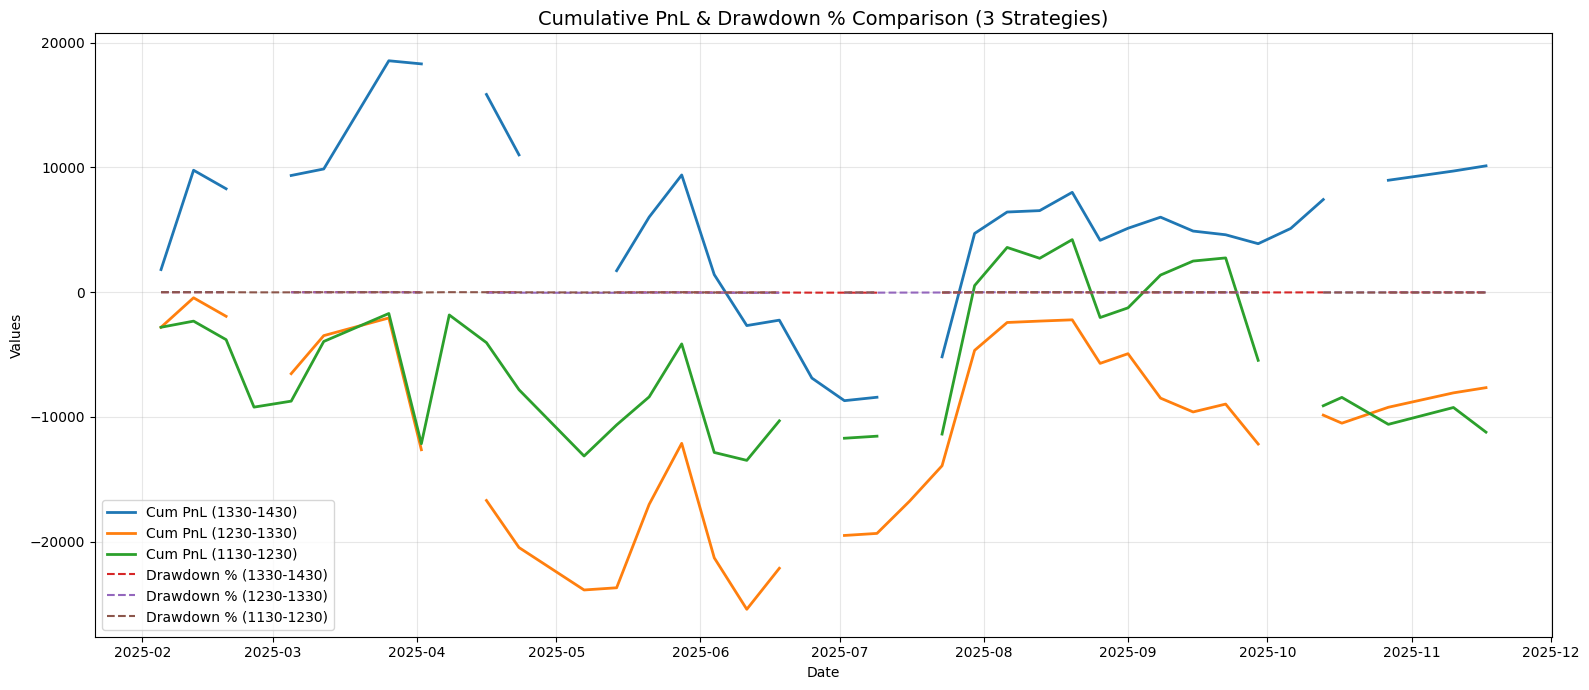

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Load 3 CSV files
# ----------------------------
df_1330 = pd.read_csv("/content/daily_summary_with_drawdown13301430.csv")
df_1230 = pd.read_csv("/content/daily_summary_with_drawdown12301330.csv")
df_1130 = pd.read_csv("/content/daily_summary_with_drawdown11301230.csv")

# ---------------------------------------------------
# 2) Rename columns to identify each strategy
# ---------------------------------------------------
df_1330 = df_1330.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1330",
    "Drawdown_Pct": "drawdown_pct_1330"
})

df_1230 = df_1230.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1230",
    "Drawdown_Pct": "drawdown_pct_1230"
})

df_1130 = df_1130.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1130",
    "Drawdown_Pct": "drawdown_pct_1130"
})

# ---------------------------------------------------
# 3) Merge all on F_Date (outer join)
# ---------------------------------------------------
combined = (
    df_1330.merge(df_1230, on="F_Date", how="outer")
           .merge(df_1130, on="F_Date", how="outer")
)

# ---------------------------------------------------
# 4) Sort dates (handles mixed date formats)
# ---------------------------------------------------
combined["F_Date"] = pd.to_datetime(
    combined["F_Date"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

combined = combined.sort_values("F_Date")


# ---------------------------------------------------
# 5) Save combined output
# ---------------------------------------------------
combined.to_csv("combined_output.csv", index=False)
print("✔ combined_output.csv saved!")

# ---------------------------------------------------
# 6) Plot combined chart
# ---------------------------------------------------
plt.figure(figsize=(16, 7))

# ---- Cumulative PnL lines ----
plt.plot(combined["F_Date"], combined["cumulative_pnl_1330"], label="Cum PnL (1330-1430)", linewidth=2)
plt.plot(combined["F_Date"], combined["cumulative_pnl_1230"], label="Cum PnL (1230-1330)", linewidth=2)
plt.plot(combined["F_Date"], combined["cumulative_pnl_1130"], label="Cum PnL (1130-1230)", linewidth=2)

# ---- Drawdown % lines ----
plt.plot(combined["F_Date"], combined["drawdown_pct_1330"], label="Drawdown % (1330-1430)", linestyle="--")
plt.plot(combined["F_Date"], combined["drawdown_pct_1230"], label="Drawdown % (1230-1330)", linestyle="--")
plt.plot(combined["F_Date"], combined["drawdown_pct_1130"], label="Drawdown % (1130-1230)", linestyle="--")

plt.title("Cumulative PnL & Drawdown % Comparison (3 Strategies)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("combined_chart.png", dpi=300)
print("✔ combined_chart.png saved!")

plt.show()


✔ combined_output_with_total.csv saved!
✔ combined_total_chart.png saved!


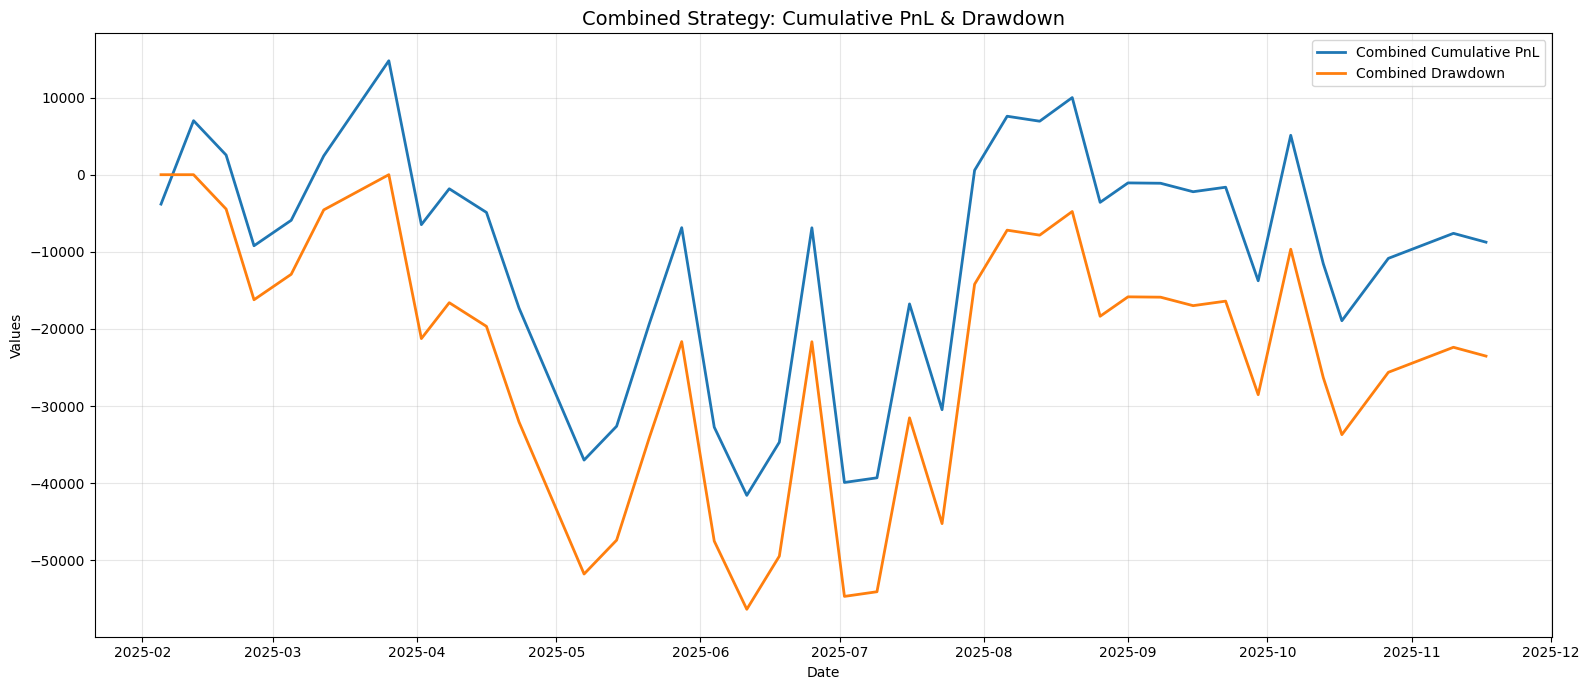

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Load 3 CSV files
# ----------------------------
df_1330 = pd.read_csv("/content/daily_summary_with_drawdown13301430.csv")
df_1230 = pd.read_csv("/content/daily_summary_with_drawdown12301330.csv")
df_1130 = pd.read_csv("/content/daily_summary_with_drawdown11301230.csv")

# ---------------------------------------------------
# 2) Rename columns to identify each strategy
# ---------------------------------------------------
df_1330 = df_1330.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1330",
    "Drawdown_Pct": "drawdown_pct_1330",
    "Drawdown_Abs": "drawdown_abs_1330"
})

df_1230 = df_1230.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1230",
    "Drawdown_Pct": "drawdown_pct_1230",
    "Drawdown_Abs": "drawdown_abs_1230"
})

df_1130 = df_1130.rename(columns={
    "cumulative_pnl": "cumulative_pnl_1130",
    "Drawdown_Pct": "drawdown_pct_1130",
    "Drawdown_Abs": "drawdown_abs_1130"
})

# ---------------------------------------------------
# 3) Merge all on F_Date (outer join)
# ---------------------------------------------------
combined = (
    df_1330.merge(df_1230, on="F_Date", how="outer")
           .merge(df_1130, on="F_Date", how="outer")
)

# ---------------------------------------------------
# 4) Sort dates (handles mixed date formats)
# ---------------------------------------------------
combined["F_Date"] = pd.to_datetime(
    combined["F_Date"], format="mixed", dayfirst=True, errors="coerce"
)
combined = combined.sort_values("F_Date")

# ---------------------------------------------------
# 5) Build Combined PNL + Combined Drawdown
# ---------------------------------------------------

# Sum 3 cumulative pnl values
combined["combined_cumulative_pnl"] = (
    combined["cumulative_pnl_1330"].fillna(0) +
    combined["cumulative_pnl_1230"].fillna(0) +
    combined["cumulative_pnl_1130"].fillna(0)
)

# Build equity curve based on combined pnl
start_equity = 50000  # If your equity is different, change here
combined["combined_equity"] = start_equity + combined["combined_cumulative_pnl"]

# Rolling peak
combined["combined_peak_equity"] = combined["combined_equity"].cummax()

# Drawdown absolute
combined["combined_drawdown_abs"] = (
    combined["combined_equity"] - combined["combined_peak_equity"]
)

# Drawdown percentage
combined["combined_drawdown_pct"] = (
    combined["combined_drawdown_abs"] / combined["combined_peak_equity"]
) * 100

# ---------------------------------------------------
# 6) Save updated combined output
# ---------------------------------------------------
combined.to_csv("combined_output_with_total.csv", index=False)
print("✔ combined_output_with_total.csv saved!")

# ---------------------------------------------------
# 7) PLOT ONLY COMBINED PNL + COMBINED DRAWDOWN
# ---------------------------------------------------

plt.figure(figsize=(16, 7))

plt.plot(combined["F_Date"], combined["combined_cumulative_pnl"],
         label="Combined Cumulative PnL", linewidth=2)

plt.plot(combined["F_Date"], combined["combined_drawdown_abs"],
         label="Combined Drawdown", linewidth=2)

plt.title("Combined Strategy: Cumulative PnL & Drawdown", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("combined_total_chart.png", dpi=300)
print("✔ combined_total_chart.png saved!")

plt.show()


Found files: ['/content/daily_summary_with_drawdown9301030.csv', '/content/daily_summary_with_drawdown_PE_FIRST11301230.csv', '/content/daily_summary_with_drawdown11301230.csv', '/content/daily_summary_with_drawdown_PE_FIRST9301030.csv', '/content/daily_summary_with_drawdown13301430.csv', '/content/daily_summary_with_drawdown14151515.csv', '/content/daily_summary_with_drawdown_PE_FIRST10301130.csv', '/content/daily_summary_with_drawdown12301330.csv', '/content/daily_summary_with_drawdown_PE_FIRST14151515.csv', '/content/daily_summary_with_drawdown10301130.csv', '/content/daily_summary_with_drawdown_PE_FIRST12301330.csv', '/content/daily_summary_with_drawdown_PE_FIRST13301430.csv']
✔ combined_output_with_total.csv saved!
✔ combined_total_chart.png saved!


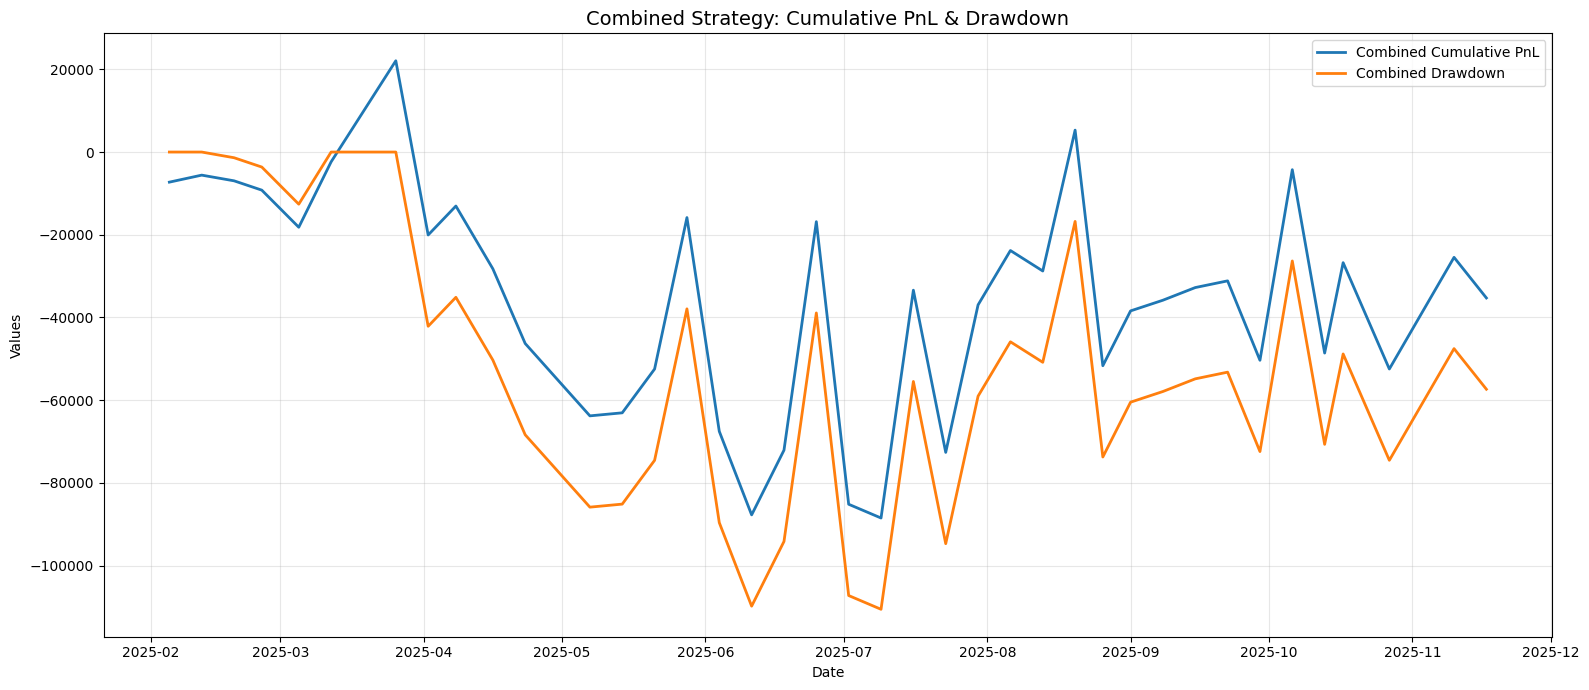

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# --------------------------
# 1) Auto-detect all files
# --------------------------
files = glob.glob("/content/daily_summary_with_drawdown*.csv")
print("Found files:", files)

dfs = []
ranges = []  # store extracted labels

# --------------------------
# 2) Load each file safely
# --------------------------
for f in files:

    # Extract time range from filename
    match = re.search(r'drawdown(\d+)\.csv', f)
    if not match:
        continue

    tag = match.group(1)  # example: 9301030
    ranges.append(tag)

    # Read CSV but keep only required columns
    df = pd.read_csv(f, usecols=[
        "F_Date",
        "cumulative_pnl",
        "Drawdown_Pct",
        "Drawdown_Abs"
    ])

    # Rename to avoid duplicates
    df = df.rename(columns={
        "cumulative_pnl": f"cumulative_pnl_{tag}",
        "Drawdown_Pct": f"drawdown_pct_{tag}",
        "Drawdown_Abs": f"drawdown_abs_{tag}"
    })

    dfs.append(df)

# --------------------------
# 3) Merge all on F_Date
# --------------------------
combined = dfs[0]
for df in dfs[1:]:
    combined = combined.merge(df, on="F_Date", how="outer")

# --------------------------
# 4) Fix date + sort
# --------------------------
combined["F_Date"] = pd.to_datetime(
    combined["F_Date"], format="mixed", errors="coerce", dayfirst=True
)
combined = combined.sort_values("F_Date")

# --------------------------
# 5) Build combined PnL + Drawdown
# --------------------------
pnl_cols = [f"cumulative_pnl_{r}" for r in ranges]

combined["combined_cumulative_pnl"] = combined[pnl_cols].fillna(0).sum(axis=1)

start_equity = 0
combined["combined_equity"] = start_equity + combined["combined_cumulative_pnl"]

combined["combined_peak_equity"] = combined["combined_equity"].cummax()

combined["combined_drawdown_abs"] = (
    combined["combined_equity"] - combined["combined_peak_equity"]
)

combined["combined_drawdown_pct"] = (
    combined["combined_drawdown_abs"] / combined["combined_peak_equity"]
) * 100

# --------------------------
# 6) Save output
# --------------------------
combined.to_csv("combined_output_with_total.csv", index=False)
print("✔ combined_output_with_total.csv saved!")

# --------------------------
# 7) Plot Combined PnL + Drawdown
# --------------------------
plt.figure(figsize=(16, 7))
plt.plot(combined["F_Date"], combined["combined_cumulative_pnl"],
         label="Combined Cumulative PnL", linewidth=2)

plt.plot(combined["F_Date"], combined["combined_drawdown_abs"],
         label="Combined Drawdown", linewidth=2)

plt.title("Combined Strategy: Cumulative PnL & Drawdown", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("combined_total_chart.png", dpi=300)
print("✔ combined_total_chart.png saved!")
plt.show()


Found files: ['/content/daily_summary_with_drawdown_PE_FIRST11301230.csv', '/content/daily_summary_with_drawdown_PE_FIRST9301030.csv', '/content/daily_summary_with_drawdown_PE_FIRST10301130.csv', '/content/daily_summary_with_drawdown_PE_FIRST14151515.csv', '/content/daily_summary_with_drawdown_PE_FIRST12301330.csv', '/content/daily_summary_with_drawdown_PE_FIRST13301430.csv']
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST11301230.csv  → tag = 11301230
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST9301030.csv  → tag = 9301030
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST10301130.csv  → tag = 10301130
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST14151515.csv  → tag = 14151515
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST12301330.csv  → tag = 12301330
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST13301430.csv  → tag = 13301430
✔ combined_output_with_total.csv saved!
✔ combined_total_chart.png saved!


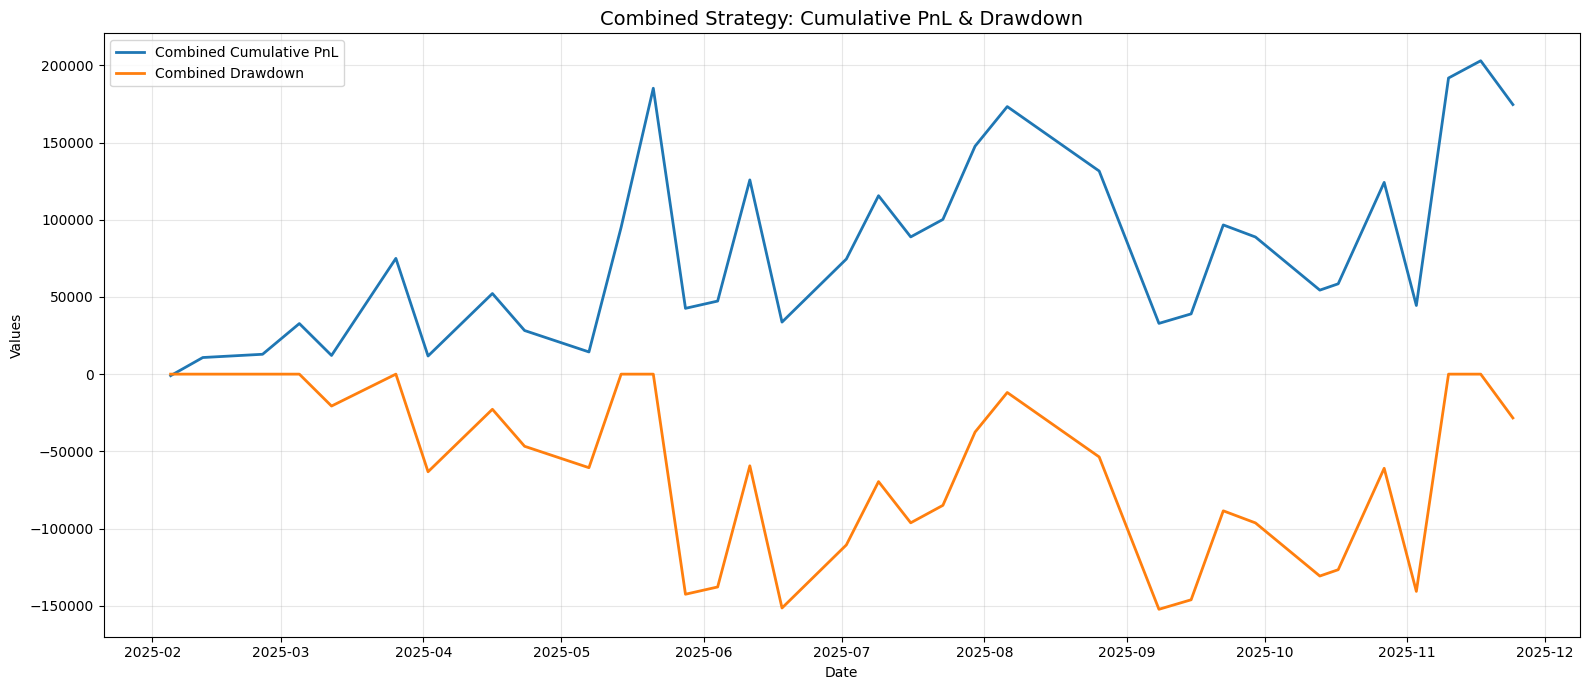

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# --------------------------
# 1) Auto-detect all files
# --------------------------
files = glob.glob("/content/daily_summary_with_drawdown_PE_FIRST*.csv")
print("Found files:", files)

dfs = []
ranges = []  # store extracted labels

# --------------------------
# 2) Load each file safely
# --------------------------
for f in files:

    # Extract time range from filename
    match = re.search(r'PE_FIRST(\d+)\.csv', f)
    if not match:
        print("❌ Could not extract tag from:", f)
        continue

    tag = match.group(1)
    ranges.append(tag)

    print("✔ Loading:", f, " → tag =", tag)

    # Read full CSV since structure varies
    df = pd.read_csv(f)

    # Ensure required columns exist
    if "Drawdown_Abs" not in df.columns:
        df["Drawdown_Abs"] = df["Equity"] - df["Peak_Equity"]

    # Keep only columns we need
    df = df[["F_Date", "cumulative_pnl", "Drawdown_Pct", "Drawdown_Abs"]]

    # Rename uniquely to avoid merge conflicts
    df = df.rename(columns={
        "cumulative_pnl": f"cumulative_pnl_{tag}",
        "Drawdown_Pct": f"drawdown_pct_{tag}",
        "Drawdown_Abs": f"drawdown_abs_{tag}"
    })

    dfs.append(df)

# --------------------------
# 3) Ensure at least one file loaded
# --------------------------
if len(dfs) == 0:
    raise Exception("❌ No CSVs loaded — check file names.")

# --------------------------
# 4) Merge all on F_Date
# --------------------------
combined = dfs[0]
for df in dfs[1:]:
    combined = combined.merge(df, on="F_Date", how="outer")

# --------------------------
# 5) Fix date + sort
# --------------------------
combined["F_Date"] = pd.to_datetime(
    combined["F_Date"], format="mixed", errors="coerce", dayfirst=True
)
combined = combined.sort_values("F_Date")

# --------------------------
# 6) Combined PnL & Drawdown
# --------------------------
pnl_cols = [f"cumulative_pnl_{r}" for r in ranges]

combined["combined_cumulative_pnl"] = combined[pnl_cols].fillna(0).sum(axis=1)

# Combined equity = cum pnl (you can add starting eq if needed)
combined["combined_equity"] = combined["combined_cumulative_pnl"]

combined["combined_peak_equity"] = combined["combined_equity"].cummax()

combined["combined_drawdown_abs"] = (
    combined["combined_equity"] - combined["combined_peak_equity"]
)

combined["combined_drawdown_pct"] = (
    combined["combined_drawdown_abs"] / combined["combined_peak_equity"]
) * 100

# --------------------------
# 7) Save output
# --------------------------
combined.to_csv("combined_output_with_total.csv", index=False)
print("✔ combined_output_with_total.csv saved!")

# --------------------------
# 8) Plot Combined PnL + Drawdown
# --------------------------
plt.figure(figsize=(16, 7))
plt.plot(combined["F_Date"], combined["combined_cumulative_pnl"],
         label="Combined Cumulative PnL", linewidth=2)

plt.plot(combined["F_Date"], combined["combined_drawdown_abs"],
         label="Combined Drawdown", linewidth=2)

plt.title("Combined Strategy: Cumulative PnL & Drawdown", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("combined_total_chart.png", dpi=300)
print("✔ combined_total_chart.png saved!")

plt.show()


Found files: ['/content/daily_summary_with_drawdown_PE_FIRST11301230.csv', '/content/daily_summary_with_drawdown_PE_FIRST9301030.csv', '/content/daily_summary_with_drawdown_PE_FIRST10301130.csv', '/content/daily_summary_with_drawdown_PE_FIRST14151515.csv', '/content/daily_summary_with_drawdown_PE_FIRST12301330.csv', '/content/daily_summary_with_drawdown_PE_FIRST13301430.csv']
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST11301230.csv → expiry tag = PE_FIRST11301230
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST9301030.csv → expiry tag = PE_FIRST9301030
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST10301130.csv → expiry tag = PE_FIRST10301130
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST14151515.csv → expiry tag = PE_FIRST14151515
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST12301330.csv → expiry tag = PE_FIRST12301330
✔ Loading: /content/daily_summary_with_drawdown_PE_FIRST13301430.csv → expiry tag = PE_FIRST13301430
Combined shape: (

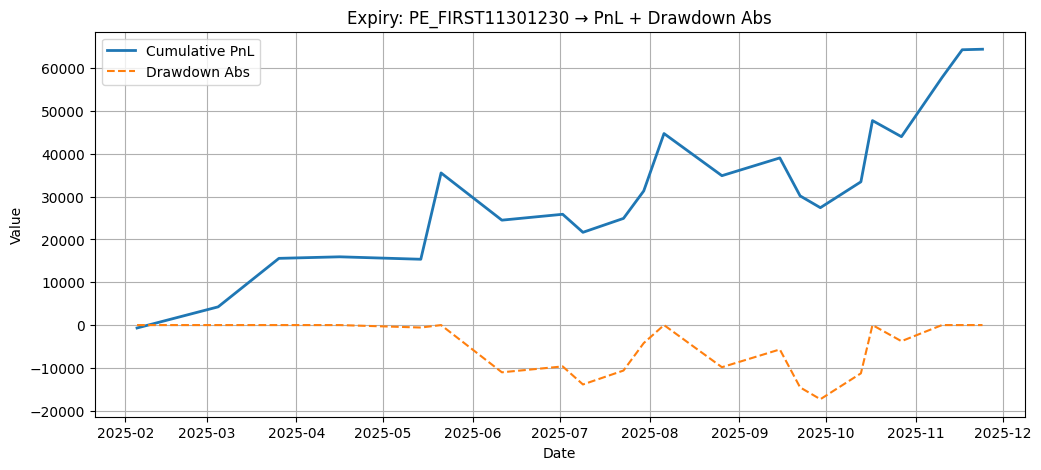

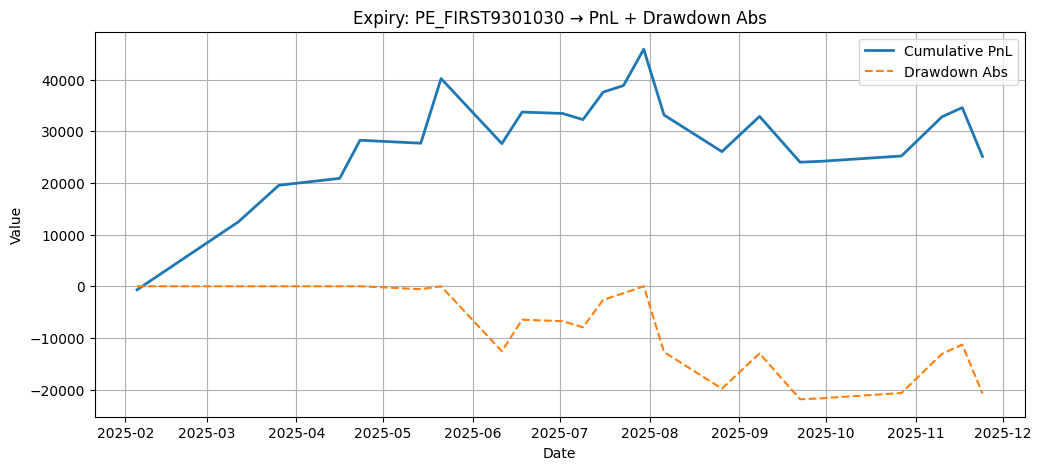

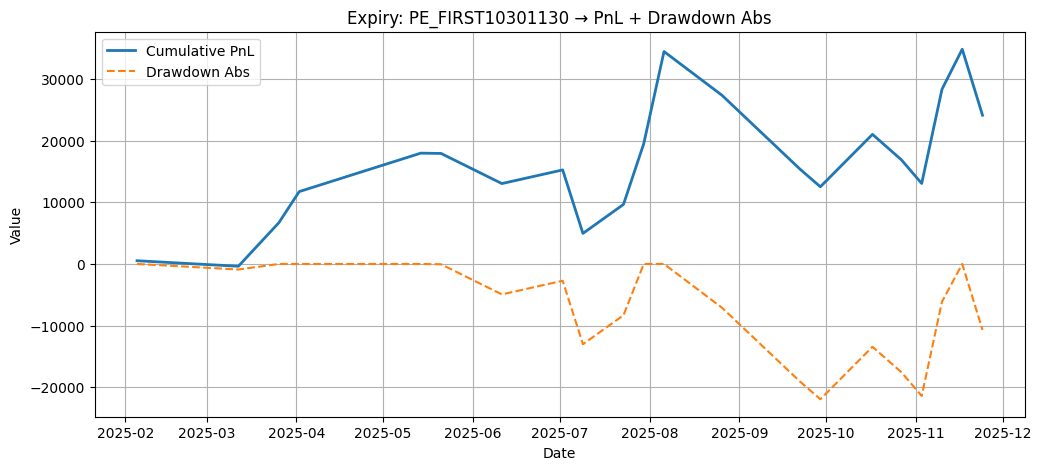

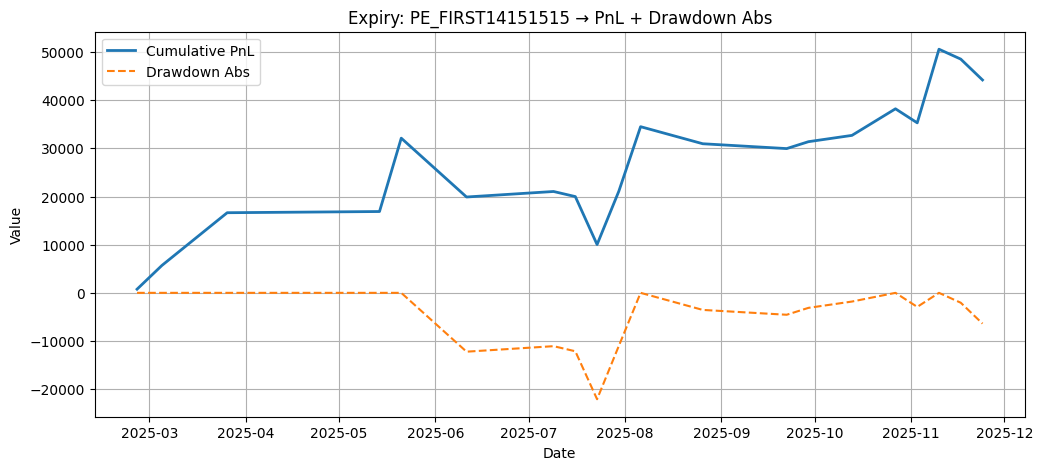

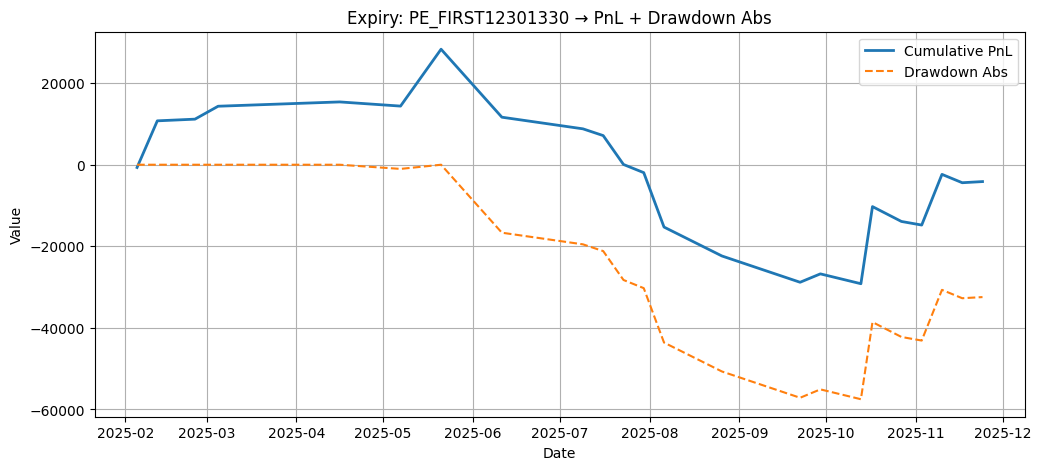

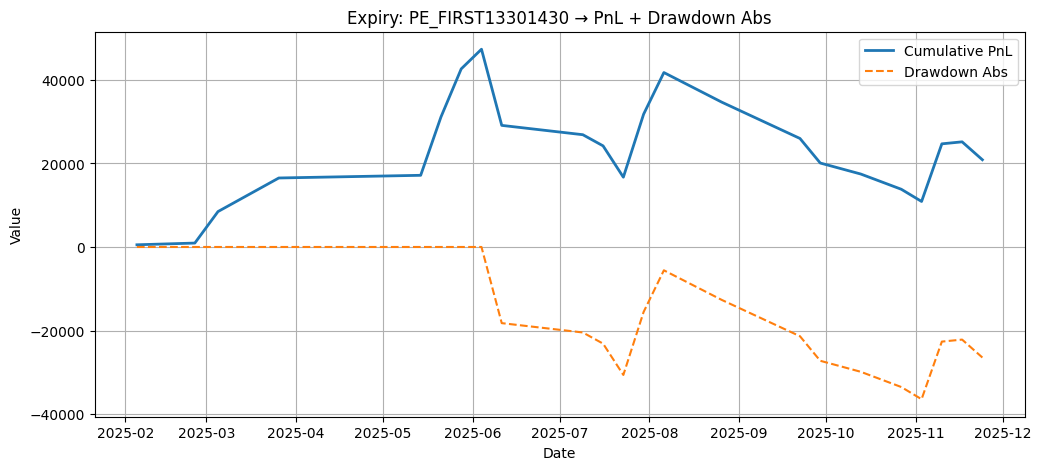

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# ===============================================
# 1) Find all required CSV files
# ===============================================
files = glob.glob("/content/daily_summary_with_drawdown_*.csv")
print("Found files:", files)

combined = []

# ===============================================
# 2) Process each expiry file
# ===============================================
for f in files:
    tag = os.path.basename(f).split("with_drawdown_")[1].replace(".csv", "")
    print(f"✔ Loading: {f} → expiry tag = {tag}")

    df = pd.read_csv(f)

    # Ensure Drawdown_Abs exists
    if "Drawdown_Abs" not in df.columns:
        df["Drawdown_Abs"] = df["Equity"] - df["Peak_Equity"]

    # Standardize column names
    df["expiry"] = tag
    df["F_Date"] = pd.to_datetime(df["F_Date"], format='mixed', dayfirst=True, errors='coerce')


    combined.append(df)

# ===============================================
# 3) Combine all Expiry data
# ===============================================
full_df = pd.concat(combined, ignore_index=True)
print("Combined shape:", full_df.shape)

# ===============================================
# 4) Plot expiry-wise PnL + Drawdown Abs
# ===============================================
unique_expiries = full_df["expiry"].unique()

for exp in unique_expiries:
    df_exp = full_df[full_df["expiry"] == exp].sort_values("F_Date")

    plt.figure(figsize=(12, 5))
    plt.plot(df_exp["F_Date"], df_exp["cumulative_pnl"], label="Cumulative PnL", linewidth=2)
    plt.plot(df_exp["F_Date"], df_exp["Drawdown_Abs"], label="Drawdown Abs", linestyle="--")

    plt.title(f"Expiry: {exp} → PnL + Drawdown Abs")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


# ultra combine

CE files: ['/content/daily_summary_with_drawdown9301030.csv', '/content/daily_summary_with_drawdown11301230.csv', '/content/daily_summary_with_drawdown13301430.csv', '/content/daily_summary_with_drawdown14151515.csv', '/content/daily_summary_with_drawdown12301330.csv', '/content/daily_summary_with_drawdown10301130.csv']
PE files: ['/content/daily_summary_with_drawdown_PE_FIRST11301230.csv', '/content/daily_summary_with_drawdown_PE_FIRST9301030.csv', '/content/daily_summary_with_drawdown_PE_FIRST10301130.csv', '/content/daily_summary_with_drawdown_PE_FIRST14151515.csv', '/content/daily_summary_with_drawdown_PE_FIRST12301330.csv', '/content/daily_summary_with_drawdown_PE_FIRST13301430.csv']
✔ Loading CE: /content/daily_summary_with_drawdown9301030.csv → tag = CE_9301030
✔ Loading CE: /content/daily_summary_with_drawdown11301230.csv → tag = CE_11301230
✔ Loading CE: /content/daily_summary_with_drawdown13301430.csv → tag = CE_13301430
✔ Loading CE: /content/daily_summary_with_drawdown14151

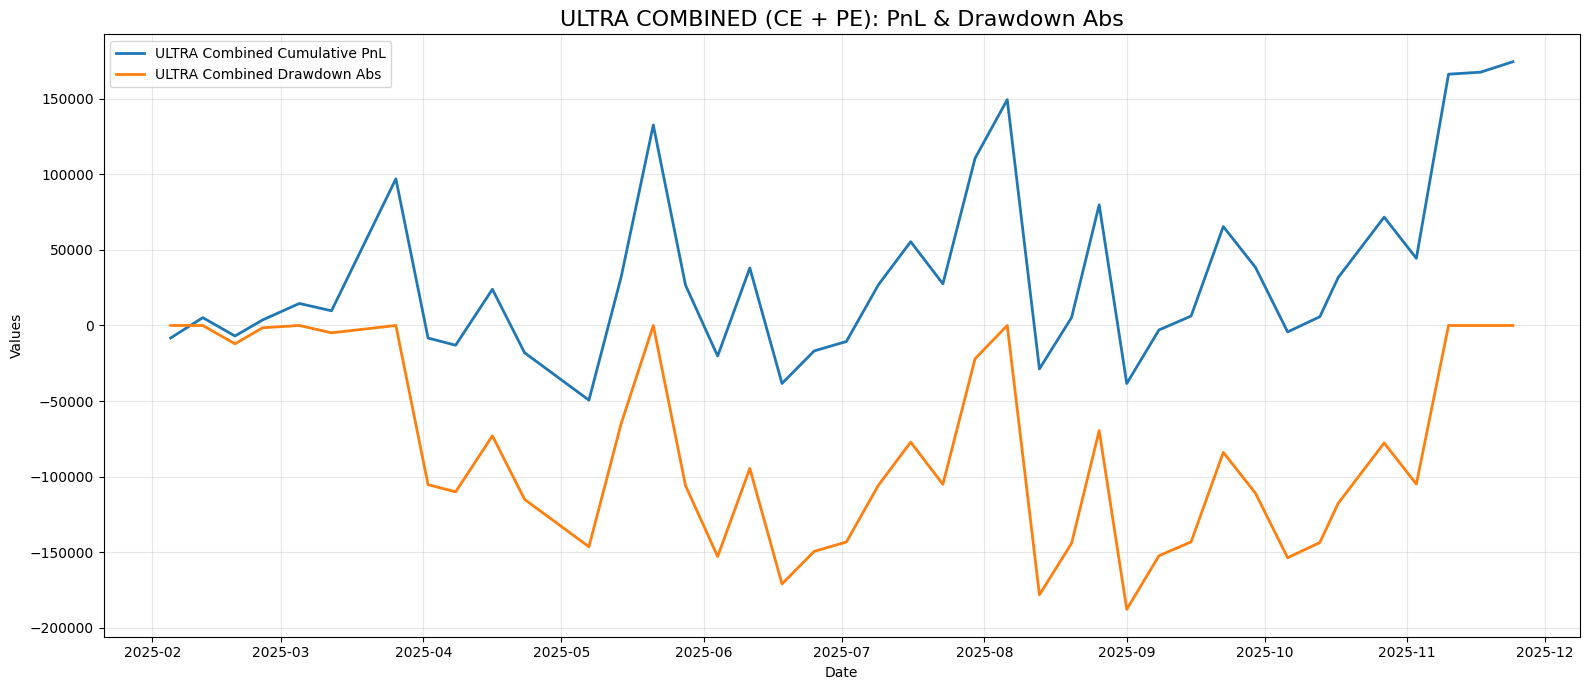

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# ------------------------------------------------------------
# STEP 1: GET CLEAN CE + PE FILE LISTS
# ------------------------------------------------------------
ce_files = glob.glob("/content/daily_summary_with_drawdown[0-9]*.csv")  # CE ONLY
pe_files = glob.glob("/content/daily_summary_with_drawdown_PE_FIRST*.csv")  # PE ONLY

print("CE files:", ce_files)
print("PE files:", pe_files)

dfs = []
ranges = []


# ============================================================
# GENERIC LOAD FUNCTION
# ============================================================
def load_file(f, regex_pattern, prefix):
    match = re.search(regex_pattern, f)
    if not match:
        return None, None

    pure_tag = match.group(1)          # e.g. 9301030
    tag = f"{prefix}_{pure_tag}"       # CE_9301030 or PE_9301030

    print(f"✔ Loading {prefix}: {f} → tag = {tag}")

    df = pd.read_csv(f)

    # Ensure Drawdown_Abs exists
    if "Drawdown_Abs" not in df.columns:
        df["Drawdown_Abs"] = df["Equity"] - df["Peak_Equity"]

    df = df[["F_Date", "cumulative_pnl", "Drawdown_Pct", "Drawdown_Abs"]]

    df = df.rename(columns={
        "cumulative_pnl": f"cumulative_pnl_{tag}",
        "Drawdown_Pct": f"drawdown_pct_{tag}",
        "Drawdown_Abs": f"drawdown_abs_{tag}"
    })

    return df, tag


# ------------------------------------------------------------
# STEP 2: LOAD CE
# ------------------------------------------------------------
for f in ce_files:
    df, tag = load_file(f, r'drawdown([0-9]+)\.csv', "CE")
    if df is not None:
        dfs.append(df)
        ranges.append(tag)

# ------------------------------------------------------------
# STEP 3: LOAD PE
# ------------------------------------------------------------
for f in pe_files:
    df, tag = load_file(f, r'PE_FIRST([0-9]+)\.csv', "PE")
    if df is not None:
        dfs.append(df)
        ranges.append(tag)


# ------------------------------------------------------------
# STEP 4: MERGE ALL
# ------------------------------------------------------------
combined = dfs[0]
for df in dfs[1:]:
    combined = combined.merge(df, on="F_Date", how="outer")

# ------------------------------------------------------------
# STEP 5: CLEAN DATE
# ------------------------------------------------------------
combined["F_Date"] = pd.to_datetime(
    combined["F_Date"], format="mixed", errors="coerce", dayfirst=True
)
combined = combined.sort_values("F_Date")

# ------------------------------------------------------------
# STEP 6: ULTRA COMBINED PNL & DRAWDOWN
# ------------------------------------------------------------
pnl_cols = [f"cumulative_pnl_{tag}" for tag in ranges]

combined["ultra_cumulative_pnl"] = combined[pnl_cols].fillna(0).sum(axis=1)
combined["ultra_equity"] = combined["ultra_cumulative_pnl"]
combined["ultra_peak_equity"] = combined["ultra_equity"].cummax()
combined["ultra_drawdown_abs"] = combined["ultra_equity"] - combined["ultra_peak_equity"]
combined["ultra_drawdown_pct"] = (
    combined["ultra_drawdown_abs"] / combined["ultra_peak_equity"]
) * 100

# ------------------------------------------------------------
# STEP 7: SAVE FILE
# ------------------------------------------------------------
combined.to_csv("ultra_combined_output.csv", index=False)
print("✔ ultra_combined_output.csv saved!")

# ------------------------------------------------------------
# STEP 8: CHART
# ------------------------------------------------------------
plt.figure(figsize=(16, 7))
plt.plot(combined["F_Date"], combined["ultra_cumulative_pnl"],
         label="ULTRA Combined Cumulative PnL", linewidth=2)
plt.plot(combined["F_Date"], combined["ultra_drawdown_abs"],
         label="ULTRA Combined Drawdown Abs", linewidth=2)

plt.title("ULTRA COMBINED (CE + PE): PnL & Drawdown Abs", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("ultra_combined_chart.png", dpi=300)
print("✔ ultra_combined_chart.png saved!")
plt.show()
